# Preprocessing

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
import shutil
import tensorflow as tf
import pywt
from glob import glob
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import hog
from skimage import exposure
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model

In [4]:
df = pd.read_csv(r'D:\Tugas Akhir\Skin Cancer Dataset\HAM10000_metadata.csv')

In [5]:
df.head(10)

lesion_id      image_id   dx dx_type   age     sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0    male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0    male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0    male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0    male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0    male          ear
5  HAM_0001466  ISIC_0027850  bkl   histo  75.0    male          ear
6  HAM_0002761  ISIC_0029176  bkl   histo  60.0    male         face
7  HAM_0002761  ISIC_0029068  bkl   histo  60.0    male         face
8  HAM_0005132  ISIC_0025837  bkl   histo  70.0  female         back
9  HAM_0005132  ISIC_0025209  bkl   histo  70.0  female         back

In [6]:
from sklearn.utils import resample
print(df['dx'].value_counts())

nv       6705
mel      1188
bkl      1099
bcc       589
norm      576
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


Text(0.5, 1.0, 'Jumlah masing - masing penyakit kulit pada dataset')

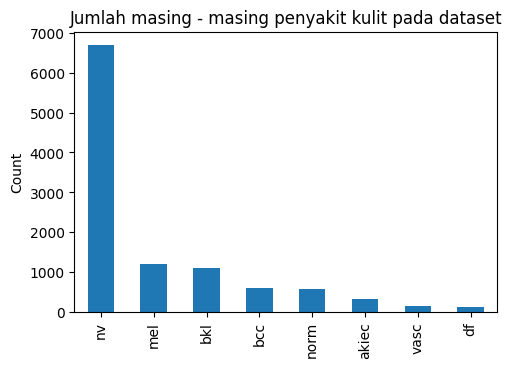

In [7]:
fig = plt.figure(figsize = (12, 8))

ax1 = fig.add_subplot(221)
df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Jumlah masing - masing penyakit kulit pada dataset')

In [8]:
image_path = {os.path.splitext(os.path.basename(x))[0]:x
              for x in glob(os.path.join('D:\Tugas Akhir Skin Cancer/', '*.jpg'))}

In [9]:
df['path'] = df['image_id'].map(image_path.get)

In [10]:
df.head()

lesion_id      image_id   dx dx_type   age   sex localization  \
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   

                                          path  
0  D:\Tugas Akhir Skin Cancer\ISIC_0027419.jpg  
1  D:\Tugas Akhir Skin Cancer\ISIC_0025030.jpg  
2  D:\Tugas Akhir Skin Cancer\ISIC_0026769.jpg  
3  D:\Tugas Akhir Skin Cancer\ISIC_0025661.jpg  
4  D:\Tugas Akhir Skin Cancer\ISIC_0031633.jpg

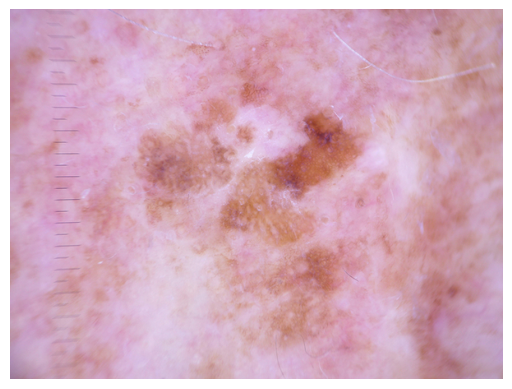

In [11]:
# Membaca gambar menggunakan Matplotlib
image_path = "D:\Tugas Akhir Skin Cancer/ISIC_0027419.jpg"
image = plt.imread(image_path)

# Menampilkan gambar
plt.imshow(image)
plt.axis('off')  # Menghilangkan sumbu
plt.show()

In [12]:
SIZE=50
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

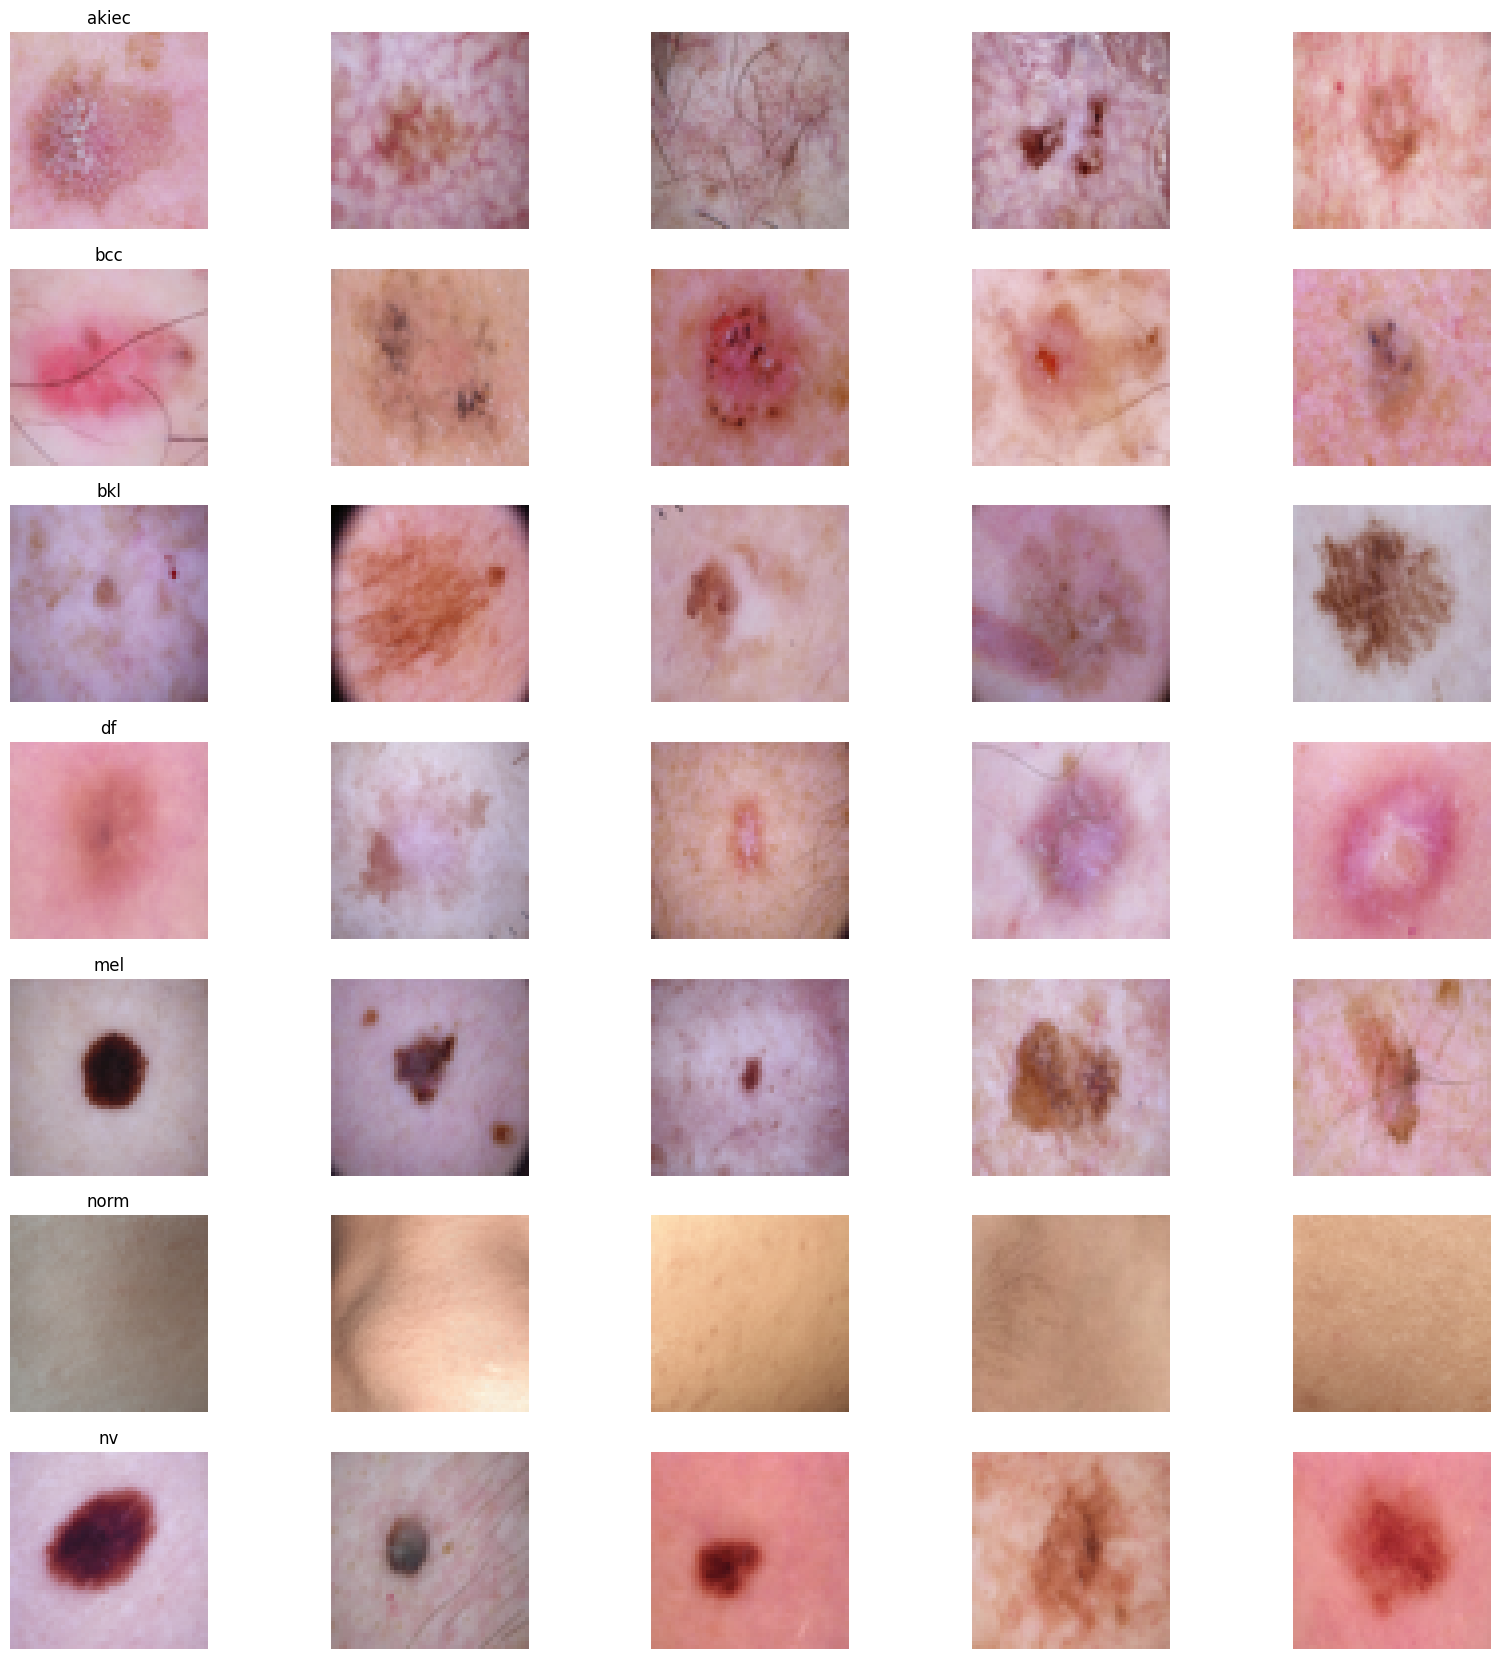

In [13]:
n_samples = 5  

# Plot
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [14]:
df

lesion_id      image_id   dx dx_type   age   sex localization  \
0      HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp   
1      HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp   
2      HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp   
3      HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp   
4      HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear   
...            ...           ...  ...     ...   ...   ...          ...   
10736          722           722  bcc     NaN   NaN   NaN          NaN   
10737          723           723  bcc     NaN   NaN   NaN          NaN   
10738          724           724  bcc     NaN   NaN   NaN          NaN   
10739          725           725  bcc     NaN   NaN   NaN          NaN   
10740          726           726  bcc     NaN   NaN   NaN          NaN   

                                              path  \
0      D:\Tugas Akhir Skin Cancer\ISIC_0027419.jpg   
1      D:\Tugas Akhir Skin Cancer\ISIC_0025030.jpg   
2      D:\Tugas Akhir Skin Cancer\ISIC_0026769.jpg   
3      D:\Tugas Akhir Skin Cancer\ISIC_0025661.jpg   
4      D:\Tugas Akhir Skin Cancer\ISIC_0031633.jpg   
...                                            ...   
10736           D:\Tugas Akhir Skin Cancer\722.jpg   
10737           D:\Tugas Akhir Skin Cancer\723.jpg   
10738           D:\Tugas Akhir Skin Cancer\724.jpg   
10739           D:\Tugas Akhir Skin Cancer\725.jpg   
10740           D:\Tugas Akhir Skin Cancer\726.jpg   

                                                   image  
0      [[[191, 151, 192], [192, 152, 195], [193, 152,...  
1      [[[23, 13, 24], [29, 18, 36], [56, 39, 64], [9...  
2      [[[186, 130, 143], [195, 140, 154], [199, 143,...  
3      [[[26, 12, 21], [49, 27, 39], [86, 55, 67], [1...  
4      [[[144, 99, 123], [168, 123, 149], [189, 141, ...  
...                                                  ...  
10736  [[[175, 132, 97], [172, 127, 92], [176, 129, 9...  
10737  [[[211, 168, 122], [210, 166, 123], [211, 164,...  
10738  [[[163, 147, 129], [162, 141, 118], [155, 125,...  
10739  [[[108, 86, 78], [111, 83, 76], [117, 93, 85],...  
10740  [[[200, 187, 171], [200, 189, 172], [198, 190,...  

[10741 rows x 9 columns]

In [15]:
#Filter diagnosa melanoma, basall cell carcinoma, dan normal
filtered_dx = df[df['dx'].isin(['mel', 'bcc', 'norm'])]
filtered_dx

lesion_id      image_id   dx dx_type   age     sex     localization  \
1211   HAM_0000871  ISIC_0025964  mel   histo  40.0  female            chest   
1212   HAM_0000871  ISIC_0030623  mel   histo  40.0  female            chest   
1213   HAM_0000040  ISIC_0027190  mel   histo  80.0    male  upper extremity   
1214   HAM_0005678  ISIC_0031023  mel   histo  60.0    male            chest   
1215   HAM_0005678  ISIC_0028086  mel   histo  60.0    male            chest   
...            ...           ...  ...     ...   ...     ...              ...   
10736          722           722  bcc     NaN   NaN     NaN              NaN   
10737          723           723  bcc     NaN   NaN     NaN              NaN   
10738          724           724  bcc     NaN   NaN     NaN              NaN   
10739          725           725  bcc     NaN   NaN     NaN              NaN   
10740          726           726  bcc     NaN   NaN     NaN              NaN   

                                              path  \
1211   D:\Tugas Akhir Skin Cancer\ISIC_0025964.jpg   
1212   D:\Tugas Akhir Skin Cancer\ISIC_0030623.jpg   
1213   D:\Tugas Akhir Skin Cancer\ISIC_0027190.jpg   
1214   D:\Tugas Akhir Skin Cancer\ISIC_0031023.jpg   
1215   D:\Tugas Akhir Skin Cancer\ISIC_0028086.jpg   
...                                            ...   
10736           D:\Tugas Akhir Skin Cancer\722.jpg   
10737           D:\Tugas Akhir Skin Cancer\723.jpg   
10738           D:\Tugas Akhir Skin Cancer\724.jpg   
10739           D:\Tugas Akhir Skin Cancer\725.jpg   
10740           D:\Tugas Akhir Skin Cancer\726.jpg   

                                                   image  
1211   [[[141, 118, 122], [156, 127, 132], [159, 128,...  
1212   [[[200, 171, 187], [201, 172, 187], [200, 172,...  
1213   [[[134, 113, 133], [139, 119, 138], [144, 123,...  
1214   [[[16, 6, 14], [13, 3, 8], [35, 22, 36], [98, ...  
1215   [[[220, 198, 219], [230, 213, 235], [235, 218,...  
...                                                  ...  
10736  [[[175, 132, 97], [172, 127, 92], [176, 129, 9...  
10737  [[[211, 168, 122], [210, 166, 123], [211, 164,...  
10738  [[[163, 147, 129], [162, 141, 118], [155, 125,...  
10739  [[[108, 86, 78], [111, 83, 76], [117, 93, 85],...  
10740  [[[200, 187, 171], [200, 189, 172], [198, 190,...  

[2353 rows x 9 columns]

In [16]:
print(filtered_dx['dx'].value_counts())

mel     1188
bcc      589
norm     576
Name: dx, dtype: int64


In [17]:
#Filter 575 data per diagnosis
fix_dx = filtered_dx.groupby('dx').apply(lambda x: x.tail(575)).reset_index(drop=True)
fix_dx

lesion_id      image_id    dx dx_type   age     sex localization  \
0     HAM_0004342  ISIC_0027976   bcc   histo  80.0    male         back   
1     HAM_0005776  ISIC_0028238   bcc   histo  80.0    male         back   
2     HAM_0005776  ISIC_0029755   bcc   histo  80.0    male         back   
3     HAM_0006047  ISIC_0026321   bcc   histo  65.0  female        scalp   
4     HAM_0006047  ISIC_0025467   bcc   histo  65.0  female        scalp   
...           ...           ...   ...     ...   ...     ...          ...   
1720          572           572  norm     NaN   NaN     NaN          NaN   
1721          573           573  norm     NaN   NaN     NaN          NaN   
1722          574           574  norm     NaN   NaN     NaN          NaN   
1723          575           575  norm     NaN   NaN     NaN          NaN   
1724          576           576  norm     NaN   NaN     NaN          NaN   

                                             path  \
0     D:\Tugas Akhir Skin Cancer\ISIC_0027976.jpg   
1     D:\Tugas Akhir Skin Cancer\ISIC_0028238.jpg   
2     D:\Tugas Akhir Skin Cancer\ISIC_0029755.jpg   
3     D:\Tugas Akhir Skin Cancer\ISIC_0026321.jpg   
4     D:\Tugas Akhir Skin Cancer\ISIC_0025467.jpg   
...                                           ...   
1720           D:\Tugas Akhir Skin Cancer\572.jpg   
1721           D:\Tugas Akhir Skin Cancer\573.jpg   
1722           D:\Tugas Akhir Skin Cancer\574.jpg   
1723           D:\Tugas Akhir Skin Cancer\575.jpg   
1724           D:\Tugas Akhir Skin Cancer\576.jpg   

                                                  image  
0     [[[50, 23, 31], [85, 52, 58], [121, 86, 91], [...  
1     [[[219, 187, 204], [218, 186, 202], [219, 185,...  
2     [[[78, 53, 52], [118, 87, 77], [150, 113, 96],...  
3     [[[90, 75, 84], [112, 95, 103], [146, 129, 137...  
4     [[[166, 138, 97], [183, 157, 112], [197, 174, ...  
...                                                 ...  
1720  [[[160, 126, 111], [152, 116, 101], [150, 115,...  
1721  [[[164, 131, 119], [160, 128, 117], [160, 133,...  
1722  [[[168, 138, 125], [168, 140, 128], [167, 136,...  
1723  [[[187, 153, 128], [188, 154, 129], [188, 155,...  
1724  [[[160, 126, 111], [152, 116, 101], [150, 115,...  

[1725 rows x 9 columns]

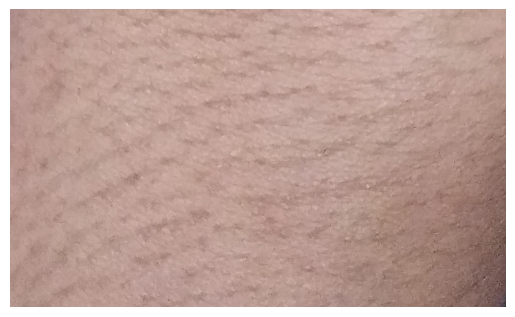

In [18]:
# Membaca gambar menggunakan Matplotlib
image_path = "D:\Tugas Akhir Skin Cancer/1.jpg"
image = plt.imread(image_path)

# Menampilkan gambar
plt.imshow(image)
plt.axis('off')  # Menghilangkan sumbu
plt.show()

In [19]:
print(fix_dx['dx'].value_counts())

bcc     575
mel     575
norm    575
Name: dx, dtype: int64


In [20]:
# Path ke folder dataset gambar
dataset_folder = 'D:\Tugas Akhir Skin Cancer'

# Path ke folder untuk menyimpan gambar hasil
output_folder = 'D:\Tugas Akhir\Output Gaussian Filtering'

# Iterasi melalui setiap baris dalam DataFrame fix_dx
for index, row in fix_dx.iterrows():
    # Muat gambar
    image = cv2.imread(row['path'])
    
    # Terapkan Gaussian filtering
    blurred_image = cv2.GaussianBlur(image, (5, 5), 0)  # Sesuaikan ukuran kernel Gaussian jika diperlukan
    
    # Simpan gambar hasil
    output_path = os.path.join(output_folder, f'{row["image_id"]}.jpg')
    cv2.imwrite(output_path, blurred_image)

    print(f'Gambar {row["image_id"]} telah diproses dan disimpan di {output_path}')

Gambar ISIC_0027976 telah diproses dan disimpan di D:\Tugas Akhir\Output Gaussian Filtering\ISIC_0027976.jpg
Gambar ISIC_0028238 telah diproses dan disimpan di D:\Tugas Akhir\Output Gaussian Filtering\ISIC_0028238.jpg
Gambar ISIC_0029755 telah diproses dan disimpan di D:\Tugas Akhir\Output Gaussian Filtering\ISIC_0029755.jpg
Gambar ISIC_0026321 telah diproses dan disimpan di D:\Tugas Akhir\Output Gaussian Filtering\ISIC_0026321.jpg
Gambar ISIC_0025467 telah diproses dan disimpan di D:\Tugas Akhir\Output Gaussian Filtering\ISIC_0025467.jpg
Gambar ISIC_0028807 telah diproses dan disimpan di D:\Tugas Akhir\Output Gaussian Filtering\ISIC_0028807.jpg
Gambar ISIC_0024673 telah diproses dan disimpan di D:\Tugas Akhir\Output Gaussian Filtering\ISIC_0024673.jpg
Gambar ISIC_0026574 telah diproses dan disimpan di D:\Tugas Akhir\Output Gaussian Filtering\ISIC_0026574.jpg
Gambar ISIC_0028495 telah diproses dan disimpan di D:\Tugas Akhir\Output Gaussian Filtering\ISIC_0028495.jpg
Gambar ISIC_0030574

In [21]:
import os
import cv2

# Path ke folder dataset gambar
dataset_folder = 'D:/Tugas Akhir/Output Gaussian Filtering'

# Path ke folder untuk menyimpan gambar hasil
output_folder = 'D:\Tugas Akhir\Output Cropped Images'

os.makedirs(output_folder, exist_ok=True)

# Fungsi untuk memotong bagian tengah gambar
def crop_center(image, crop_width, crop_height):
    height, width = image.shape[:2]
    start_x = max(width // 2 - (crop_width // 2), 0)
    start_y = max(height // 2 - (crop_height // 2), 0)
    end_x = min(start_x + crop_width, width)
    end_y = min(start_y + crop_height, height)
    cropped_image = image[start_y:end_y, start_x:end_x]
    return cropped_image

# Iterasi melalui setiap baris dalam DataFrame fix_dx
for index, row in fix_dx.iterrows():
    # Muat gambar
    image = cv2.imread(row['path'])
    
    # Tentukan ukuran pemotongan
    crop_width = 224
    crop_height = 224
    
    # Lakukan pemotongan
    cropped_image = crop_center(image, crop_width, crop_height)
    
    # Simpan gambar hasil
    output_path = os.path.join(output_folder, f'{row["image_id"]}.jpg')
    cv2.imwrite(output_path, cropped_image)

    print(f'Gambar {row["image_id"]} telah diproses dan disimpan di {output_path}')


Gambar ISIC_0027976 telah diproses dan disimpan di D:\Tugas Akhir\Output Cropped Images\ISIC_0027976.jpg
Gambar ISIC_0028238 telah diproses dan disimpan di D:\Tugas Akhir\Output Cropped Images\ISIC_0028238.jpg
Gambar ISIC_0029755 telah diproses dan disimpan di D:\Tugas Akhir\Output Cropped Images\ISIC_0029755.jpg
Gambar ISIC_0026321 telah diproses dan disimpan di D:\Tugas Akhir\Output Cropped Images\ISIC_0026321.jpg
Gambar ISIC_0025467 telah diproses dan disimpan di D:\Tugas Akhir\Output Cropped Images\ISIC_0025467.jpg
Gambar ISIC_0028807 telah diproses dan disimpan di D:\Tugas Akhir\Output Cropped Images\ISIC_0028807.jpg
Gambar ISIC_0024673 telah diproses dan disimpan di D:\Tugas Akhir\Output Cropped Images\ISIC_0024673.jpg
Gambar ISIC_0026574 telah diproses dan disimpan di D:\Tugas Akhir\Output Cropped Images\ISIC_0026574.jpg
Gambar ISIC_0028495 telah diproses dan disimpan di D:\Tugas Akhir\Output Cropped Images\ISIC_0028495.jpg
Gambar ISIC_0030574 telah diproses dan disimpan di D:\T

In [33]:
input_folder = 'D:\Tugas Akhir\Output Cropped Images'

output_folder = 'D:/Tugas Akhir/Fix Dataset Cropped'
os.makedirs(output_folder, exist_ok=True)

for class_name in ['mel', 'bcc', 'norm']:
    class_folder = os.path.join(output_folder, class_name)
    os.makedirs(class_folder, exist_ok=True)

for index, row in fix_dx.iterrows():
    image_id = row['image_id']
    class_name = row['dx']
    input_image_path = os.path.join(input_folder, f'{image_id}.jpg')

    output_image_path = os.path.join(output_folder, class_name, f'{image_id}.jpg')

    shutil.copy(input_image_path, output_image_path)

    print(f'Gambar {image_id} telah dipindahkan ke folder {class_name}')

Gambar ISIC_0027976 telah dipindahkan ke folder bcc
Gambar ISIC_0028238 telah dipindahkan ke folder bcc
Gambar ISIC_0029755 telah dipindahkan ke folder bcc
Gambar ISIC_0026321 telah dipindahkan ke folder bcc
Gambar ISIC_0025467 telah dipindahkan ke folder bcc
Gambar ISIC_0028807 telah dipindahkan ke folder bcc
Gambar ISIC_0024673 telah dipindahkan ke folder bcc
Gambar ISIC_0026574 telah dipindahkan ke folder bcc
Gambar ISIC_0028495 telah dipindahkan ke folder bcc
Gambar ISIC_0030574 telah dipindahkan ke folder bcc
Gambar ISIC_0031585 telah dipindahkan ke folder bcc
Gambar ISIC_0024590 telah dipindahkan ke folder bcc
Gambar ISIC_0025932 telah dipindahkan ke folder bcc
Gambar ISIC_0028747 telah dipindahkan ke folder bcc
Gambar ISIC_0030446 telah dipindahkan ke folder bcc
Gambar ISIC_0031527 telah dipindahkan ke folder bcc
Gambar ISIC_0031166 telah dipindahkan ke folder bcc
Gambar ISIC_0028693 telah dipindahkan ke folder bcc
Gambar ISIC_0030893 telah dipindahkan ke folder bcc
Gambar ISIC_

In [22]:
os.listdir('D:\Tugas Akhir\Fix Dataset Cropped')

['bcc', 'mel', 'norm']

In [23]:
import os

# Definisikan path folder baru
new_folder_path = 'D:\Tugas Akhir\Output Cropped Images'

# Fungsi untuk mengganti folder path
def change_folder_path(row):
    file_name = os.path.basename(row['path'])  # Ambil nama file dari path yang ada
    new_path = os.path.join(new_folder_path, file_name)  # Gabungkan dengan path folder baru
    return new_path

# Terapkan fungsi pada setiap baris DataFrame
fix_dx['path'] = fix_dx.apply(change_folder_path, axis=1)


In [24]:
fix_dx

lesion_id      image_id    dx dx_type   age     sex localization  \
0     HAM_0004342  ISIC_0027976   bcc   histo  80.0    male         back   
1     HAM_0005776  ISIC_0028238   bcc   histo  80.0    male         back   
2     HAM_0005776  ISIC_0029755   bcc   histo  80.0    male         back   
3     HAM_0006047  ISIC_0026321   bcc   histo  65.0  female        scalp   
4     HAM_0006047  ISIC_0025467   bcc   histo  65.0  female        scalp   
...           ...           ...   ...     ...   ...     ...          ...   
1720          572           572  norm     NaN   NaN     NaN          NaN   
1721          573           573  norm     NaN   NaN     NaN          NaN   
1722          574           574  norm     NaN   NaN     NaN          NaN   
1723          575           575  norm     NaN   NaN     NaN          NaN   
1724          576           576  norm     NaN   NaN     NaN          NaN   

                                                   path  \
0     D:\Tugas Akhir\Output Cropped Images\ISIC_0027...   
1     D:\Tugas Akhir\Output Cropped Images\ISIC_0028...   
2     D:\Tugas Akhir\Output Cropped Images\ISIC_0029...   
3     D:\Tugas Akhir\Output Cropped Images\ISIC_0026...   
4     D:\Tugas Akhir\Output Cropped Images\ISIC_0025...   
...                                                 ...   
1720       D:\Tugas Akhir\Output Cropped Images\572.jpg   
1721       D:\Tugas Akhir\Output Cropped Images\573.jpg   
1722       D:\Tugas Akhir\Output Cropped Images\574.jpg   
1723       D:\Tugas Akhir\Output Cropped Images\575.jpg   
1724       D:\Tugas Akhir\Output Cropped Images\576.jpg   

                                                  image  
0     [[[50, 23, 31], [85, 52, 58], [121, 86, 91], [...  
1     [[[219, 187, 204], [218, 186, 202], [219, 185,...  
2     [[[78, 53, 52], [118, 87, 77], [150, 113, 96],...  
3     [[[90, 75, 84], [112, 95, 103], [146, 129, 137...  
4     [[[166, 138, 97], [183, 157, 112], [197, 174, ...  
...                                                 ...  
1720  [[[160, 126, 111], [152, 116, 101], [150, 115,...  
1721  [[[164, 131, 119], [160, 128, 117], [160, 133,...  
1722  [[[168, 138, 125], [168, 140, 128], [167, 136,...  
1723  [[[187, 153, 128], [188, 154, 129], [188, 155,...  
1724  [[[160, 126, 111], [152, 116, 101], [150, 115,...  

[1725 rows x 9 columns]

# Feature Extraction

In [27]:
import cv2
import os
import pandas as pd
from collections import Counter
from sklearn.cluster import KMeans  # Menambahkan impor KMeans

# Fungsi untuk ekstraksi fitur HSV tanpa preprocessing
def extract_features_hsv(image_path):
    # Baca gambar
    src = cv2.imread(image_path, 1)
    # Ekstraksi fitur HSV
    hsv_image = cv2.cvtColor(src, cv2.COLOR_BGR2HSV)
    image = hsv_image.reshape((hsv_image.shape[0] * hsv_image.shape[1], 3))
    clt = KMeans(n_clusters=3)
    labels = clt.fit_predict(image)
    label_counts = Counter(labels)
    dom_color = clt.cluster_centers_[label_counts.most_common(1)[0][0]]
    # Normalisasi nilai HSV
    dom_color = dom_color / 255.0
    return dom_color[0], dom_color[1], dom_color[2]

# Path ke folder yang berisi gambar-gambar
folder_path = 'D:\Tugas Akhir\Fix Dataset Cropped'

# List untuk menyimpan hasil ekstraksi fitur HSV
hsv_features_list = []

# Iterasi melalui setiap folder (kelas)
for class_name in os.listdir(folder_path):
    class_folder = os.path.join(folder_path, class_name)
    # Iterasi melalui setiap gambar dalam folder kelas
    for filename in os.listdir(class_folder):
        image_path = os.path.join(class_folder, filename)
        # Ekstraksi fitur HSV
        hue, saturation, value = extract_features_hsv(image_path)
        # Tambahkan hasil ekstraksi fitur ke dalam list
        hsv_features_list.append((hue, saturation, value, class_name))

# Membuat DataFrame dari list hasil ekstraksi fitur HSV
hsv_df = pd.DataFrame(hsv_features_list, columns=['Hue', 'Saturation', 'Value', 'Class'])

# Menampilkan DataFrame
print(hsv_df)

           Hue  Saturation     Value Class
0     0.019982    0.204298  0.686401   bcc
1     0.639909    0.129738  0.637473   bcc
2     0.037025    0.424397  0.693088   bcc
3     0.032564    0.248842  0.605846   bcc
4     0.033477    0.337976  0.664241   bcc
...        ...         ...       ...   ...
1720  0.411826    0.049934  0.810997  norm
1721  0.496209    0.021845  0.639922  norm
1722  0.043666    0.066947  0.599626  norm
1723  0.045770    0.046773  0.681009  norm
1724  0.049633    0.080457  0.509105  norm

[1725 rows x 4 columns]


In [28]:
hsv_df

Hue  Saturation     Value Class
0     0.019982    0.204298  0.686401   bcc
1     0.639909    0.129738  0.637473   bcc
2     0.037025    0.424397  0.693088   bcc
3     0.032564    0.248842  0.605846   bcc
4     0.033477    0.337976  0.664241   bcc
...        ...         ...       ...   ...
1720  0.411826    0.049934  0.810997  norm
1721  0.496209    0.021845  0.639922  norm
1722  0.043666    0.066947  0.599626  norm
1723  0.045770    0.046773  0.681009  norm
1724  0.049633    0.080457  0.509105  norm

[1725 rows x 4 columns]

In [29]:
X_hsv = hsv_df.drop('Class', axis=1).values
y_hsv = hsv_df['Class'].values

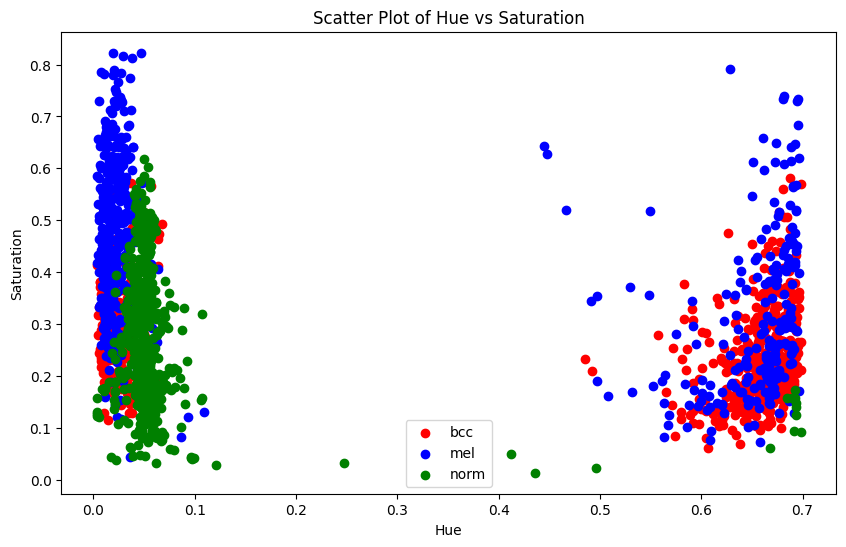

In [31]:
import matplotlib.pyplot as plt

# Memilih fitur untuk sumbu x dan sumbu y
feature_x = 'Hue'
feature_y = 'Saturation'

# Menentukan warna untuk setiap kelas
colors = {'bcc': 'red', 'mel': 'blue', 'norm': 'green'}

# Menampilkan scatter plot
plt.figure(figsize=(10, 6))
for label, color in colors.items():
    mask = hsv_df['Class'] == label
    plt.scatter(hsv_df[mask][feature_x], hsv_df[mask][feature_y], c=color, label=label)

plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.title('Scatter Plot of {} vs {}'.format(feature_x, feature_y))
plt.legend()
plt.show()



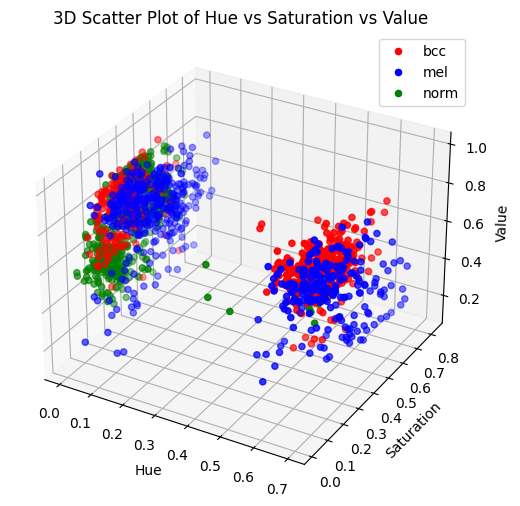

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Memilih fitur untuk sumbu x, y, dan z
feature_x = 'Hue'
feature_y = 'Saturation'
feature_z = 'Value'

# Menentukan warna untuk setiap kelas
colors = {'bcc': 'red', 'mel': 'blue', 'norm': 'green'}

# Menampilkan scatter plot dalam tiga dimensi
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
for label, color in colors.items():
    mask = hsv_df['Class'] == label
    ax.scatter(hsv_df[mask][feature_x], hsv_df[mask][feature_y], hsv_df[mask][feature_z], c=color, label=label)

ax.set_xlabel(feature_x)
ax.set_ylabel(feature_y)
ax.set_zlabel(feature_z)
ax.set_title('3D Scatter Plot of {} vs {} vs {}'.format(feature_x, feature_y, feature_z))
plt.legend()
plt.show()


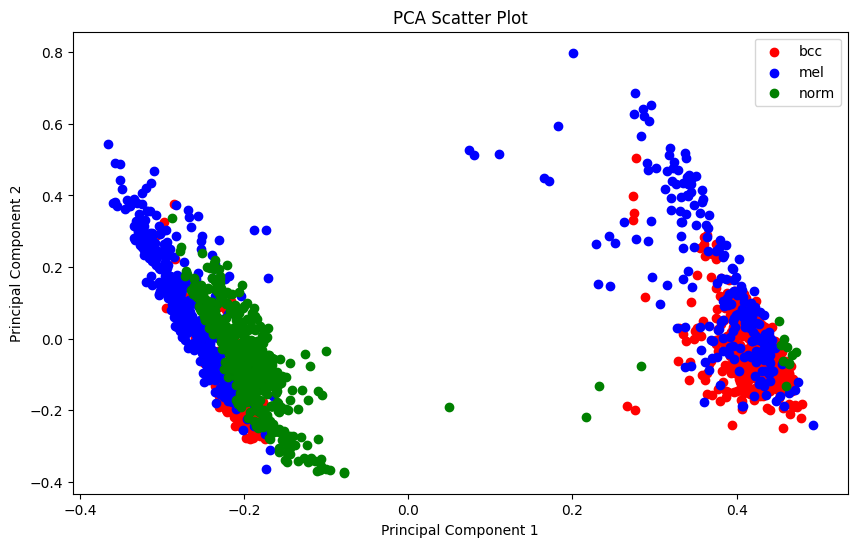

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Normalisasi data (jika diperlukan)
# Misalnya, Anda dapat menggunakan StandardScaler:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Melakukan PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_hsv)

# Visualisasi data hasil PCA
plt.figure(figsize=(10, 6))
for label, color in colors.items():
    mask = hsv_df['Class'] == label
    plt.scatter(X_pca[mask][:, 0], X_pca[mask][:, 1], c=color, label=label)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.legend()
plt.show()

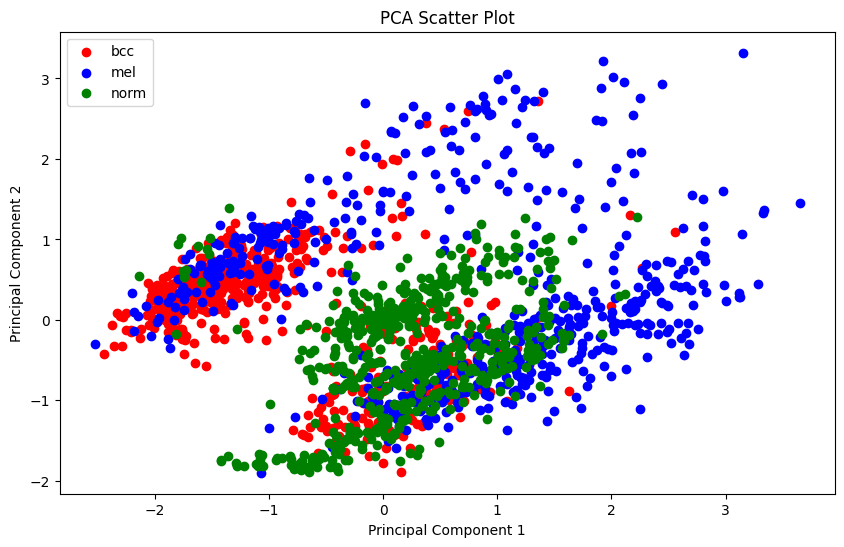

In [34]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Membuat pipeline dengan langkah-langkah StandardScaler dan PCA
pca = PCA(n_components=3)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])

# Melakukan transformasi menggunakan pipeline
X_pca = pipe.fit_transform(X_hsv)

# Visualisasi data hasil PCA
plt.figure(figsize=(10, 6))
for label, color in colors.items():
    mask = hsv_df['Class'] == label
    plt.scatter(X_pca[mask][:, 0], X_pca[mask][:, 1], c=color, label=label)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.legend()
plt.show()

In [35]:
import os
import cv2

# Path ke folder dataset gambar
dataset_folder = 'D:\Tugas Akhir\Output Cropped Images'

# Path ke folder untuk menyimpan gambar hasil grayscale
grayscale_output_folder = 'D:\Tugas Akhir\Output Cropped Imaged Grayscale'

# Membuat folder output jika belum ada
os.makedirs(grayscale_output_folder, exist_ok=True)

# Iterasi melalui setiap baris dalam DataFrame fix_dx
for index, row in fix_dx.iterrows():
    # Muat gambar
    image = cv2.imread(row['path'])
    
    # Ubah gambar menjadi grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Simpan gambar grayscale
    grayscale_output_path = os.path.join(grayscale_output_folder, f'{row["image_id"]}.jpg')
    cv2.imwrite(grayscale_output_path, grayscale_image)

    print(f'Gambar {row["image_id"]} telah diproses dan disimpan di {grayscale_output_path}')

Gambar ISIC_0027976 telah diproses dan disimpan di D:\Tugas Akhir\Output Cropped Imaged Grayscale\ISIC_0027976.jpg
Gambar ISIC_0028238 telah diproses dan disimpan di D:\Tugas Akhir\Output Cropped Imaged Grayscale\ISIC_0028238.jpg
Gambar ISIC_0029755 telah diproses dan disimpan di D:\Tugas Akhir\Output Cropped Imaged Grayscale\ISIC_0029755.jpg
Gambar ISIC_0026321 telah diproses dan disimpan di D:\Tugas Akhir\Output Cropped Imaged Grayscale\ISIC_0026321.jpg
Gambar ISIC_0025467 telah diproses dan disimpan di D:\Tugas Akhir\Output Cropped Imaged Grayscale\ISIC_0025467.jpg
Gambar ISIC_0028807 telah diproses dan disimpan di D:\Tugas Akhir\Output Cropped Imaged Grayscale\ISIC_0028807.jpg
Gambar ISIC_0024673 telah diproses dan disimpan di D:\Tugas Akhir\Output Cropped Imaged Grayscale\ISIC_0024673.jpg
Gambar ISIC_0026574 telah diproses dan disimpan di D:\Tugas Akhir\Output Cropped Imaged Grayscale\ISIC_0026574.jpg
Gambar ISIC_0028495 telah diproses dan disimpan di D:\Tugas Akhir\Output Cropped

In [36]:
input_folder = 'D:\Tugas Akhir\Output Cropped Imaged Grayscale'

output_folder = 'D:\Tugas Akhir\Output Cropped Imaged Grayscale Grouping'
os.makedirs(output_folder, exist_ok=True)

for class_name in ['mel', 'bcc', 'norm']:
    class_folder = os.path.join(output_folder, class_name)
    os.makedirs(class_folder, exist_ok=True)

for index, row in fix_dx.iterrows():
    image_id = row['image_id']
    class_name = row['dx']
    input_image_path = os.path.join(input_folder, f'{image_id}.jpg')

    output_image_path = os.path.join(output_folder, class_name, f'{image_id}.jpg')

    shutil.copy(input_image_path, output_image_path)

    print(f'Gambar {image_id} telah dipindahkan ke folder {class_name}')

Gambar ISIC_0027976 telah dipindahkan ke folder bcc
Gambar ISIC_0028238 telah dipindahkan ke folder bcc
Gambar ISIC_0029755 telah dipindahkan ke folder bcc
Gambar ISIC_0026321 telah dipindahkan ke folder bcc
Gambar ISIC_0025467 telah dipindahkan ke folder bcc
Gambar ISIC_0028807 telah dipindahkan ke folder bcc
Gambar ISIC_0024673 telah dipindahkan ke folder bcc
Gambar ISIC_0026574 telah dipindahkan ke folder bcc
Gambar ISIC_0028495 telah dipindahkan ke folder bcc
Gambar ISIC_0030574 telah dipindahkan ke folder bcc
Gambar ISIC_0031585 telah dipindahkan ke folder bcc
Gambar ISIC_0024590 telah dipindahkan ke folder bcc
Gambar ISIC_0025932 telah dipindahkan ke folder bcc
Gambar ISIC_0028747 telah dipindahkan ke folder bcc
Gambar ISIC_0030446 telah dipindahkan ke folder bcc
Gambar ISIC_0031527 telah dipindahkan ke folder bcc
Gambar ISIC_0031166 telah dipindahkan ke folder bcc
Gambar ISIC_0028693 telah dipindahkan ke folder bcc
Gambar ISIC_0030893 telah dipindahkan ke folder bcc
Gambar ISIC_

In [37]:
import cv2
import os
import pandas as pd
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.cluster import KMeans
from collections import Counter

# Daftar properti GLCM yang akan diekstraksi
glcm_properties = ['dissimilarity', 'correlation', 'homogeneity', 'contrast', 'ASM', 'energy']

# Fungsi untuk ekstraksi fitur GLCM
def extract_features_glcm(image_path):
    # Baca gambar dan konversi ke grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Hitung GLCM
    glcm = graycomatrix(img, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True)
    
    # Ekstraksi fitur GLCM
    glcm_props = [prop for name in glcm_properties for prop in graycoprops(glcm, name)[0]]
    
    return glcm_props

# Path ke folder yang berisi gambar-gambar
folder_path = 'D:\Tugas Akhir\Output Cropped Imaged Grayscale Grouping'

# List untuk menyimpan hasil ekstraksi fitur GLCM
glcm_features_list = []

# Iterasi melalui setiap folder (kelas)
for class_name in os.listdir(folder_path):
    class_folder = os.path.join(folder_path, class_name)
    # Iterasi melalui setiap gambar dalam folder kelas
    for filename in os.listdir(class_folder):
        image_path = os.path.join(class_folder, filename)
        # Ekstraksi fitur GLCM
        glcm_features = extract_features_glcm(image_path)
        # Tambahkan hasil ekstraksi fitur ke dalam list
        glcm_features_list.append((class_name, *glcm_features))  # Menambahkan nama kelas di depan fitur GLCM

# Membuat DataFrame dari list hasil ekstraksi fitur GLCM
columns = ['Target'] + [f'{prop}_{angle}' for prop in glcm_properties for angle in ['0', '45', '90', '135']]  # Membuat nama kolom
glcm_df = pd.DataFrame(glcm_features_list, columns=columns)

# Menampilkan DataFrame
glcm_df

Target  dissimilarity_0  dissimilarity_45  dissimilarity_90  \
0       bcc         4.509269          6.262724          4.995936   
1       bcc         6.117012          8.534276          6.651005   
2       bcc         6.230317          7.770234          6.408543   
3       bcc         4.261963          5.786190          4.414202   
4       bcc         2.629598          3.764031          2.734225   
...     ...              ...               ...               ...   
1720   norm         6.321148          7.114259          6.016536   
1721   norm         7.164538          8.196083          7.089206   
1722   norm         6.241412          7.269943          6.332559   
1723   norm         5.077875          5.933037          5.240611   
1724   norm         4.071028          4.864043          3.896381   

      dissimilarity_135  correlation_0  correlation_45  correlation_90  \
0              6.268375       0.976178        0.956656        0.971692   
1              8.670977       0.959850        0.923066        0.953173   
2              8.099504       0.952841        0.928465        0.951604   
3              5.530802       0.988059        0.978776        0.987743   
4              3.369615       0.988811        0.976943        0.987883   
...                 ...            ...             ...             ...   
1720           7.161777       0.742384        0.672668        0.765669   
1721           8.263931       0.730118        0.642624        0.735177   
1722           7.282954       0.730507        0.631515        0.722326   
1723           6.104084       0.731050        0.630821        0.710482   
1724           4.884293       0.612468        0.454854        0.653245   

      correlation_135  homogeneity_0  ...  contrast_90  contrast_135  \
0            0.954208       0.267159  ...    59.257107     95.839007   
1            0.920366       0.183355  ...    87.746256    148.888797   
2            0.921412       0.190226  ...    87.455322    142.740468   
3            0.980623       0.352250  ...    54.562336     86.254082   
4            0.982524       0.377929  ...    18.923669     27.357615   
...               ...            ...  ...          ...           ...   
1720         0.667017       0.150781  ...    60.653107     86.102958   
1721         0.636870       0.135964  ...    85.648583    117.200969   
1722         0.626634       0.153975  ...    67.402827     90.716966   
1723         0.607753       0.183981  ...    46.262192     62.685636   
1724         0.449473       0.233435  ...    28.614670     45.449999   

         ASM_0    ASM_45    ASM_90   ASM_135  energy_0  energy_45  energy_90  \
0     0.000820  0.000572  0.000691  0.000576  0.028642   0.023907   0.026288   
1     0.000413  0.000299  0.000375  0.000295  0.020313   0.017284   0.019366   
2     0.000736  0.000622  0.000728  0.000600  0.027125   0.024947   0.026980   
3     0.001163  0.000822  0.000964  0.000811  0.034103   0.028668   0.031056   
4     0.002356  0.001715  0.002221  0.001783  0.048539   0.041411   0.047130   
...        ...       ...       ...       ...       ...        ...        ...   
1720  0.001015  0.000922  0.001058  0.000917  0.031863   0.030371   0.032534   
1721  0.000807  0.000725  0.000812  0.000721  0.028399   0.026928   0.028490   
1722  0.001032  0.000918  0.001022  0.000918  0.032132   0.030295   0.031970   
1723  0.001591  0.001407  0.001561  0.001376  0.039883   0.037512   0.039506   
1724  0.003261  0.002852  0.003379  0.002844  0.057103   0.053404   0.058128   

      energy_135  
0       0.024004  
1       0.017179  
2       0.024499  
3       0.028483  
4       0.042230  
...          ...  
1720    0.030277  
1721    0.026858  
1722    0.030297  
1723    0.037092  
1724    0.053330  

[1725 rows x 25 columns]

In [38]:
# Reset indeks jika diperlukan
hsv_df.reset_index(inplace=True, drop=True)
glcm_df.reset_index(inplace=True, drop=True)

# Gabungkan dataframe menggunakan concat
combined_df = pd.concat([hsv_df, glcm_df], axis=1, join="inner")

In [39]:
combined_df

Hue  Saturation     Value Class Target  dissimilarity_0  \
0     0.019982    0.204298  0.686401   bcc    bcc         4.509269   
1     0.639909    0.129738  0.637473   bcc    bcc         6.117012   
2     0.037025    0.424397  0.693088   bcc    bcc         6.230317   
3     0.032564    0.248842  0.605846   bcc    bcc         4.261963   
4     0.033477    0.337976  0.664241   bcc    bcc         2.629598   
...        ...         ...       ...   ...    ...              ...   
1720  0.411826    0.049934  0.810997  norm   norm         6.321148   
1721  0.496209    0.021845  0.639922  norm   norm         7.164538   
1722  0.043666    0.066947  0.599626  norm   norm         6.241412   
1723  0.045770    0.046773  0.681009  norm   norm         5.077875   
1724  0.049633    0.080457  0.509105  norm   norm         4.071028   

      dissimilarity_45  dissimilarity_90  dissimilarity_135  correlation_0  \
0             6.262724          4.995936           6.268375       0.976178   
1             8.534276          6.651005           8.670977       0.959850   
2             7.770234          6.408543           8.099504       0.952841   
3             5.786190          4.414202           5.530802       0.988059   
4             3.764031          2.734225           3.369615       0.988811   
...                ...               ...                ...            ...   
1720          7.114259          6.016536           7.161777       0.742384   
1721          8.196083          7.089206           8.263931       0.730118   
1722          7.269943          6.332559           7.282954       0.730507   
1723          5.933037          5.240611           6.104084       0.731050   
1724          4.864043          3.896381           4.884293       0.612468   

      ...  contrast_90  contrast_135     ASM_0    ASM_45    ASM_90   ASM_135  \
0     ...    59.257107     95.839007  0.000820  0.000572  0.000691  0.000576   
1     ...    87.746256    148.888797  0.000413  0.000299  0.000375  0.000295   
2     ...    87.455322    142.740468  0.000736  0.000622  0.000728  0.000600   
3     ...    54.562336     86.254082  0.001163  0.000822  0.000964  0.000811   
4     ...    18.923669     27.357615  0.002356  0.001715  0.002221  0.001783   
...   ...          ...           ...       ...       ...       ...       ...   
1720  ...    60.653107     86.102958  0.001015  0.000922  0.001058  0.000917   
1721  ...    85.648583    117.200969  0.000807  0.000725  0.000812  0.000721   
1722  ...    67.402827     90.716966  0.001032  0.000918  0.001022  0.000918   
1723  ...    46.262192     62.685636  0.001591  0.001407  0.001561  0.001376   
1724  ...    28.614670     45.449999  0.003261  0.002852  0.003379  0.002844   

      energy_0  energy_45  energy_90  energy_135  
0     0.028642   0.023907   0.026288    0.024004  
1     0.020313   0.017284   0.019366    0.017179  
2     0.027125   0.024947   0.026980    0.024499  
3     0.034103   0.028668   0.031056    0.028483  
4     0.048539   0.041411   0.047130    0.042230  
...        ...        ...        ...         ...  
1720  0.031863   0.030371   0.032534    0.030277  
1721  0.028399   0.026928   0.028490    0.026858  
1722  0.032132   0.030295   0.031970    0.030297  
1723  0.039883   0.037512   0.039506    0.037092  
1724  0.057103   0.053404   0.058128    0.053330  

[1725 rows x 29 columns]

In [40]:
# Simpan kolom "Class" ke dalam variabel
class_column = combined_df.pop("Class")

# Sisipkan kolom "Class" di sebelah kanan
combined_df.insert(len(combined_df.columns), "Class", class_column)
combined_df

Hue  Saturation     Value Target  dissimilarity_0  \
0     0.019982    0.204298  0.686401    bcc         4.509269   
1     0.639909    0.129738  0.637473    bcc         6.117012   
2     0.037025    0.424397  0.693088    bcc         6.230317   
3     0.032564    0.248842  0.605846    bcc         4.261963   
4     0.033477    0.337976  0.664241    bcc         2.629598   
...        ...         ...       ...    ...              ...   
1720  0.411826    0.049934  0.810997   norm         6.321148   
1721  0.496209    0.021845  0.639922   norm         7.164538   
1722  0.043666    0.066947  0.599626   norm         6.241412   
1723  0.045770    0.046773  0.681009   norm         5.077875   
1724  0.049633    0.080457  0.509105   norm         4.071028   

      dissimilarity_45  dissimilarity_90  dissimilarity_135  correlation_0  \
0             6.262724          4.995936           6.268375       0.976178   
1             8.534276          6.651005           8.670977       0.959850   
2             7.770234          6.408543           8.099504       0.952841   
3             5.786190          4.414202           5.530802       0.988059   
4             3.764031          2.734225           3.369615       0.988811   
...                ...               ...                ...            ...   
1720          7.114259          6.016536           7.161777       0.742384   
1721          8.196083          7.089206           8.263931       0.730118   
1722          7.269943          6.332559           7.282954       0.730507   
1723          5.933037          5.240611           6.104084       0.731050   
1724          4.864043          3.896381           4.884293       0.612468   

      correlation_45  ...  contrast_135     ASM_0    ASM_45    ASM_90  \
0           0.956656  ...     95.839007  0.000820  0.000572  0.000691   
1           0.923066  ...    148.888797  0.000413  0.000299  0.000375   
2           0.928465  ...    142.740468  0.000736  0.000622  0.000728   
3           0.978776  ...     86.254082  0.001163  0.000822  0.000964   
4           0.976943  ...     27.357615  0.002356  0.001715  0.002221   
...              ...  ...           ...       ...       ...       ...   
1720        0.672668  ...     86.102958  0.001015  0.000922  0.001058   
1721        0.642624  ...    117.200969  0.000807  0.000725  0.000812   
1722        0.631515  ...     90.716966  0.001032  0.000918  0.001022   
1723        0.630821  ...     62.685636  0.001591  0.001407  0.001561   
1724        0.454854  ...     45.449999  0.003261  0.002852  0.003379   

       ASM_135  energy_0  energy_45  energy_90  energy_135  Class  
0     0.000576  0.028642   0.023907   0.026288    0.024004    bcc  
1     0.000295  0.020313   0.017284   0.019366    0.017179    bcc  
2     0.000600  0.027125   0.024947   0.026980    0.024499    bcc  
3     0.000811  0.034103   0.028668   0.031056    0.028483    bcc  
4     0.001783  0.048539   0.041411   0.047130    0.042230    bcc  
...        ...       ...        ...        ...         ...    ...  
1720  0.000917  0.031863   0.030371   0.032534    0.030277   norm  
1721  0.000721  0.028399   0.026928   0.028490    0.026858   norm  
1722  0.000918  0.032132   0.030295   0.031970    0.030297   norm  
1723  0.001376  0.039883   0.037512   0.039506    0.037092   norm  
1724  0.002844  0.057103   0.053404   0.058128    0.053330   norm  

[1725 rows x 29 columns]

In [41]:
# Menghapus kolom "Target"
feature_df = combined_df.drop(columns=['Target'])
feature_df

Hue  Saturation     Value  dissimilarity_0  dissimilarity_45  \
0     0.019982    0.204298  0.686401         4.509269          6.262724   
1     0.639909    0.129738  0.637473         6.117012          8.534276   
2     0.037025    0.424397  0.693088         6.230317          7.770234   
3     0.032564    0.248842  0.605846         4.261963          5.786190   
4     0.033477    0.337976  0.664241         2.629598          3.764031   
...        ...         ...       ...              ...               ...   
1720  0.411826    0.049934  0.810997         6.321148          7.114259   
1721  0.496209    0.021845  0.639922         7.164538          8.196083   
1722  0.043666    0.066947  0.599626         6.241412          7.269943   
1723  0.045770    0.046773  0.681009         5.077875          5.933037   
1724  0.049633    0.080457  0.509105         4.071028          4.864043   

      dissimilarity_90  dissimilarity_135  correlation_0  correlation_45  \
0             4.995936           6.268375       0.976178        0.956656   
1             6.651005           8.670977       0.959850        0.923066   
2             6.408543           8.099504       0.952841        0.928465   
3             4.414202           5.530802       0.988059        0.978776   
4             2.734225           3.369615       0.988811        0.976943   
...                ...                ...            ...             ...   
1720          6.016536           7.161777       0.742384        0.672668   
1721          7.089206           8.263931       0.730118        0.642624   
1722          6.332559           7.282954       0.730507        0.631515   
1723          5.240611           6.104084       0.731050        0.630821   
1724          3.896381           4.884293       0.612468        0.454854   

      correlation_90  ...  contrast_135     ASM_0    ASM_45    ASM_90  \
0           0.971692  ...     95.839007  0.000820  0.000572  0.000691   
1           0.953173  ...    148.888797  0.000413  0.000299  0.000375   
2           0.951604  ...    142.740468  0.000736  0.000622  0.000728   
3           0.987743  ...     86.254082  0.001163  0.000822  0.000964   
4           0.987883  ...     27.357615  0.002356  0.001715  0.002221   
...              ...  ...           ...       ...       ...       ...   
1720        0.765669  ...     86.102958  0.001015  0.000922  0.001058   
1721        0.735177  ...    117.200969  0.000807  0.000725  0.000812   
1722        0.722326  ...     90.716966  0.001032  0.000918  0.001022   
1723        0.710482  ...     62.685636  0.001591  0.001407  0.001561   
1724        0.653245  ...     45.449999  0.003261  0.002852  0.003379   

       ASM_135  energy_0  energy_45  energy_90  energy_135  Class  
0     0.000576  0.028642   0.023907   0.026288    0.024004    bcc  
1     0.000295  0.020313   0.017284   0.019366    0.017179    bcc  
2     0.000600  0.027125   0.024947   0.026980    0.024499    bcc  
3     0.000811  0.034103   0.028668   0.031056    0.028483    bcc  
4     0.001783  0.048539   0.041411   0.047130    0.042230    bcc  
...        ...       ...        ...        ...         ...    ...  
1720  0.000917  0.031863   0.030371   0.032534    0.030277   norm  
1721  0.000721  0.028399   0.026928   0.028490    0.026858   norm  
1722  0.000918  0.032132   0.030295   0.031970    0.030297   norm  
1723  0.001376  0.039883   0.037512   0.039506    0.037092   norm  
1724  0.002844  0.057103   0.053404   0.058128    0.053330   norm  

[1725 rows x 28 columns]

In [42]:
import pandas as pd

# Simpan dataframe ke dalam file Excel
feature_df.to_excel('feature.xlsx', index=False)

print("File Excel berhasil dibuat.")


File Excel berhasil dibuat.


# Classification

## Before

### Split Data

In [49]:
X = feature_df.drop('Class', axis=1).values
y = feature_df['Class'].values
print(y)
print(y.shape)

['bcc' 'bcc' 'bcc' ... 'norm' 'norm' 'norm']
(1725,)


In [50]:
# Konversi label kategori menjadi one-hot encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)

# from sklearn.preprocessing import LabelEncoder

# # Membuat objek LabelEncoder
# label_encoder = LabelEncoder()

# # Mengkodekan kelas-kelas menjadi angka
# y = label_encoder.fit_transform(y)

# Tampilkan hasilnya
print(y)
print(y.shape)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
(1725, 3)


In [51]:
print(y)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [52]:
print(X.shape)
print(y.shape)

(1725, 27)
(1725, 3)


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Menampilkan jumlah data dalam setiap set
print("Jumlah data latih:", X_train.shape[0])
print("Jumlah data uji:", X_test.shape[0])

Jumlah data latih: 1380
Jumlah data uji: 345


In [54]:
print(X_train.shape)
print(y_train.shape)

(1380, 27)
(1380, 3)


In [55]:
input_shape = (X_train.shape[1], 1)
input_shape

(27, 1)

### CNN

In [48]:
import tensorflow as tf

def create_cnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(128, 3, activation='relu'),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_cnn = create_cnn_model(input_shape, 3)
model_cnn.summary()



C:\Users\asus\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 25, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 10, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 3, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,491 (154.26 KB)

 Trainable params: 39,491 (154.26 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
from sklearn.model_selection import KFold
import numpy as np
import os

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Menyimpan hasil setiap fold
fold_no = 1
accuracy_per_fold = []
loss_per_fold = []

# Membuat direktori untuk menyimpan model jika belum ada
os.makedirs('models_cnn', exist_ok=True)

for train_index, val_index in kf.split(X_train):
    print(f'Fold {fold_no}')
    
    # Membagi data
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Membuat model baru
    model_cnn = create_cnn_model(input_shape, 3)
    
    # Melatih model
    cnn = model_cnn.fit(X_train_fold, y_train_fold, batch_size=64, epochs=50, validation_data=(X_val_fold, y_val_fold), verbose=2)
    
    # Evaluasi model pada data validasi fold
    scores = model_cnn.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Score for fold {fold_no}: {model_cnn.metrics_names[0]} of {scores[0]}; {model_cnn.metrics_names[1]} of {scores[1]*100}%')
    accuracy_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Simpan model
    model_filename = f'models_cnn/model_cnn_fold_{fold_no}.h5'
    model_cnn.save(model_filename)
    print(f'Model for fold {fold_no} saved as {model_filename}')
    
    fold_no += 1

# Menampilkan hasil akhir
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracy_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


Fold 1
Epoch 1/50
18/18 - 3s - 160ms/step - accuracy: 0.3705 - loss: 1.1559 - val_accuracy: 0.5290 - val_loss: 1.0647
Epoch 2/50
18/18 - 0s - 10ms/step - accuracy: 0.4438 - loss: 1.1344 - val_accuracy: 0.2971 - val_loss: 1.1420
Epoch 3/50
18/18 - 0s - 10ms/step - accuracy: 0.5063 - loss: 1.0421 - val_accuracy: 0.4674 - val_loss: 1.0412
Epoch 4/50
18/18 - 0s - 9ms/step - accuracy: 0.5082 - loss: 1.0185 - val_accuracy: 0.5181 - val_loss: 1.0310
Epoch 5/50
18/18 - 0s - 9ms/step - accuracy: 0.5553 - loss: 0.9776 - val_accuracy: 0.5326 - val_loss: 1.0099
Epoch 6/50
18/18 - 0s - 10ms/step - accuracy: 0.5770 - loss: 0.9463 - val_accuracy: 0.5072 - val_loss: 1.0487
Epoch 7/50
18/18 - 0s - 12ms/step - accuracy: 0.5589 - loss: 0.9566 - val_accuracy: 0.3913 - val_loss: 1.0618
Epoch 8/50
18/18 - 0s - 13ms/step - accuracy: 0.5788 - loss: 0.9126 - val_accuracy: 0.5688 - val_loss: 0.9502
Epoch 9/50
18/18 - 0s - 13ms/step - accuracy: 0.6005 - loss: 0.8991 - val_accuracy: 0.5471 - val_loss: 0.9809
Epoc

Score for fold 1: loss of 0.5988892912864685; compile_metrics of 76.0869562625885%
Model for fold 1 saved as models_cnn/model_cnn_fold_1.h5
Fold 2
Epoch 1/50
18/18 - 3s - 155ms/step - accuracy: 0.3524 - loss: 1.2793 - val_accuracy: 0.3442 - val_loss: 1.1021
Epoch 2/50
18/18 - 0s - 13ms/step - accuracy: 0.4873 - loss: 1.0740 - val_accuracy: 0.4493 - val_loss: 1.0540
Epoch 3/50
18/18 - 0s - 20ms/step - accuracy: 0.4583 - loss: 1.0574 - val_accuracy: 0.5616 - val_loss: 1.0493
Epoch 4/50
18/18 - 0s - 11ms/step - accuracy: 0.5236 - loss: 1.0394 - val_accuracy: 0.5616 - val_loss: 1.0446
Epoch 5/50
18/18 - 0s - 12ms/step - accuracy: 0.5661 - loss: 1.0182 - val_accuracy: 0.4203 - val_loss: 1.0291
Epoch 6/50
18/18 - 0s - 13ms/step - accuracy: 0.5435 - loss: 1.0087 - val_accuracy: 0.5652 - val_loss: 1.0002
Epoch 7/50
18/18 - 0s - 10ms/step - accuracy: 0.5571 - loss: 0.9886 - val_accuracy: 0.5290 - val_loss: 0.9849
Epoch 8/50
18/18 - 0s - 10ms/step - accuracy: 0.5525 - loss: 0.9753 - val_accuracy

Score for fold 2: loss of 0.5509017705917358; compile_metrics of 80.4347813129425%
Model for fold 2 saved as models_cnn/model_cnn_fold_2.h5
Fold 3
Epoch 1/50
18/18 - 2s - 127ms/step - accuracy: 0.3560 - loss: 1.2040 - val_accuracy: 0.4203 - val_loss: 1.2149
Epoch 2/50
18/18 - 0s - 9ms/step - accuracy: 0.4103 - loss: 1.0983 - val_accuracy: 0.4203 - val_loss: 1.0660
Epoch 3/50
18/18 - 0s - 8ms/step - accuracy: 0.4692 - loss: 1.0516 - val_accuracy: 0.4420 - val_loss: 1.0726
Epoch 4/50
18/18 - 0s - 8ms/step - accuracy: 0.4891 - loss: 1.0447 - val_accuracy: 0.3949 - val_loss: 1.0683
Epoch 5/50
18/18 - 0s - 8ms/step - accuracy: 0.4909 - loss: 1.0318 - val_accuracy: 0.4819 - val_loss: 1.0138
Epoch 6/50
18/18 - 0s - 8ms/step - accuracy: 0.5371 - loss: 1.0056 - val_accuracy: 0.5290 - val_loss: 0.9872
Epoch 7/50
18/18 - 0s - 8ms/step - accuracy: 0.5281 - loss: 1.0068 - val_accuracy: 0.4601 - val_loss: 0.9986
Epoch 8/50
18/18 - 0s - 8ms/step - accuracy: 0.5435 - loss: 0.9568 - val_accuracy: 0.572

Score for fold 3: loss of 0.45167431235313416; compile_metrics of 84.05796885490417%
Model for fold 3 saved as models_cnn/model_cnn_fold_3.h5
Fold 4
Epoch 1/50
18/18 - 2s - 110ms/step - accuracy: 0.3496 - loss: 1.2611 - val_accuracy: 0.4239 - val_loss: 1.0948
Epoch 2/50
18/18 - 0s - 8ms/step - accuracy: 0.4547 - loss: 1.0894 - val_accuracy: 0.4638 - val_loss: 1.1050
Epoch 3/50
18/18 - 0s - 8ms/step - accuracy: 0.4946 - loss: 1.0646 - val_accuracy: 0.5833 - val_loss: 1.0300
Epoch 4/50
18/18 - 0s - 7ms/step - accuracy: 0.5652 - loss: 1.0211 - val_accuracy: 0.4130 - val_loss: 1.0587
Epoch 5/50
18/18 - 0s - 8ms/step - accuracy: 0.4583 - loss: 1.0571 - val_accuracy: 0.3768 - val_loss: 1.0801
Epoch 6/50
18/18 - 0s - 8ms/step - accuracy: 0.5127 - loss: 1.0107 - val_accuracy: 0.5652 - val_loss: 0.9708
Epoch 7/50
18/18 - 0s - 8ms/step - accuracy: 0.5670 - loss: 0.9783 - val_accuracy: 0.5145 - val_loss: 0.9897
Epoch 8/50
18/18 - 0s - 8ms/step - accuracy: 0.5236 - loss: 0.9699 - val_accuracy: 0.5

Score for fold 4: loss of 0.5079823136329651; compile_metrics of 79.71014380455017%
Model for fold 4 saved as models_cnn/model_cnn_fold_4.h5
Fold 5
Epoch 1/50
18/18 - 2s - 109ms/step - accuracy: 0.4149 - loss: 1.1376 - val_accuracy: 0.5254 - val_loss: 1.0818
Epoch 2/50
18/18 - 0s - 8ms/step - accuracy: 0.5100 - loss: 1.0576 - val_accuracy: 0.5181 - val_loss: 1.0393
Epoch 3/50
18/18 - 0s - 8ms/step - accuracy: 0.5625 - loss: 1.0162 - val_accuracy: 0.5507 - val_loss: 1.0445
Epoch 4/50
18/18 - 0s - 7ms/step - accuracy: 0.5516 - loss: 1.0082 - val_accuracy: 0.5399 - val_loss: 1.0433
Epoch 5/50
18/18 - 0s - 7ms/step - accuracy: 0.5562 - loss: 0.9951 - val_accuracy: 0.5833 - val_loss: 0.9725
Epoch 6/50
18/18 - 0s - 8ms/step - accuracy: 0.5634 - loss: 0.9777 - val_accuracy: 0.5435 - val_loss: 0.9299
Epoch 7/50
18/18 - 0s - 8ms/step - accuracy: 0.5625 - loss: 0.9532 - val_accuracy: 0.5290 - val_loss: 1.0255
Epoch 8/50
18/18 - 0s - 8ms/step - accuracy: 0.5290 - loss: 0.9898 - val_accuracy: 0.63

Score for fold 5: loss of 0.3709459900856018; compile_metrics of 82.97101259231567%
Model for fold 5 saved as models_cnn/model_cnn_fold_5.h5
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.5988892912864685 - Accuracy: 76.0869562625885%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.5509017705917358 - Accuracy: 80.4347813129425%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.45167431235313416 - Accuracy: 84.05796885490417%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.5079823136329651 - Accuracy: 79.71014380455017%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.3709459900856018 - Accuracy: 82.97101259231567%
------------------------------------------------------------------------

In [53]:
# Menampilkan akurasi per fold
print('Data Training Accuracy per fold:')
for i in range(len(accuracy_per_fold)):
    print(f'Fold {i+1}: {accuracy_per_fold[i]}%')


Data Training Accuracy per fold:
Fold 1: 76.0869562625885%
Fold 2: 80.4347813129425%
Fold 3: 84.05796885490417%
Fold 4: 79.71014380455017%
Fold 5: 82.97101259231567%


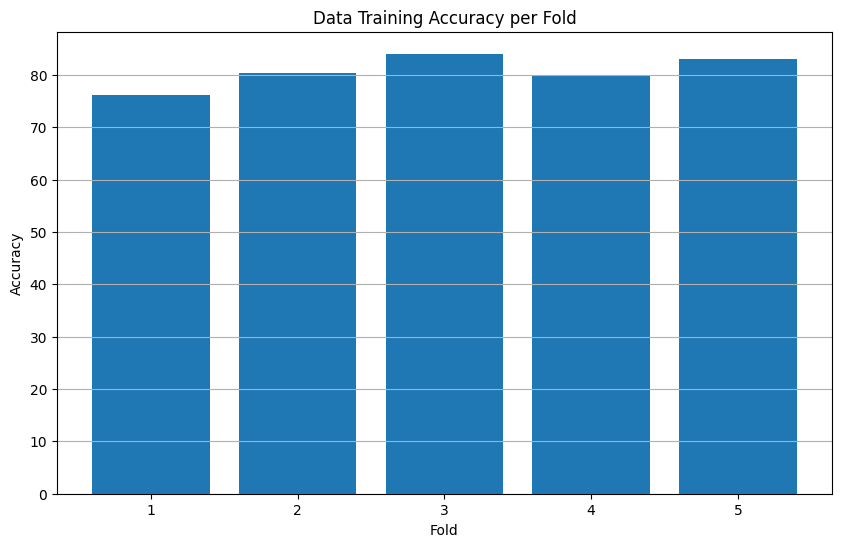

In [54]:
import matplotlib.pyplot as plt

# Buat figure dengan ukuran yang diinginkan
plt.figure(figsize=(10, 6))

# Buat grafik batang
plt.bar(range(1, len(accuracy_per_fold) + 1), accuracy_per_fold)

# Tambahkan judul dan label sumbu
plt.title('Data Training Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')

# Tambahkan tanda pada sumbu x sesuai jumlah fold
plt.xticks(range(1, len(accuracy_per_fold) + 1))

# Tambahkan grid untuk memudahkan pembacaan nilai
plt.grid(True, axis='y')

# Tampilkan grafik
plt.show()

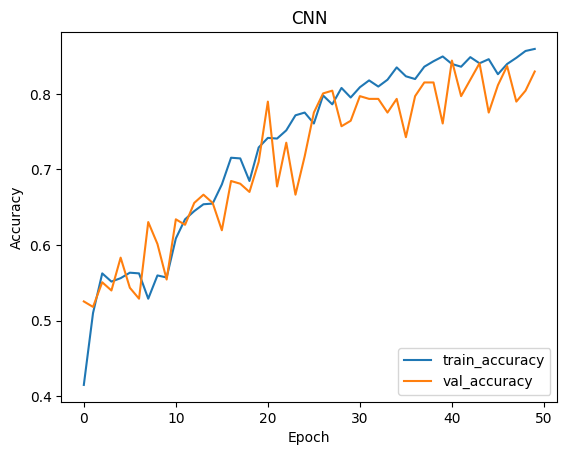

In [55]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('CNN')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

# Gunakan fungsi plot_learning_curves dengan parameter objek history dari model.fit
plot_learning_curves(cnn)

In [56]:
import numpy as np
from keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report
import shutil

# Asumsikan X_test dan y_test adalah dataset yang digunakan untuk evaluasi
# Anda harus mengganti ini dengan data yang sesuai

# Jumlah fold yang digunakan selama cross-validation
n_folds = 5

# List untuk menyimpan hasil evaluasi
accuracy_per_fold = []
loss_per_fold = []

# Variabel untuk melacak model dengan akurasi terbaik
best_accuracy = 0.0
best_model_filename = None

for fold_no in range(1, n_folds + 1):
    # Membuat path ke model yang disimpan
    model_filename = f'models_cnn/model_cnn_fold_{fold_no}.h5'
    
    # Memuat model
    model = load_model(model_filename)
    
    # Evaluasi model pada data uji
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'Fold {fold_no} - Loss: {loss} - Accuracy: {accuracy * 100}%')
    accuracy_per_fold.append(accuracy * 100)
    loss_per_fold.append(loss)
    
    # Cek apakah model saat ini adalah yang terbaik
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_filename = model_filename

    # Prediksi label menggunakan model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)  # Bentuk one-hot encoded

    # Hitung accuracy score
    acc_score = accuracy_score(y_true, y_pred_classes)
    print(f'Model Evaluate Accuracy Score for fold {fold_no}: {acc_score * 100}%')

    # Laporan klasifikasi
    print(f'Classification Report for fold {fold_no}:\n', classification_report(y_true, y_pred_classes))

# Menampilkan hasil akhir
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracy_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

# Menyimpan model dengan akurasi terbaik
if best_model_filename:
    shutil.copy(best_model_filename, 'model1.h5')
    print(f'Model with the best accuracy saved as model1.h5 with accuracy: {best_accuracy * 100}%')

Fold 1 - Loss: 0.477418452501297 - Accuracy: 80.86956739425659%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Model Evaluate Accuracy Score for fold 1: 80.8695652173913%
Classification Report for fold 1:
               precision    recall  f1-score   support

           0       0.73      0.87      0.79       126
           1       0.84      0.57      0.68       109
           2       0.89      0.97      0.93       110

    accuracy                           0.81       345
   macro avg       0.82      0.80      0.80       345
weighted avg       0.82      0.81      0.80       345

Fold 2 - Loss: 0.5038913488388062 - Accuracy: 78.84057760238647%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Model Evaluate Accuracy Score for fold 2: 78.84057971014494%
Classification Report for fold 2:
               precision    recall  f1-score   support

           0       0.78      0.70      0.74       126
           1       0.65      0.76      0.70       109
           2       0.96      0.92      0.94       110

    accuracy                           0.79       345
   macro avg       0.80      0.79      0.79       345
weighted avg       0.80      0.79      0.79       345

Fold 3 - Loss: 0.40872639417648315 - Accuracy: 80.86956739425659%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Model Evaluate Accuracy Score for fold 3: 80.8695652173913%
Classification Report for fold 3:
               precision    recall  f1-score   support

           0       0.76      0.84      0.80       126
           1       0.74      0.69      0.71       109
           2       0.95      0.89      0.92       110

    accuracy                           0.81       345
   macro avg       0.81      0.81      0.81       345
weighted avg       0.81      0.81      0.81       345

Fold 4 - Loss: 0.475641667842865 - Accuracy: 78.2608687877655%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Model Evaluate Accuracy Score for fold 4: 78.26086956521739%
Classification Report for fold 4:
               precision    recall  f1-score   support

           0       0.71      0.75      0.73       126
           1       0.70      0.64      0.67       109
           2       0.94      0.95      0.95       110

    accuracy                           0.78       345
   macro avg       0.78      0.78      0.78       345
weighted avg       0.78      0.78      0.78       345

Fold 5 - Loss: 0.3508138358592987 - Accuracy: 86.37681007385254%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Model Evaluate Accuracy Score for fold 5: 86.37681159420289%
Classification Report for fold 5:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84       126
           1       0.82      0.77      0.79       109
           2       0.95      0.97      0.96       110

    accuracy                           0.86       345
   macro avg       0.86      0.86      0.86       

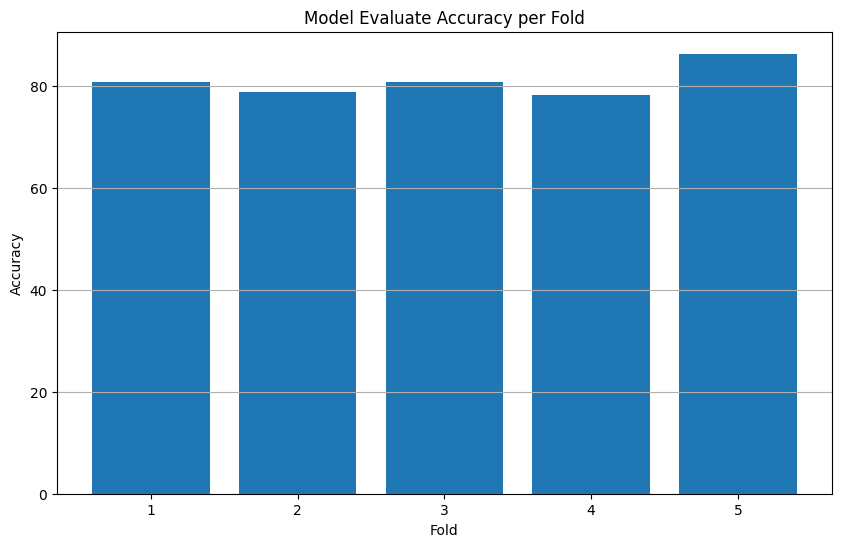

In [57]:
import matplotlib.pyplot as plt

# Buat figure dengan ukuran yang diinginkan
plt.figure(figsize=(10, 6))

# Buat grafik batang
plt.bar(range(1, len(accuracy_per_fold) + 1), accuracy_per_fold)

# Tambahkan judul dan label sumbu
plt.title('Model Evaluate Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')

# Tambahkan tanda pada sumbu x sesuai jumlah fold
plt.xticks(range(1, len(accuracy_per_fold) + 1))

# Tambahkan grid untuk memudahkan pembacaan nilai
plt.grid(True, axis='y')

# Tampilkan grafik
plt.show()

### LSTM

In [49]:
import tensorflow as tf

def create_lstm_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_lstm = create_lstm_model(input_shape, 3)

model_lstm.summary()

C:\Users\asus\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 27, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 27, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,275 (212.01 KB)

 Trainable params: 54,275 (212.01 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
from sklearn.model_selection import KFold
import numpy as np
import os

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Menyimpan hasil setiap fold
fold_no = 1
accuracy_per_fold = []
loss_per_fold = []

# Membuat direktori untuk menyimpan model jika belum ada
os.makedirs('models_lstm', exist_ok=True)

for train_index, val_index in kf.split(X_train):
    print(f'Fold {fold_no}')
    
    # Membagi data
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Membuat model baru
    model_lstm = create_lstm_model(input_shape, 3)
    
    # Melatih model
    lstm = model_lstm.fit(X_train_fold, y_train_fold, batch_size=64, epochs=50, validation_data=(X_val_fold, y_val_fold), verbose=2)
    
    # Evaluasi model pada data validasi fold
    scores = model_lstm.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Score for fold {fold_no}: {model_lstm.metrics_names[0]} of {scores[0]}; {model_lstm.metrics_names[1]} of {scores[1]*100}%')
    accuracy_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Simpan model
    model_filename = f'models_lstm/model_lstm_fold_{fold_no}.h5'
    model_lstm.save(model_filename)
    print(f'Model for fold {fold_no} saved as {model_filename}')
    
    fold_no += 1

# Menampilkan hasil akhir
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracy_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


Fold 1
Epoch 1/50
18/18 - 5s - 272ms/step - accuracy: 0.4420 - loss: 1.0641 - val_accuracy: 0.4638 - val_loss: 1.0293
Epoch 2/50
18/18 - 1s - 32ms/step - accuracy: 0.5009 - loss: 1.0016 - val_accuracy: 0.5507 - val_loss: 0.9704
Epoch 3/50
18/18 - 1s - 32ms/step - accuracy: 0.5072 - loss: 0.9846 - val_accuracy: 0.5362 - val_loss: 0.9785
Epoch 4/50
18/18 - 1s - 32ms/step - accuracy: 0.5027 - loss: 0.9829 - val_accuracy: 0.5471 - val_loss: 0.9757
Epoch 5/50
18/18 - 1s - 31ms/step - accuracy: 0.5072 - loss: 0.9816 - val_accuracy: 0.5326 - val_loss: 0.9798
Epoch 6/50
18/18 - 1s - 32ms/step - accuracy: 0.5036 - loss: 0.9778 - val_accuracy: 0.5290 - val_loss: 0.9872
Epoch 7/50
18/18 - 1s - 32ms/step - accuracy: 0.5100 - loss: 0.9746 - val_accuracy: 0.5399 - val_loss: 0.9673
Epoch 8/50
18/18 - 1s - 32ms/step - accuracy: 0.5127 - loss: 0.9757 - val_accuracy: 0.5254 - val_loss: 0.9796
Epoch 9/50
18/18 - 1s - 32ms/step - accuracy: 0.5127 - loss: 0.9761 - val_accuracy: 0.5543 - val_loss: 0.9623
Ep

Score for fold 1: loss of 0.7733736038208008; compile_metrics of 63.04348111152649%
Model for fold 1 saved as models_lstm/model_lstm_fold_1.h5
Fold 2
Epoch 1/50
18/18 - 4s - 219ms/step - accuracy: 0.4484 - loss: 1.0588 - val_accuracy: 0.4674 - val_loss: 1.0250
Epoch 2/50
18/18 - 0s - 26ms/step - accuracy: 0.4855 - loss: 1.0099 - val_accuracy: 0.5145 - val_loss: 0.9711
Epoch 3/50
18/18 - 0s - 26ms/step - accuracy: 0.5063 - loss: 0.9920 - val_accuracy: 0.5290 - val_loss: 0.9775
Epoch 4/50
18/18 - 0s - 26ms/step - accuracy: 0.5063 - loss: 0.9890 - val_accuracy: 0.5254 - val_loss: 0.9747
Epoch 5/50
18/18 - 0s - 25ms/step - accuracy: 0.5127 - loss: 0.9790 - val_accuracy: 0.5109 - val_loss: 0.9926
Epoch 6/50
18/18 - 0s - 25ms/step - accuracy: 0.5054 - loss: 0.9898 - val_accuracy: 0.5181 - val_loss: 0.9805
Epoch 7/50
18/18 - 0s - 27ms/step - accuracy: 0.5045 - loss: 0.9823 - val_accuracy: 0.5145 - val_loss: 0.9761
Epoch 8/50
18/18 - 0s - 26ms/step - accuracy: 0.5163 - loss: 0.9834 - val_accur

Score for fold 2: loss of 0.7117815017700195; compile_metrics of 71.37681245803833%
Model for fold 2 saved as models_lstm/model_lstm_fold_2.h5
Fold 3
Epoch 1/50
18/18 - 5s - 261ms/step - accuracy: 0.4312 - loss: 1.0618 - val_accuracy: 0.4891 - val_loss: 1.0148
Epoch 2/50
18/18 - 0s - 27ms/step - accuracy: 0.4991 - loss: 1.0045 - val_accuracy: 0.5254 - val_loss: 0.9634
Epoch 3/50
18/18 - 0s - 27ms/step - accuracy: 0.5045 - loss: 0.9959 - val_accuracy: 0.5181 - val_loss: 0.9678
Epoch 4/50
18/18 - 0s - 26ms/step - accuracy: 0.5172 - loss: 0.9786 - val_accuracy: 0.5290 - val_loss: 0.9544
Epoch 5/50
18/18 - 0s - 26ms/step - accuracy: 0.5163 - loss: 0.9739 - val_accuracy: 0.4239 - val_loss: 1.0157
Epoch 6/50
18/18 - 0s - 26ms/step - accuracy: 0.4991 - loss: 0.9909 - val_accuracy: 0.5290 - val_loss: 0.9640
Epoch 7/50
18/18 - 0s - 26ms/step - accuracy: 0.5208 - loss: 0.9754 - val_accuracy: 0.5290 - val_loss: 0.9514
Epoch 8/50
18/18 - 0s - 26ms/step - accuracy: 0.5154 - loss: 0.9766 - val_accur

Score for fold 3: loss of 0.879206657409668; compile_metrics of 56.88405632972717%
Model for fold 3 saved as models_lstm/model_lstm_fold_3.h5
Fold 4
Epoch 1/50
18/18 - 4s - 233ms/step - accuracy: 0.4466 - loss: 1.0686 - val_accuracy: 0.4928 - val_loss: 1.0123
Epoch 2/50
18/18 - 0s - 26ms/step - accuracy: 0.4891 - loss: 1.0135 - val_accuracy: 0.5036 - val_loss: 0.9697
Epoch 3/50
18/18 - 0s - 27ms/step - accuracy: 0.5127 - loss: 0.9850 - val_accuracy: 0.5217 - val_loss: 0.9549
Epoch 4/50
18/18 - 0s - 28ms/step - accuracy: 0.5127 - loss: 0.9824 - val_accuracy: 0.5290 - val_loss: 0.9552
Epoch 5/50
18/18 - 0s - 26ms/step - accuracy: 0.5109 - loss: 0.9861 - val_accuracy: 0.5036 - val_loss: 0.9563
Epoch 6/50
18/18 - 0s - 27ms/step - accuracy: 0.5127 - loss: 0.9773 - val_accuracy: 0.5036 - val_loss: 0.9551
Epoch 7/50
18/18 - 1s - 29ms/step - accuracy: 0.5281 - loss: 0.9746 - val_accuracy: 0.5181 - val_loss: 0.9648
Epoch 8/50
18/18 - 0s - 26ms/step - accuracy: 0.5308 - loss: 0.9740 - val_accura

Score for fold 4: loss of 0.6786484122276306; compile_metrics of 70.652174949646%
Model for fold 4 saved as models_lstm/model_lstm_fold_4.h5
Fold 5
Epoch 1/50
18/18 - 4s - 232ms/step - accuracy: 0.4882 - loss: 1.0558 - val_accuracy: 0.4457 - val_loss: 1.0445
Epoch 2/50
18/18 - 0s - 26ms/step - accuracy: 0.5145 - loss: 0.9893 - val_accuracy: 0.4493 - val_loss: 1.0281
Epoch 3/50
18/18 - 0s - 26ms/step - accuracy: 0.5254 - loss: 0.9743 - val_accuracy: 0.4493 - val_loss: 1.0303
Epoch 4/50
18/18 - 0s - 26ms/step - accuracy: 0.5344 - loss: 0.9572 - val_accuracy: 0.4529 - val_loss: 1.0304
Epoch 5/50
18/18 - 0s - 26ms/step - accuracy: 0.5254 - loss: 0.9590 - val_accuracy: 0.4746 - val_loss: 1.0289
Epoch 6/50
18/18 - 0s - 26ms/step - accuracy: 0.5426 - loss: 0.9582 - val_accuracy: 0.4457 - val_loss: 1.0375
Epoch 7/50
18/18 - 0s - 25ms/step - accuracy: 0.5408 - loss: 0.9613 - val_accuracy: 0.4855 - val_loss: 1.0202
Epoch 8/50
18/18 - 0s - 27ms/step - accuracy: 0.5408 - loss: 0.9575 - val_accurac

Score for fold 5: loss of 0.8793473243713379; compile_metrics of 58.33333134651184%
Model for fold 5 saved as models_lstm/model_lstm_fold_5.h5
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.7733736038208008 - Accuracy: 63.04348111152649%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.7117815017700195 - Accuracy: 71.37681245803833%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.879206657409668 - Accuracy: 56.88405632972717%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.6786484122276306 - Accuracy: 70.652174949646%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.8793473243713379 - Accuracy: 58.33333134651184%
------------------------------------------------------------------------

In [60]:
# Menampilkan akurasi per fold
print('Data Training Accuracy per fold:')
for i in range(len(accuracy_per_fold)):
    print(f'Fold {i+1}: {accuracy_per_fold[i]}%')

Data Training Accuracy per fold:
Fold 1: 63.04348111152649%
Fold 2: 71.37681245803833%
Fold 3: 56.88405632972717%
Fold 4: 70.652174949646%
Fold 5: 58.33333134651184%


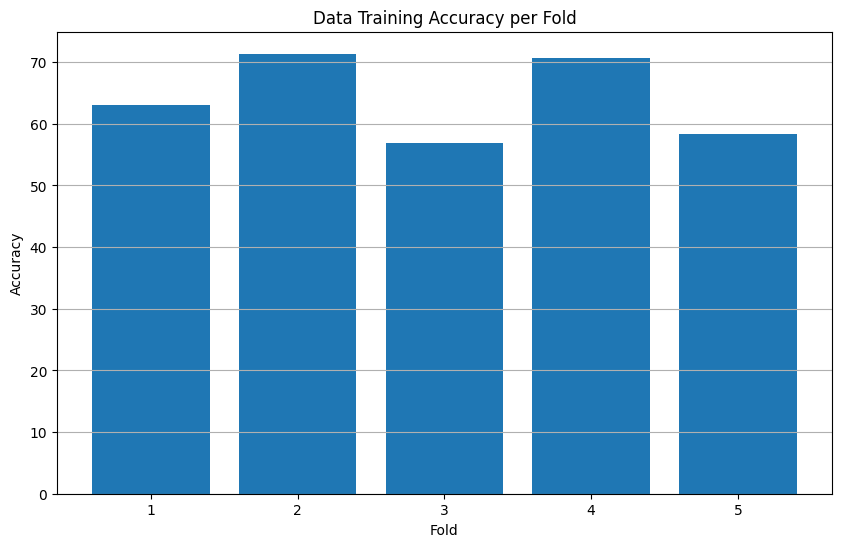

In [61]:
import matplotlib.pyplot as plt

# Buat figure dengan ukuran yang diinginkan
plt.figure(figsize=(10, 6))

# Buat grafik batang
plt.bar(range(1, len(accuracy_per_fold) + 1), accuracy_per_fold)

# Tambahkan judul dan label sumbu
plt.title('Data Training Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')

# Tambahkan tanda pada sumbu x sesuai jumlah fold
plt.xticks(range(1, len(accuracy_per_fold) + 1))

# Tambahkan grid untuk memudahkan pembacaan nilai
plt.grid(True, axis='y')

# Tampilkan grafik
plt.show()

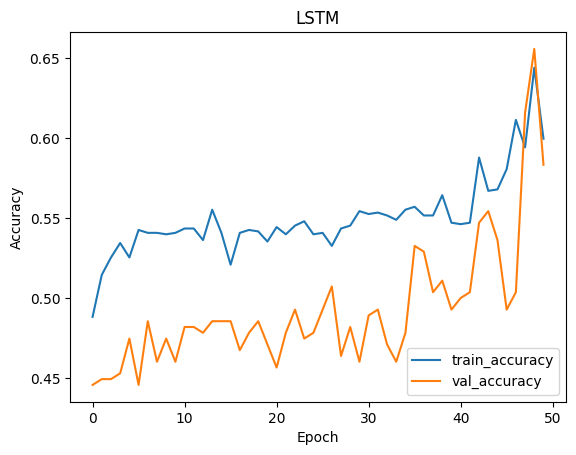

In [62]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('LSTM')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

# Gunakan fungsi plot_learning_curves dengan parameter objek history dari model.fit
plot_learning_curves(lstm)

In [63]:
import numpy as np
from keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report
import shutil

# Asumsikan X_test dan y_test adalah dataset yang digunakan untuk evaluasi
# Anda harus mengganti ini dengan data yang sesuai

# Jumlah fold yang digunakan selama cross-validation
n_folds = 5

# List untuk menyimpan hasil evaluasi
accuracy_per_fold = []
loss_per_fold = []

# Variabel untuk melacak model dengan akurasi terbaik
best_accuracy = 0.0
best_model_filename = None

for fold_no in range(1, n_folds + 1):
    # Membuat path ke model yang disimpan
    model_filename = f'models_lstm/model_lstm_fold_{fold_no}.h5'
    
    # Memuat model
    model = load_model(model_filename)
    
    # Evaluasi model pada data uji
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'Fold {fold_no} - Loss: {loss} - Accuracy: {accuracy * 100}%')
    accuracy_per_fold.append(accuracy * 100)
    loss_per_fold.append(loss)
    
    # Cek apakah model saat ini adalah yang terbaik
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_filename = model_filename

    # Prediksi label menggunakan model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)  # Bentuk one-hot encoded

    # Hitung accuracy score
    acc_score = accuracy_score(y_true, y_pred_classes)
    print(f'Model Evaluate Accuracy Score for fold {fold_no}: {acc_score * 100}%')

    # Laporan klasifikasi
    print(f'Classification Report for fold {fold_no}:\n', classification_report(y_true, y_pred_classes))

# Menampilkan hasil akhir
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracy_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

# Menyimpan model dengan akurasi terbaik
if best_model_filename:
    shutil.copy(best_model_filename, 'model2.h5')
    print(f'Model with the best accuracy saved as model2.h5 with accuracy: {best_accuracy * 100}%')

Fold 1 - Loss: 0.7605173587799072 - Accuracy: 63.4782612323761%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


Model Evaluate Accuracy Score for fold 1: 63.47826086956522%
Classification Report for fold 1:
               precision    recall  f1-score   support

           0       0.72      0.34      0.46       126
           1       0.51      0.88      0.64       109
           2       0.84      0.73      0.78       110

    accuracy                           0.63       345
   macro avg       0.69      0.65      0.63       345
weighted avg       0.69      0.63      0.62       345

Fold 2 - Loss: 0.7144664525985718 - Accuracy: 67.8260862827301%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


Model Evaluate Accuracy Score for fold 2: 67.82608695652173%
Classification Report for fold 2:
               precision    recall  f1-score   support

           0       0.65      0.52      0.58       126
           1       0.55      0.75      0.64       109
           2       0.90      0.79      0.84       110

    accuracy                           0.68       345
   macro avg       0.70      0.69      0.68       345
weighted avg       0.70      0.68      0.68       345

Fold 3 - Loss: 0.8454182147979736 - Accuracy: 59.42028760910034%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


Model Evaluate Accuracy Score for fold 3: 59.42028985507246%
Classification Report for fold 3:
               precision    recall  f1-score   support

           0       0.62      0.32      0.42       126
           1       0.57      0.71      0.63       109
           2       0.61      0.80      0.69       110

    accuracy                           0.59       345
   macro avg       0.60      0.61      0.58       345
weighted avg       0.60      0.59      0.57       345

Fold 4 - Loss: 0.6732689738273621 - Accuracy: 72.1739113330841%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


Model Evaluate Accuracy Score for fold 4: 72.17391304347827%
Classification Report for fold 4:
               precision    recall  f1-score   support

           0       0.62      0.82      0.70       126
           1       0.73      0.52      0.61       109
           2       0.89      0.81      0.85       110

    accuracy                           0.72       345
   macro avg       0.75      0.72      0.72       345
weighted avg       0.74      0.72      0.72       345

Fold 5 - Loss: 0.8552913665771484 - Accuracy: 61.739128828048706%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Model Evaluate Accuracy Score for fold 5: 61.73913043478261%
Classification Report for fold 5:
               precision    recall  f1-score   support

           0       0.55      0.75      0.63       126
           1       0.57      0.59      0.58       109
           2       0.93      0.49      0.64       110

    accuracy                           0.62       345
   macro avg       0.68      0.61      0.62      

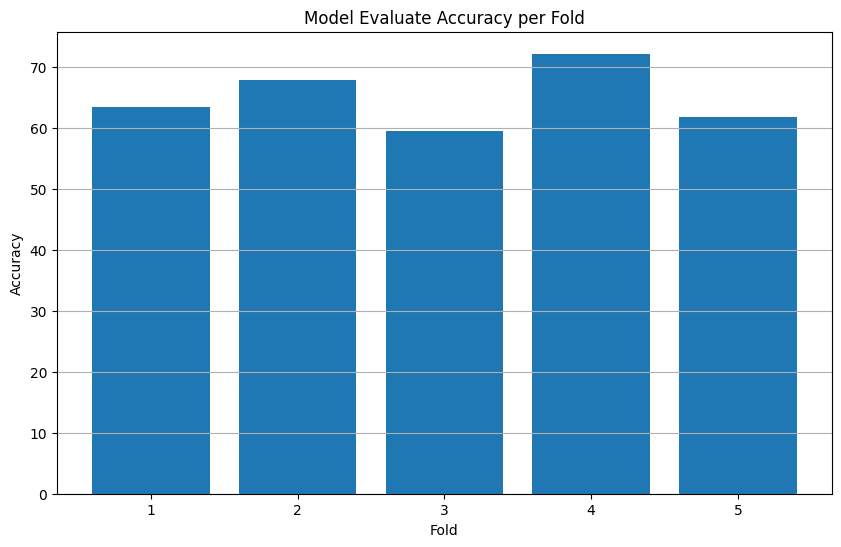

In [64]:
import matplotlib.pyplot as plt

# Buat figure dengan ukuran yang diinginkan
plt.figure(figsize=(10, 6))

# Buat grafik batang
plt.bar(range(1, len(accuracy_per_fold) + 1), accuracy_per_fold)

# Tambahkan judul dan label sumbu
plt.title('Model Evaluate Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')

# Tambahkan tanda pada sumbu x sesuai jumlah fold
plt.xticks(range(1, len(accuracy_per_fold) + 1))

# Tambahkan grid untuk memudahkan pembacaan nilai
plt.grid(True, axis='y')

# Tampilkan grafik
plt.show()

### RNN

In [50]:
import tensorflow as tf

def create_rnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(64, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.SimpleRNN(64),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_rnn = create_rnn_model(input_shape, 3)
model_rnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 27, 64)         │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 27, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,835 (65.76 KB)

 Trainable params: 16,835 (65.76 KB)

 Non-trainable params: 0 (0.00 B)

In [66]:
from sklearn.model_selection import KFold
import numpy as np
import os

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Menyimpan hasil setiap fold
fold_no = 1
accuracy_per_fold = []
loss_per_fold = []

# Membuat direktori untuk menyimpan model jika belum ada
os.makedirs('models_rnn', exist_ok=True)

for train_index, val_index in kf.split(X_train):
    print(f'Fold {fold_no}')
    
    # Membagi data
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Membuat model baru
    model_rnn = create_rnn_model(input_shape, 3)
    
    # Melatih model
    rnn = model_rnn.fit(X_train_fold, y_train_fold, batch_size=64, epochs=50, validation_data=(X_val_fold, y_val_fold), verbose=2)
    
    # Evaluasi model pada data validasi fold
    scores = model_rnn.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Score for fold {fold_no}: {model_rnn.metrics_names[0]} of {scores[0]}; {model_rnn.metrics_names[1]} of {scores[1]*100}%')
    accuracy_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Simpan model
    model_filename = f'models_rnn/model_rnn_fold_{fold_no}.h5'
    model_rnn.save(model_filename)
    print(f'Model for fold {fold_no} saved as {model_filename}')
    
    fold_no += 1

# Menampilkan hasil akhir
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracy_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


Fold 1
Epoch 1/50
18/18 - 4s - 240ms/step - accuracy: 0.4293 - loss: 1.0776 - val_accuracy: 0.5109 - val_loss: 1.0218
Epoch 2/50
18/18 - 0s - 17ms/step - accuracy: 0.4764 - loss: 1.0010 - val_accuracy: 0.5399 - val_loss: 0.9795
Epoch 3/50
18/18 - 0s - 16ms/step - accuracy: 0.4891 - loss: 1.0034 - val_accuracy: 0.5326 - val_loss: 0.9714
Epoch 4/50
18/18 - 0s - 16ms/step - accuracy: 0.4783 - loss: 0.9995 - val_accuracy: 0.5290 - val_loss: 0.9800
Epoch 5/50
18/18 - 0s - 16ms/step - accuracy: 0.5127 - loss: 0.9815 - val_accuracy: 0.5362 - val_loss: 0.9716
Epoch 6/50
18/18 - 0s - 15ms/step - accuracy: 0.4828 - loss: 0.9868 - val_accuracy: 0.5435 - val_loss: 0.9856
Epoch 7/50
18/18 - 0s - 19ms/step - accuracy: 0.5109 - loss: 0.9702 - val_accuracy: 0.5362 - val_loss: 0.9605
Epoch 8/50
18/18 - 0s - 16ms/step - accuracy: 0.5045 - loss: 0.9803 - val_accuracy: 0.5543 - val_loss: 1.0066
Epoch 9/50
18/18 - 0s - 16ms/step - accuracy: 0.4937 - loss: 0.9856 - val_accuracy: 0.5254 - val_loss: 0.9800
Ep

Score for fold 1: loss of 0.43926146626472473; compile_metrics of 80.07246255874634%
Model for fold 1 saved as models_rnn/model_rnn_fold_1.h5
Fold 2
Epoch 1/50
18/18 - 3s - 187ms/step - accuracy: 0.4203 - loss: 1.0754 - val_accuracy: 0.5181 - val_loss: 0.9843
Epoch 2/50
18/18 - 0s - 13ms/step - accuracy: 0.4882 - loss: 1.0094 - val_accuracy: 0.5362 - val_loss: 0.9663
Epoch 3/50
18/18 - 0s - 13ms/step - accuracy: 0.5027 - loss: 0.9955 - val_accuracy: 0.4855 - val_loss: 0.9900
Epoch 4/50
18/18 - 0s - 13ms/step - accuracy: 0.4928 - loss: 0.9978 - val_accuracy: 0.5580 - val_loss: 0.9640
Epoch 5/50
18/18 - 0s - 13ms/step - accuracy: 0.5127 - loss: 0.9887 - val_accuracy: 0.5254 - val_loss: 0.9568
Epoch 6/50
18/18 - 0s - 13ms/step - accuracy: 0.4964 - loss: 1.0095 - val_accuracy: 0.5399 - val_loss: 0.9643
Epoch 7/50
18/18 - 0s - 14ms/step - accuracy: 0.5082 - loss: 0.9903 - val_accuracy: 0.5254 - val_loss: 0.9642
Epoch 8/50
18/18 - 0s - 13ms/step - accuracy: 0.4982 - loss: 0.9904 - val_accura

Score for fold 2: loss of 0.5143141150474548; compile_metrics of 78.2608687877655%
Model for fold 2 saved as models_rnn/model_rnn_fold_2.h5
Fold 3
Epoch 1/50
18/18 - 3s - 183ms/step - accuracy: 0.4357 - loss: 1.0682 - val_accuracy: 0.4275 - val_loss: 1.0261
Epoch 2/50
18/18 - 0s - 13ms/step - accuracy: 0.4466 - loss: 1.0190 - val_accuracy: 0.5217 - val_loss: 0.9655
Epoch 3/50
18/18 - 0s - 13ms/step - accuracy: 0.4991 - loss: 0.9912 - val_accuracy: 0.5435 - val_loss: 0.9553
Epoch 4/50
18/18 - 0s - 13ms/step - accuracy: 0.5100 - loss: 0.9872 - val_accuracy: 0.5399 - val_loss: 0.9430
Epoch 5/50
18/18 - 0s - 13ms/step - accuracy: 0.4810 - loss: 0.9990 - val_accuracy: 0.5543 - val_loss: 0.9512
Epoch 6/50
18/18 - 0s - 12ms/step - accuracy: 0.4982 - loss: 0.9995 - val_accuracy: 0.5471 - val_loss: 0.9452
Epoch 7/50
18/18 - 0s - 13ms/step - accuracy: 0.5208 - loss: 0.9729 - val_accuracy: 0.5507 - val_loss: 0.9595
Epoch 8/50
18/18 - 0s - 13ms/step - accuracy: 0.5145 - loss: 0.9680 - val_accuracy

Score for fold 3: loss of 0.43914905190467834; compile_metrics of 82.6086938381195%
Model for fold 3 saved as models_rnn/model_rnn_fold_3.h5
Fold 4
Epoch 1/50
18/18 - 3s - 181ms/step - accuracy: 0.4384 - loss: 1.0788 - val_accuracy: 0.5217 - val_loss: 0.9924
Epoch 2/50
18/18 - 0s - 13ms/step - accuracy: 0.4737 - loss: 1.0207 - val_accuracy: 0.5254 - val_loss: 0.9569
Epoch 3/50
18/18 - 0s - 13ms/step - accuracy: 0.4982 - loss: 1.0192 - val_accuracy: 0.5290 - val_loss: 0.9482
Epoch 4/50
18/18 - 0s - 13ms/step - accuracy: 0.4964 - loss: 1.0035 - val_accuracy: 0.5399 - val_loss: 0.9357
Epoch 5/50
18/18 - 0s - 13ms/step - accuracy: 0.5045 - loss: 0.9972 - val_accuracy: 0.5254 - val_loss: 0.9427
Epoch 6/50
18/18 - 0s - 13ms/step - accuracy: 0.5063 - loss: 0.9912 - val_accuracy: 0.5217 - val_loss: 0.9396
Epoch 7/50
18/18 - 0s - 13ms/step - accuracy: 0.5226 - loss: 0.9845 - val_accuracy: 0.4928 - val_loss: 0.9741
Epoch 8/50
18/18 - 0s - 13ms/step - accuracy: 0.5091 - loss: 1.0023 - val_accurac

Score for fold 4: loss of 0.6325538158416748; compile_metrics of 70.28985619544983%
Model for fold 4 saved as models_rnn/model_rnn_fold_4.h5
Fold 5
Epoch 1/50
18/18 - 3s - 182ms/step - accuracy: 0.4755 - loss: 1.0367 - val_accuracy: 0.4384 - val_loss: 1.0589
Epoch 2/50
18/18 - 0s - 13ms/step - accuracy: 0.5226 - loss: 0.9968 - val_accuracy: 0.4746 - val_loss: 1.0387
Epoch 3/50
18/18 - 0s - 16ms/step - accuracy: 0.4937 - loss: 0.9950 - val_accuracy: 0.4493 - val_loss: 1.0414
Epoch 4/50
18/18 - 0s - 19ms/step - accuracy: 0.4955 - loss: 0.9809 - val_accuracy: 0.4565 - val_loss: 1.0569
Epoch 5/50
18/18 - 0s - 17ms/step - accuracy: 0.5444 - loss: 0.9649 - val_accuracy: 0.4565 - val_loss: 1.0413
Epoch 6/50
18/18 - 0s - 19ms/step - accuracy: 0.5254 - loss: 0.9749 - val_accuracy: 0.4565 - val_loss: 1.0338
Epoch 7/50
18/18 - 0s - 16ms/step - accuracy: 0.5263 - loss: 0.9729 - val_accuracy: 0.4565 - val_loss: 1.0664
Epoch 8/50
18/18 - 0s - 13ms/step - accuracy: 0.5308 - loss: 0.9601 - val_accurac

Score for fold 5: loss of 0.7338686585426331; compile_metrics of 68.478262424469%
Model for fold 5 saved as models_rnn/model_rnn_fold_5.h5
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.43926146626472473 - Accuracy: 80.07246255874634%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.5143141150474548 - Accuracy: 78.2608687877655%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.43914905190467834 - Accuracy: 82.6086938381195%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.6325538158416748 - Accuracy: 70.28985619544983%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.7338686585426331 - Accuracy: 68.478262424469%
------------------------------------------------------------------------
Av

In [67]:
# Menampilkan akurasi per fold
print('Data Training Accuracy per fold:')
for i in range(len(accuracy_per_fold)):
    print(f'Fold {i+1}: {accuracy_per_fold[i]}%')

Data Training Accuracy per fold:
Fold 1: 80.07246255874634%
Fold 2: 78.2608687877655%
Fold 3: 82.6086938381195%
Fold 4: 70.28985619544983%
Fold 5: 68.478262424469%


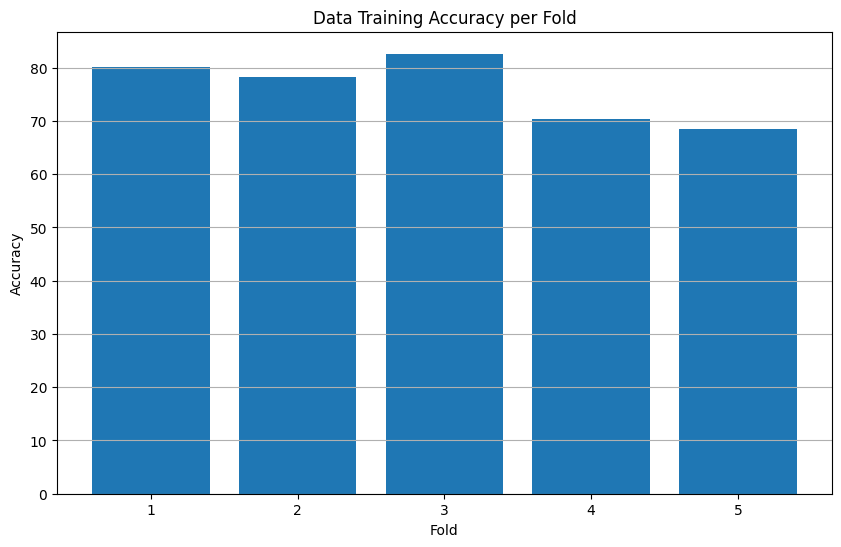

In [68]:
import matplotlib.pyplot as plt

# Buat figure dengan ukuran yang diinginkan
plt.figure(figsize=(10, 6))

# Buat grafik batang
plt.bar(range(1, len(accuracy_per_fold) + 1), accuracy_per_fold)

# Tambahkan judul dan label sumbu
plt.title('Data Training Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')

# Tambahkan tanda pada sumbu x sesuai jumlah fold
plt.xticks(range(1, len(accuracy_per_fold) + 1))

# Tambahkan grid untuk memudahkan pembacaan nilai
plt.grid(True, axis='y')

# Tampilkan grafik
plt.show()

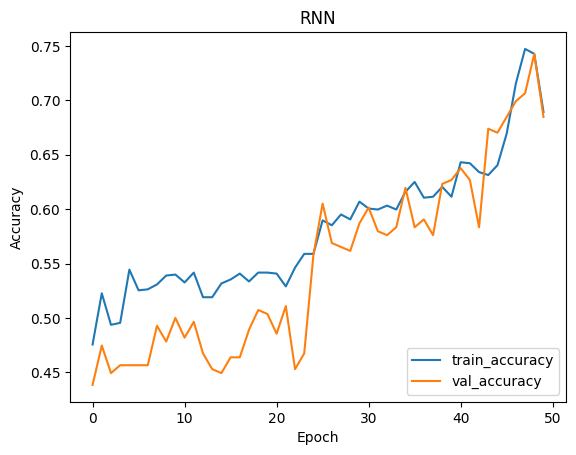

In [69]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('RNN')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

# Gunakan fungsi plot_learning_curves dengan parameter objek history dari model.fit
plot_learning_curves(rnn)

In [70]:
import numpy as np
from keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report
import shutil

# Asumsikan X_test dan y_test adalah dataset yang digunakan untuk evaluasi
# Anda harus mengganti ini dengan data yang sesuai

# Jumlah fold yang digunakan selama cross-validation
n_folds = 5

# List untuk menyimpan hasil evaluasi
accuracy_per_fold = []
loss_per_fold = []

# Variabel untuk melacak model dengan akurasi terbaik
best_accuracy = 0.0
best_model_filename = None

for fold_no in range(1, n_folds + 1):
    # Membuat path ke model yang disimpan
    model_filename = f'models_rnn/model_rnn_fold_{fold_no}.h5'
    
    # Memuat model
    model = load_model(model_filename)
    
    # Evaluasi model pada data uji
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'Fold {fold_no} - Loss: {loss} - Accuracy: {accuracy * 100}%')
    accuracy_per_fold.append(accuracy * 100)
    loss_per_fold.append(loss)
    
    # Cek apakah model saat ini adalah yang terbaik
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_filename = model_filename

    # Prediksi label menggunakan model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)  # Bentuk one-hot encoded

    # Hitung accuracy score
    acc_score = accuracy_score(y_true, y_pred_classes)
    print(f'Model Evaluate Accuracy Score for fold {fold_no}: {acc_score * 100}%')

    # Laporan klasifikasi
    print(f'Classification Report for fold {fold_no}:\n', classification_report(y_true, y_pred_classes))

# Menampilkan hasil akhir
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracy_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

# Menyimpan model dengan akurasi terbaik
if best_model_filename:
    shutil.copy(best_model_filename, 'model3.h5')
    print(f'Model with the best accuracy saved as model3.h5 with accuracy: {best_accuracy * 100}%')

Fold 1 - Loss: 0.48298636078834534 - Accuracy: 79.71014380455017%
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step


Model Evaluate Accuracy Score for fold 1: 79.71014492753623%
Classification Report for fold 1:
               precision    recall  f1-score   support

           0       0.69      0.87      0.77       126
           1       0.84      0.64      0.73       109
           2       0.91      0.87      0.89       110

    accuracy                           0.80       345
   macro avg       0.82      0.79      0.80       345
weighted avg       0.81      0.80      0.80       345

Fold 2 - Loss: 0.5649541616439819 - Accuracy: 75.94202756881714%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


Model Evaluate Accuracy Score for fold 2: 75.94202898550725%
Classification Report for fold 2:
               precision    recall  f1-score   support

           0       0.65      0.87      0.75       126
           1       0.74      0.57      0.64       109
           2       0.98      0.82      0.89       110

    accuracy                           0.76       345
   macro avg       0.79      0.75      0.76       345
weighted avg       0.78      0.76      0.76       345

Fold 3 - Loss: 0.41339942812919617 - Accuracy: 84.05796885490417%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


Model Evaluate Accuracy Score for fold 3: 84.05797101449275%
Classification Report for fold 3:
               precision    recall  f1-score   support

           0       0.83      0.76      0.80       126
           1       0.80      0.83      0.82       109
           2       0.89      0.94      0.91       110

    accuracy                           0.84       345
   macro avg       0.84      0.84      0.84       345
weighted avg       0.84      0.84      0.84       345

Fold 4 - Loss: 0.6752450466156006 - Accuracy: 74.49275255203247%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


Model Evaluate Accuracy Score for fold 4: 74.4927536231884%
Classification Report for fold 4:
               precision    recall  f1-score   support

           0       0.70      0.69      0.69       126
           1       0.78      0.73      0.75       109
           2       0.77      0.82      0.79       110

    accuracy                           0.74       345
   macro avg       0.75      0.75      0.75       345
weighted avg       0.74      0.74      0.74       345

Fold 5 - Loss: 0.6833778619766235 - Accuracy: 71.59420251846313%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Model Evaluate Accuracy Score for fold 5: 71.59420289855073%
Classification Report for fold 5:
               precision    recall  f1-score   support

           0       0.70      0.56      0.62       126
           1       0.65      0.74      0.69       109
           2       0.80      0.87      0.83       110

    accuracy                           0.72       345
   macro avg       0.72      0.72      0.72       3

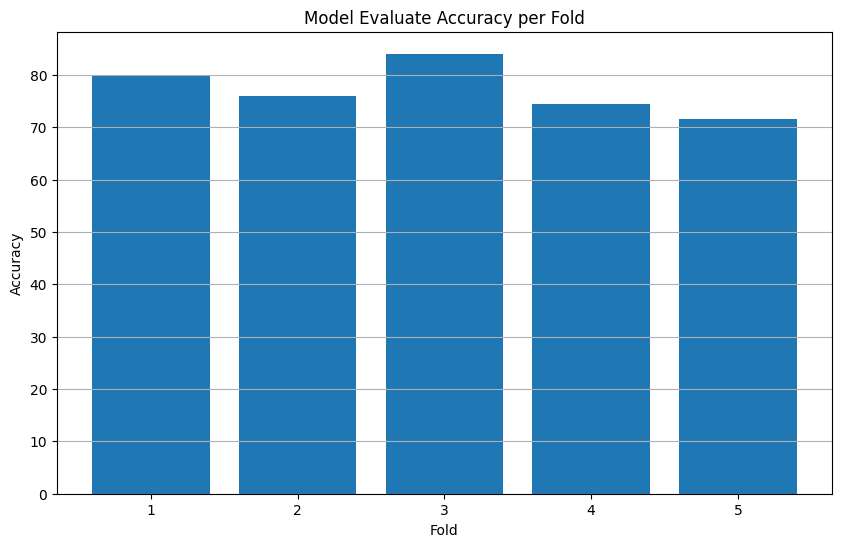

In [71]:
import matplotlib.pyplot as plt

# Buat figure dengan ukuran yang diinginkan
plt.figure(figsize=(10, 6))

# Buat grafik batang
plt.bar(range(1, len(accuracy_per_fold) + 1), accuracy_per_fold)

# Tambahkan judul dan label sumbu
plt.title('Model Evaluate Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')

# Tambahkan tanda pada sumbu x sesuai jumlah fold
plt.xticks(range(1, len(accuracy_per_fold) + 1))

# Tambahkan grid untuk memudahkan pembacaan nilai
plt.grid(True, axis='y')

# Tampilkan grafik
plt.show()

### DNN

In [51]:
def create_dnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=input_shape),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Flatten(),  # Menambahkan lapisan Flatten
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model_dnn = create_dnn_model(input_shape, 3)
model_dnn.summary()

C:\Users\asus\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 27, 128)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 27, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 27, 64)         │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 27, 32)         │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 864)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │         2,595 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,187 (51.51 KB)

 Trainable params: 13,187 (51.51 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
print(y_train.shape)

(1380, 3)


In [74]:
from sklearn.model_selection import KFold
import numpy as np
import os

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Menyimpan hasil setiap fold
fold_no = 1
accuracy_per_fold = []
loss_per_fold = []

# Membuat direktori untuk menyimpan model jika belum ada
os.makedirs('models_dnn', exist_ok=True)

for train_index, val_index in kf.split(X_train):
    print(f'Fold {fold_no}')
    
    # Membagi data
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Membuat model baru
    model_dnn = create_dnn_model(input_shape, 3)
    
    # Melatih model
    dnn = model_dnn.fit(X_train_fold, y_train_fold, batch_size=64, epochs=50, validation_data=(X_val_fold, y_val_fold), verbose=2)
    
    # Evaluasi model pada data validasi fold
    scores = model_dnn.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Score for fold {fold_no}: {model_dnn.metrics_names[0]} of {scores[0]}; {model_dnn.metrics_names[1]} of {scores[1]*100}%')
    accuracy_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Simpan model
    model_filename = f'models_dnn/model_dnn_fold_{fold_no}.h5'
    model_dnn.save(model_filename)
    print(f'Model for fold {fold_no} saved as {model_filename}')
    
    fold_no += 1

# Menampilkan hasil akhir
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracy_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


Fold 1
Epoch 1/50
18/18 - 2s - 128ms/step - accuracy: 0.3351 - loss: 1.4376 - val_accuracy: 0.3225 - val_loss: 1.1276
Epoch 2/50
18/18 - 0s - 16ms/step - accuracy: 0.3795 - loss: 1.2482 - val_accuracy: 0.4167 - val_loss: 1.1043
Epoch 3/50
18/18 - 0s - 15ms/step - accuracy: 0.4049 - loss: 1.1671 - val_accuracy: 0.3514 - val_loss: 1.1097
Epoch 4/50
18/18 - 0s - 14ms/step - accuracy: 0.4176 - loss: 1.1199 - val_accuracy: 0.3587 - val_loss: 1.0632
Epoch 5/50
18/18 - 0s - 14ms/step - accuracy: 0.4447 - loss: 1.1260 - val_accuracy: 0.3333 - val_loss: 1.0972
Epoch 6/50
18/18 - 0s - 14ms/step - accuracy: 0.4094 - loss: 1.1183 - val_accuracy: 0.3333 - val_loss: 1.0869
Epoch 7/50
18/18 - 0s - 14ms/step - accuracy: 0.4321 - loss: 1.1036 - val_accuracy: 0.3442 - val_loss: 1.1024
Epoch 8/50
18/18 - 0s - 14ms/step - accuracy: 0.4212 - loss: 1.0915 - val_accuracy: 0.3913 - val_loss: 1.0628
Epoch 9/50
18/18 - 0s - 14ms/step - accuracy: 0.4592 - loss: 1.0793 - val_accuracy: 0.3732 - val_loss: 1.0739
Ep

Score for fold 1: loss of 0.47875717282295227; compile_metrics of 77.53623127937317%
Model for fold 1 saved as models_dnn/model_dnn_fold_1.h5
Fold 2
Epoch 1/50
18/18 - 2s - 101ms/step - accuracy: 0.3578 - loss: 1.3348 - val_accuracy: 0.4058 - val_loss: 1.1121
Epoch 2/50
18/18 - 0s - 11ms/step - accuracy: 0.3813 - loss: 1.2150 - val_accuracy: 0.4928 - val_loss: 1.0896
Epoch 3/50
18/18 - 0s - 10ms/step - accuracy: 0.4321 - loss: 1.1480 - val_accuracy: 0.3551 - val_loss: 1.0787
Epoch 4/50
18/18 - 0s - 10ms/step - accuracy: 0.4230 - loss: 1.1300 - val_accuracy: 0.3841 - val_loss: 1.0695
Epoch 5/50
18/18 - 0s - 11ms/step - accuracy: 0.4094 - loss: 1.1176 - val_accuracy: 0.3841 - val_loss: 1.0732
Epoch 6/50
18/18 - 0s - 10ms/step - accuracy: 0.4194 - loss: 1.1125 - val_accuracy: 0.3841 - val_loss: 1.0604
Epoch 7/50
18/18 - 0s - 11ms/step - accuracy: 0.4511 - loss: 1.0858 - val_accuracy: 0.3913 - val_loss: 1.0487
Epoch 8/50
18/18 - 0s - 10ms/step - accuracy: 0.4683 - loss: 1.0911 - val_accura

Score for fold 2: loss of 0.40508005023002625; compile_metrics of 85.50724387168884%
Model for fold 2 saved as models_dnn/model_dnn_fold_2.h5
Fold 3
Epoch 1/50
18/18 - 2s - 101ms/step - accuracy: 0.3551 - loss: 1.3824 - val_accuracy: 0.3370 - val_loss: 1.0954
Epoch 2/50
18/18 - 0s - 11ms/step - accuracy: 0.4438 - loss: 1.2167 - val_accuracy: 0.3514 - val_loss: 1.0901
Epoch 3/50
18/18 - 0s - 10ms/step - accuracy: 0.4339 - loss: 1.1527 - val_accuracy: 0.4601 - val_loss: 1.0645
Epoch 4/50
18/18 - 0s - 13ms/step - accuracy: 0.4348 - loss: 1.1131 - val_accuracy: 0.3804 - val_loss: 1.0647
Epoch 5/50
18/18 - 0s - 10ms/step - accuracy: 0.4737 - loss: 1.1101 - val_accuracy: 0.3696 - val_loss: 1.0720
Epoch 6/50
18/18 - 0s - 11ms/step - accuracy: 0.4257 - loss: 1.0863 - val_accuracy: 0.3949 - val_loss: 1.0766
Epoch 7/50
18/18 - 0s - 10ms/step - accuracy: 0.4900 - loss: 1.0954 - val_accuracy: 0.3514 - val_loss: 1.0753
Epoch 8/50
18/18 - 0s - 10ms/step - accuracy: 0.4348 - loss: 1.0888 - val_accura

Score for fold 3: loss of 0.4778849184513092; compile_metrics of 81.15941882133484%
Model for fold 3 saved as models_dnn/model_dnn_fold_3.h5
Fold 4
Epoch 1/50
18/18 - 2s - 102ms/step - accuracy: 0.3433 - loss: 1.5008 - val_accuracy: 0.3696 - val_loss: 1.1502
Epoch 2/50
18/18 - 0s - 11ms/step - accuracy: 0.3967 - loss: 1.2579 - val_accuracy: 0.4384 - val_loss: 1.2112
Epoch 3/50
18/18 - 0s - 10ms/step - accuracy: 0.4176 - loss: 1.2288 - val_accuracy: 0.3768 - val_loss: 1.1145
Epoch 4/50
18/18 - 0s - 11ms/step - accuracy: 0.4112 - loss: 1.1961 - val_accuracy: 0.3986 - val_loss: 1.0840
Epoch 5/50
18/18 - 0s - 10ms/step - accuracy: 0.4357 - loss: 1.1740 - val_accuracy: 0.3732 - val_loss: 1.0991
Epoch 6/50
18/18 - 0s - 11ms/step - accuracy: 0.4493 - loss: 1.1098 - val_accuracy: 0.4058 - val_loss: 1.0488
Epoch 7/50
18/18 - 0s - 10ms/step - accuracy: 0.4728 - loss: 1.1084 - val_accuracy: 0.3877 - val_loss: 1.0677
Epoch 8/50
18/18 - 0s - 10ms/step - accuracy: 0.4701 - loss: 1.0946 - val_accurac

Score for fold 4: loss of 0.42685189843177795; compile_metrics of 84.42028760910034%
Model for fold 4 saved as models_dnn/model_dnn_fold_4.h5
Fold 5
Epoch 1/50
18/18 - 2s - 102ms/step - accuracy: 0.3460 - loss: 1.4505 - val_accuracy: 0.3841 - val_loss: 1.1080
Epoch 2/50
18/18 - 0s - 11ms/step - accuracy: 0.3777 - loss: 1.2624 - val_accuracy: 0.3406 - val_loss: 1.2214
Epoch 3/50
18/18 - 0s - 10ms/step - accuracy: 0.4158 - loss: 1.1965 - val_accuracy: 0.4529 - val_loss: 1.1027
Epoch 4/50
18/18 - 0s - 10ms/step - accuracy: 0.4130 - loss: 1.1538 - val_accuracy: 0.4565 - val_loss: 1.1241
Epoch 5/50
18/18 - 0s - 11ms/step - accuracy: 0.4547 - loss: 1.1092 - val_accuracy: 0.4638 - val_loss: 1.1079
Epoch 6/50
18/18 - 0s - 11ms/step - accuracy: 0.4185 - loss: 1.1135 - val_accuracy: 0.4275 - val_loss: 1.1100
Epoch 7/50
18/18 - 0s - 11ms/step - accuracy: 0.4429 - loss: 1.0997 - val_accuracy: 0.4746 - val_loss: 1.0909
Epoch 8/50
18/18 - 0s - 11ms/step - accuracy: 0.4755 - loss: 1.0788 - val_accura

Score for fold 5: loss of 0.4849633574485779; compile_metrics of 77.173912525177%
Model for fold 5 saved as models_dnn/model_dnn_fold_5.h5
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.47875717282295227 - Accuracy: 77.53623127937317%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.40508005023002625 - Accuracy: 85.50724387168884%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.4778849184513092 - Accuracy: 81.15941882133484%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.42685189843177795 - Accuracy: 84.42028760910034%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.4849633574485779 - Accuracy: 77.173912525177%
------------------------------------------------------------------------

In [75]:
# Menampilkan akurasi per fold
print('Data Training Accuracy per fold:')
for i in range(len(accuracy_per_fold)):
    print(f'Fold {i+1}: {accuracy_per_fold[i]}%')

Data Training Accuracy per fold:
Fold 1: 77.53623127937317%
Fold 2: 85.50724387168884%
Fold 3: 81.15941882133484%
Fold 4: 84.42028760910034%
Fold 5: 77.173912525177%


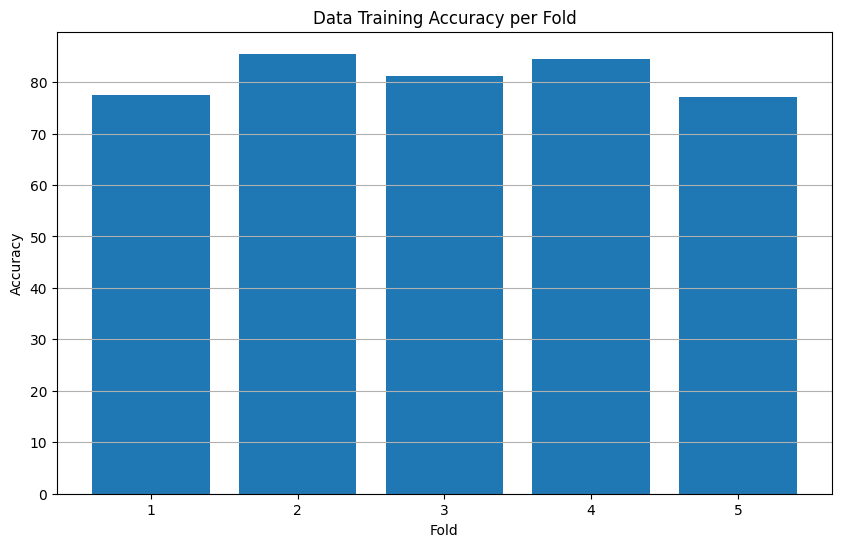

In [76]:
import matplotlib.pyplot as plt

# Buat figure dengan ukuran yang diinginkan
plt.figure(figsize=(10, 6))

# Buat grafik batang
plt.bar(range(1, len(accuracy_per_fold) + 1), accuracy_per_fold)

# Tambahkan judul dan label sumbu
plt.title('Data Training Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')

# Tambahkan tanda pada sumbu x sesuai jumlah fold
plt.xticks(range(1, len(accuracy_per_fold) + 1))

# Tambahkan grid untuk memudahkan pembacaan nilai
plt.grid(True, axis='y')

# Tampilkan grafik
plt.show()

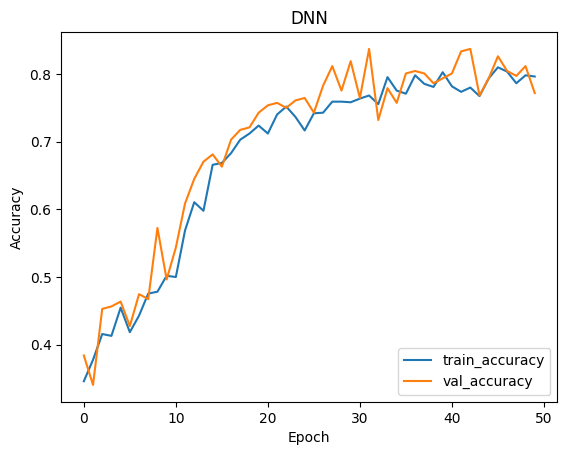

In [77]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('DNN')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

# Gunakan fungsi plot_learning_curves dengan parameter objek history dari model.fit
plot_learning_curves(dnn)

In [78]:
import numpy as np
from keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report
import shutil

# Asumsikan X_test dan y_test adalah dataset yang digunakan untuk evaluasi
# Anda harus mengganti ini dengan data yang sesuai

# Jumlah fold yang digunakan selama cross-validation
n_folds = 5

# List untuk menyimpan hasil evaluasi
accuracy_per_fold = []
loss_per_fold = []

# Variabel untuk melacak model dengan akurasi terbaik
best_accuracy = 0.0
best_model_filename = None

for fold_no in range(1, n_folds + 1):
    # Membuat path ke model yang disimpan
    model_filename = f'models_dnn/model_dnn_fold_{fold_no}.h5'
    
    # Memuat model
    model = load_model(model_filename)
    
    # Evaluasi model pada data uji
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'Fold {fold_no} - Loss: {loss} - Accuracy: {accuracy * 100}%')
    accuracy_per_fold.append(accuracy * 100)
    loss_per_fold.append(loss)
    
    # Cek apakah model saat ini adalah yang terbaik
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_filename = model_filename

    # Prediksi label menggunakan model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)  # Bentuk one-hot encoded

    # Hitung accuracy score
    acc_score = accuracy_score(y_true, y_pred_classes)
    print(f'Model Evaluate Accuracy Score for fold {fold_no}: {acc_score * 100}%')

    # Laporan klasifikasi
    print(f'Classification Report for fold {fold_no}:\n', classification_report(y_true, y_pred_classes))

# Menampilkan hasil akhir
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracy_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

# Menyimpan model dengan akurasi terbaik
if best_model_filename:
    shutil.copy(best_model_filename, 'model4.h5')
    print(f'Model with the best accuracy saved as model4.h5 with accuracy: {best_accuracy * 100}%')

Fold 1 - Loss: 0.46790218353271484 - Accuracy: 78.55072617530823%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Model Evaluate Accuracy Score for fold 1: 78.55072463768116%
Classification Report for fold 1:
               precision    recall  f1-score   support

           0       0.77      0.71      0.74       126
           1       0.87      0.71      0.78       109
           2       0.75      0.95      0.84       110

    accuracy                           0.79       345
   macro avg       0.79      0.79      0.78       345
weighted avg       0.79      0.79      0.78       345

Fold 2 - Loss: 0.4405379891395569 - Accuracy: 82.89855122566223%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Model Evaluate Accuracy Score for fold 2: 82.89855072463767%
Classification Report for fold 2:
               precision    recall  f1-score   support

           0       0.74      0.90      0.81       126
           1       0.86      0.66      0.75       109
           2       0.93      0.91      0.92       110

    accuracy                           0.83       345
   macro avg       0.84      0.82      0.83       345
weighted avg       0.84      0.83      0.83       345

Fold 3 - Loss: 0.43993720412254333 - Accuracy: 82.31884241104126%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Model Evaluate Accuracy Score for fold 3: 82.31884057971014%
Classification Report for fold 3:
               precision    recall  f1-score   support

           0       0.78      0.78      0.78       126
           1       0.81      0.76      0.79       109
           2       0.87      0.94      0.90       110

    accuracy                           0.82       345
   macro avg       0.82      0.83      0.82       345
weighted avg       0.82      0.82      0.82       345

Fold 4 - Loss: 0.43312007188796997 - Accuracy: 81.15941882133484%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Model Evaluate Accuracy Score for fold 4: 81.15942028985508%
Classification Report for fold 4:
               precision    recall  f1-score   support

           0       0.74      0.86      0.79       126
           1       0.86      0.63      0.73       109
           2       0.87      0.94      0.90       110

    accuracy                           0.81       345
   macro avg       0.82      0.81      0.81       345
weighted avg       0.82      0.81      0.81       345

Fold 5 - Loss: 0.46546369791030884 - Accuracy: 78.84057760238647%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Model Evaluate Accuracy Score for fold 5: 78.84057971014494%
Classification Report for fold 5:
               precision    recall  f1-score   support

           0       0.77      0.73      0.75       126
           1       0.93      0.68      0.78       109
           2       0.73      0.96      0.83       110

    accuracy                           0.79       345
   macro avg       0.81      0.79      0.79      

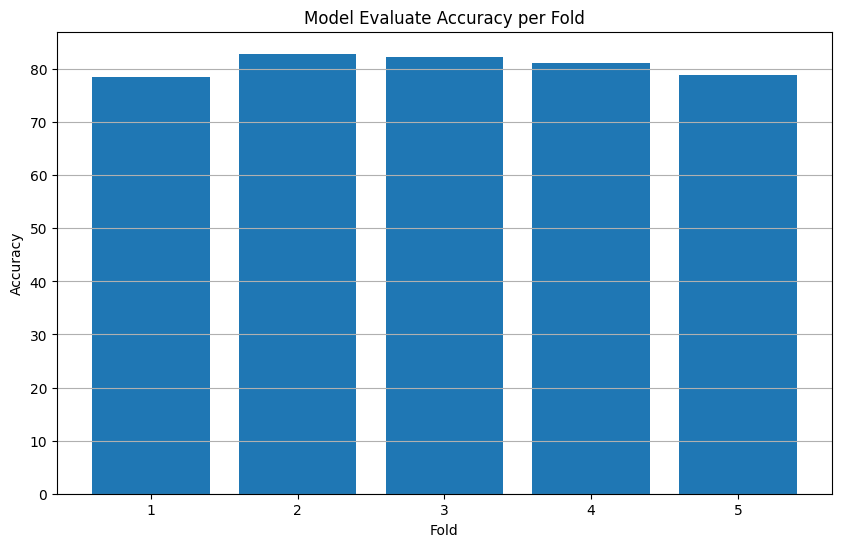

In [79]:
import matplotlib.pyplot as plt

# Buat figure dengan ukuran yang diinginkan
plt.figure(figsize=(10, 6))

# Buat grafik batang
plt.bar(range(1, len(accuracy_per_fold) + 1), accuracy_per_fold)

# Tambahkan judul dan label sumbu
plt.title('Model Evaluate Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')

# Tambahkan tanda pada sumbu x sesuai jumlah fold
plt.xticks(range(1, len(accuracy_per_fold) + 1))

# Tambahkan grid untuk memudahkan pembacaan nilai
plt.grid(True, axis='y')

# Tampilkan grafik
plt.show()

## Tuning

### CNN

In [80]:
from scikeras.wrappers import KerasClassifier

model = KerasClassifier(build_fn=create_cnn_model, input_shape=input_shape, num_classes=3, verbose=2)

In [81]:
param_grid = {
    'batch_size': [32, 64, 128],
    'epochs': [10, 50, 100]
}

In [82]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

ERROR:concurrent.futures:exception calling callback for <Future at 0x1be08ddcf10 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "C:\Users\asus\AppData\Roaming\Python\Python310\site-packages\joblib\externals\loky\process_executor.py", line 391, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "c:\Program Files\Python310\lib\multiprocessing\queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "C:\Users\asus\AppData\Roaming\Python\Python310\site-packages\sklearn\__init__.py", line 87, in <module>
    from .base import clone
  File "C:\Users\asus\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py", line 19, in <module>
    from .utils import _IS_32BIT
  File "C:\Users\asus\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\__init__.py", line 16, in <module>
    from scipy.sparse import issparse
  File "C:\Users\asu

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [82]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

Best: 0.850725 using {'batch_size': 32, 'epochs': 100}
0.607246 (0.014051) with: {'batch_size': 32, 'epochs': 10}
0.829710 (0.030829) with: {'batch_size': 32, 'epochs': 50}
0.850725 (0.029292) with: {'batch_size': 32, 'epochs': 100}
0.569565 (0.029913) with: {'batch_size': 64, 'epochs': 10}
0.794203 (0.019227) with: {'batch_size': 64, 'epochs': 50}
0.850725 (0.028381) with: {'batch_size': 64, 'epochs': 100}
0.573913 (0.042661) with: {'batch_size': 128, 'epochs': 10}
0.739130 (0.021618) with: {'batch_size': 128, 'epochs': 50}
0.815217 (0.032163) with: {'batch_size': 128, 'epochs': 100}


In [83]:
best_params=grid_result.best_params_ 
accuracy=grid_result.best_score_ 

print(best_params)
print(accuracy)

{'batch_size': 32, 'epochs': 100}
0.8507246376811596


In [52]:
from sklearn.model_selection import KFold
import numpy as np
import os

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Menyimpan hasil setiap fold
fold_no = 1
accuracy_per_fold = []
loss_per_fold = []

# Membuat direktori untuk menyimpan model jika belum ada
os.makedirs('models_cnn_tuning', exist_ok=True)

for train_index, val_index in kf.split(X_train):
    print(f'Fold {fold_no}')
    
    # Membagi data
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Membuat model baru
    model_cnn = create_cnn_model(input_shape, 3)
    
    # Melatih model
    cnn = model_cnn.fit(X_train_fold, y_train_fold, batch_size=32, epochs=100, validation_data=(X_val_fold, y_val_fold), verbose=2)
    
    # Evaluasi model pada data validasi fold
    scores = model_cnn.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Score for fold {fold_no}: {model_cnn.metrics_names[0]} of {scores[0]}; {model_cnn.metrics_names[1]} of {scores[1]*100}%')
    accuracy_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Simpan model
    model_filename = f'models_cnn_tuning/model_cnn_tuning_fold_{fold_no}.h5'
    model_cnn.save(model_filename)
    print(f'Model for fold {fold_no} saved as {model_filename}')
    
    fold_no += 1

# Menampilkan hasil akhir
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracy_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Fold 1
Epoch 1/100
35/35 - 2s - 71ms/step - accuracy: 0.3913 - loss: 1.3555 - val_accuracy: 0.4130 - val_loss: 1.2983
Epoch 2/100
35/35 - 0s - 8ms/step - accuracy: 0.4665 - loss: 1.0854 - val_accuracy: 0.5000 - val_loss: 1.0560
Epoch 3/100
35/35 - 0s - 9ms/step - accuracy: 0.5109 - loss: 1.0417 - val_accuracy: 0.5362 - val_loss: 1.0379
Epoch 4/100
35/35 - 0s - 9ms/step - accuracy: 0.4755 - loss: 1.0385 - val_accuracy: 0.4891 - val_loss: 1.0502
Epoch 5/100
35/35 - 0s - 7ms/step - accuracy: 0.5308 - loss: 1.0064 - val_accuracy: 0.5507 - val_loss: 1.0382
Epoch 6/100
35/35 - 0s - 8ms/step - accuracy: 0.5226 - loss: 0.9795 - val_accuracy: 0.5616 - val_loss: 0.9820
Epoch 7/100
35/35 - 0s - 6ms/step - accuracy: 0.5679 - loss: 0.9373 - val_accuracy: 0.5688 - val_loss: 0.9584
Epoch 8/100
35/35 - 0s - 6ms/step - accuracy: 0.5924 - loss: 0.9061 - val_accuracy: 0.5616 - val_loss: 0.9459
Epoch 9/100
35/35 - 0s - 6ms/step - accuracy: 0.6024 - loss: 0.8990 - val_accuracy: 0.5833 - val_loss: 0.9643
Ep

Score for fold 1: loss of 0.4483213424682617; compile_metrics of 81.521737575531%
Model for fold 1 saved as models_cnn_tuning/model_cnn_tuning_fold_1.h5
Fold 2
Epoch 1/100
35/35 - 2s - 51ms/step - accuracy: 0.3714 - loss: 1.1948 - val_accuracy: 0.4384 - val_loss: 1.0920
Epoch 2/100
35/35 - 0s - 6ms/step - accuracy: 0.4239 - loss: 1.0766 - val_accuracy: 0.4964 - val_loss: 1.0458
Epoch 3/100
35/35 - 0s - 5ms/step - accuracy: 0.5217 - loss: 1.0380 - val_accuracy: 0.4601 - val_loss: 1.0230
Epoch 4/100
35/35 - 0s - 6ms/step - accuracy: 0.5362 - loss: 0.9942 - val_accuracy: 0.5580 - val_loss: 0.9794
Epoch 5/100
35/35 - 0s - 6ms/step - accuracy: 0.5489 - loss: 0.9579 - val_accuracy: 0.6014 - val_loss: 0.9429
Epoch 6/100
35/35 - 0s - 6ms/step - accuracy: 0.5670 - loss: 0.9377 - val_accuracy: 0.5870 - val_loss: 0.9337
Epoch 7/100
35/35 - 0s - 6ms/step - accuracy: 0.5417 - loss: 0.9308 - val_accuracy: 0.5906 - val_loss: 0.8939
Epoch 8/100
35/35 - 0s - 5ms/step - accuracy: 0.5761 - loss: 0.8872 -

Score for fold 2: loss of 0.4499058127403259; compile_metrics of 85.86956262588501%
Model for fold 2 saved as models_cnn_tuning/model_cnn_tuning_fold_2.h5
Fold 3
Epoch 1/100
35/35 - 2s - 55ms/step - accuracy: 0.3152 - loss: 1.1800 - val_accuracy: 0.3587 - val_loss: 1.0822
Epoch 2/100
35/35 - 0s - 5ms/step - accuracy: 0.4701 - loss: 1.0642 - val_accuracy: 0.4638 - val_loss: 1.1193
Epoch 3/100
35/35 - 0s - 7ms/step - accuracy: 0.4937 - loss: 1.0536 - val_accuracy: 0.5399 - val_loss: 1.0091
Epoch 4/100
35/35 - 0s - 8ms/step - accuracy: 0.5245 - loss: 1.0366 - val_accuracy: 0.5978 - val_loss: 0.9953
Epoch 5/100
35/35 - 0s - 7ms/step - accuracy: 0.5272 - loss: 1.0032 - val_accuracy: 0.6014 - val_loss: 0.9692
Epoch 6/100
35/35 - 0s - 8ms/step - accuracy: 0.5399 - loss: 0.9724 - val_accuracy: 0.5725 - val_loss: 0.9277
Epoch 7/100
35/35 - 0s - 7ms/step - accuracy: 0.5571 - loss: 0.9528 - val_accuracy: 0.5942 - val_loss: 0.9368
Epoch 8/100
35/35 - 0s - 8ms/step - accuracy: 0.5833 - loss: 0.9115

Score for fold 3: loss of 0.32975101470947266; compile_metrics of 88.40579986572266%
Model for fold 3 saved as models_cnn_tuning/model_cnn_tuning_fold_3.h5
Fold 4
Epoch 1/100
35/35 - 2s - 61ms/step - accuracy: 0.3841 - loss: 1.2119 - val_accuracy: 0.3913 - val_loss: 1.0763
Epoch 2/100
35/35 - 0s - 6ms/step - accuracy: 0.4683 - loss: 1.0797 - val_accuracy: 0.5761 - val_loss: 1.0235
Epoch 3/100
35/35 - 0s - 6ms/step - accuracy: 0.5263 - loss: 1.0431 - val_accuracy: 0.5580 - val_loss: 0.9773
Epoch 4/100
35/35 - 0s - 6ms/step - accuracy: 0.5453 - loss: 0.9942 - val_accuracy: 0.4493 - val_loss: 1.0183
Epoch 5/100
35/35 - 0s - 6ms/step - accuracy: 0.5127 - loss: 0.9920 - val_accuracy: 0.5688 - val_loss: 0.9124
Epoch 6/100
35/35 - 0s - 7ms/step - accuracy: 0.5906 - loss: 0.9088 - val_accuracy: 0.5688 - val_loss: 0.8742
Epoch 7/100
35/35 - 0s - 7ms/step - accuracy: 0.5842 - loss: 0.8884 - val_accuracy: 0.5906 - val_loss: 0.8160
Epoch 8/100
35/35 - 0s - 7ms/step - accuracy: 0.6341 - loss: 0.835

Score for fold 4: loss of 0.4824967384338379; compile_metrics of 84.78260636329651%
Model for fold 4 saved as models_cnn_tuning/model_cnn_tuning_fold_4.h5
Fold 5
Epoch 1/100
35/35 - 2s - 60ms/step - accuracy: 0.3850 - loss: 1.1565 - val_accuracy: 0.4638 - val_loss: 1.0707
Epoch 2/100
35/35 - 0s - 7ms/step - accuracy: 0.4937 - loss: 1.0534 - val_accuracy: 0.5254 - val_loss: 1.0688
Epoch 3/100
35/35 - 0s - 6ms/step - accuracy: 0.5335 - loss: 1.0243 - val_accuracy: 0.5072 - val_loss: 1.0023
Epoch 4/100
35/35 - 0s - 6ms/step - accuracy: 0.5127 - loss: 1.0280 - val_accuracy: 0.5181 - val_loss: 0.9913
Epoch 5/100
35/35 - 0s - 6ms/step - accuracy: 0.5063 - loss: 0.9962 - val_accuracy: 0.5326 - val_loss: 0.9542
Epoch 6/100
35/35 - 0s - 6ms/step - accuracy: 0.5734 - loss: 0.9383 - val_accuracy: 0.5616 - val_loss: 0.9357
Epoch 7/100
35/35 - 0s - 7ms/step - accuracy: 0.5426 - loss: 0.9386 - val_accuracy: 0.5870 - val_loss: 0.9154
Epoch 8/100
35/35 - 0s - 7ms/step - accuracy: 0.5842 - loss: 0.8983

Score for fold 5: loss of 0.40656420588493347; compile_metrics of 82.97101259231567%
Model for fold 5 saved as models_cnn_tuning/model_cnn_tuning_fold_5.h5
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.4483213424682617 - Accuracy: 81.521737575531%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.4499058127403259 - Accuracy: 85.86956262588501%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.32975101470947266 - Accuracy: 88.40579986572266%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.4824967384338379 - Accuracy: 84.78260636329651%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.40656420588493347 - Accuracy: 82.97101259231567%
--------------------------------------------------------

In [53]:
# Menampilkan akurasi per fold
print('Data Training Accuracy per fold:')
for i in range(len(accuracy_per_fold)):
    print(f'Fold {i+1}: {accuracy_per_fold[i]}%')

Data Training Accuracy per fold:
Fold 1: 81.521737575531%
Fold 2: 85.86956262588501%
Fold 3: 88.40579986572266%
Fold 4: 84.78260636329651%
Fold 5: 82.97101259231567%


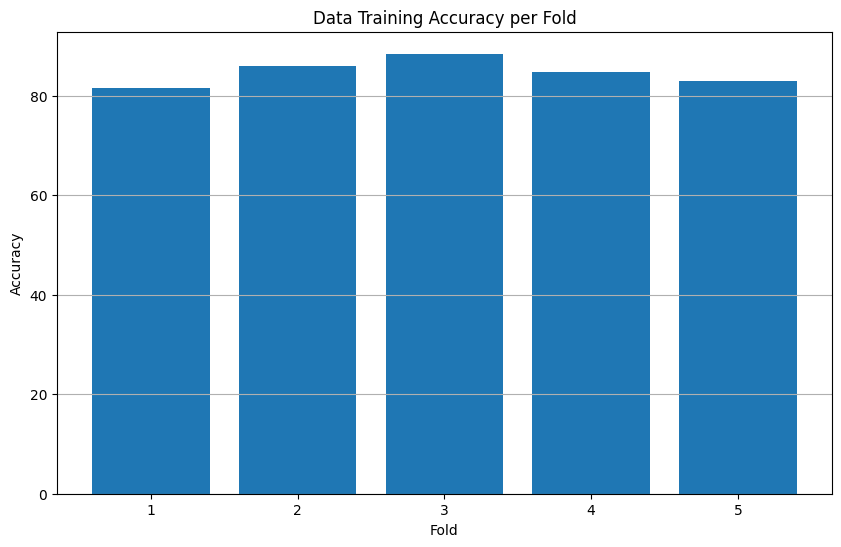

In [54]:
import matplotlib.pyplot as plt

# Buat figure dengan ukuran yang diinginkan
plt.figure(figsize=(10, 6))

# Buat grafik batang
plt.bar(range(1, len(accuracy_per_fold) + 1), accuracy_per_fold)

# Tambahkan judul dan label sumbu
plt.title('Data Training Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')

# Tambahkan tanda pada sumbu x sesuai jumlah fold
plt.xticks(range(1, len(accuracy_per_fold) + 1))

# Tambahkan grid untuk memudahkan pembacaan nilai
plt.grid(True, axis='y')

# Tampilkan grafik
plt.show()

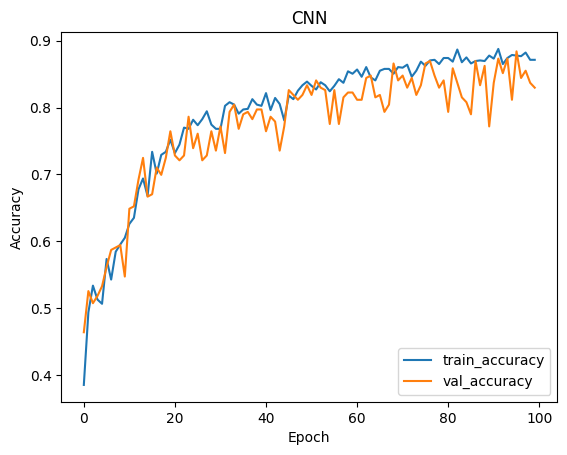

In [55]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('CNN')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

# Gunakan fungsi plot_learning_curves dengan parameter objek history dari model.fit
plot_learning_curves(cnn)

In [56]:
import numpy as np
from keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report
import shutil

# Asumsikan X_test dan y_test adalah dataset yang digunakan untuk evaluasi
# Anda harus mengganti ini dengan data yang sesuai

# Jumlah fold yang digunakan selama cross-validation
n_folds = 5

# List untuk menyimpan hasil evaluasi
accuracy_per_fold = []
loss_per_fold = []

# Variabel untuk melacak model dengan akurasi terbaik
best_accuracy = 0.0
best_model_filename = None

for fold_no in range(1, n_folds + 1):
    # Membuat path ke model yang disimpan
    model_filename = f'models_cnn_tuning/model_cnn_tuning_fold_{fold_no}.h5'
    
    # Memuat model
    model = load_model(model_filename)
    
    # Evaluasi model pada data uji
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'Fold {fold_no} - Loss: {loss} - Accuracy: {accuracy * 100}%')
    accuracy_per_fold.append(accuracy * 100)
    loss_per_fold.append(loss)
    
    # Cek apakah model saat ini adalah yang terbaik
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_filename = model_filename

    # Prediksi label menggunakan model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)  # Bentuk one-hot encoded

    # Hitung accuracy score
    acc_score = accuracy_score(y_true, y_pred_classes)
    print(f'Model Evaluate Accuracy Score for fold {fold_no}: {acc_score * 100}%')

    # Laporan klasifikasi
    print(f'Classification Report for fold {fold_no}:\n', classification_report(y_true, y_pred_classes))

# Menampilkan hasil akhir
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracy_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

# Menyimpan model dengan akurasi terbaik
if best_model_filename:
    shutil.copy(best_model_filename, 'modelTuning1.h5')
    print(f'Model with the best accuracy saved as modelTuning1.h5 with accuracy: {best_accuracy * 100}%')

Fold 1 - Loss: 0.3206542730331421 - Accuracy: 86.95651888847351%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Model Evaluate Accuracy Score for fold 1: 86.95652173913044%
Classification Report for fold 1:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85       126
           1       0.83      0.76      0.79       109
           2       0.97      0.95      0.96       110

    accuracy                           0.87       345
   macro avg       0.87      0.87      0.87       345
weighted avg       0.87      0.87      0.87       345

Fold 2 - Loss: 0.3990440368652344 - Accuracy: 86.08695864677429%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Model Evaluate Accuracy Score for fold 2: 86.08695652173914%
Classification Report for fold 2:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84       126
           1       0.81      0.81      0.81       109
           2       0.96      0.92      0.94       110

    accuracy                           0.86       345
   macro avg       0.86      0.86      0.86       

Fold 3 - Loss: 0.35676783323287964 - Accuracy: 86.66666746139526%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Model Evaluate Accuracy Score for fold 3: 86.66666666666667%
Classification Report for fold 3:
               precision    recall  f1-score   support

           0       0.80      0.90      0.84       126
           1       0.86      0.72      0.79       109
           2       0.96      0.97      0.97       110

    accuracy                           0.87       345
   macro avg       0.87      0.86      0.87       345
weighted avg       0.87      0.87      0.87       345

Fold 4 - Loss: 0.36707165837287903 - Accuracy: 86.08695864677429%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Model Evaluate Accuracy Score for fold 4: 86.08695652173914%
Classification Report for fold 4:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83       126
           1       0.86      0.78      0.82       109
           2       0.89      0.97      0.93       110

    accuracy                           0.86       345
   macro avg       0.86      0.86      0.86       345
weighted avg       0.86      0.86      0.86       345

Fold 5 - Loss: 0.3244062662124634 - Accuracy: 86.66666746139526%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Model Evaluate Accuracy Score for fold 5: 86.66666666666667%
Classification Report for fold 5:
               precision    recall  f1-score   support

           0       0.87      0.80      0.83       126
           1       0.77      0.87      0.82       109
           2       0.97      0.94      0.95       110

    accuracy                           0.87       345
   macro avg       0.87      0.87      0.87       

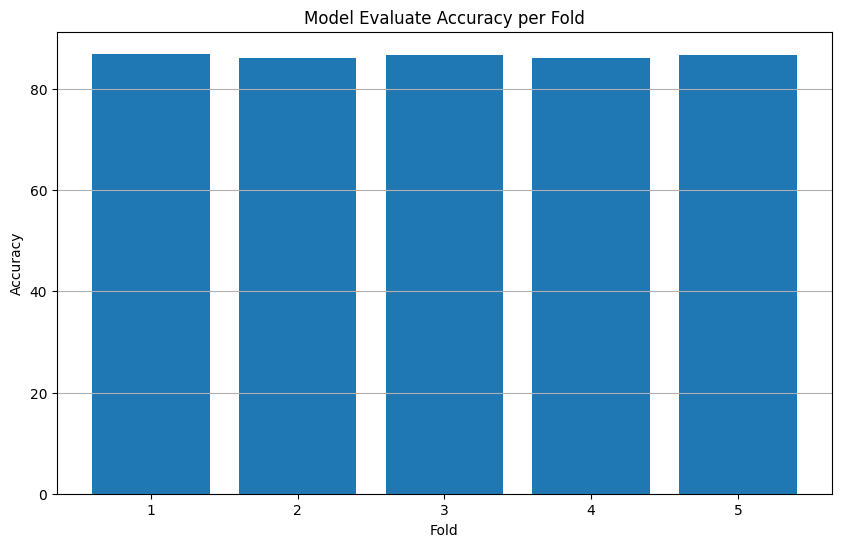

In [57]:
import matplotlib.pyplot as plt

# Buat figure dengan ukuran yang diinginkan
plt.figure(figsize=(10, 6))

# Buat grafik batang
plt.bar(range(1, len(accuracy_per_fold) + 1), accuracy_per_fold)

# Tambahkan judul dan label sumbu
plt.title('Model Evaluate Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')

# Tambahkan tanda pada sumbu x sesuai jumlah fold
plt.xticks(range(1, len(accuracy_per_fold) + 1))

# Tambahkan grid untuk memudahkan pembacaan nilai
plt.grid(True, axis='y')

# Tampilkan grafik
plt.show()

### LSTM

In [89]:
model2 = KerasClassifier(build_fn=create_lstm_model, input_shape=input_shape, num_classes=3, verbose=2)

In [90]:
grid2 = GridSearchCV(estimator=model2, param_grid=param_grid, n_jobs=-1)
grid_result2 = grid2.fit(X_train, y_train)

C:\Users\asus\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\asus\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
44/44 - 10s - 228ms/step - accuracy: 0.4725 - loss: 1.0480
Epoch 2/100
44/44 - 1s - 15ms/step - accuracy: 0.5043 - loss: 0.9911
Epoch 3/100
44/44 - 1s - 15ms/step - accuracy: 0.5058 - loss: 0.9874
Epoch 4/100
44/44 - 1s - 15ms/step - accuracy: 0.5196 - loss: 0.9867
Epoch 5/100
44/44 - 1s - 15ms/step - accuracy: 0.5123 - loss: 0.9853
Epoch 6/100
44/44 - 1s - 15ms/step - accuracy: 0.5123 - loss: 0.9808
Epoch 7/100
44/44 - 1s - 15ms/step - accuracy: 0.5283 - loss: 0.9754
Epoch 8/100
44/44 - 1s - 15ms/step - accuracy: 0.5080 - loss: 0.9837
Epoch 9/100
44/44 - 1s - 15ms/step - accuracy: 0.5101 - loss: 0.9892
Epoch 10/100
44/44 - 1s - 14ms/step - accuracy: 0.5290 - loss: 0.9702
Epoch 11/100
44/44 - 1s - 14ms/step - accuracy: 0.5152 - loss: 0.9761
Epoch 12/100
44/44 - 1s - 15ms/step - accuracy: 0.5225 - loss: 0.9749
Epoch 13/100
44/44 - 1s - 14ms/step - accuracy: 0.5174 - loss: 0.9708
Epoch 14/100
44/44 - 1s - 15ms/step - accuracy: 0.5116 - loss: 0.9722
Epoch 15/100
44/44 - 1s - 1

In [91]:
print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

Best: 0.788406 using {'batch_size': 32, 'epochs': 100}
0.505072 (0.026978) with: {'batch_size': 32, 'epochs': 10}
0.707971 (0.066081) with: {'batch_size': 32, 'epochs': 50}
0.788406 (0.031218) with: {'batch_size': 32, 'epochs': 100}
0.524638 (0.036188) with: {'batch_size': 64, 'epochs': 10}
0.621739 (0.057086) with: {'batch_size': 64, 'epochs': 50}
0.765217 (0.033631) with: {'batch_size': 64, 'epochs': 100}
0.521739 (0.031336) with: {'batch_size': 128, 'epochs': 10}
0.610145 (0.059075) with: {'batch_size': 128, 'epochs': 50}
0.750725 (0.030778) with: {'batch_size': 128, 'epochs': 100}


In [92]:
best_params2=grid_result2.best_params_ 
accuracy2=grid_result2.best_score_ 

print(best_params2)
print(accuracy2)

{'batch_size': 32, 'epochs': 100}
0.7884057971014492


In [58]:
from sklearn.model_selection import KFold
import numpy as np
import os

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Menyimpan hasil setiap fold
fold_no = 1
accuracy_per_fold = []
loss_per_fold = []

# Membuat direktori untuk menyimpan model jika belum ada
os.makedirs('models_lstm_tuning', exist_ok=True)

for train_index, val_index in kf.split(X_train):
    print(f'Fold {fold_no}')
    
    # Membagi data
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Membuat model baru
    model_lstm = create_lstm_model(input_shape, 3)
    
    # Melatih model
    lstm = model_lstm.fit(X_train_fold, y_train_fold, batch_size=32, epochs=100, validation_data=(X_val_fold, y_val_fold), verbose=2)
    
    # Evaluasi model pada data validasi fold
    scores = model_lstm.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Score for fold {fold_no}: {model_lstm.metrics_names[0]} of {scores[0]}; {model_lstm.metrics_names[1]} of {scores[1]*100}%')
    accuracy_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Simpan model
    model_filename = f'models_lstm_tuning/model_lstm_tuning_fold_{fold_no}.h5'
    model_lstm.save(model_filename)
    print(f'Model for fold {fold_no} saved as {model_filename}')
    
    fold_no += 1

# Menampilkan hasil akhir
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracy_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Fold 1
Epoch 1/100


C:\Users\asus\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 - 5s - 134ms/step - accuracy: 0.4701 - loss: 1.0272 - val_accuracy: 0.5399 - val_loss: 0.9773
Epoch 2/100
35/35 - 1s - 26ms/step - accuracy: 0.4991 - loss: 0.9812 - val_accuracy: 0.5254 - val_loss: 0.9743
Epoch 3/100
35/35 - 1s - 22ms/step - accuracy: 0.5018 - loss: 0.9892 - val_accuracy: 0.5254 - val_loss: 1.0087
Epoch 4/100
35/35 - 1s - 34ms/step - accuracy: 0.5145 - loss: 0.9858 - val_accuracy: 0.5326 - val_loss: 0.9691
Epoch 5/100
35/35 - 1s - 28ms/step - accuracy: 0.5181 - loss: 0.9807 - val_accuracy: 0.5181 - val_loss: 0.9800
Epoch 6/100
35/35 - 1s - 24ms/step - accuracy: 0.5100 - loss: 0.9754 - val_accuracy: 0.5399 - val_loss: 0.9639
Epoch 7/100
35/35 - 1s - 21ms/step - accuracy: 0.5236 - loss: 0.9735 - val_accuracy: 0.5471 - val_loss: 0.9742
Epoch 8/100
35/35 - 1s - 19ms/step - accuracy: 0.5082 - loss: 0.9731 - val_accuracy: 0.5471 - val_loss: 0.9603
Epoch 9/100
35/35 - 1s - 21ms/step - accuracy: 0.5199 - loss: 0.9702 - val_accuracy: 0.5399 - val_loss: 0.9592
Epoch 10/100

Score for fold 1: loss of 0.5092813968658447; compile_metrics of 73.9130437374115%
Model for fold 1 saved as models_lstm_tuning/model_lstm_tuning_fold_1.h5
Fold 2
Epoch 1/100
35/35 - 4s - 104ms/step - accuracy: 0.4511 - loss: 1.0584 - val_accuracy: 0.4928 - val_loss: 0.9913
Epoch 2/100
35/35 - 1s - 17ms/step - accuracy: 0.5027 - loss: 1.0123 - val_accuracy: 0.4239 - val_loss: 0.9955
Epoch 3/100
35/35 - 1s - 18ms/step - accuracy: 0.4837 - loss: 0.9939 - val_accuracy: 0.5181 - val_loss: 0.9792
Epoch 4/100
35/35 - 1s - 17ms/step - accuracy: 0.5072 - loss: 0.9943 - val_accuracy: 0.5326 - val_loss: 0.9671
Epoch 5/100
35/35 - 1s - 16ms/step - accuracy: 0.5009 - loss: 0.9915 - val_accuracy: 0.5217 - val_loss: 0.9849
Epoch 6/100
35/35 - 1s - 18ms/step - accuracy: 0.5045 - loss: 0.9868 - val_accuracy: 0.5326 - val_loss: 0.9653
Epoch 7/100
35/35 - 1s - 17ms/step - accuracy: 0.5082 - loss: 0.9829 - val_accuracy: 0.5217 - val_loss: 0.9589
Epoch 8/100
35/35 - 1s - 18ms/step - accuracy: 0.5036 - los

Score for fold 2: loss of 0.5561742782592773; compile_metrics of 74.27536249160767%
Model for fold 2 saved as models_lstm_tuning/model_lstm_tuning_fold_2.h5
Fold 3
Epoch 1/100
35/35 - 4s - 105ms/step - accuracy: 0.4538 - loss: 1.0458 - val_accuracy: 0.5217 - val_loss: 1.0018
Epoch 2/100
35/35 - 1s - 19ms/step - accuracy: 0.4955 - loss: 1.0063 - val_accuracy: 0.5290 - val_loss: 0.9665
Epoch 3/100
35/35 - 1s - 16ms/step - accuracy: 0.4982 - loss: 0.9941 - val_accuracy: 0.5362 - val_loss: 0.9739
Epoch 4/100
35/35 - 1s - 16ms/step - accuracy: 0.5082 - loss: 0.9873 - val_accuracy: 0.5217 - val_loss: 0.9609
Epoch 5/100
35/35 - 1s - 18ms/step - accuracy: 0.5290 - loss: 0.9787 - val_accuracy: 0.5254 - val_loss: 0.9491
Epoch 6/100
35/35 - 1s - 19ms/step - accuracy: 0.5236 - loss: 0.9737 - val_accuracy: 0.5254 - val_loss: 0.9500
Epoch 7/100
35/35 - 1s - 17ms/step - accuracy: 0.5226 - loss: 0.9759 - val_accuracy: 0.5109 - val_loss: 0.9521
Epoch 8/100
35/35 - 1s - 17ms/step - accuracy: 0.5317 - lo

Score for fold 3: loss of 0.46535933017730713; compile_metrics of 78.2608687877655%
Model for fold 3 saved as models_lstm_tuning/model_lstm_tuning_fold_3.h5
Fold 4
Epoch 1/100
35/35 - 4s - 101ms/step - accuracy: 0.4819 - loss: 1.0402 - val_accuracy: 0.5109 - val_loss: 0.9998
Epoch 2/100
35/35 - 1s - 18ms/step - accuracy: 0.5118 - loss: 0.9996 - val_accuracy: 0.5145 - val_loss: 0.9631
Epoch 3/100
35/35 - 1s - 17ms/step - accuracy: 0.4855 - loss: 1.0019 - val_accuracy: 0.5109 - val_loss: 0.9666
Epoch 4/100
35/35 - 1s - 18ms/step - accuracy: 0.5027 - loss: 0.9859 - val_accuracy: 0.5217 - val_loss: 0.9578
Epoch 5/100
35/35 - 1s - 18ms/step - accuracy: 0.5172 - loss: 0.9819 - val_accuracy: 0.5145 - val_loss: 0.9493
Epoch 6/100
35/35 - 1s - 17ms/step - accuracy: 0.5199 - loss: 0.9780 - val_accuracy: 0.5217 - val_loss: 0.9553
Epoch 7/100
35/35 - 1s - 18ms/step - accuracy: 0.5290 - loss: 0.9913 - val_accuracy: 0.5181 - val_loss: 0.9507
Epoch 8/100
35/35 - 1s - 26ms/step - accuracy: 0.5217 - lo

Score for fold 4: loss of 0.5089513659477234; compile_metrics of 80.79710006713867%
Model for fold 4 saved as models_lstm_tuning/model_lstm_tuning_fold_4.h5
Fold 5
Epoch 1/100
35/35 - 4s - 105ms/step - accuracy: 0.4692 - loss: 1.0627 - val_accuracy: 0.4565 - val_loss: 1.0285
Epoch 2/100
35/35 - 1s - 17ms/step - accuracy: 0.5100 - loss: 0.9886 - val_accuracy: 0.4529 - val_loss: 1.0416
Epoch 3/100
35/35 - 1s - 18ms/step - accuracy: 0.5208 - loss: 0.9720 - val_accuracy: 0.4384 - val_loss: 1.0374
Epoch 4/100
35/35 - 1s - 17ms/step - accuracy: 0.5299 - loss: 0.9683 - val_accuracy: 0.4529 - val_loss: 1.0316
Epoch 5/100
35/35 - 1s - 17ms/step - accuracy: 0.5263 - loss: 0.9657 - val_accuracy: 0.4457 - val_loss: 1.0374
Epoch 6/100
35/35 - 1s - 18ms/step - accuracy: 0.5290 - loss: 0.9579 - val_accuracy: 0.4601 - val_loss: 1.0490
Epoch 7/100
35/35 - 1s - 18ms/step - accuracy: 0.5172 - loss: 0.9707 - val_accuracy: 0.4746 - val_loss: 1.0203
Epoch 8/100
35/35 - 1s - 16ms/step - accuracy: 0.5290 - lo

Score for fold 5: loss of 0.4735695719718933; compile_metrics of 78.2608687877655%
Model for fold 5 saved as models_lstm_tuning/model_lstm_tuning_fold_5.h5
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.5092813968658447 - Accuracy: 73.9130437374115%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.5561742782592773 - Accuracy: 74.27536249160767%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.46535933017730713 - Accuracy: 78.2608687877655%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.5089513659477234 - Accuracy: 80.79710006713867%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.4735695719718933 - Accuracy: 78.2608687877655%
----------------------------------------------------------

In [59]:
# Menampilkan akurasi per fold
print('Data Training Accuracy per fold:')
for i in range(len(accuracy_per_fold)):
    print(f'Fold {i+1}: {accuracy_per_fold[i]}%')

Data Training Accuracy per fold:
Fold 1: 73.9130437374115%
Fold 2: 74.27536249160767%
Fold 3: 78.2608687877655%
Fold 4: 80.79710006713867%
Fold 5: 78.2608687877655%


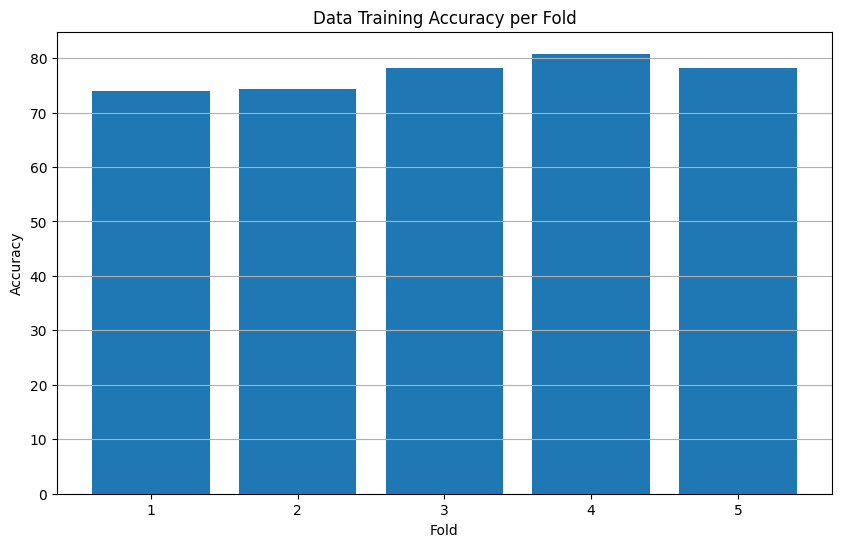

In [60]:
import matplotlib.pyplot as plt

# Buat figure dengan ukuran yang diinginkan
plt.figure(figsize=(10, 6))

# Buat grafik batang
plt.bar(range(1, len(accuracy_per_fold) + 1), accuracy_per_fold)

# Tambahkan judul dan label sumbu
plt.title('Data Training Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')

# Tambahkan tanda pada sumbu x sesuai jumlah fold
plt.xticks(range(1, len(accuracy_per_fold) + 1))

# Tambahkan grid untuk memudahkan pembacaan nilai
plt.grid(True, axis='y')

# Tampilkan grafik
plt.show()

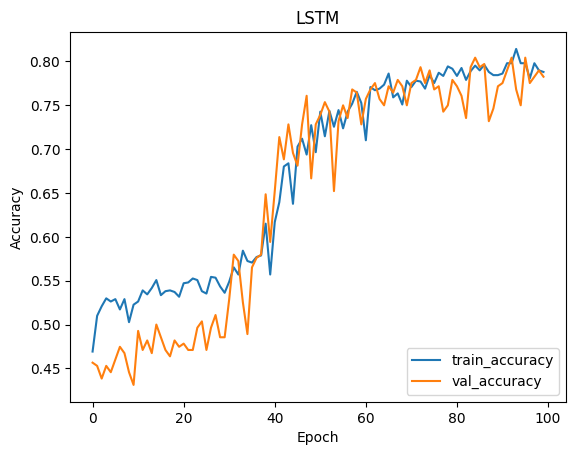

In [61]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('LSTM')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

# Gunakan fungsi plot_learning_curves dengan parameter objek history dari model.fit
plot_learning_curves(lstm)

In [62]:
import numpy as np
from keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report
import shutil

# Asumsikan X_test dan y_test adalah dataset yang digunakan untuk evaluasi
# Anda harus mengganti ini dengan data yang sesuai

# Jumlah fold yang digunakan selama cross-validation
n_folds = 5

# List untuk menyimpan hasil evaluasi
accuracy_per_fold = []
loss_per_fold = []

# Variabel untuk melacak model dengan akurasi terbaik
best_accuracy = 0.0
best_model_filename = None

for fold_no in range(1, n_folds + 1):
    # Membuat path ke model yang disimpan
    model_filename = f'models_lstm_tuning/model_lstm_tuning_fold_{fold_no}.h5'
    
    # Memuat model
    model = load_model(model_filename)
    
    # Evaluasi model pada data uji
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'Fold {fold_no} - Loss: {loss} - Accuracy: {accuracy * 100}%')
    accuracy_per_fold.append(accuracy * 100)
    loss_per_fold.append(loss)
    
    # Cek apakah model saat ini adalah yang terbaik
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_filename = model_filename

    # Prediksi label menggunakan model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)  # Bentuk one-hot encoded

    # Hitung accuracy score
    acc_score = accuracy_score(y_true, y_pred_classes)
    print(f'Model Evaluate Accuracy Score for fold {fold_no}: {acc_score * 100}%')

    # Laporan klasifikasi
    print(f'Classification Report for fold {fold_no}:\n', classification_report(y_true, y_pred_classes))

# Menampilkan hasil akhir
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracy_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

# Menyimpan model dengan akurasi terbaik
if best_model_filename:
    shutil.copy(best_model_filename, 'modelTuning2.h5')
    print(f'Model with the best accuracy saved as modelTuning2.h5 with accuracy: {best_accuracy * 100}%')

Fold 1 - Loss: 0.435282438993454 - Accuracy: 79.1304349899292%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


Model Evaluate Accuracy Score for fold 1: 79.13043478260869%
Classification Report for fold 1:
               precision    recall  f1-score   support

           0       0.77      0.70      0.73       126
           1       0.67      0.71      0.69       109
           2       0.94      0.98      0.96       110

    accuracy                           0.79       345
   macro avg       0.79      0.80      0.79       345
weighted avg       0.79      0.79      0.79       345

Fold 2 - Loss: 0.5278542637825012 - Accuracy: 72.46376872062683%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


Model Evaluate Accuracy Score for fold 2: 72.46376811594203%
Classification Report for fold 2:
               precision    recall  f1-score   support

           0       0.63      0.78      0.70       126
           1       0.63      0.51      0.57       109
           2       0.96      0.87      0.91       110

    accuracy                           0.72       345
   macro avg       0.74      0.72      0.72       345
weighted avg       0.73      0.72      0.72       345

Fold 3 - Loss: 0.44411757588386536 - Accuracy: 78.55072617530823%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


Model Evaluate Accuracy Score for fold 3: 78.55072463768116%
Classification Report for fold 3:
               precision    recall  f1-score   support

           0       0.74      0.71      0.72       126
           1       0.67      0.72      0.70       109
           2       0.96      0.94      0.95       110

    accuracy                           0.79       345
   macro avg       0.79      0.79      0.79       345
weighted avg       0.79      0.79      0.79       345

Fold 4 - Loss: 0.497352659702301 - Accuracy: 75.07246136665344%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


Model Evaluate Accuracy Score for fold 4: 75.07246376811594%
Classification Report for fold 4:
               precision    recall  f1-score   support

           0       0.67      0.75      0.71       126
           1       0.65      0.59      0.62       109
           2       0.95      0.91      0.93       110

    accuracy                           0.75       345
   macro avg       0.76      0.75      0.75       345
weighted avg       0.75      0.75      0.75       345

Fold 5 - Loss: 0.46717798709869385 - Accuracy: 79.1304349899292%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Model Evaluate Accuracy Score for fold 5: 79.13043478260869%
Classification Report for fold 5:
               precision    recall  f1-score   support

           0       0.71      0.82      0.76       126
           1       0.73      0.60      0.66       109
           2       0.95      0.95      0.95       110

    accuracy                           0.79       345
   macro avg       0.80      0.79      0.79       

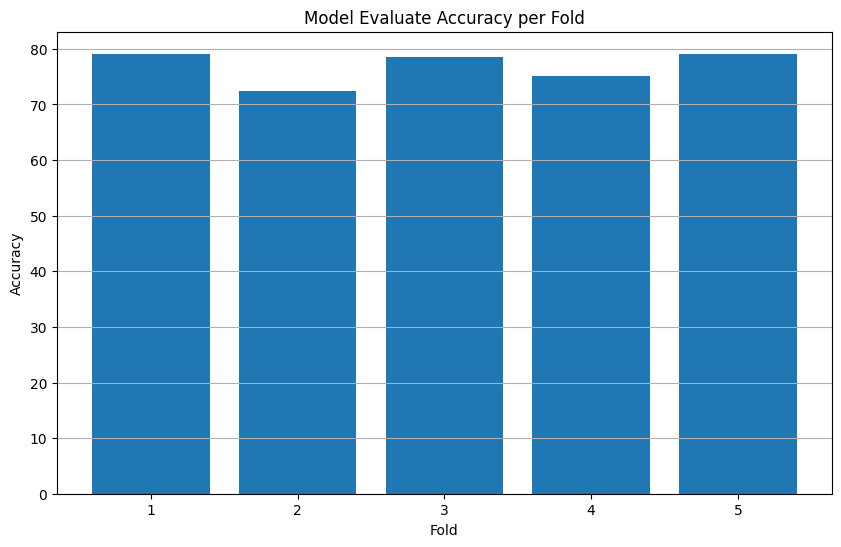

In [63]:
import matplotlib.pyplot as plt

# Buat figure dengan ukuran yang diinginkan
plt.figure(figsize=(10, 6))

# Buat grafik batang
plt.bar(range(1, len(accuracy_per_fold) + 1), accuracy_per_fold)

# Tambahkan judul dan label sumbu
plt.title('Model Evaluate Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')

# Tambahkan tanda pada sumbu x sesuai jumlah fold
plt.xticks(range(1, len(accuracy_per_fold) + 1))

# Tambahkan grid untuk memudahkan pembacaan nilai
plt.grid(True, axis='y')

# Tampilkan grafik
plt.show()

### RNN

In [100]:
model3 = KerasClassifier(build_fn=create_rnn_model, input_shape=input_shape, num_classes=3, verbose=2)

In [101]:
grid3 = GridSearchCV(estimator=model3, param_grid=param_grid, n_jobs=-1)
grid_result3 = grid3.fit(X_train, y_train)

C:\Users\asus\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\asus\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
22/22 - 5s - 209ms/step - accuracy: 0.4072 - loss: 1.0864
Epoch 2/100
22/22 - 0s - 11ms/step - accuracy: 0.4833 - loss: 1.0041
Epoch 3/100
22/22 - 0s - 10ms/step - accuracy: 0.4920 - loss: 1.0037
Epoch 4/100
22/22 - 0s - 10ms/step - accuracy: 0.5094 - loss: 0.9812
Epoch 5/100
22/22 - 0s - 10ms/step - accuracy: 0.5094 - loss: 0.9777
Epoch 6/100
22/22 - 0s - 10ms/step - accuracy: 0.5123 - loss: 0.9909
Epoch 7/100
22/22 - 0s - 10ms/step - accuracy: 0.5174 - loss: 0.9710
Epoch 8/100
22/22 - 0s - 10ms/step - accuracy: 0.5145 - loss: 0.9796
Epoch 9/100
22/22 - 0s - 10ms/step - accuracy: 0.5304 - loss: 0.9784
Epoch 10/100
22/22 - 0s - 11ms/step - accuracy: 0.5159 - loss: 0.9704
Epoch 11/100
22/22 - 0s - 11ms/step - accuracy: 0.5413 - loss: 0.9609
Epoch 12/100
22/22 - 0s - 10ms/step - accuracy: 0.5246 - loss: 0.9639
Epoch 13/100
22/22 - 0s - 10ms/step - accuracy: 0.5261 - loss: 0.9478
Epoch 14/100
22/22 - 0s - 10ms/step - accuracy: 0.5181 - loss: 0.9576
Epoch 15/100
22/22 - 0s - 10

In [102]:
print("Best: %f using %s" % (grid_result3.best_score_, grid_result3.best_params_))
means = grid_result3.cv_results_['mean_test_score']
stds = grid_result3.cv_results_['std_test_score']
params = grid_result3.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

Best: 0.836232 using {'batch_size': 64, 'epochs': 100}
0.527536 (0.044173) with: {'batch_size': 32, 'epochs': 10}
0.764493 (0.033049) with: {'batch_size': 32, 'epochs': 50}
0.818116 (0.038028) with: {'batch_size': 32, 'epochs': 100}
0.523188 (0.035544) with: {'batch_size': 64, 'epochs': 10}
0.727536 (0.089732) with: {'batch_size': 64, 'epochs': 50}
0.836232 (0.023075) with: {'batch_size': 64, 'epochs': 100}
0.528986 (0.042747) with: {'batch_size': 128, 'epochs': 10}
0.694203 (0.074978) with: {'batch_size': 128, 'epochs': 50}
0.825362 (0.026664) with: {'batch_size': 128, 'epochs': 100}


In [103]:
best_params3=grid_result3.best_params_ 
accuracy3=grid_result3.best_score_ 

print(best_params3)
print(accuracy3)

{'batch_size': 64, 'epochs': 100}
0.8362318840579711


In [64]:
from sklearn.model_selection import KFold
import numpy as np
import os

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Menyimpan hasil setiap fold
fold_no = 1
accuracy_per_fold = []
loss_per_fold = []

# Membuat direktori untuk menyimpan model jika belum ada
os.makedirs('models_rnn_tuning', exist_ok=True)

for train_index, val_index in kf.split(X_train):
    print(f'Fold {fold_no}')
    
    # Membagi data
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Membuat model baru
    model_rnn = create_rnn_model(input_shape, 3)
    
    # Melatih model
    rnn = model_rnn.fit(X_train_fold, y_train_fold, batch_size=64, epochs=100, validation_data=(X_val_fold, y_val_fold), verbose=2)
    
    # Evaluasi model pada data validasi fold
    scores = model_rnn.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Score for fold {fold_no}: {model_rnn.metrics_names[0]} of {scores[0]}; {model_rnn.metrics_names[1]} of {scores[1]*100}%')
    accuracy_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Simpan model
    model_filename = f'models_rnn_tuning/model_rnn_tuning_fold_{fold_no}.h5'
    model_rnn.save(model_filename)
    print(f'Model for fold {fold_no} saved as {model_filename}')
    
    fold_no += 1

# Menampilkan hasil akhir
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracy_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


Fold 1
Epoch 1/100


C:\Users\asus\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 - 4s - 240ms/step - accuracy: 0.3931 - loss: 1.0923 - val_accuracy: 0.3152 - val_loss: 1.0987
Epoch 2/100
18/18 - 0s - 20ms/step - accuracy: 0.4611 - loss: 1.0275 - val_accuracy: 0.5072 - val_loss: 1.0019
Epoch 3/100
18/18 - 0s - 17ms/step - accuracy: 0.4891 - loss: 0.9989 - val_accuracy: 0.5181 - val_loss: 1.0478
Epoch 4/100
18/18 - 0s - 17ms/step - accuracy: 0.4828 - loss: 1.0039 - val_accuracy: 0.5290 - val_loss: 0.9828
Epoch 5/100
18/18 - 0s - 23ms/step - accuracy: 0.5091 - loss: 0.9859 - val_accuracy: 0.5399 - val_loss: 1.0129
Epoch 6/100
18/18 - 0s - 17ms/step - accuracy: 0.5109 - loss: 0.9950 - val_accuracy: 0.5543 - val_loss: 0.9782
Epoch 7/100
18/18 - 0s - 17ms/step - accuracy: 0.4937 - loss: 1.0001 - val_accuracy: 0.5362 - val_loss: 0.9668
Epoch 8/100
18/18 - 0s - 16ms/step - accuracy: 0.5109 - loss: 0.9831 - val_accuracy: 0.5471 - val_loss: 0.9710
Epoch 9/100
18/18 - 0s - 15ms/step - accuracy: 0.4792 - loss: 0.9849 - val_accuracy: 0.5507 - val_loss: 0.9725
Epoch 10/100

Score for fold 1: loss of 0.6016335487365723; compile_metrics of 72.46376872062683%
Model for fold 1 saved as models_rnn_tuning/model_rnn_tuning_fold_1.h5
Fold 2
Epoch 1/100
18/18 - 3s - 148ms/step - accuracy: 0.4167 - loss: 1.0702 - val_accuracy: 0.4783 - val_loss: 1.0209
Epoch 2/100
18/18 - 0s - 12ms/step - accuracy: 0.4583 - loss: 1.0270 - val_accuracy: 0.4348 - val_loss: 0.9912
Epoch 3/100
18/18 - 0s - 12ms/step - accuracy: 0.4819 - loss: 1.0102 - val_accuracy: 0.5290 - val_loss: 0.9744
Epoch 4/100
18/18 - 0s - 13ms/step - accuracy: 0.4973 - loss: 1.0019 - val_accuracy: 0.5217 - val_loss: 0.9681
Epoch 5/100
18/18 - 0s - 13ms/step - accuracy: 0.5018 - loss: 0.9863 - val_accuracy: 0.5362 - val_loss: 0.9602
Epoch 6/100
18/18 - 0s - 13ms/step - accuracy: 0.4918 - loss: 0.9785 - val_accuracy: 0.5072 - val_loss: 0.9683
Epoch 7/100
18/18 - 0s - 13ms/step - accuracy: 0.5145 - loss: 0.9735 - val_accuracy: 0.5580 - val_loss: 0.9519
Epoch 8/100
18/18 - 0s - 12ms/step - accuracy: 0.5154 - loss

Score for fold 2: loss of 0.42550787329673767; compile_metrics of 84.78260636329651%
Model for fold 2 saved as models_rnn_tuning/model_rnn_tuning_fold_2.h5
Fold 3
Epoch 1/100
18/18 - 3s - 156ms/step - accuracy: 0.3877 - loss: 1.1377 - val_accuracy: 0.4964 - val_loss: 1.0171
Epoch 2/100
18/18 - 0s - 11ms/step - accuracy: 0.4457 - loss: 1.0442 - val_accuracy: 0.5145 - val_loss: 0.9691
Epoch 3/100
18/18 - 0s - 12ms/step - accuracy: 0.4810 - loss: 1.0027 - val_accuracy: 0.5036 - val_loss: 0.9862
Epoch 4/100
18/18 - 0s - 12ms/step - accuracy: 0.4692 - loss: 1.0022 - val_accuracy: 0.5507 - val_loss: 0.9457
Epoch 5/100
18/18 - 0s - 12ms/step - accuracy: 0.5109 - loss: 0.9843 - val_accuracy: 0.5181 - val_loss: 0.9686
Epoch 6/100
18/18 - 0s - 11ms/step - accuracy: 0.5082 - loss: 0.9848 - val_accuracy: 0.5507 - val_loss: 0.9444
Epoch 7/100
18/18 - 0s - 12ms/step - accuracy: 0.5217 - loss: 0.9671 - val_accuracy: 0.5507 - val_loss: 0.9396
Epoch 8/100
18/18 - 0s - 13ms/step - accuracy: 0.5290 - los

Score for fold 3: loss of 0.43523234128952026; compile_metrics of 80.07246255874634%
Model for fold 3 saved as models_rnn_tuning/model_rnn_tuning_fold_3.h5
Fold 4
Epoch 1/100
18/18 - 3s - 158ms/step - accuracy: 0.4330 - loss: 1.0557 - val_accuracy: 0.5254 - val_loss: 0.9682
Epoch 2/100
18/18 - 0s - 13ms/step - accuracy: 0.4719 - loss: 1.0256 - val_accuracy: 0.5217 - val_loss: 0.9580
Epoch 3/100
18/18 - 0s - 12ms/step - accuracy: 0.4928 - loss: 1.0125 - val_accuracy: 0.5072 - val_loss: 0.9481
Epoch 4/100
18/18 - 0s - 12ms/step - accuracy: 0.4946 - loss: 1.0087 - val_accuracy: 0.5217 - val_loss: 0.9426
Epoch 5/100
18/18 - 0s - 12ms/step - accuracy: 0.4764 - loss: 1.0044 - val_accuracy: 0.5254 - val_loss: 0.9373
Epoch 6/100
18/18 - 0s - 12ms/step - accuracy: 0.4864 - loss: 0.9981 - val_accuracy: 0.5326 - val_loss: 0.9365
Epoch 7/100
18/18 - 0s - 12ms/step - accuracy: 0.5045 - loss: 0.9897 - val_accuracy: 0.5326 - val_loss: 0.9353
Epoch 8/100
18/18 - 0s - 12ms/step - accuracy: 0.5100 - los

Score for fold 4: loss of 0.4896751046180725; compile_metrics of 80.79710006713867%
Model for fold 4 saved as models_rnn_tuning/model_rnn_tuning_fold_4.h5
Fold 5
Epoch 1/100
18/18 - 3s - 153ms/step - accuracy: 0.4221 - loss: 1.0629 - val_accuracy: 0.4420 - val_loss: 1.0421
Epoch 2/100
18/18 - 0s - 14ms/step - accuracy: 0.4918 - loss: 0.9882 - val_accuracy: 0.4601 - val_loss: 1.0777
Epoch 3/100
18/18 - 0s - 14ms/step - accuracy: 0.5236 - loss: 0.9759 - val_accuracy: 0.4674 - val_loss: 1.0233
Epoch 4/100
18/18 - 0s - 13ms/step - accuracy: 0.5000 - loss: 0.9785 - val_accuracy: 0.4457 - val_loss: 1.0593
Epoch 5/100
18/18 - 0s - 12ms/step - accuracy: 0.5100 - loss: 0.9764 - val_accuracy: 0.4710 - val_loss: 1.0516
Epoch 6/100
18/18 - 0s - 12ms/step - accuracy: 0.5236 - loss: 0.9589 - val_accuracy: 0.4493 - val_loss: 1.0455
Epoch 7/100
18/18 - 0s - 12ms/step - accuracy: 0.5136 - loss: 0.9620 - val_accuracy: 0.4601 - val_loss: 1.0238
Epoch 8/100
18/18 - 0s - 12ms/step - accuracy: 0.5272 - loss

Score for fold 5: loss of 0.5490755438804626; compile_metrics of 76.0869562625885%
Model for fold 5 saved as models_rnn_tuning/model_rnn_tuning_fold_5.h5
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.6016335487365723 - Accuracy: 72.46376872062683%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.42550787329673767 - Accuracy: 84.78260636329651%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.43523234128952026 - Accuracy: 80.07246255874634%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.4896751046180725 - Accuracy: 80.79710006713867%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.5490755438804626 - Accuracy: 76.0869562625885%
---------------------------------------------------------

In [65]:
# Menampilkan akurasi per fold
print('Data Training Accuracy per fold:')
for i in range(len(accuracy_per_fold)):
    print(f'Fold {i+1}: {accuracy_per_fold[i]}%')

Data Training Accuracy per fold:
Fold 1: 72.46376872062683%
Fold 2: 84.78260636329651%
Fold 3: 80.07246255874634%
Fold 4: 80.79710006713867%
Fold 5: 76.0869562625885%


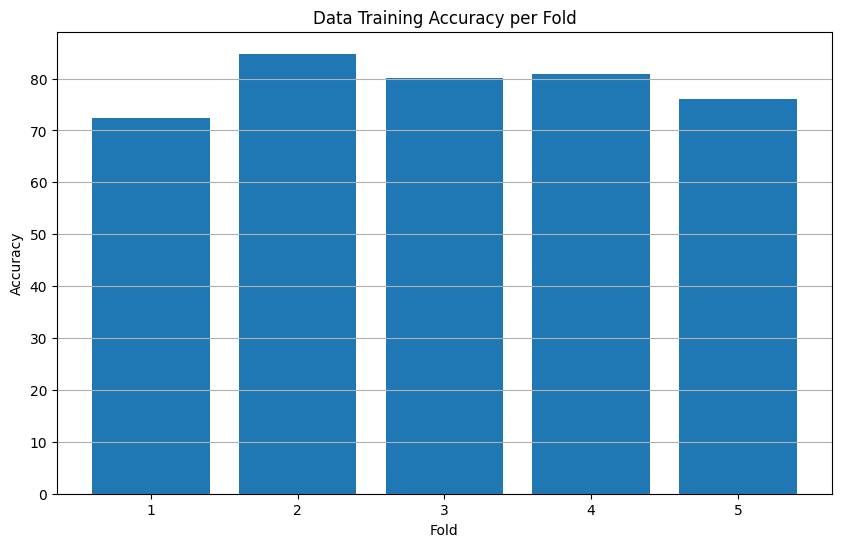

In [66]:
import matplotlib.pyplot as plt

# Buat figure dengan ukuran yang diinginkan
plt.figure(figsize=(10, 6))

# Buat grafik batang
plt.bar(range(1, len(accuracy_per_fold) + 1), accuracy_per_fold)

# Tambahkan judul dan label sumbu
plt.title('Data Training Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')

# Tambahkan tanda pada sumbu x sesuai jumlah fold
plt.xticks(range(1, len(accuracy_per_fold) + 1))

# Tambahkan grid untuk memudahkan pembacaan nilai
plt.grid(True, axis='y')

# Tampilkan grafik
plt.show()

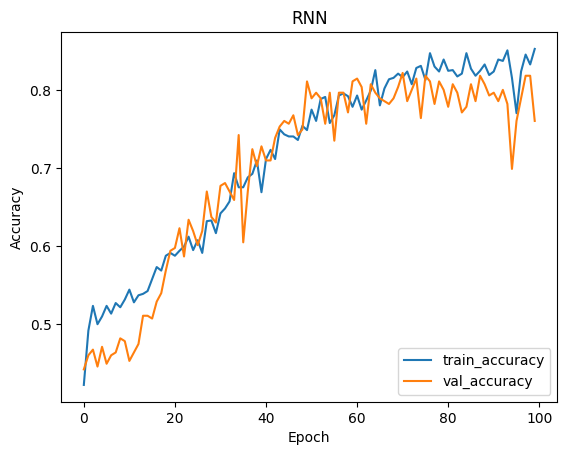

In [67]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('RNN')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

# Gunakan fungsi plot_learning_curves dengan parameter objek history dari model.fit
plot_learning_curves(rnn)

In [68]:
import numpy as np
from keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report
import shutil

# Asumsikan X_test dan y_test adalah dataset yang digunakan untuk evaluasi
# Anda harus mengganti ini dengan data yang sesuai

# Jumlah fold yang digunakan selama cross-validation
n_folds = 5

# List untuk menyimpan hasil evaluasi
accuracy_per_fold = []
loss_per_fold = []

# Variabel untuk melacak model dengan akurasi terbaik
best_accuracy = 0.0
best_model_filename = None

for fold_no in range(1, n_folds + 1):
    # Membuat path ke model yang disimpan
    model_filename = f'models_rnn_tuning/model_rnn_tuning_fold_{fold_no}.h5'
    
    # Memuat model
    model = load_model(model_filename)
    
    # Evaluasi model pada data uji
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'Fold {fold_no} - Loss: {loss} - Accuracy: {accuracy * 100}%')
    accuracy_per_fold.append(accuracy * 100)
    loss_per_fold.append(loss)
    
    # Cek apakah model saat ini adalah yang terbaik
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_filename = model_filename

    # Prediksi label menggunakan model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)  # Bentuk one-hot encoded

    # Hitung accuracy score
    acc_score = accuracy_score(y_true, y_pred_classes)
    print(f'Model Evaluate Accuracy Score for fold {fold_no}: {acc_score * 100}%')

    # Laporan klasifikasi
    print(f'Classification Report for fold {fold_no}:\n', classification_report(y_true, y_pred_classes))

# Menampilkan hasil akhir
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracy_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

# Menyimpan model dengan akurasi terbaik
if best_model_filename:
    shutil.copy(best_model_filename, 'modelTuning3.h5')
    print(f'Model with the best accuracy saved as modelTuning3.h5 with accuracy: {best_accuracy * 100}%')

Fold 1 - Loss: 0.6368966698646545 - Accuracy: 75.94202756881714%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


Model Evaluate Accuracy Score for fold 1: 75.94202898550725%
Classification Report for fold 1:
               precision    recall  f1-score   support

           0       0.66      0.83      0.73       126
           1       0.73      0.61      0.66       109
           2       0.94      0.84      0.88       110

    accuracy                           0.76       345
   macro avg       0.78      0.76      0.76       345
weighted avg       0.77      0.76      0.76       345

Fold 2 - Loss: 0.4826381206512451 - Accuracy: 81.15941882133484%
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step


Model Evaluate Accuracy Score for fold 2: 81.15942028985508%
Classification Report for fold 2:
               precision    recall  f1-score   support

           0       0.72      0.89      0.79       126
           1       0.81      0.64      0.72       109
           2       0.95      0.89      0.92       110

    accuracy                           0.81       345
   macro avg       0.83      0.81      0.81       345
weighted avg       0.82      0.81      0.81       345

Fold 3 - Loss: 0.4811016023159027 - Accuracy: 79.42029237747192%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


Model Evaluate Accuracy Score for fold 3: 79.42028985507247%
Classification Report for fold 3:
               precision    recall  f1-score   support

           0       0.67      0.94      0.79       126
           1       0.87      0.50      0.63       109
           2       0.95      0.92      0.94       110

    accuracy                           0.79       345
   macro avg       0.83      0.79      0.78       345
weighted avg       0.82      0.79      0.78       345

Fold 4 - Loss: 0.5098410844802856 - Accuracy: 80.57971000671387%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


Model Evaluate Accuracy Score for fold 4: 80.57971014492755%
Classification Report for fold 4:
               precision    recall  f1-score   support

           0       0.74      0.87      0.80       126
           1       0.77      0.69      0.73       109
           2       0.93      0.85      0.89       110

    accuracy                           0.81       345
   macro avg       0.82      0.80      0.81       345
weighted avg       0.81      0.81      0.81       345

Fold 5 - Loss: 0.504662036895752 - Accuracy: 79.1304349899292%
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Model Evaluate Accuracy Score for fold 5: 79.13043478260869%
Classification Report for fold 5:
               precision    recall  f1-score   support

           0       0.80      0.63      0.70       126
           1       0.67      0.90      0.77       109
           2       0.96      0.87      0.91       110

    accuracy                           0.79       345
   macro avg       0.81      0.80      0.80       34

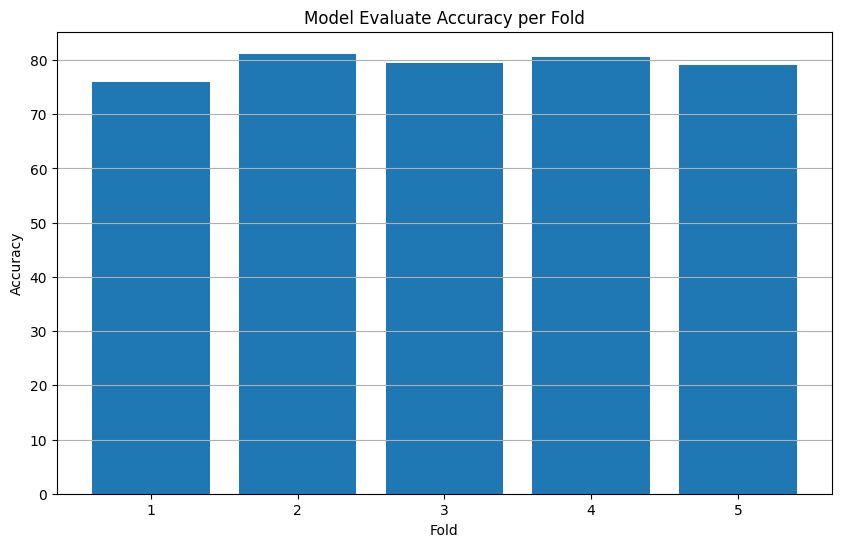

In [69]:
import matplotlib.pyplot as plt

# Buat figure dengan ukuran yang diinginkan
plt.figure(figsize=(10, 6))

# Buat grafik batang
plt.bar(range(1, len(accuracy_per_fold) + 1), accuracy_per_fold)

# Tambahkan judul dan label sumbu
plt.title('Model Evaluate Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')

# Tambahkan tanda pada sumbu x sesuai jumlah fold
plt.xticks(range(1, len(accuracy_per_fold) + 1))

# Tambahkan grid untuk memudahkan pembacaan nilai
plt.grid(True, axis='y')

# Tampilkan grafik
plt.show()

### DNN

In [110]:
model4 = KerasClassifier(build_fn=create_dnn_model, input_shape=input_shape, num_classes=3, verbose=2)

In [111]:
grid4 = GridSearchCV(estimator=model4, param_grid=param_grid, n_jobs=-1)
grid_result4 = grid4.fit(X_train, y_train)

C:\Users\asus\AppData\Roaming\Python\Python310\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\asus\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
44/44 - 4s - 83ms/step - accuracy: 0.3225 - loss: 1.3218
Epoch 2/100
44/44 - 0s - 7ms/step - accuracy: 0.4130 - loss: 1.1437
Epoch 3/100
44/44 - 0s - 5ms/step - accuracy: 0.4558 - loss: 1.0890
Epoch 4/100
44/44 - 0s - 4ms/step - accuracy: 0.4464 - loss: 1.0760
Epoch 5/100
44/44 - 0s - 4ms/step - accuracy: 0.4971 - loss: 1.0584
Epoch 6/100
44/44 - 0s - 5ms/step - accuracy: 0.5116 - loss: 1.0364
Epoch 7/100
44/44 - 0s - 4ms/step - accuracy: 0.5783 - loss: 1.0003
Epoch 8/100
44/44 - 0s - 5ms/step - accuracy: 0.6362 - loss: 0.9533
Epoch 9/100
44/44 - 0s - 5ms/step - accuracy: 0.6464 - loss: 0.8911
Epoch 10/100
44/44 - 0s - 4ms/step - accuracy: 0.6696 - loss: 0.8303
Epoch 11/100
44/44 - 0s - 5ms/step - accuracy: 0.7080 - loss: 0.7486
Epoch 12/100
44/44 - 0s - 5ms/step - accuracy: 0.7072 - loss: 0.7301
Epoch 13/100
44/44 - 0s - 5ms/step - accuracy: 0.7174 - loss: 0.6814
Epoch 14/100
44/44 - 0s - 4ms/step - accuracy: 0.7341 - loss: 0.6629
Epoch 15/100
44/44 - 0s - 4ms/step - accur

In [112]:
print("Best: %f using %s" % (grid_result4.best_score_, grid_result4.best_params_))
means = grid_result4.cv_results_['mean_test_score']
stds = grid_result4.cv_results_['std_test_score']
params = grid_result4.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, std, param))

Best: 0.836957 using {'batch_size': 32, 'epochs': 100}
0.689130 (0.028381) with: {'batch_size': 32, 'epochs': 10}
0.822464 (0.039157) with: {'batch_size': 32, 'epochs': 50}
0.836957 (0.032729) with: {'batch_size': 32, 'epochs': 100}
0.573188 (0.085783) with: {'batch_size': 64, 'epochs': 10}
0.816667 (0.026387) with: {'batch_size': 64, 'epochs': 50}
0.818116 (0.041081) with: {'batch_size': 64, 'epochs': 100}
0.471739 (0.056102) with: {'batch_size': 128, 'epochs': 10}
0.778261 (0.027345) with: {'batch_size': 128, 'epochs': 50}
0.818116 (0.048578) with: {'batch_size': 128, 'epochs': 100}


In [113]:
best_params4=grid_result4.best_params_ 
accuracy4=grid_result4.best_score_ 

print(best_params4)
print(accuracy4)

{'batch_size': 32, 'epochs': 100}
0.8369565217391305


In [70]:
from sklearn.model_selection import KFold
import numpy as np
import os

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Menyimpan hasil setiap fold
fold_no = 1
accuracy_per_fold = []
loss_per_fold = []

# Membuat direktori untuk menyimpan model jika belum ada
os.makedirs('models_dnn_tuning', exist_ok=True)

for train_index, val_index in kf.split(X_train):
    print(f'Fold {fold_no}')
    
    # Membagi data
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    # Membuat model baru
    model_dnn = create_dnn_model(input_shape, 3)
    
    # Melatih model
    dnn = model_dnn.fit(X_train_fold, y_train_fold, batch_size=32, epochs=100, validation_data=(X_val_fold, y_val_fold), verbose=2)
    
    # Evaluasi model pada data validasi fold
    scores = model_dnn.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f'Score for fold {fold_no}: {model_dnn.metrics_names[0]} of {scores[0]}; {model_dnn.metrics_names[1]} of {scores[1]*100}%')
    accuracy_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    # Simpan model
    model_filename = f'models_dnn_tuning/model_dnn_tuning_fold_{fold_no}.h5'
    model_dnn.save(model_filename)
    print(f'Model for fold {fold_no} saved as {model_filename}')
    
    fold_no += 1

# Menampilkan hasil akhir
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracy_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Fold 1
Epoch 1/100


C:\Users\asus\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


35/35 - 2s - 61ms/step - accuracy: 0.3342 - loss: 1.5188 - val_accuracy: 0.4167 - val_loss: 1.1194
Epoch 2/100
35/35 - 0s - 9ms/step - accuracy: 0.4257 - loss: 1.1907 - val_accuracy: 0.3551 - val_loss: 1.0795
Epoch 3/100
35/35 - 0s - 8ms/step - accuracy: 0.4420 - loss: 1.1967 - val_accuracy: 0.3333 - val_loss: 1.1091
Epoch 4/100
35/35 - 0s - 8ms/step - accuracy: 0.4212 - loss: 1.1439 - val_accuracy: 0.3333 - val_loss: 1.0846
Epoch 5/100
35/35 - 0s - 7ms/step - accuracy: 0.4402 - loss: 1.0999 - val_accuracy: 0.3406 - val_loss: 1.0771
Epoch 6/100
35/35 - 0s - 7ms/step - accuracy: 0.4611 - loss: 1.0855 - val_accuracy: 0.3478 - val_loss: 1.0922
Epoch 7/100
35/35 - 0s - 8ms/step - accuracy: 0.5045 - loss: 1.0463 - val_accuracy: 0.5036 - val_loss: 0.9960
Epoch 8/100
35/35 - 0s - 8ms/step - accuracy: 0.5553 - loss: 0.9979 - val_accuracy: 0.5870 - val_loss: 0.9800
Epoch 9/100
35/35 - 0s - 8ms/step - accuracy: 0.6087 - loss: 0.9470 - val_accuracy: 0.5942 - val_loss: 0.9418
Epoch 10/100
35/35 - 

Score for fold 1: loss of 0.42580997943878174; compile_metrics of 80.07246255874634%
Model for fold 1 saved as models_dnn_tuning/model_dnn_tuning_fold_1.h5
Fold 2
Epoch 1/100
35/35 - 2s - 45ms/step - accuracy: 0.4176 - loss: 1.2676 - val_accuracy: 0.3587 - val_loss: 1.0742
Epoch 2/100
35/35 - 0s - 7ms/step - accuracy: 0.4484 - loss: 1.1667 - val_accuracy: 0.3732 - val_loss: 1.0718
Epoch 3/100
35/35 - 0s - 6ms/step - accuracy: 0.4411 - loss: 1.1431 - val_accuracy: 0.5145 - val_loss: 1.0416
Epoch 4/100
35/35 - 0s - 6ms/step - accuracy: 0.4420 - loss: 1.1076 - val_accuracy: 0.4565 - val_loss: 1.0246
Epoch 5/100
35/35 - 0s - 5ms/step - accuracy: 0.4828 - loss: 1.0767 - val_accuracy: 0.5833 - val_loss: 1.0008
Epoch 6/100
35/35 - 0s - 5ms/step - accuracy: 0.5027 - loss: 1.0658 - val_accuracy: 0.5797 - val_loss: 0.9762
Epoch 7/100
35/35 - 0s - 5ms/step - accuracy: 0.5842 - loss: 1.0059 - val_accuracy: 0.7101 - val_loss: 0.9269
Epoch 8/100
35/35 - 0s - 5ms/step - accuracy: 0.5978 - loss: 0.974

Score for fold 2: loss of 0.3803887367248535; compile_metrics of 88.40579986572266%
Model for fold 2 saved as models_dnn_tuning/model_dnn_tuning_fold_2.h5
Fold 3
Epoch 1/100
35/35 - 2s - 45ms/step - accuracy: 0.3813 - loss: 1.3653 - val_accuracy: 0.4348 - val_loss: 1.1548
Epoch 2/100
35/35 - 0s - 6ms/step - accuracy: 0.4230 - loss: 1.2546 - val_accuracy: 0.4638 - val_loss: 1.0704
Epoch 3/100
35/35 - 0s - 5ms/step - accuracy: 0.4049 - loss: 1.2241 - val_accuracy: 0.3841 - val_loss: 1.0748
Epoch 4/100
35/35 - 0s - 5ms/step - accuracy: 0.4293 - loss: 1.1185 - val_accuracy: 0.4674 - val_loss: 1.0587
Epoch 5/100
35/35 - 0s - 5ms/step - accuracy: 0.4438 - loss: 1.1160 - val_accuracy: 0.4384 - val_loss: 1.0538
Epoch 6/100
35/35 - 0s - 5ms/step - accuracy: 0.4737 - loss: 1.0705 - val_accuracy: 0.5797 - val_loss: 1.0432
Epoch 7/100
35/35 - 0s - 5ms/step - accuracy: 0.4973 - loss: 1.0477 - val_accuracy: 0.5036 - val_loss: 1.0158
Epoch 8/100
35/35 - 0s - 5ms/step - accuracy: 0.5272 - loss: 1.0252

Score for fold 3: loss of 0.484042227268219; compile_metrics of 80.07246255874634%
Model for fold 3 saved as models_dnn_tuning/model_dnn_tuning_fold_3.h5
Fold 4
Epoch 1/100
35/35 - 2s - 47ms/step - accuracy: 0.3650 - loss: 1.3472 - val_accuracy: 0.4022 - val_loss: 1.0940
Epoch 2/100
35/35 - 0s - 6ms/step - accuracy: 0.4040 - loss: 1.1917 - val_accuracy: 0.4022 - val_loss: 1.0731
Epoch 3/100
35/35 - 0s - 6ms/step - accuracy: 0.4248 - loss: 1.1236 - val_accuracy: 0.4674 - val_loss: 1.0683
Epoch 4/100
35/35 - 0s - 6ms/step - accuracy: 0.4411 - loss: 1.1088 - val_accuracy: 0.5181 - val_loss: 1.0495
Epoch 5/100
35/35 - 0s - 5ms/step - accuracy: 0.4891 - loss: 1.0606 - val_accuracy: 0.4457 - val_loss: 1.0333
Epoch 6/100
35/35 - 0s - 5ms/step - accuracy: 0.4511 - loss: 1.0613 - val_accuracy: 0.5290 - val_loss: 1.0084
Epoch 7/100
35/35 - 0s - 5ms/step - accuracy: 0.5190 - loss: 1.0302 - val_accuracy: 0.5326 - val_loss: 0.9777
Epoch 8/100
35/35 - 0s - 6ms/step - accuracy: 0.5915 - loss: 0.9758 

Score for fold 4: loss of 0.4479646384716034; compile_metrics of 81.15941882133484%
Model for fold 4 saved as models_dnn_tuning/model_dnn_tuning_fold_4.h5
Fold 5
Epoch 1/100
35/35 - 2s - 53ms/step - accuracy: 0.3841 - loss: 1.3856 - val_accuracy: 0.3768 - val_loss: 1.4077
Epoch 2/100
35/35 - 0s - 6ms/step - accuracy: 0.4538 - loss: 1.1682 - val_accuracy: 0.5109 - val_loss: 1.1569
Epoch 3/100
35/35 - 0s - 6ms/step - accuracy: 0.4538 - loss: 1.1419 - val_accuracy: 0.4457 - val_loss: 1.2127
Epoch 4/100
35/35 - 0s - 6ms/step - accuracy: 0.4701 - loss: 1.1052 - val_accuracy: 0.5688 - val_loss: 1.0462
Epoch 5/100
35/35 - 0s - 5ms/step - accuracy: 0.4964 - loss: 1.0668 - val_accuracy: 0.4855 - val_loss: 1.0194
Epoch 6/100
35/35 - 0s - 6ms/step - accuracy: 0.5190 - loss: 1.0561 - val_accuracy: 0.6196 - val_loss: 1.0231
Epoch 7/100
35/35 - 0s - 6ms/step - accuracy: 0.5408 - loss: 1.0064 - val_accuracy: 0.6159 - val_loss: 0.9771
Epoch 8/100
35/35 - 0s - 6ms/step - accuracy: 0.6187 - loss: 0.9505

Score for fold 5: loss of 0.40094101428985596; compile_metrics of 82.24637508392334%
Model for fold 5 saved as models_dnn_tuning/model_dnn_tuning_fold_5.h5
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.42580997943878174 - Accuracy: 80.07246255874634%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.3803887367248535 - Accuracy: 88.40579986572266%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.484042227268219 - Accuracy: 80.07246255874634%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.4479646384716034 - Accuracy: 81.15941882133484%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.40094101428985596 - Accuracy: 82.24637508392334%
-------------------------------------------------------

In [71]:
# Menampilkan akurasi per fold
print('Data Training Accuracy per fold:')
for i in range(len(accuracy_per_fold)):
    print(f'Fold {i+1}: {accuracy_per_fold[i]}%')

Data Training Accuracy per fold:
Fold 1: 80.07246255874634%
Fold 2: 88.40579986572266%
Fold 3: 80.07246255874634%
Fold 4: 81.15941882133484%
Fold 5: 82.24637508392334%


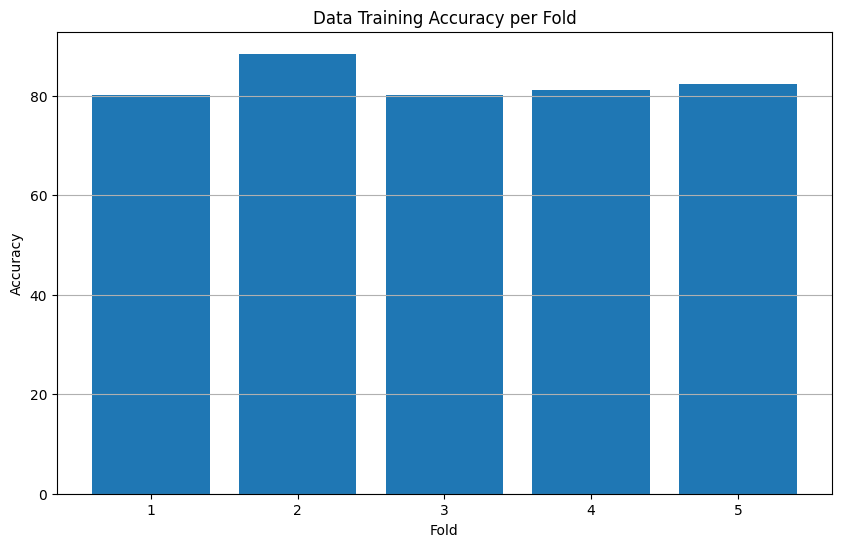

In [72]:
import matplotlib.pyplot as plt

# Buat figure dengan ukuran yang diinginkan
plt.figure(figsize=(10, 6))

# Buat grafik batang
plt.bar(range(1, len(accuracy_per_fold) + 1), accuracy_per_fold)

# Tambahkan judul dan label sumbu
plt.title('Data Training Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')

# Tambahkan tanda pada sumbu x sesuai jumlah fold
plt.xticks(range(1, len(accuracy_per_fold) + 1))

# Tambahkan grid untuk memudahkan pembacaan nilai
plt.grid(True, axis='y')

# Tampilkan grafik
plt.show()

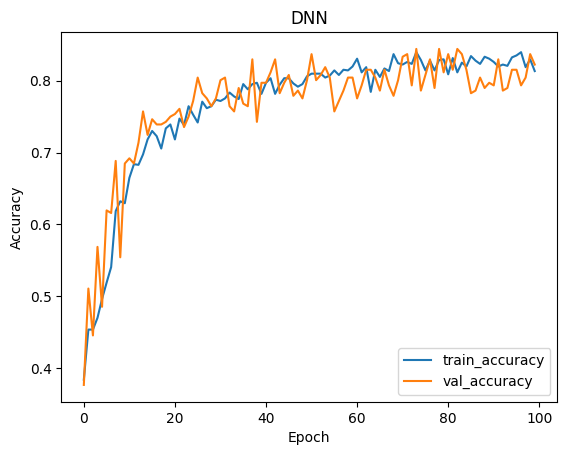

In [73]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title('DNN')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

# Gunakan fungsi plot_learning_curves dengan parameter objek history dari model.fit
plot_learning_curves(dnn)

In [74]:
import numpy as np
from keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report
import shutil

# Asumsikan X_test dan y_test adalah dataset yang digunakan untuk evaluasi
# Anda harus mengganti ini dengan data yang sesuai

# Jumlah fold yang digunakan selama cross-validation
n_folds = 5

# List untuk menyimpan hasil evaluasi
accuracy_per_fold = []
loss_per_fold = []

# Variabel untuk melacak model dengan akurasi terbaik
best_accuracy = 0.0
best_model_filename = None

for fold_no in range(1, n_folds + 1):
    # Membuat path ke model yang disimpan
    model_filename = f'models_dnn_tuning/model_dnn_tuning_fold_{fold_no}.h5'
    
    # Memuat model
    model = load_model(model_filename)
    
    # Evaluasi model pada data uji
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f'Fold {fold_no} - Loss: {loss} - Accuracy: {accuracy * 100}%')
    accuracy_per_fold.append(accuracy * 100)
    loss_per_fold.append(loss)
    
    # Cek apakah model saat ini adalah yang terbaik
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_filename = model_filename

    # Prediksi label menggunakan model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)  # Bentuk one-hot encoded

    # Hitung accuracy score
    acc_score = accuracy_score(y_true, y_pred_classes)
    print(f'Model Evaluate Accuracy Score for fold {fold_no}: {acc_score * 100}%')

    # Laporan klasifikasi
    print(f'Classification Report for fold {fold_no}:\n', classification_report(y_true, y_pred_classes))

# Menampilkan hasil akhir
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracy_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

# Menyimpan model dengan akurasi terbaik
if best_model_filename:
    shutil.copy(best_model_filename, 'modelTuning4.h5')
    print(f'Model with the best accuracy saved as modelTuning4.h5 with accuracy: {best_accuracy * 100}%')

Fold 1 - Loss: 0.36194494366645813 - Accuracy: 84.92753505706787%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Model Evaluate Accuracy Score for fold 1: 84.92753623188406%
Classification Report for fold 1:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82       126
           1       0.85      0.76      0.80       109
           2       0.90      0.95      0.92       110

    accuracy                           0.85       345
   macro avg       0.85      0.85      0.85       345
weighted avg       0.85      0.85      0.85       345

Fold 2 - Loss: 0.38331228494644165 - Accuracy: 85.2173924446106%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Model Evaluate Accuracy Score for fold 2: 85.21739130434783%
Classification Report for fold 2:
               precision    recall  f1-score   support

           0       0.84      0.79      0.82       126
           1       0.80      0.83      0.81       109
           2       0.92      0.95      0.93       110

    accuracy                           0.85       345
   macro avg       0.85      0.85      0.85       3

Fold 3 - Loss: 0.4148034453392029 - Accuracy: 82.02898502349854%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Model Evaluate Accuracy Score for fold 3: 82.02898550724638%
Classification Report for fold 3:
               precision    recall  f1-score   support

           0       0.82      0.74      0.78       126
           1       0.87      0.75      0.81       109
           2       0.79      0.98      0.87       110

    accuracy                           0.82       345
   macro avg       0.83      0.82      0.82       345
weighted avg       0.82      0.82      0.82       345

Fold 4 - Loss: 0.42717382311820984 - Accuracy: 82.89855122566223%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Model Evaluate Accuracy Score for fold 4: 82.89855072463767%
Classification Report for fold 4:
               precision    recall  f1-score   support

           0       0.89      0.68      0.77       126
           1       0.76      0.86      0.81       109
           2       0.85      0.96      0.90       110

    accuracy                           0.83       345
   macro avg       0.83      0.84      0.83       345
weighted avg       0.84      0.83      0.83       345

Fold 5 - Loss: 0.3885294198989868 - Accuracy: 85.2173924446106%
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Model Evaluate Accuracy Score for fold 5: 85.21739130434783%
Classification Report for fold 5:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83       126
           1       0.83      0.76      0.79       109
           2       0.91      0.95      0.93       110

    accuracy                           0.85       345
   macro avg       0.85      0.85      0.85       34

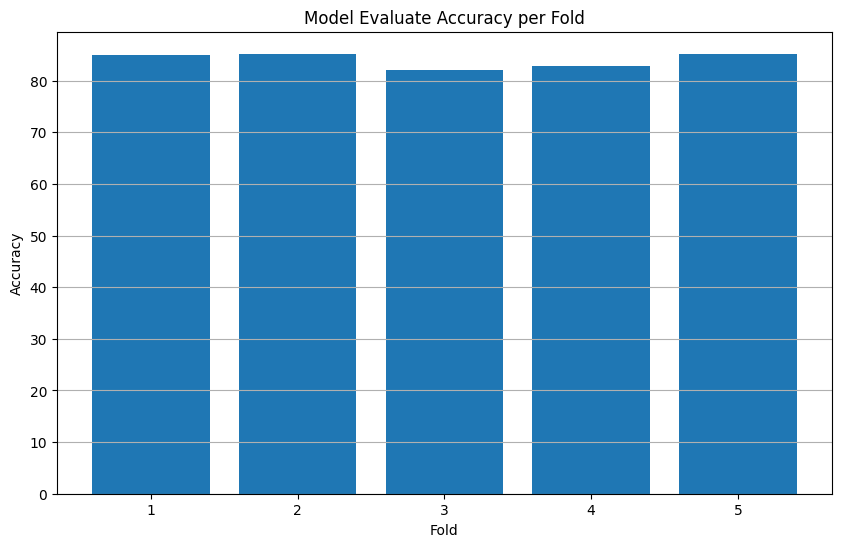

In [75]:
import matplotlib.pyplot as plt

# Buat figure dengan ukuran yang diinginkan
plt.figure(figsize=(10, 6))

# Buat grafik batang
plt.bar(range(1, len(accuracy_per_fold) + 1), accuracy_per_fold)

# Tambahkan judul dan label sumbu
plt.title('Model Evaluate Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')

# Tambahkan tanda pada sumbu x sesuai jumlah fold
plt.xticks(range(1, len(accuracy_per_fold) + 1))

# Tambahkan grid untuk memudahkan pembacaan nilai
plt.grid(True, axis='y')

# Tampilkan grafik
plt.show()

# Stacking CNN-LSTM

In [57]:
import os
from keras.models import load_model
from keras.metrics import Accuracy


# dependencies = {
#     'accuracy': accuracy  
# }

def load_selected_models(model_indices):
    all_models = list()
    for i in model_indices:
        # Define filename for this ensemble
        filename = os.path.join('D:\\', 'Tugas Akhir', 'Proyek', 'model' + str(i) + '.h5')
        # Load model from file
        model = load_model(filename, custom_objects=dependencies)
        # Add to list of members
        all_models.append(model)
        print('> Loaded %s' % filename)
    return all_models

In [79]:
# Panggil fungsi untuk meload model 1 dan 2
cnn_lstm = [1, 2]
members_cnn_lstm = load_selected_models(cnn_lstm)
print('Loaded %d models' % len(members_cnn_lstm))

> Loaded D:\Tugas Akhir\Proyek\model1.h5
> Loaded D:\Tugas Akhir\Proyek\model2.h5
Loaded 2 models


In [80]:
from numpy import dstack

# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat #
		else:
			stackX = dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=10, min_samples_split=4, min_samples_leaf=2, random_state=42) #meta learner
	model.fit(stackedX, inputy)
	return model

In [82]:
print(y_test.shape)

(345, 3)


In [83]:
y_test_1d = np.argmax(y_test, axis=1)

In [84]:
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat

In [85]:
stacked_model_cnn_lstm = fit_stacked_model(members_cnn_lstm, X_test, y_test_1d)

In [86]:
y_pred_cnn_lstm = stacked_prediction(members_cnn_lstm, stacked_model_cnn_lstm, X_test)

In [129]:
from joblib import dump 

dump(stacked_model_cnn_lstm, 'stackingCNNLSTM.pkl')

['stackingCNNLSTM.pkl']

In [87]:
from sklearn.metrics import accuracy_score

# Hitung akurasi
accuracy = accuracy_score(y_test_1d, y_pred_cnn_lstm)
print(f'Stacked Model Accuracy: {accuracy}')

Stacked Model Accuracy: 0.9623188405797102


In [88]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Hitung metrik evaluasi
accuracy = accuracy_score(y_test_1d, y_pred_cnn_lstm)
precision = precision_score(y_test_1d, y_pred_cnn_lstm, average='weighted')
recall = recall_score(y_test_1d, y_pred_cnn_lstm, average='weighted')
f1 = f1_score(y_test_1d, y_pred_cnn_lstm, average='weighted')

# Tampilkan metrik evaluasi
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Stacked Model Metrics:
Accuracy: 0.9623188405797102
Precision: 0.9624598861283645
Recall: 0.9623188405797102
F1 Score: 0.9622371135321188


In [89]:
from sklearn.metrics import confusion_matrix

# Hitung matriks kebingungan
conf_matrix = confusion_matrix(y_test_1d, y_pred_cnn_lstm)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix[0, 0]
false_positive = conf_matrix[0, 1]
false_negative = conf_matrix[1, 0]
true_positive = conf_matrix[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

Stacked Model Metrics:
Accuracy: 0.9623188405797102
Precision: 0.9624598861283645
Recall: 0.9623188405797102
F1 Score: 0.9622371135321188
Sensitivity: 0.9444444444444444
Specificity: 0.9758064516129032


In [90]:
from sklearn.metrics import accuracy_score

# Melakukan iterasi melalui setiap model
for i, model in enumerate(members_cnn_lstm):
    # Membuat prediksi menggunakan model
    y_pred_model = model.predict(X_test)
    pred = np.argmax(y_pred_model, axis=1)
    # Menghitung akurasi untuk model ini
    accuracy_model = accuracy_score(y_test_1d, pred)
    
    # Menampilkan akurasi
    print(f'Model {i+1} Accuracy: {accuracy_model}')


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model 1 Accuracy: 0.863768115942029
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Model 2 Accuracy: 0.7159420289855073


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model 1 Accuracy: 0.863768115942029
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Model 2 Accuracy: 0.7159420289855073


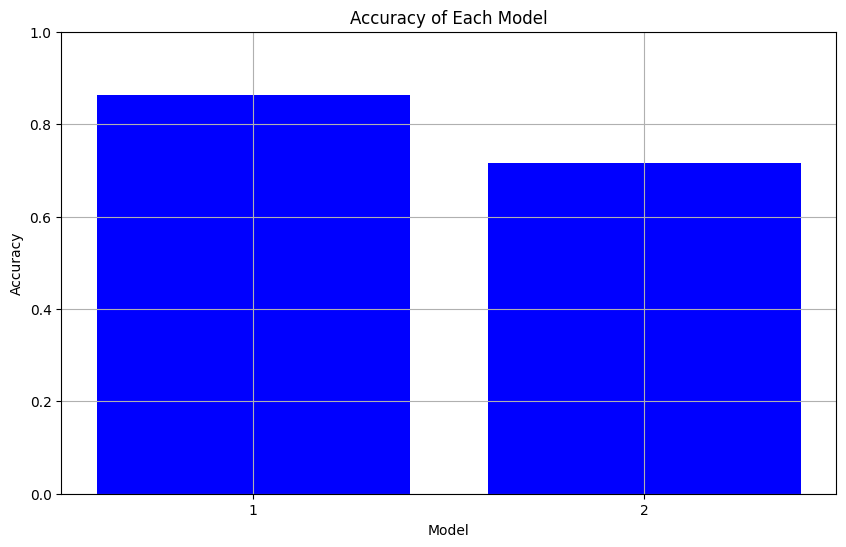

In [91]:
import matplotlib.pyplot as plt

# Inisialisasi list untuk menyimpan akurasi setiap model
accuracies = []

# Melakukan iterasi melalui setiap model
for i, model in enumerate(members_cnn_lstm):
    # Membuat prediksi menggunakan model
    y_pred_model = model.predict(X_test)
    pred = np.argmax(y_pred_model, axis=1)
    # Menghitung akurasi untuk model ini
    accuracy_model = accuracy_score(y_test_1d, pred)
    
    # Menyimpan akurasi model ke dalam list
    accuracies.append(accuracy_model)
    
    # Menampilkan akurasi
    print(f'Model {i+1} Accuracy: {accuracy_model}')

# Plot grafik akurasi
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(accuracies) + 1), accuracies, color='blue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Each Model')
plt.xticks(range(1, len(accuracies) + 1))
plt.ylim(0, 1)  # Set batas sumbu y antara 0 dan 1
plt.grid(True)
plt.show()

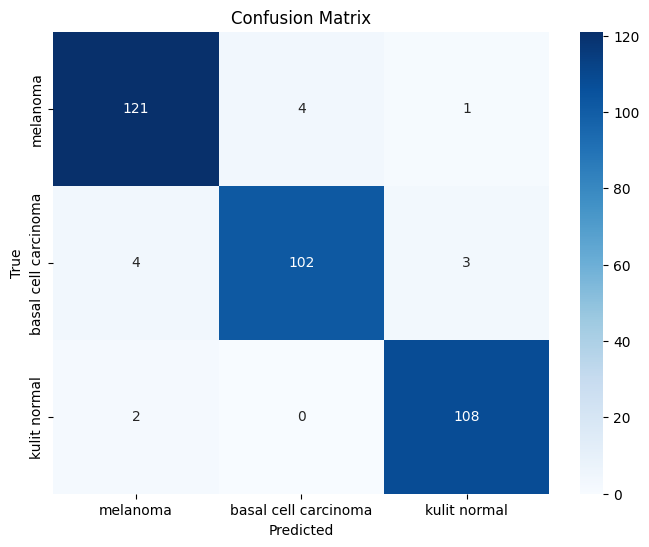

In [135]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_lstm)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'kulit normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Stacking CNN-RNN

In [136]:
# Panggil fungsi untuk meload model 1 dan 3
cnn_rnn = [1, 3]
members_cnn_rnn = load_selected_models(cnn_rnn)
print('Loaded %d models' % len(members_cnn_rnn))

> Loaded D:\Tugas Akhir\Proyek\model1.h5
> Loaded D:\Tugas Akhir\Proyek\model3.h5
Loaded 2 models


In [137]:
stacked_model_cnn_rnn = fit_stacked_model(members_cnn_rnn, X_test, y_test_1d)

In [138]:
y_pred_cnn_rnn = stacked_prediction(members_cnn_rnn, stacked_model_cnn_rnn, X_test)

In [139]:
from joblib import dump 

dump(stacked_model_cnn_lstm, 'stackingCNNRNN.pkl')

['stackingCNNRNN.pkl']

In [140]:
from sklearn.metrics import accuracy_score

# Hitung akurasi
accuracy = accuracy_score(y_test_1d, y_pred_cnn_rnn)
print(f'Stacked Model Accuracy: {accuracy}')

Stacked Model Accuracy: 0.9565217391304348


In [141]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Hitung metrik evaluasi
accuracy = accuracy_score(y_test_1d, y_pred_cnn_rnn)
precision = precision_score(y_test_1d, y_pred_cnn_rnn, average='weighted')
recall = recall_score(y_test_1d, y_pred_cnn_rnn, average='weighted')
f1 = f1_score(y_test_1d, y_pred_cnn_rnn, average='weighted')

# Tampilkan metrik evaluasi
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Stacked Model Metrics:
Accuracy: 0.9565217391304348
Precision: 0.9568827307957742
Recall: 0.9565217391304348
F1 Score: 0.9565136970066368


In [142]:
from sklearn.metrics import confusion_matrix

# Hitung matriks kebingungan
conf_matrix = confusion_matrix(y_test_1d, y_pred_cnn_rnn)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix[0, 0]
false_positive = conf_matrix[0, 1]
false_negative = conf_matrix[1, 0]
true_positive = conf_matrix[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

Stacked Model Metrics:
Accuracy: 0.9565217391304348
Precision: 0.9568827307957742
Recall: 0.9565217391304348
F1 Score: 0.9565136970066368
Sensitivity: 0.9351851851851852
Specificity: 0.968


In [143]:
from sklearn.metrics import accuracy_score

# Melakukan iterasi melalui setiap model
for i, model in enumerate(members_cnn_rnn):
    # Membuat prediksi menggunakan model
    y_pred_model = model.predict(X_test)
    pred = np.argmax(y_pred_model, axis=1)
    # Menghitung akurasi untuk model ini
    accuracy_model = accuracy_score(y_test_1d, pred)
    
    # Menampilkan akurasi
    print(f'Model {i+1} Accuracy: {accuracy_model}')

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Model 1 Accuracy: 0.863768115942029
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Model 2 Accuracy: 0.7478260869565218


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Model 1 Accuracy: 0.863768115942029
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model 2 Accuracy: 0.7478260869565218


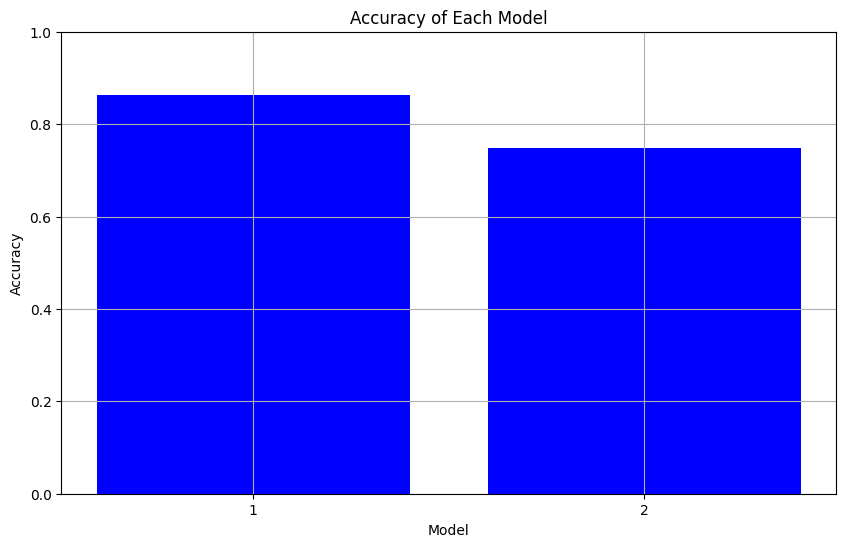

In [144]:
import matplotlib.pyplot as plt

# Inisialisasi list untuk menyimpan akurasi setiap model
accuracies = []

# Melakukan iterasi melalui setiap model
for i, model in enumerate(members_cnn_rnn):
    # Membuat prediksi menggunakan model
    y_pred_model = model.predict(X_test)
    pred = np.argmax(y_pred_model, axis=1)
    # Menghitung akurasi untuk model ini
    accuracy_model = accuracy_score(y_test_1d, pred)
    
    # Menyimpan akurasi model ke dalam list
    accuracies.append(accuracy_model)
    
    # Menampilkan akurasi
    print(f'Model {i+1} Accuracy: {accuracy_model}')

# Plot grafik akurasi
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(accuracies) + 1), accuracies, color='blue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Each Model')
plt.xticks(range(1, len(accuracies) + 1))
plt.ylim(0, 1)  # Set batas sumbu y antara 0 dan 1
plt.grid(True)
plt.show()

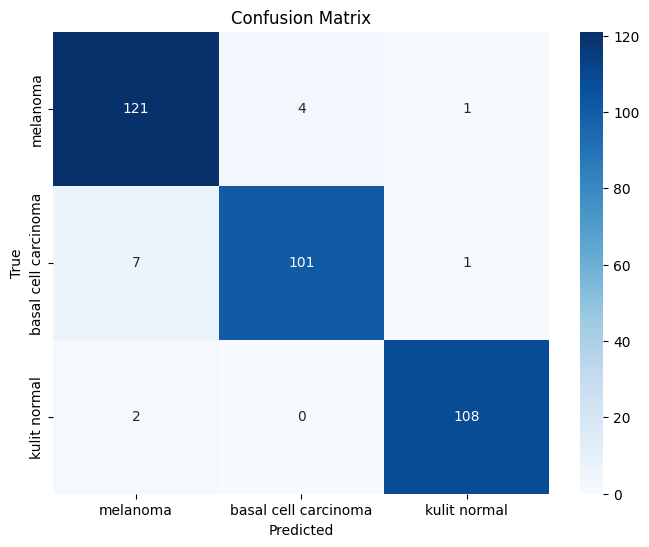

In [145]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_rnn)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'kulit normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Stacking CNN-DNN

In [146]:
# Panggil fungsi untuk meload model 1 dan 4
cnn_dnn = [1, 4]
members_cnn_dnn = load_selected_models(cnn_dnn)
print('Loaded %d models' % len(members_cnn_dnn))

> Loaded D:\Tugas Akhir\Proyek\model1.h5
> Loaded D:\Tugas Akhir\Proyek\model4.h5
Loaded 2 models


In [147]:
stacked_model_cnn_dnn = fit_stacked_model(members_cnn_dnn, X_test, y_test_1d)

In [148]:
y_pred_cnn_dnn = stacked_prediction(members_cnn_dnn, stacked_model_cnn_dnn, X_test)

In [149]:
from joblib import dump 

dump(stacked_model_cnn_lstm, 'stackingCNNDNN.pkl')

['stackingCNNDNN.pkl']

In [150]:
from sklearn.metrics import accuracy_score

# Hitung akurasi
accuracy = accuracy_score(y_test_1d, y_pred_cnn_dnn)
print(f'Stacked Model Accuracy: {accuracy}')

Stacked Model Accuracy: 0.9565217391304348


In [151]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Hitung metrik evaluasi
accuracy = accuracy_score(y_test_1d, y_pred_cnn_dnn)
precision = precision_score(y_test_1d, y_pred_cnn_dnn, average='weighted')
recall = recall_score(y_test_1d, y_pred_cnn_dnn, average='weighted')
f1 = f1_score(y_test_1d, y_pred_cnn_dnn, average='weighted')

# Tampilkan metrik evaluasi
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Stacked Model Metrics:
Accuracy: 0.9565217391304348
Precision: 0.9565069350523616
Recall: 0.9565217391304348
F1 Score: 0.9564285757601859


In [152]:
from sklearn.metrics import confusion_matrix

# Hitung matriks kebingungan
conf_matrix = confusion_matrix(y_test_1d, y_pred_cnn_dnn)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix[0, 0]
false_positive = conf_matrix[0, 1]
false_negative = conf_matrix[1, 0]
true_positive = conf_matrix[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

Stacked Model Metrics:
Accuracy: 0.9565217391304348
Precision: 0.9565069350523616
Recall: 0.9565217391304348
F1 Score: 0.9564285757601859
Sensitivity: 0.9439252336448598
Specificity: 0.968


In [153]:
from sklearn.metrics import accuracy_score

# Melakukan iterasi melalui setiap model
for i, model in enumerate(members_cnn_dnn):
    # Membuat prediksi menggunakan model
    y_pred_model = model.predict(X_test)
    pred = np.argmax(y_pred_model, axis=1)
    # Menghitung akurasi untuk model ini
    accuracy_model = accuracy_score(y_test_1d, pred)
    
    # Menampilkan akurasi
    print(f'Model {i+1} Accuracy: {accuracy_model}')

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model 1 Accuracy: 0.863768115942029
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model 2 Accuracy: 0.8405797101449275


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model 1 Accuracy: 0.863768115942029
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model 2 Accuracy: 0.8405797101449275


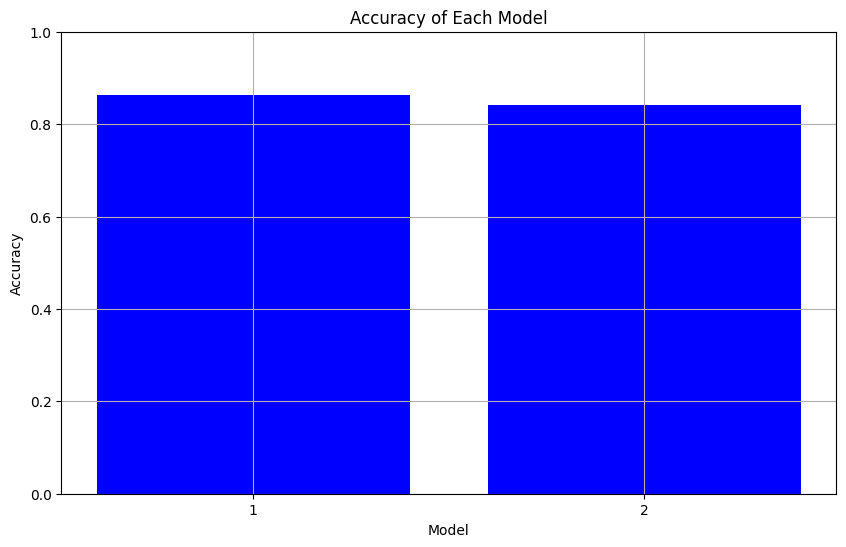

In [154]:
import matplotlib.pyplot as plt

# Inisialisasi list untuk menyimpan akurasi setiap model
accuracies = []

# Melakukan iterasi melalui setiap model
for i, model in enumerate(members_cnn_dnn):
    # Membuat prediksi menggunakan model
    y_pred_model = model.predict(X_test)
    pred = np.argmax(y_pred_model, axis=1)
    # Menghitung akurasi untuk model ini
    accuracy_model = accuracy_score(y_test_1d, pred)
    
    # Menyimpan akurasi model ke dalam list
    accuracies.append(accuracy_model)
    
    # Menampilkan akurasi
    print(f'Model {i+1} Accuracy: {accuracy_model}')

# Plot grafik akurasi
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(accuracies) + 1), accuracies, color='blue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Each Model')
plt.xticks(range(1, len(accuracies) + 1))
plt.ylim(0, 1)  # Set batas sumbu y antara 0 dan 1
plt.grid(True)
plt.show()

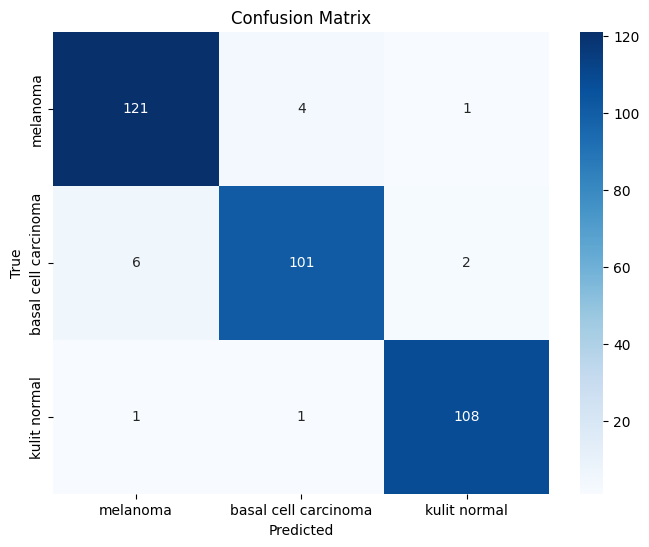

In [155]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_dnn)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'kulit normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Stacking CNN-LSTM Tuning

In [156]:
import os
from keras.models import load_model


dependencies = {
    'accuracy': accuracy  
}

def load_selected_models(model_indices):
    all_models = list()
    for i in model_indices:
        # Define filename for this ensemble
        filename = os.path.join('D:\\', 'Tugas Akhir', 'Proyek', 'modelTuning' + str(i) + '.h5')
        # Load model from file
        model = load_model(filename, custom_objects=dependencies)
        # Add to list of members
        all_models.append(model)
        print('> Loaded %s' % filename)
    return all_models

In [157]:
# Panggil fungsi untuk meload model 1 dan 2
cnn_lstm = [1, 2]
members_cnn_lstm = load_selected_models(cnn_lstm)
print('Loaded %d models' % len(members_cnn_lstm))

> Loaded D:\Tugas Akhir\Proyek\modelTuning1.h5
> Loaded D:\Tugas Akhir\Proyek\modelTuning2.h5
Loaded 2 models


In [158]:
from numpy import dstack

# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, inputX):
	stackX = None
	for model in members:
		# make prediction
		yhat = model.predict(inputX, verbose=0)
		# stack predictions into [rows, members, probabilities]
		if stackX is None:
			stackX = yhat #
		else:
			stackX = dstack((stackX, yhat))
	# flatten predictions to [rows, members x probabilities]
	stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
	return stackX

In [159]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier



# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, inputX, inputy):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# fit standalone model
	model = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=10, min_samples_split=4, min_samples_leaf=2, random_state=42) #meta learner
	model.fit(stackedX, inputy)
	return model

In [160]:
print(y_test.shape)

(345, 3)


In [161]:
y_test_1d = np.argmax(y_test, axis=1)

In [162]:
# make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
	# create dataset using ensemble
	stackedX = stacked_dataset(members, inputX)
	# make a prediction
	yhat = model.predict(stackedX)
	return yhat

In [163]:
stacked_model_cnn_lstm_tuning = fit_stacked_model(members_cnn_lstm, X_test, y_test_1d)

In [164]:
y_pred_cnn_lstm_tuning = stacked_prediction(members_cnn_lstm, stacked_model_cnn_lstm_tuning, X_test)

In [165]:
from joblib import dump 

dump(stacked_model_cnn_lstm_tuning, 'stackingCNNLSTMTuning.pkl')

['stackingCNNLSTMTuning.pkl']

In [166]:
from sklearn.metrics import accuracy_score

# Hitung akurasi
accuracy = accuracy_score(y_test_1d, y_pred_cnn_lstm_tuning)
print(f'Stacked Model Accuracy: {accuracy}')

Stacked Model Accuracy: 0.9565217391304348


In [167]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Hitung metrik evaluasi
accuracy = accuracy_score(y_test_1d, y_pred_cnn_lstm_tuning)
precision = precision_score(y_test_1d, y_pred_cnn_lstm_tuning, average='weighted')
recall = recall_score(y_test_1d, y_pred_cnn_lstm_tuning, average='weighted')
f1 = f1_score(y_test_1d, y_pred_cnn_lstm_tuning, average='weighted')

# Tampilkan metrik evaluasi
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Stacked Model Metrics:
Accuracy: 0.9565217391304348
Precision: 0.9565069350523616
Recall: 0.9565217391304348
F1 Score: 0.9564285757601859


In [169]:
from sklearn.metrics import confusion_matrix

# Hitung matriks kebingungan
conf_matrix = confusion_matrix(y_test_1d, y_pred_cnn_lstm_tuning)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix[0, 0]
false_positive = conf_matrix[0, 1]
false_negative = conf_matrix[1, 0]
true_positive = conf_matrix[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

Stacked Model Metrics:
Accuracy: 0.9565217391304348
Precision: 0.9565069350523616
Recall: 0.9565217391304348
F1 Score: 0.9564285757601859
Sensitivity: 0.9439252336448598
Specificity: 0.968


In [170]:
from sklearn.metrics import accuracy_score

# Melakukan iterasi melalui setiap model
for i, model in enumerate(members_cnn_lstm):
    # Membuat prediksi menggunakan model
    y_pred_model = model.predict(X_test)
    pred = np.argmax(y_pred_model, axis=1)
    # Menghitung akurasi untuk model ini
    accuracy_model = accuracy_score(y_test_1d, pred)
    
    # Menampilkan akurasi
    print(f'Model {i+1} Accuracy: {accuracy_model}')

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model 1 Accuracy: 0.881159420289855
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Model 2 Accuracy: 0.8


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model 1 Accuracy: 0.881159420289855
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Model 2 Accuracy: 0.8


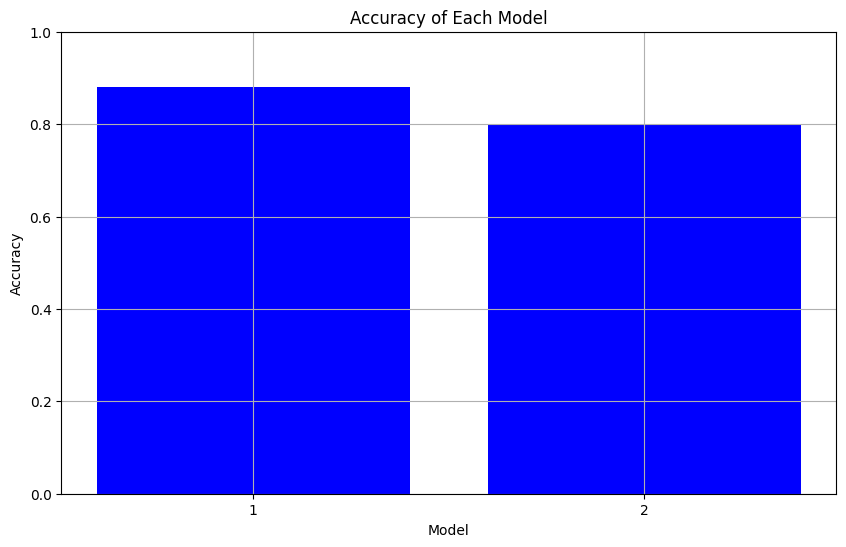

In [171]:
import matplotlib.pyplot as plt

# Inisialisasi list untuk menyimpan akurasi setiap model
accuracies = []

# Melakukan iterasi melalui setiap model
for i, model in enumerate(members_cnn_lstm):
    # Membuat prediksi menggunakan model
    y_pred_model = model.predict(X_test)
    pred = np.argmax(y_pred_model, axis=1)
    # Menghitung akurasi untuk model ini
    accuracy_model = accuracy_score(y_test_1d, pred)
    
    # Menyimpan akurasi model ke dalam list
    accuracies.append(accuracy_model)
    
    # Menampilkan akurasi
    print(f'Model {i+1} Accuracy: {accuracy_model}')

# Plot grafik akurasi
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(accuracies) + 1), accuracies, color='blue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Each Model')
plt.xticks(range(1, len(accuracies) + 1))
plt.ylim(0, 1)  # Set batas sumbu y antara 0 dan 1
plt.grid(True)
plt.show()

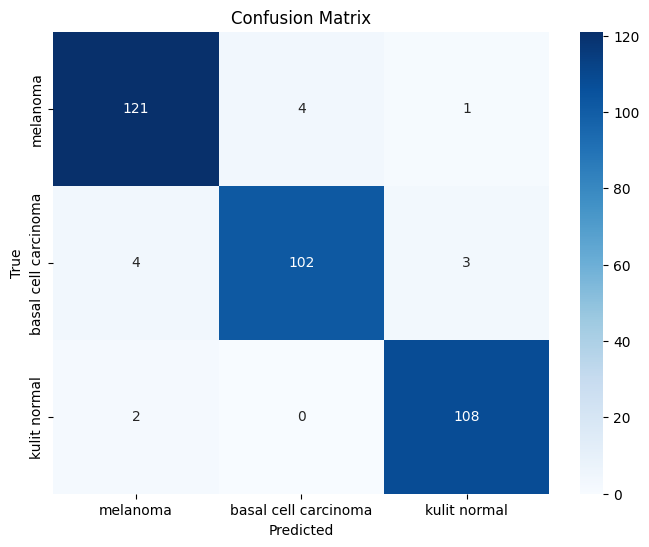

In [172]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_lstm)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'kulit normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Stacking CNN-RNN Tuning

In [173]:
# Panggil fungsi untuk meload model 1 dan 3
cnn_rnn = [1, 3]
members_cnn_rnn = load_selected_models(cnn_rnn)
print('Loaded %d models' % len(members_cnn_rnn))

> Loaded D:\Tugas Akhir\Proyek\modelTuning1.h5
> Loaded D:\Tugas Akhir\Proyek\modelTuning3.h5
Loaded 2 models


In [174]:
stacked_model_cnn_rnn_tuning = fit_stacked_model(members_cnn_rnn, X_test, y_test_1d)

In [175]:
y_pred_cnn_rnn_tuning = stacked_prediction(members_cnn_rnn, stacked_model_cnn_rnn_tuning, X_test)

In [176]:
from joblib import dump 

dump(stacked_model_cnn_rnn_tuning, 'stackingCNNRNNTuning.pkl')

['stackingCNNRNNTuning.pkl']

In [177]:
from sklearn.metrics import accuracy_score

# Hitung akurasi
accuracy = accuracy_score(y_test_1d, y_pred_cnn_rnn_tuning)
print(f'Stacked Model Accuracy: {accuracy}')

Stacked Model Accuracy: 0.9652173913043478


In [178]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Hitung metrik evaluasi
accuracy = accuracy_score(y_test_1d, y_pred_cnn_rnn_tuning)
precision = precision_score(y_test_1d, y_pred_cnn_rnn_tuning, average='weighted')
recall = recall_score(y_test_1d, y_pred_cnn_rnn_tuning, average='weighted')
f1 = f1_score(y_test_1d, y_pred_cnn_rnn_tuning, average='weighted')

# Tampilkan metrik evaluasi
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Stacked Model Metrics:
Accuracy: 0.9652173913043478
Precision: 0.9656073658967541
Recall: 0.9652173913043478
F1 Score: 0.9651671744031678


In [179]:
from sklearn.metrics import confusion_matrix

# Hitung matriks kebingungan
conf_matrix = confusion_matrix(y_test_1d, y_pred_cnn_rnn_tuning)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix[0, 0]
false_positive = conf_matrix[0, 1]
false_negative = conf_matrix[1, 0]
true_positive = conf_matrix[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

Stacked Model Metrics:
Accuracy: 0.9652173913043478
Precision: 0.9656073658967541
Recall: 0.9652173913043478
F1 Score: 0.9651671744031678
Sensitivity: 0.9532710280373832
Specificity: 0.9841269841269841


In [180]:
from sklearn.metrics import accuracy_score

# Melakukan iterasi melalui setiap model
for i, model in enumerate(members_cnn_rnn):
    # Membuat prediksi menggunakan model
    y_pred_model = model.predict(X_test)
    pred = np.argmax(y_pred_model, axis=1)
    # Menghitung akurasi untuk model ini
    accuracy_model = accuracy_score(y_test_1d, pred)
    
    # Menampilkan akurasi
    print(f'Model {i+1} Accuracy: {accuracy_model}')

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model 1 Accuracy: 0.881159420289855
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Model 2 Accuracy: 0.863768115942029


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model 1 Accuracy: 0.881159420289855
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Model 2 Accuracy: 0.863768115942029


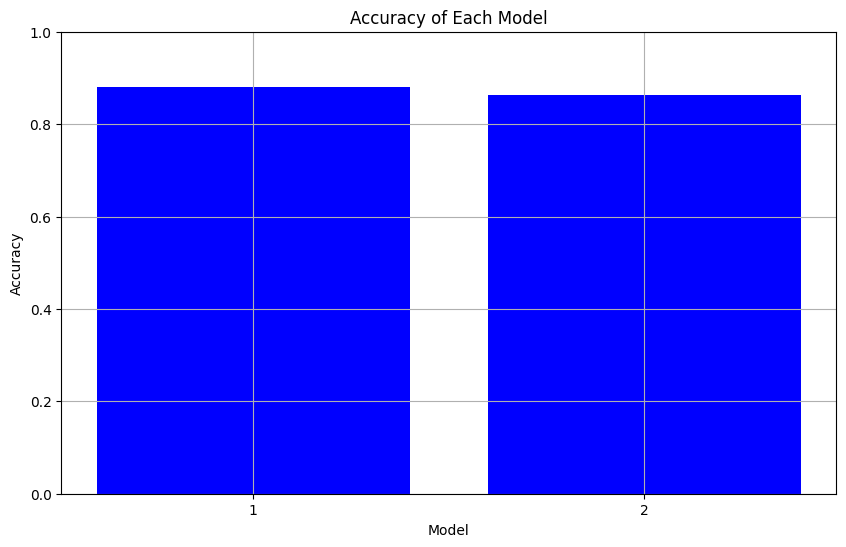

In [181]:
import matplotlib.pyplot as plt

# Inisialisasi list untuk menyimpan akurasi setiap model
accuracies = []

# Melakukan iterasi melalui setiap model
for i, model in enumerate(members_cnn_rnn):
    # Membuat prediksi menggunakan model
    y_pred_model = model.predict(X_test)
    pred = np.argmax(y_pred_model, axis=1)
    # Menghitung akurasi untuk model ini
    accuracy_model = accuracy_score(y_test_1d, pred)
    
    # Menyimpan akurasi model ke dalam list
    accuracies.append(accuracy_model)
    
    # Menampilkan akurasi
    print(f'Model {i+1} Accuracy: {accuracy_model}')

# Plot grafik akurasi
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(accuracies) + 1), accuracies, color='blue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Each Model')
plt.xticks(range(1, len(accuracies) + 1))
plt.ylim(0, 1)  # Set batas sumbu y antara 0 dan 1
plt.grid(True)
plt.show()

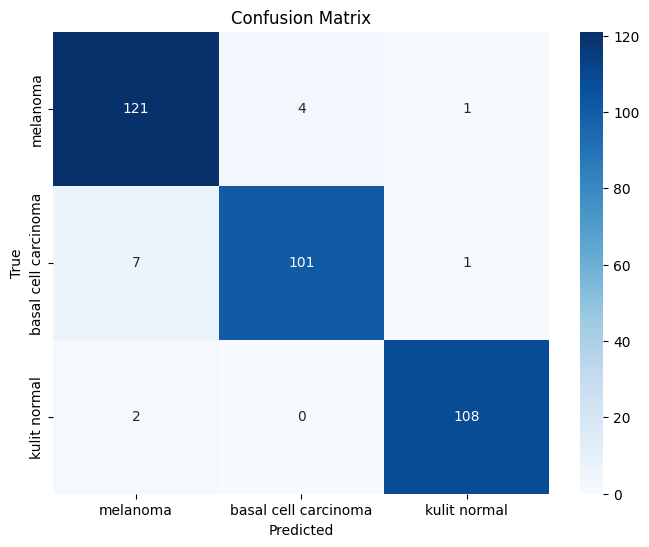

In [182]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_rnn)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'kulit normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Stacking CNN-DNN Tuning

In [183]:
# Panggil fungsi untuk meload model 1 dan 4
cnn_dnn = [1, 4]
members_cnn_dnn = load_selected_models(cnn_dnn)
print('Loaded %d models' % len(members_cnn_dnn))

> Loaded D:\Tugas Akhir\Proyek\modelTuning1.h5
> Loaded D:\Tugas Akhir\Proyek\modelTuning4.h5
Loaded 2 models


In [184]:
stacked_model_cnn_dnn_tuning = fit_stacked_model(members_cnn_dnn, X_test, y_test_1d)

In [185]:
y_pred_cnn_dnn_tuning = stacked_prediction(members_cnn_dnn, stacked_model_cnn_dnn_tuning, X_test)

In [186]:
from joblib import dump 

dump(stacked_model_cnn_dnn_tuning, 'stackingCNNDNNTuning.pkl')

['stackingCNNDNNTuning.pkl']

In [187]:
from sklearn.metrics import accuracy_score

# Hitung akurasi
accuracy = accuracy_score(y_test_1d, y_pred_cnn_dnn_tuning)
print(f'Stacked Model Accuracy: {accuracy}')

Stacked Model Accuracy: 0.9623188405797102


In [188]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Hitung metrik evaluasi
accuracy = accuracy_score(y_test_1d, y_pred_cnn_dnn_tuning)
precision = precision_score(y_test_1d, y_pred_cnn_dnn_tuning, average='weighted')
recall = recall_score(y_test_1d, y_pred_cnn_dnn_tuning, average='weighted')
f1 = f1_score(y_test_1d, y_pred_cnn_dnn_tuning, average='weighted')

# Tampilkan metrik evaluasi
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Stacked Model Metrics:
Accuracy: 0.9623188405797102
Precision: 0.9624625598565352
Recall: 0.9623188405797102
F1 Score: 0.9622839469458158


In [189]:
from sklearn.metrics import confusion_matrix

# Hitung matriks kebingungan
conf_matrix = confusion_matrix(y_test_1d, y_pred_cnn_dnn_tuning)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix[0, 0]
false_positive = conf_matrix[0, 1]
false_negative = conf_matrix[1, 0]
true_positive = conf_matrix[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

Stacked Model Metrics:
Accuracy: 0.9623188405797102
Precision: 0.9624625598565352
Recall: 0.9623188405797102
F1 Score: 0.9622839469458158
Sensitivity: 0.9444444444444444
Specificity: 0.976


In [190]:
from sklearn.metrics import accuracy_score

# Melakukan iterasi melalui setiap model
for i, model in enumerate(members_cnn_dnn):
    # Membuat prediksi menggunakan model
    y_pred_model = model.predict(X_test)
    pred = np.argmax(y_pred_model, axis=1)
    # Menghitung akurasi untuk model ini
    accuracy_model = accuracy_score(y_test_1d, pred)
    
    # Menampilkan akurasi
    print(f'Model {i+1} Accuracy: {accuracy_model}')

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model 1 Accuracy: 0.881159420289855
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model 2 Accuracy: 0.863768115942029


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Model 1 Accuracy: 0.881159420289855
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model 2 Accuracy: 0.863768115942029


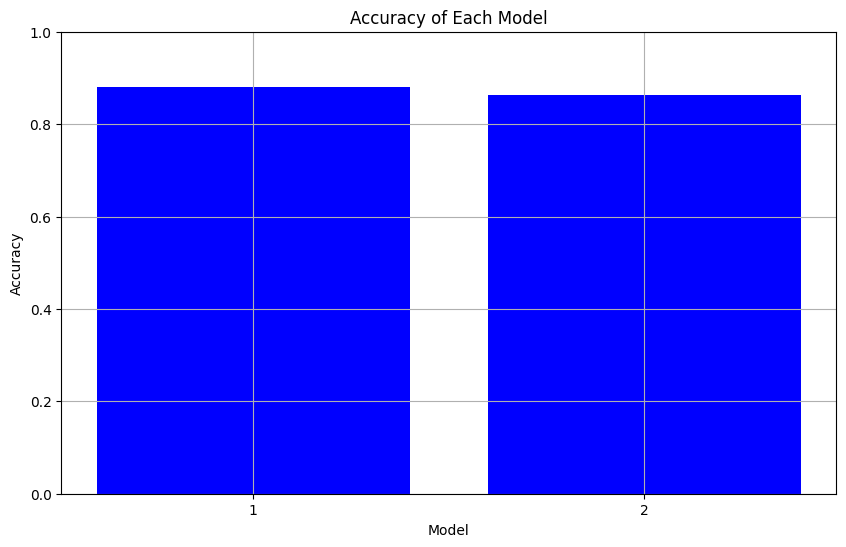

In [191]:
import matplotlib.pyplot as plt

# Inisialisasi list untuk menyimpan akurasi setiap model
accuracies = []

# Melakukan iterasi melalui setiap model
for i, model in enumerate(members_cnn_dnn):
    # Membuat prediksi menggunakan model
    y_pred_model = model.predict(X_test)
    pred = np.argmax(y_pred_model, axis=1)
    # Menghitung akurasi untuk model ini
    accuracy_model = accuracy_score(y_test_1d, pred)
    
    # Menyimpan akurasi model ke dalam list
    accuracies.append(accuracy_model)
    
    # Menampilkan akurasi
    print(f'Model {i+1} Accuracy: {accuracy_model}')

# Plot grafik akurasi
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(accuracies) + 1), accuracies, color='blue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Each Model')
plt.xticks(range(1, len(accuracies) + 1))
plt.ylim(0, 1)  # Set batas sumbu y antara 0 dan 1
plt.grid(True)
plt.show()

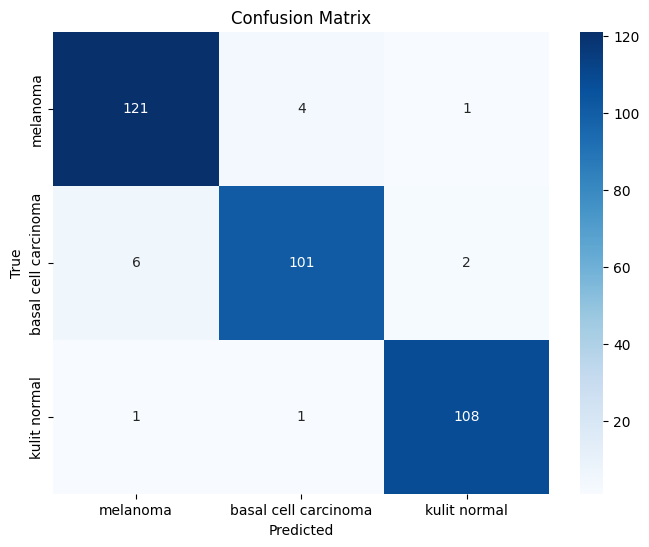

In [192]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_dnn)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'kulit normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# CNN LSTM Stacking

## Data Training

In [69]:
# Panggil fungsi untuk meload model CNN dan DNN 1 hingga 5
# Panggil fungsi untuk meload model CNN dan DNN 1 hingga 5
models_cnn_fold = [1, 2, 3, 4, 5]
members_cnn_fold = load_selected_models("models_cnn", "model_cnn")
print('Loaded %d CNN models' % len(members_cnn_fold))

models_lstm_fold = [1, 2, 3, 4, 5]
members_lstm_fold = load_selected_models("models_lstm", "model_lstm")
print('Loaded %d LSTM models' % len(members_lstm_fold))


# Membuat pasangan model CNN dan DNN untuk setiap fold
paired_cnn_lstm_models = []
for cnn_model, lstm_model in zip(members_cnn_fold, members_lstm_fold):
    paired_cnn_lstm_models.append((cnn_model, lstm_model))

# Misalnya untuk fold pertama
cnn_model_fold_1, lstm_model_fold_1 = paired_cnn_lstm_models[0]
cnn_model_fold_2, lstm_model_fold_2 = paired_cnn_lstm_models[1]
cnn_model_fold_3, lstm_model_fold_3 = paired_cnn_lstm_models[2]
cnn_model_fold_4, lstm_model_fold_4 = paired_cnn_lstm_models[3]
cnn_model_fold_5, lstm_model_fold_5 = paired_cnn_lstm_models[4]

> Loaded models_cnn\model_cnn_fold_1.h5 and models_cnn\model_cnn_fold_1.h5


> Loaded models_cnn\model_cnn_fold_2.h5 and models_cnn\model_cnn_fold_2.h5
> Loaded models_cnn\model_cnn_fold_3.h5 and models_cnn\model_cnn_fold_3.h5


> Loaded models_cnn\model_cnn_fold_4.h5 and models_cnn\model_cnn_fold_4.h5


> Loaded models_cnn\model_cnn_fold_5.h5 and models_cnn\model_cnn_fold_5.h5
Loaded 5 CNN models


> Loaded models_lstm\model_lstm_fold_1.h5 and models_lstm\model_lstm_fold_1.h5


> Loaded models_lstm\model_lstm_fold_2.h5 and models_lstm\model_lstm_fold_2.h5
> Loaded models_lstm\model_lstm_fold_3.h5 and models_lstm\model_lstm_fold_3.h5


> Loaded models_lstm\model_lstm_fold_4.h5 and models_lstm\model_lstm_fold_4.h5
> Loaded models_lstm\model_lstm_fold_5.h5 and models_lstm\model_lstm_fold_5.h5
Loaded 5 LSTM models


In [70]:
y_train_1d = np.argmax(y_train, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

In [71]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_lstm_1 = fit_stacked_model(paired_cnn_lstm_models[0], X_train, y_train_1d)
y_pred_cnn_lstm_1 = stacked_prediction(paired_cnn_lstm_models[0], stacked_model_cnn_lstm_1, X_train)

# Hitung matriks kebingungan
conf_matrix_1 = confusion_matrix(y_train_1d, y_pred_cnn_lstm_1)
accuracy_1 = accuracy_score(y_train_1d, y_pred_cnn_lstm_1)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_1[0, 0]
false_positive = conf_matrix_1[0, 1]
false_negative = conf_matrix_1[1, 0]
true_positive = conf_matrix_1[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_1 = classification_report(y_train_1d, y_pred_cnn_lstm_1, output_dict=True)
precision = classification_report_1['weighted avg']['precision']
recall = classification_report_1['weighted avg']['recall']
f1 = classification_report_1['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_lstm_1))

Stacked Model Metrics:
Accuracy: 0.9376811594202898
Precision: 0.9387233368557573
Recall: 0.9376811594202898
F1 Score: 0.9373954062844131
Sensitivity: 0.8847826086956522
Specificity: 0.9550561797752809
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       449
           1       0.95      0.87      0.91       466
           2       0.98      0.99      0.99       465

    accuracy                           0.94      1380
   macro avg       0.94      0.94      0.94      1380
weighted avg       0.94      0.94      0.94      1380



In [72]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

stacked_model_cnn_lstm_2 = fit_stacked_model(paired_cnn_lstm_models[1], X_train, y_train_1d)
y_pred_cnn_lstm_2 = stacked_prediction(paired_cnn_lstm_models[1], stacked_model_cnn_lstm_2, X_train)

# Hitung matriks kebingungan
conf_matrix_2 = confusion_matrix(y_train_1d, y_pred_cnn_lstm_2)
accuracy_2 = accuracy_score(y_train_1d, y_pred_cnn_lstm_2)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_2[0, 0]
false_positive = conf_matrix_2[0, 1]
false_negative = conf_matrix_2[1, 0]
true_positive = conf_matrix_2[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_2 = classification_report(y_train_1d, y_pred_cnn_lstm_2, output_dict=True)
precision = classification_report_2['weighted avg']['precision']
recall = classification_report_2['weighted avg']['recall']
f1 = classification_report_2['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_2}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_lstm_2))

Stacked Model Metrics:
Accuracy: 0.9268115942028986
Precision: 0.9284268852773896
Recall: 0.9268115942028986
F1 Score: 0.9266537311201539
Sensitivity: 0.8698481561822126
Specificity: 0.9503386004514672
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       449
           1       0.94      0.86      0.90       466
           2       0.98      0.98      0.98       465

    accuracy                           0.93      1380
   macro avg       0.93      0.93      0.93      1380
weighted avg       0.93      0.93      0.93      1380



In [73]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

stacked_model_cnn_lstm_3 = fit_stacked_model(paired_cnn_lstm_models[2], X_train, y_train_1d)
y_pred_cnn_lstm_3 = stacked_prediction(paired_cnn_lstm_models[2], stacked_model_cnn_lstm_3, X_train)

# Hitung matriks kebingungan
conf_matrix_3 = confusion_matrix(y_train_1d, y_pred_cnn_lstm_3)
accuracy_3 = accuracy_score(y_train_1d, y_pred_cnn_lstm_3)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_3[0, 0]
false_positive = conf_matrix_3[0, 1]
false_negative = conf_matrix_3[1, 0]
true_positive = conf_matrix_3[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
precision = precision_score(y_train_1d, y_pred_cnn_lstm_3, average='weighted')
recall = recall_score(y_train_1d, y_pred_cnn_lstm_3, average='weighted')
f1 = f1_score(y_train_1d, y_pred_cnn_lstm_3, average='weighted')

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_3}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_lstm_3))

Stacked Model Metrics:
Accuracy: 0.9420289855072463
Precision: 0.943820990762469
Recall: 0.9420289855072463
F1 Score: 0.9419468823233481
Sensitivity: 0.8934782608695652
Specificity: 0.9642058165548099
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       449
           1       0.96      0.88      0.92       466
           2       0.98      0.98      0.98       465

    accuracy                           0.94      1380
   macro avg       0.94      0.94      0.94      1380
weighted avg       0.94      0.94      0.94      1380



In [74]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

stacked_model_cnn_lstm_4 = fit_stacked_model(paired_cnn_lstm_models[3], X_train, y_train_1d)
y_pred_cnn_lstm_4 = stacked_prediction(paired_cnn_lstm_models[3], stacked_model_cnn_lstm_4, X_train)

# Hitung matriks kebingungan
conf_matrix_4 = confusion_matrix(y_train_1d, y_pred_cnn_lstm_4)
accuracy_4 = accuracy_score(y_train_1d, y_pred_cnn_lstm_4)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_4[0, 0]
false_positive = conf_matrix_4[0, 1]
false_negative = conf_matrix_4[1, 0]
true_positive = conf_matrix_4[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
precision = precision_score(y_train_1d, y_pred_cnn_lstm_4, average='weighted')
recall = recall_score(y_train_1d, y_pred_cnn_lstm_4, average='weighted')
f1 = f1_score(y_train_1d, y_pred_cnn_lstm_4, average='weighted')

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_4}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_lstm_4))

Stacked Model Metrics:
Accuracy: 0.936231884057971
Precision: 0.9389197374131395
Recall: 0.936231884057971
F1 Score: 0.9360776897706464
Sensitivity: 0.8741865509761388
Specificity: 0.9684684684684685
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       449
           1       0.96      0.86      0.91       466
           2       0.98      0.99      0.98       465

    accuracy                           0.94      1380
   macro avg       0.94      0.94      0.94      1380
weighted avg       0.94      0.94      0.94      1380



In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

stacked_model_cnn_lstm_5 = fit_stacked_model(paired_cnn_lstm_models[4], X_train, y_train_1d)
y_pred_cnn_lstm_5 = stacked_prediction(paired_cnn_lstm_models[4], stacked_model_cnn_lstm_5, X_train)

# Hitung matriks kebingungan
conf_matrix_5 = confusion_matrix(y_train_1d, y_pred_cnn_lstm_5)
accuracy_5 = accuracy_score(y_train_1d, y_pred_cnn_lstm_5)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_5[0, 0]
false_positive = conf_matrix_5[0, 1]
false_negative = conf_matrix_5[1, 0]
true_positive = conf_matrix_5[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
precision = precision_score(y_train_1d, y_pred_cnn_lstm_5, average='weighted')
recall = recall_score(y_train_1d, y_pred_cnn_lstm_5, average='weighted')
f1 = f1_score(y_train_1d, y_pred_cnn_lstm_5, average='weighted')

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_5}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_lstm_5))

Stacked Model Metrics:
Accuracy: 0.9594202898550724
Precision: 0.9608125500662759
Recall: 0.9594202898550724
F1 Score: 0.9593705101668355
Sensitivity: 0.9157667386609071
Specificity: 0.9821029082774049
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       449
           1       0.98      0.91      0.94       466
           2       0.99      0.99      0.99       465

    accuracy                           0.96      1380
   macro avg       0.96      0.96      0.96      1380
weighted avg       0.96      0.96      0.96      1380



## Data Test

In [110]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_lstm_1 = fit_stacked_model(paired_cnn_lstm_models[0], X_test, y_test_1d)
y_pred_cnn_lstm_1 = stacked_prediction(paired_cnn_lstm_models[0], stacked_model_cnn_lstm_1, X_test)

# Hitung matriks kebingungan
conf_matrix_1 = confusion_matrix(y_test_1d, y_pred_cnn_lstm_1)
accuracy_1 = accuracy_score(y_test_1d, y_pred_cnn_lstm_1)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_1[0, 0]
false_positive = conf_matrix_1[0, 1]
false_negative = conf_matrix_1[1, 0]
true_positive = conf_matrix_1[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_1 = classification_report(y_test_1d, y_pred_cnn_lstm_1, output_dict=True)
precision = classification_report_1['weighted avg']['precision']
recall = classification_report_1['weighted avg']['recall']
f1 = classification_report_1['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_lstm_1))

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
Stacked Model Metrics:
Accuracy: 0.9681159420289855
Precision: 0.9680711141783606
Recall: 0.9681159420289855
F1 Score: 0.9680560939245695
Sensitivity: 0.9629629629629629
Specificity: 0.9758064516129032
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       126
           1       0.96      0.95      0.96       109
           2       0.97      0.99      0.98       110

    accuracy                           0.97       345
   macro avg       0.97      0.97      0.97       345
weighted avg       0.97      0.97      0.97       345



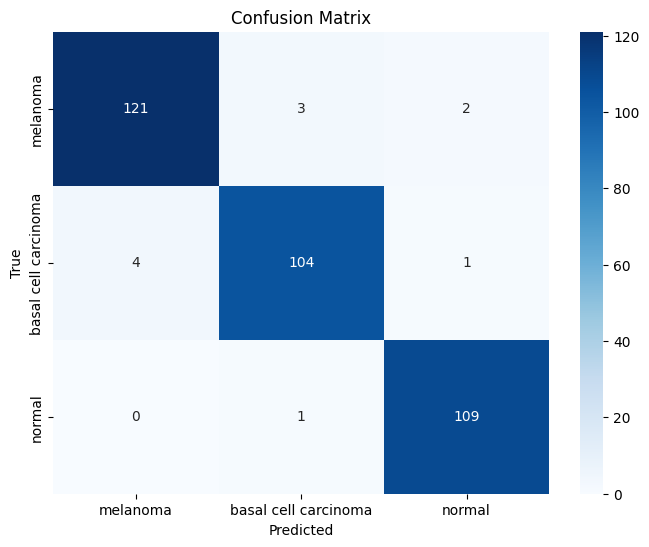

In [125]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_lstm_1)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [111]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

stacked_model_cnn_lstm_2 = fit_stacked_model(paired_cnn_lstm_models[1], X_test, y_test_1d)
y_pred_cnn_lstm_2 = stacked_prediction(paired_cnn_lstm_models[1], stacked_model_cnn_lstm_2, X_test)

# Hitung matriks kebingungan
conf_matrix_2 = confusion_matrix(y_test_1d, y_pred_cnn_lstm_2)
accuracy_2 = accuracy_score(y_test_1d, y_pred_cnn_lstm_2)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_2[0, 0]
false_positive = conf_matrix_2[0, 1]
false_negative = conf_matrix_2[1, 0]
true_positive = conf_matrix_2[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_2 = classification_report(y_test_1d, y_pred_cnn_lstm_2, output_dict=True)
precision = classification_report_2['weighted avg']['precision']
recall = classification_report_2['weighted avg']['recall']
f1 = classification_report_2['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_2}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_lstm_2))

Stacked Model Metrics:
Accuracy: 0.9652173913043478
Precision: 0.9653080552310722
Recall: 0.9652173913043478
F1 Score: 0.9650955388531453
Sensitivity: 0.9622641509433962
Specificity: 0.976
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       126
           1       0.97      0.94      0.95       109
           2       0.96      0.99      0.98       110

    accuracy                           0.97       345
   macro avg       0.97      0.96      0.97       345
weighted avg       0.97      0.97      0.97       345



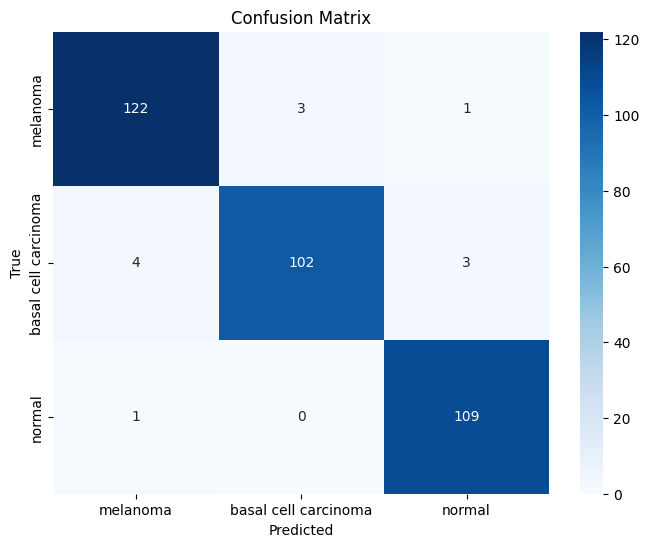

In [126]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_lstm_2)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [112]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

stacked_model_cnn_lstm_3 = fit_stacked_model(paired_cnn_lstm_models[2], X_test, y_test_1d)
y_pred_cnn_lstm_3 = stacked_prediction(paired_cnn_lstm_models[2], stacked_model_cnn_lstm_3, X_test)

# Hitung matriks kebingungan
conf_matrix_3 = confusion_matrix(y_test_1d, y_pred_cnn_lstm_3)
accuracy_3 = accuracy_score(y_test_1d, y_pred_cnn_lstm_3)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_3[0, 0]
false_positive = conf_matrix_3[0, 1]
false_negative = conf_matrix_3[1, 0]
true_positive = conf_matrix_3[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
precision = precision_score(y_test_1d, y_pred_cnn_lstm_3, average='weighted')
recall = recall_score(y_test_1d, y_pred_cnn_lstm_3, average='weighted')
f1 = f1_score(y_test_1d, y_pred_cnn_lstm_3, average='weighted')

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_3}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_lstm_3))

Stacked Model Metrics:
Accuracy: 0.9681159420289855
Precision: 0.9683813153479482
Recall: 0.9681159420289855
F1 Score: 0.96800744839072
Sensitivity: 0.9622641509433962
Specificity: 0.992
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       126
           1       0.98      0.94      0.96       109
           2       0.96      0.98      0.97       110

    accuracy                           0.97       345
   macro avg       0.97      0.97      0.97       345
weighted avg       0.97      0.97      0.97       345



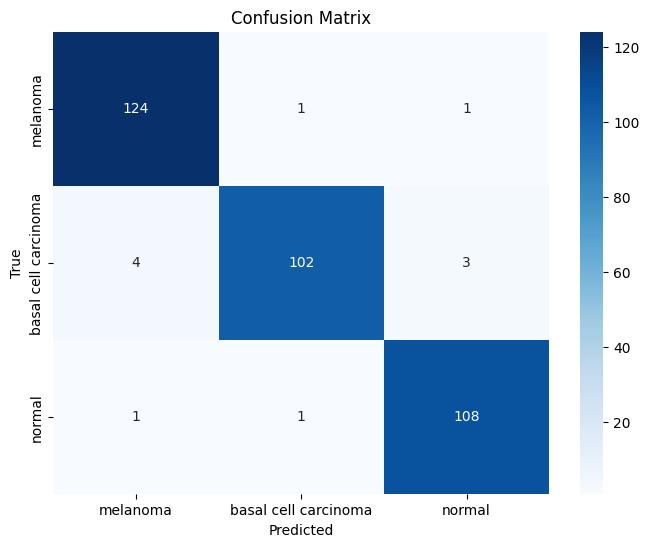

In [127]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_lstm_3)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [113]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

stacked_model_cnn_lstm_4 = fit_stacked_model(paired_cnn_lstm_models[3], X_test, y_test_1d)
y_pred_cnn_lstm_4 = stacked_prediction(paired_cnn_lstm_models[3], stacked_model_cnn_lstm_4, X_test)

# Hitung matriks kebingungan
conf_matrix_4 = confusion_matrix(y_test_1d, y_pred_cnn_lstm_4)
accuracy_4 = accuracy_score(y_test_1d, y_pred_cnn_lstm_4)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_4[0, 0]
false_positive = conf_matrix_4[0, 1]
false_negative = conf_matrix_4[1, 0]
true_positive = conf_matrix_4[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
precision = precision_score(y_test_1d, y_pred_cnn_lstm_4, average='weighted')
recall = recall_score(y_test_1d, y_pred_cnn_lstm_4, average='weighted')
f1 = f1_score(y_test_1d, y_pred_cnn_lstm_4, average='weighted')

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_4}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_lstm_4))

Stacked Model Metrics:
Accuracy: 0.9623188405797102
Precision: 0.9623754661323537
Recall: 0.9623188405797102
F1 Score: 0.9622328725094121
Sensitivity: 0.9622641509433962
Specificity: 0.9838709677419355
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       126
           1       0.96      0.94      0.95       109
           2       0.96      0.98      0.97       110

    accuracy                           0.96       345
   macro avg       0.96      0.96      0.96       345
weighted avg       0.96      0.96      0.96       345



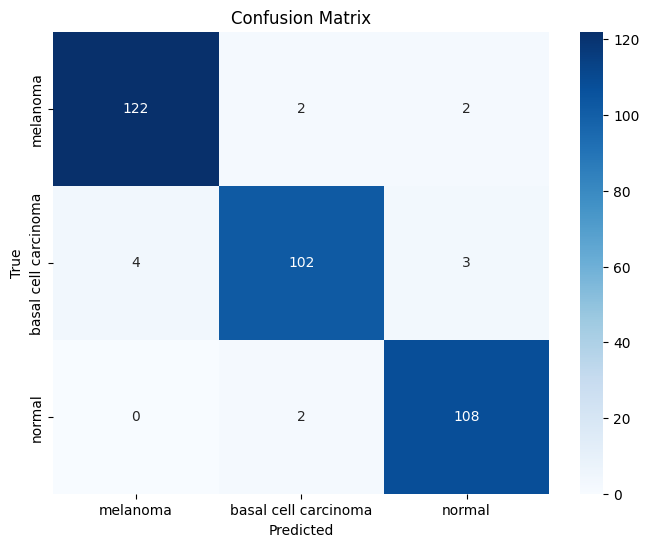

In [128]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_lstm_4)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [114]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

stacked_model_cnn_lstm_5 = fit_stacked_model(paired_cnn_lstm_models[4], X_test, y_test_1d)
y_pred_cnn_lstm_5 = stacked_prediction(paired_cnn_lstm_models[4], stacked_model_cnn_lstm_5, X_test)

# Hitung matriks kebingungan
conf_matrix_5 = confusion_matrix(y_test_1d, y_pred_cnn_lstm_5)
accuracy_5 = accuracy_score(y_test_1d, y_pred_cnn_lstm_5)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_5[0, 0]
false_positive = conf_matrix_5[0, 1]
false_negative = conf_matrix_5[1, 0]
true_positive = conf_matrix_5[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
precision = precision_score(y_test_1d, y_pred_cnn_lstm_5, average='weighted')
recall = recall_score(y_test_1d, y_pred_cnn_lstm_5, average='weighted')
f1 = f1_score(y_test_1d, y_pred_cnn_lstm_5, average='weighted')

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_5}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_lstm_5))

Stacked Model Metrics:
Accuracy: 0.9710144927536232
Precision: 0.9711015356977204
Recall: 0.9710144927536232
F1 Score: 0.9709724732021374
Sensitivity: 0.9813084112149533
Specificity: 0.9758064516129032
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       126
           1       0.97      0.96      0.97       109
           2       0.96      0.99      0.98       110

    accuracy                           0.97       345
   macro avg       0.97      0.97      0.97       345
weighted avg       0.97      0.97      0.97       345



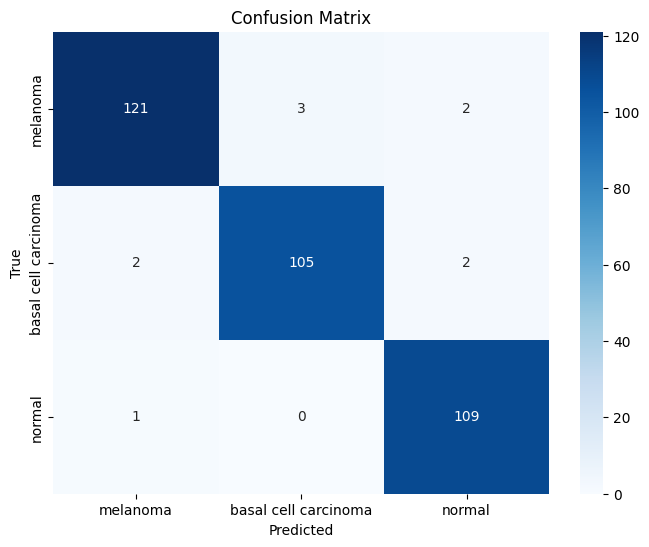

In [129]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_lstm_5)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# CNN RNN Stacking

## Data Training

In [60]:
# Panggil fungsi untuk meload model CNN dan DNN 1 hingga 5
# Panggil fungsi untuk meload model CNN dan DNN 1 hingga 5
models_cnn_fold = [1, 2, 3, 4, 5]
members_cnn_fold = load_selected_models("models_cnn", "model_cnn")
print('Loaded %d CNN models' % len(members_cnn_fold))

models_rnn_fold = [1, 2, 3, 4, 5]
members_rnn_fold = load_selected_models("models_rnn", "model_rnn")
print('Loaded %d RNN models' % len(members_rnn_fold))


# Membuat pasangan model CNN dan DNN untuk setiap fold
paired_cnn_rnn_models = []
for cnn_model, dnn_model in zip(members_cnn_fold, members_rnn_fold):
    paired_cnn_rnn_models.append((cnn_model, dnn_model))

# Misalnya untuk fold pertama
cnn_model_fold_1, rnn_model_fold_1 = paired_cnn_rnn_models[0]
cnn_model_fold_2, rnn_model_fold_2 = paired_cnn_rnn_models[1]
cnn_model_fold_3, rnn_model_fold_3 = paired_cnn_rnn_models[2]
cnn_model_fold_4, rnn_model_fold_4 = paired_cnn_rnn_models[3]
cnn_model_fold_5, rnn_model_fold_5 = paired_cnn_rnn_models[4]


> Loaded models_cnn\model_cnn_fold_1.h5 and models_cnn\model_cnn_fold_1.h5
> Loaded models_cnn\model_cnn_fold_2.h5 and models_cnn\model_cnn_fold_2.h5


> Loaded models_cnn\model_cnn_fold_3.h5 and models_cnn\model_cnn_fold_3.h5
> Loaded models_cnn\model_cnn_fold_4.h5 and models_cnn\model_cnn_fold_4.h5


> Loaded models_cnn\model_cnn_fold_5.h5 and models_cnn\model_cnn_fold_5.h5
Loaded 5 CNN models
> Loaded models_rnn\model_rnn_fold_1.h5 and models_rnn\model_rnn_fold_1.h5


> Loaded models_rnn\model_rnn_fold_2.h5 and models_rnn\model_rnn_fold_2.h5
> Loaded models_rnn\model_rnn_fold_3.h5 and models_rnn\model_rnn_fold_3.h5


> Loaded models_rnn\model_rnn_fold_4.h5 and models_rnn\model_rnn_fold_4.h5
> Loaded models_rnn\model_rnn_fold_5.h5 and models_rnn\model_rnn_fold_5.h5
Loaded 5 RNN models


In [61]:
y_train_1d = np.argmax(y_train, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

In [78]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_rnn_1 = fit_stacked_model(paired_cnn_rnn_models[0], X_train, y_train_1d)
y_pred_cnn_rnn_1 = stacked_prediction(paired_cnn_rnn_models[0], stacked_model_cnn_rnn_1, X_train)

# Hitung matriks kebingungan
conf_matrix_1 = confusion_matrix(y_train_1d, y_pred_cnn_rnn_1)
accuracy_1 = accuracy_score(y_train_1d, y_pred_cnn_rnn_1)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_1[0, 0]
false_positive = conf_matrix_1[0, 1]
false_negative = conf_matrix_1[1, 0]
true_positive = conf_matrix_1[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_1 = classification_report(y_train_1d, y_pred_cnn_rnn_1, output_dict=True)
precision = classification_report_1['weighted avg']['precision']
recall = classification_report_1['weighted avg']['recall']
f1 = classification_report_1['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_rnn_1))

Stacked Model Metrics:
Accuracy: 0.9492753623188406
Precision: 0.9497996578201415
Recall: 0.9492753623188406
F1 Score: 0.9491902706552046
Sensitivity: 0.9073275862068966
Specificity: 0.9551569506726457
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       449
           1       0.95      0.90      0.93       466
           2       0.99      1.00      0.99       465

    accuracy                           0.95      1380
   macro avg       0.95      0.95      0.95      1380
weighted avg       0.95      0.95      0.95      1380



In [79]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

stacked_model_cnn_rnn_2 = fit_stacked_model(paired_cnn_rnn_models[1], X_train, y_train_1d)
y_pred_cnn_rnn_2 = stacked_prediction(paired_cnn_rnn_models[1], stacked_model_cnn_rnn_2, X_train)

# Hitung matriks kebingungan
conf_matrix_2 = confusion_matrix(y_train_1d, y_pred_cnn_rnn_2)
accuracy_2 = accuracy_score(y_train_1d, y_pred_cnn_rnn_2)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_2[0, 0]
false_positive = conf_matrix_2[0, 1]
false_negative = conf_matrix_2[1, 0]
true_positive = conf_matrix_2[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_2 = classification_report(y_train_1d, y_pred_cnn_rnn_2, output_dict=True)
precision = classification_report_2['weighted avg']['precision']
recall = classification_report_2['weighted avg']['recall']
f1 = classification_report_2['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_2}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_rnn_2))

Stacked Model Metrics:
Accuracy: 0.9449275362318841
Precision: 0.9457840763361344
Recall: 0.9449275362318841
F1 Score: 0.9448583474141836
Sensitivity: 0.9049676025917927
Specificity: 0.9615384615384616
              precision    recall  f1-score   support

           0       0.90      0.95      0.92       449
           1       0.96      0.90      0.93       466
           2       0.98      0.99      0.98       465

    accuracy                           0.94      1380
   macro avg       0.95      0.94      0.94      1380
weighted avg       0.95      0.94      0.94      1380



In [80]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

stacked_model_cnn_rnn_3 = fit_stacked_model(paired_cnn_rnn_models[2], X_train, y_train_1d)
y_pred_cnn_rnn_3 = stacked_prediction(paired_cnn_rnn_models[2], stacked_model_cnn_rnn_3, X_train)

# Hitung matriks kebingungan
conf_matrix_3 = confusion_matrix(y_train_1d, y_pred_cnn_rnn_3)
accuracy_3 = accuracy_score(y_train_1d, y_pred_cnn_rnn_3)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_3[0, 0]
false_positive = conf_matrix_3[0, 1]
false_negative = conf_matrix_3[1, 0]
true_positive = conf_matrix_3[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
precision = precision_score(y_train_1d, y_pred_cnn_rnn_3, average='weighted')
recall = recall_score(y_train_1d, y_pred_cnn_rnn_3, average='weighted')
f1 = f1_score(y_train_1d, y_pred_cnn_rnn_3, average='weighted')

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_3}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_rnn_3))

Stacked Model Metrics:
Accuracy: 0.9536231884057971
Precision: 0.9554730560736068
Recall: 0.9536231884057971
F1 Score: 0.9535537156325035
Sensitivity: 0.9047619047619048
Specificity: 0.9798657718120806
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       449
           1       0.97      0.90      0.93       466
           2       0.99      0.99      0.99       465

    accuracy                           0.95      1380
   macro avg       0.95      0.95      0.95      1380
weighted avg       0.96      0.95      0.95      1380



In [81]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

stacked_model_cnn_rnn_4 = fit_stacked_model(paired_cnn_rnn_models[3], X_train, y_train_1d)
y_pred_cnn_rnn_4 = stacked_prediction(paired_cnn_rnn_models[3], stacked_model_cnn_rnn_4, X_train)

# Hitung matriks kebingungan
conf_matrix_4 = confusion_matrix(y_train_1d, y_pred_cnn_rnn_4)
accuracy_4 = accuracy_score(y_train_1d, y_pred_cnn_rnn_4)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_4[0, 0]
false_positive = conf_matrix_4[0, 1]
false_negative = conf_matrix_4[1, 0]
true_positive = conf_matrix_4[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
precision = precision_score(y_train_1d, y_pred_cnn_rnn_4, average='weighted')
recall = recall_score(y_train_1d, y_pred_cnn_rnn_4, average='weighted')
f1 = f1_score(y_train_1d, y_pred_cnn_rnn_4, average='weighted')

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_4}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_rnn_4))

Stacked Model Metrics:
Accuracy: 0.941304347826087
Precision: 0.9449445004198651
Recall: 0.941304347826087
F1 Score: 0.9410841710958467
Sensitivity: 0.8701298701298701
Specificity: 0.9841986455981941
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       449
           1       0.98      0.86      0.92       466
           2       0.98      0.99      0.99       465

    accuracy                           0.94      1380
   macro avg       0.94      0.94      0.94      1380
weighted avg       0.94      0.94      0.94      1380



In [109]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

stacked_model_cnn_rnn_5 = fit_stacked_model(paired_cnn_rnn_models[4], X_train, y_train_1d)
y_pred_cnn_rnn_5 = stacked_prediction(paired_cnn_rnn_models[4], stacked_model_cnn_rnn_5, X_train)

# Hitung matriks kebingungan
conf_matrix_5 = confusion_matrix(y_train_1d, y_pred_cnn_rnn_5)
accuracy_5 = accuracy_score(y_train_1d, y_pred_cnn_rnn_5)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_5[0, 0]
false_positive = conf_matrix_5[0, 1]
false_negative = conf_matrix_5[1, 0]
true_positive = conf_matrix_5[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
precision = precision_score(y_train_1d, y_pred_cnn_rnn_5, average='weighted')
recall = recall_score(y_train_1d, y_pred_cnn_rnn_5, average='weighted')
f1 = f1_score(y_train_1d, y_pred_cnn_rnn_5, average='weighted')

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_5}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_rnn_5))

Stacked Model Metrics:
Accuracy: 0.9543478260869566
Precision: 0.95578247334666
Recall: 0.9543478260869566
F1 Score: 0.9543505903497431
Sensitivity: 0.9075268817204301
Specificity: 0.9775280898876404
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       449
           1       0.97      0.91      0.94       466
           2       0.99      0.99      0.99       465

    accuracy                           0.95      1380
   macro avg       0.96      0.95      0.95      1380
weighted avg       0.96      0.95      0.95      1380



## Data Test

In [62]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_rnn_1 = fit_stacked_model(paired_cnn_rnn_models[0], X_test, y_test_1d)
y_pred_cnn_rnn_1 = stacked_prediction(paired_cnn_rnn_models[0], stacked_model_cnn_rnn_1, X_test)

# Hitung matriks kebingungan
conf_matrix_1 = confusion_matrix(y_test_1d, y_pred_cnn_rnn_1)
accuracy_1 = accuracy_score(y_test_1d, y_pred_cnn_rnn_1)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_1[0, 0]
false_positive = conf_matrix_1[0, 1]
false_negative = conf_matrix_1[1, 0]
true_positive = conf_matrix_1[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_1 = classification_report(y_test_1d, y_pred_cnn_rnn_1, output_dict=True)
precision = classification_report_1['weighted avg']['precision']
recall = classification_report_1['weighted avg']['recall']
f1 = classification_report_1['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_rnn_1))

Stacked Model Metrics:
Accuracy: 0.9797101449275363
Precision: 0.9798913043478261
Recall: 0.9797101449275363
F1 Score: 0.9797520224212102
Sensitivity: 0.9724770642201835
Specificity: 0.9841269841269841
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       126
           1       0.97      0.97      0.97       109
           2       1.00      0.98      0.99       110

    accuracy                           0.98       345
   macro avg       0.98      0.98      0.98       345
weighted avg       0.98      0.98      0.98       345



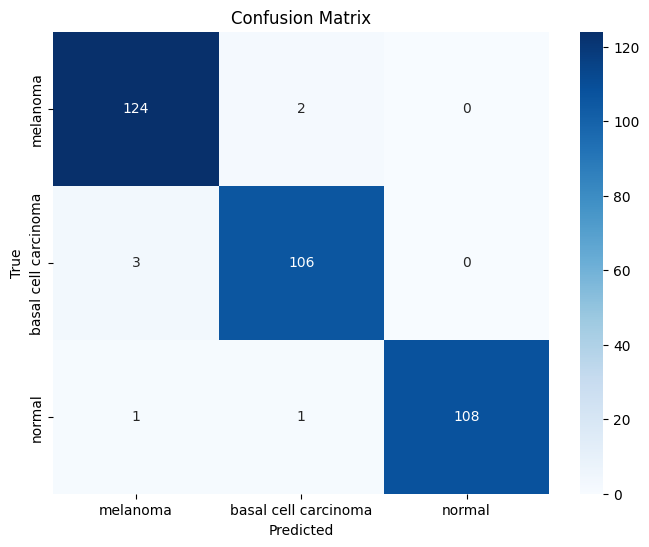

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_rnn_1)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [64]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

stacked_model_cnn_rnn_2 = fit_stacked_model(paired_cnn_rnn_models[1], X_test, y_test_1d)
y_pred_cnn_rnn_2 = stacked_prediction(paired_cnn_rnn_models[1], stacked_model_cnn_rnn_2, X_test)

# Hitung matriks kebingungan
conf_matrix_2 = confusion_matrix(y_test_1d, y_pred_cnn_rnn_2)
accuracy_2 = accuracy_score(y_test_1d, y_pred_cnn_rnn_2)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_2[0, 0]
false_positive = conf_matrix_2[0, 1]
false_negative = conf_matrix_2[1, 0]
true_positive = conf_matrix_2[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_2 = classification_report(y_test_1d, y_pred_cnn_rnn_2, output_dict=True)
precision = classification_report_2['weighted avg']['precision']
recall = classification_report_2['weighted avg']['recall']
f1 = classification_report_2['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_2}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_rnn_2))

Stacked Model Metrics:
Accuracy: 0.9739130434782609
Precision: 0.9740143524768138
Recall: 0.9739130434782609
F1 Score: 0.9737949188671073
Sensitivity: 0.9626168224299065
Specificity: 0.984
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       126
           1       0.98      0.94      0.96       109
           2       0.97      1.00      0.99       110

    accuracy                           0.97       345
   macro avg       0.97      0.97      0.97       345
weighted avg       0.97      0.97      0.97       345



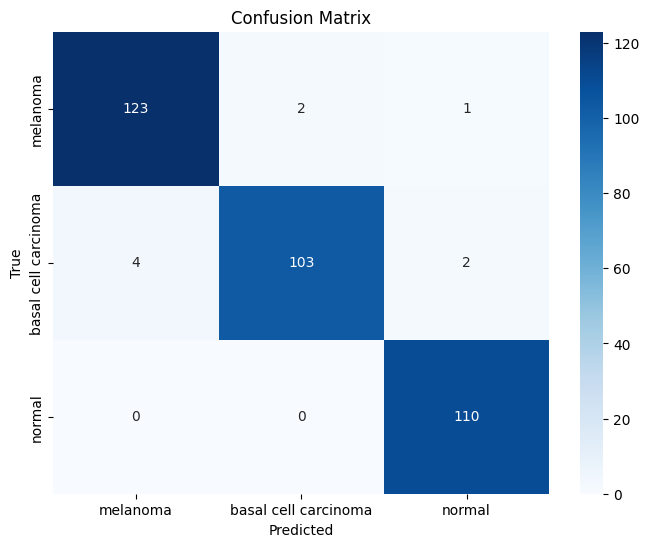

In [65]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_rnn_2)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

stacked_model_cnn_rnn_3 = fit_stacked_model(paired_cnn_rnn_models[2], X_test, y_test_1d)
y_pred_cnn_rnn_3 = stacked_prediction(paired_cnn_rnn_models[2], stacked_model_cnn_rnn_3, X_test)

# Hitung matriks kebingungan
conf_matrix_3 = confusion_matrix(y_test_1d, y_pred_cnn_rnn_3)
accuracy_3 = accuracy_score(y_test_1d, y_pred_cnn_rnn_3)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_3[0, 0]
false_positive = conf_matrix_3[0, 1]
false_negative = conf_matrix_3[1, 0]
true_positive = conf_matrix_3[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
precision = precision_score(y_test_1d, y_pred_cnn_rnn_3, average='weighted')
recall = recall_score(y_test_1d, y_pred_cnn_rnn_3, average='weighted')
f1 = f1_score(y_test_1d, y_pred_cnn_rnn_3, average='weighted')

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_3}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_rnn_3))

Stacked Model Metrics:
Accuracy: 0.9710144927536232
Precision: 0.9710232667450058
Recall: 0.9710144927536232
F1 Score: 0.9710068637509769
Sensitivity: 0.9813084112149533
Specificity: 0.976
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       126
           1       0.96      0.96      0.96       109
           2       0.97      0.98      0.98       110

    accuracy                           0.97       345
   macro avg       0.97      0.97      0.97       345
weighted avg       0.97      0.97      0.97       345



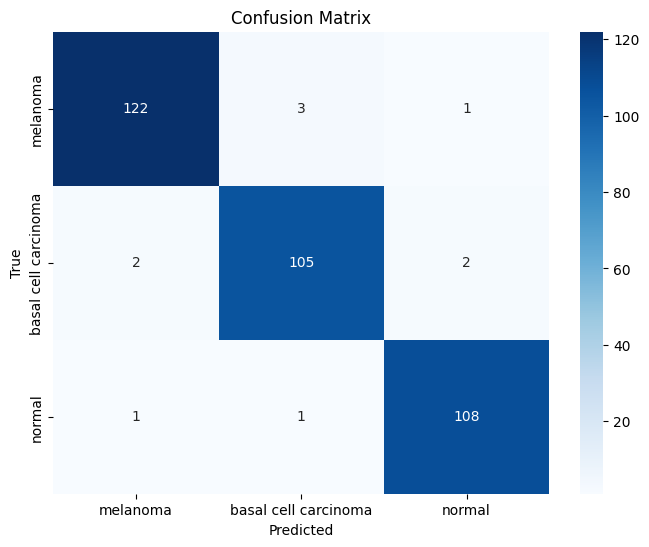

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_rnn_3)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

stacked_model_cnn_rnn_4 = fit_stacked_model(paired_cnn_rnn_models[3], X_test, y_test_1d)
y_pred_cnn_rnn_4 = stacked_prediction(paired_cnn_rnn_models[3], stacked_model_cnn_rnn_4, X_test)

# Hitung matriks kebingungan
conf_matrix_4 = confusion_matrix(y_test_1d, y_pred_cnn_rnn_4)
accuracy_4 = accuracy_score(y_test_1d, y_pred_cnn_rnn_4)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_4[0, 0]
false_positive = conf_matrix_4[0, 1]
false_negative = conf_matrix_4[1, 0]
true_positive = conf_matrix_4[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
precision = precision_score(y_test_1d, y_pred_cnn_rnn_4, average='weighted')
recall = recall_score(y_test_1d, y_pred_cnn_rnn_4, average='weighted')
f1 = f1_score(y_test_1d, y_pred_cnn_rnn_4, average='weighted')

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_4}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_rnn_4))

Stacked Model Metrics:
Accuracy: 0.9594202898550724
Precision: 0.9593771950003834
Recall: 0.9594202898550724
F1 Score: 0.9593616494327815
Sensitivity: 0.9626168224299065
Specificity: 0.967741935483871
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       126
           1       0.95      0.94      0.95       109
           2       0.96      0.98      0.97       110

    accuracy                           0.96       345
   macro avg       0.96      0.96      0.96       345
weighted avg       0.96      0.96      0.96       345



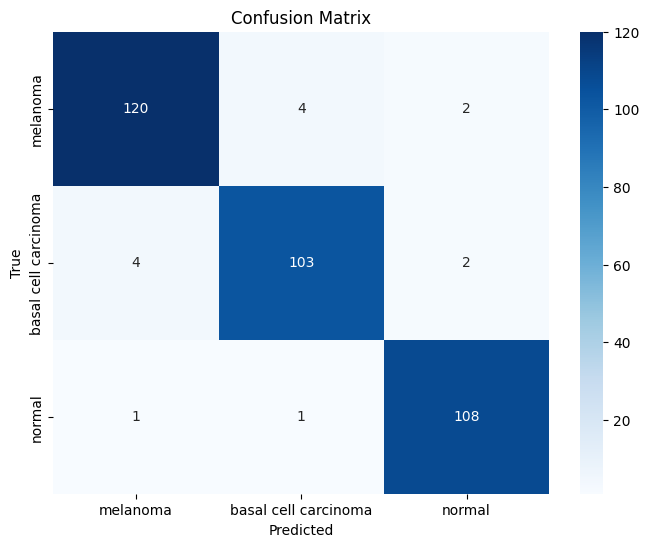

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_rnn_4)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

stacked_model_cnn_rnn_5 = fit_stacked_model(paired_cnn_rnn_models[4], X_test, y_test_1d)
y_pred_cnn_rnn_5 = stacked_prediction(paired_cnn_rnn_models[4], stacked_model_cnn_rnn_5, X_test)

# Hitung matriks kebingungan
conf_matrix_5 = confusion_matrix(y_test_1d, y_pred_cnn_rnn_5)
accuracy_5 = accuracy_score(y_test_1d, y_pred_cnn_rnn_5)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_5[0, 0]
false_positive = conf_matrix_5[0, 1]
false_negative = conf_matrix_5[1, 0]
true_positive = conf_matrix_5[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
precision = precision_score(y_test_1d, y_pred_cnn_rnn_5, average='weighted')
recall = recall_score(y_test_1d, y_pred_cnn_rnn_5, average='weighted')
f1 = f1_score(y_test_1d, y_pred_cnn_rnn_5, average='weighted')

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_5}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_rnn_5))

Stacked Model Metrics:
Accuracy: 0.9594202898550724
Precision: 0.9596375901322887
Recall: 0.9594202898550724
F1 Score: 0.9591685422012978
Sensitivity: 0.9345794392523364
Specificity: 0.9758064516129032
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       126
           1       0.97      0.92      0.94       109
           2       0.96      1.00      0.98       110

    accuracy                           0.96       345
   macro avg       0.96      0.96      0.96       345
weighted avg       0.96      0.96      0.96       345



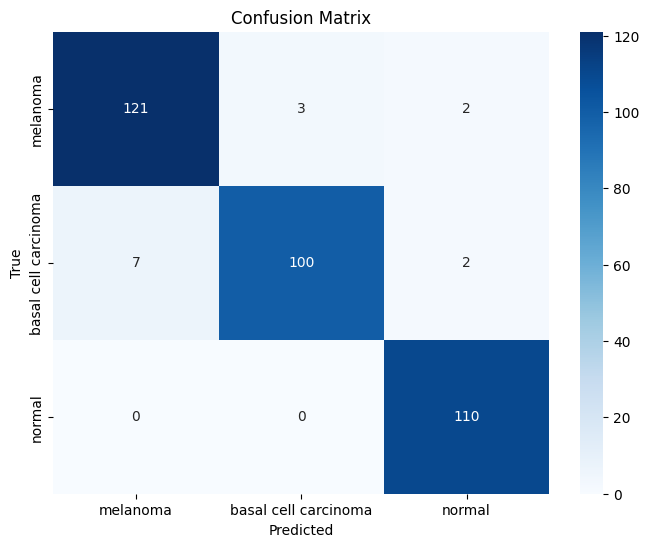

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_rnn_5)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# CNN DNN Stacking

In [59]:
import os
from keras.models import load_model
from numpy import dstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Fungsi dependencies
def accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

dependencies = {
    'accuracy': accuracy  
}


# Fungsi load model terpilih
def load_selected_models(folder_path, model_prefix):
    all_models = []
    for i in range(1, 6):  # 5 model dari fold 1 hingga 5
        # Definisikan nama file untuk model CNN dan DNN
        cnn_filename = os.path.join(folder_path, f'{model_prefix}_fold_{i}.h5')
        dnn_filename = os.path.join(folder_path, f'{model_prefix}_fold_{i}.h5')
        # Memuat model CNN dan DNN
        cnn_model = load_model(cnn_filename, custom_objects=dependencies)
        dnn_model = load_model(dnn_filename, custom_objects=dependencies)
        # Menambahkan model CNN dan DNN ke daftar members
        all_models.append((cnn_model, dnn_model))
        print(f'> Loaded {cnn_filename} and {dnn_filename}')
    return all_models

# Fungsi dataset input model gabungan
def stacked_dataset(members, inputX):
    stackX = None
    for cnn_model, dnn_model in members:
        # Melakukan prediksi dengan model CNN
        cnn_prediction = cnn_model.predict(inputX, verbose=0)
        # Melakukan prediksi dengan model DNN
        dnn_prediction = dnn_model.predict(inputX, verbose=0)
        # Menggabungkan prediksi CNN dan DNN
        stacked_prediction = dstack((cnn_prediction, dnn_prediction))
        # Membuat stack prediksi menjadi [baris, anggota, probabilitas]
        if stackX is None:
            stackX = stacked_prediction
        else:
            stackX = dstack((stackX, stacked_prediction))
    # Meratakan prediksi menjadi [baris, anggota x probabilitas]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

# Fungsi memasangkan model berdasarkan output dari anggota ensemble
def fit_stacked_model(members, inputX, inputy):
    # Membuat dataset menggunakan ensemble
    stackedX = stacked_dataset(members, inputX)
    # Melatih model mandiri
    model = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=10, min_samples_split=4, min_samples_leaf=2, random_state=42) #meta learner
    model.fit(stackedX, inputy)
    return model

# Function to make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
    # Create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # Make a prediction
    yhat = model.predict(stackedX)
    return yhat


# Memuat dan memasangkan model
cnn_models = load_selected_models("models_cnn", "model_cnn")
dnn_models = load_selected_models("models_dnn", "model_dnn")
# Membuat pasangan model CNN dan DNN
paired_models = list(zip(cnn_models, dnn_models))

stacked_model_pair = paired_models

> Loaded models_cnn\model_cnn_fold_1.h5 and models_cnn\model_cnn_fold_1.h5
> Loaded models_cnn\model_cnn_fold_2.h5 and models_cnn\model_cnn_fold_2.h5


> Loaded models_cnn\model_cnn_fold_3.h5 and models_cnn\model_cnn_fold_3.h5


> Loaded models_cnn\model_cnn_fold_4.h5 and models_cnn\model_cnn_fold_4.h5
> Loaded models_cnn\model_cnn_fold_5.h5 and models_cnn\model_cnn_fold_5.h5


> Loaded models_dnn\model_dnn_fold_1.h5 and models_dnn\model_dnn_fold_1.h5
> Loaded models_dnn\model_dnn_fold_2.h5 and models_dnn\model_dnn_fold_2.h5


> Loaded models_dnn\model_dnn_fold_3.h5 and models_dnn\model_dnn_fold_3.h5
> Loaded models_dnn\model_dnn_fold_4.h5 and models_dnn\model_dnn_fold_4.h5


> Loaded models_dnn\model_dnn_fold_5.h5 and models_dnn\model_dnn_fold_5.h5


## Data Training

In [72]:
y_train_1d = np.argmax(y_train, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

In [ ]:
# Panggil fungsi untuk meload model CNN dan DNN 1 hingga 5
# Panggil fungsi untuk meload model CNN dan DNN 1 hingga 5
models_cnn_fold = [1, 2, 3, 4, 5]
members_cnn_fold = load_selected_models("models_cnn", "model_cnn")
print('Loaded %d CNN models' % len(members_cnn_fold))

models_dnn_fold = [1, 2, 3, 4, 5]
members_dnn_fold = load_selected_models("models_dnn", "model_dnn")
print('Loaded %d DNN models' % len(members_dnn_fold))


# Membuat pasangan model CNN dan DNN untuk setiap fold
paired_models = []
for cnn_model, dnn_model in zip(members_cnn_fold, members_dnn_fold):
    paired_models.append((cnn_model, dnn_model))

# Misalnya untuk fold pertama
cnn_model_fold_1, dnn_model_fold_1 = paired_models[0]
cnn_model_fold_2, dnn_model_fold_2 = paired_models[1]
cnn_model_fold_3, dnn_model_fold_3 = paired_models[2]
cnn_model_fold_4, dnn_model_fold_4 = paired_models[3]
cnn_model_fold_5, dnn_model_fold_5 = paired_models[4]


> Loaded models_cnn\model_cnn_fold_1.h5 and models_cnn\model_cnn_fold_1.h5
> Loaded models_cnn\model_cnn_fold_2.h5 and models_cnn\model_cnn_fold_2.h5


> Loaded models_cnn\model_cnn_fold_3.h5 and models_cnn\model_cnn_fold_3.h5
> Loaded models_cnn\model_cnn_fold_4.h5 and models_cnn\model_cnn_fold_4.h5


> Loaded models_cnn\model_cnn_fold_5.h5 and models_cnn\model_cnn_fold_5.h5
Loaded 5 CNN models
> Loaded models_dnn\model_dnn_fold_1.h5 and models_dnn\model_dnn_fold_1.h5


> Loaded models_dnn\model_dnn_fold_2.h5 and models_dnn\model_dnn_fold_2.h5
> Loaded models_dnn\model_dnn_fold_3.h5 and models_dnn\model_dnn_fold_3.h5


> Loaded models_dnn\model_dnn_fold_4.h5 and models_dnn\model_dnn_fold_4.h5
> Loaded models_dnn\model_dnn_fold_5.h5 and models_dnn\model_dnn_fold_5.h5
Loaded 5 DNN models


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_dnn_1 = fit_stacked_model(paired_models[0], X_train, y_train_1d)
y_pred_cnn_dnn_1 = stacked_prediction(paired_models[0], stacked_model_cnn_dnn_1, X_train)

# Hitung matriks kebingungan
conf_matrix_1 = confusion_matrix(y_train_1d, y_pred_cnn_dnn_1)
accuracy_1 = accuracy_score(y_train_1d, y_pred_cnn_dnn_1)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_1[0, 0]
false_positive = conf_matrix_1[0, 1]
false_negative = conf_matrix_1[1, 0]
true_positive = conf_matrix_1[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_1 = classification_report(y_train_1d, y_pred_cnn_dnn_1, output_dict=True)
precision = classification_report_1['weighted avg']['precision']
recall = classification_report_1['weighted avg']['recall']
f1 = classification_report_1['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_dnn_1))

Stacked Model Metrics:
Accuracy: 0.9601449275362319
Precision: 0.9602705006917855
Recall: 0.9601449275362319
F1 Score: 0.9600753469582631
Sensitivity: 0.937365010799136
Specificity: 0.9662162162162162
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       449
           1       0.96      0.93      0.95       466
           2       0.98      0.99      0.99       465

    accuracy                           0.96      1380
   macro avg       0.96      0.96      0.96      1380
weighted avg       0.96      0.96      0.96      1380



In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

stacked_model_cnn_dnn_2 = fit_stacked_model(paired_models[1], X_train, y_train_1d)
y_pred_cnn_dnn_2 = stacked_prediction(paired_models[1], stacked_model_cnn_dnn_2, X_train)

# Hitung matriks kebingungan
conf_matrix_2 = confusion_matrix(y_train_1d, y_pred_cnn_dnn_2)
accuracy_2 = accuracy_score(y_train_1d, y_pred_cnn_dnn_2)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_2[0, 0]
false_positive = conf_matrix_2[0, 1]
false_negative = conf_matrix_2[1, 0]
true_positive = conf_matrix_2[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_2 = classification_report(y_train_1d, y_pred_cnn_dnn_2, output_dict=True)
precision = classification_report_2['weighted avg']['precision']
recall = classification_report_2['weighted avg']['recall']
f1 = classification_report_2['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_2}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_dnn_2))

Stacked Model Metrics:
Accuracy: 0.9543478260869566
Precision: 0.9548482290065663
Recall: 0.9543478260869566
F1 Score: 0.9542888709059331
Sensitivity: 0.9222462203023758
Specificity: 0.9662162162162162
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       449
           1       0.96      0.92      0.94       466
           2       0.98      0.99      0.99       465

    accuracy                           0.95      1380
   macro avg       0.95      0.95      0.95      1380
weighted avg       0.95      0.95      0.95      1380



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

stacked_model_cnn_dnn_3 = fit_stacked_model(paired_models[2], X_train, y_train_1d)
y_pred_cnn_dnn_3 = stacked_prediction(paired_models[2], stacked_model_cnn_dnn_3, X_train)

# Hitung matriks kebingungan
conf_matrix_3 = confusion_matrix(y_train_1d, y_pred_cnn_dnn_3)
accuracy_3 = accuracy_score(y_train_1d, y_pred_cnn_dnn_3)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_3[0, 0]
false_positive = conf_matrix_3[0, 1]
false_negative = conf_matrix_3[1, 0]
true_positive = conf_matrix_3[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
precision = precision_score(y_train_1d, y_pred_cnn_dnn_3, average='weighted')
recall = recall_score(y_train_1d, y_pred_cnn_dnn_3, average='weighted')
f1 = f1_score(y_train_1d, y_pred_cnn_dnn_3, average='weighted')

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_3}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_dnn_3))

Stacked Model Metrics:
Accuracy: 0.9601449275362319
Precision: 0.9610390460732053
Recall: 0.9601449275362319
F1 Score: 0.9600708958058944
Sensitivity: 0.9222462203023758
Specificity: 0.9797752808988764
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       449
           1       0.97      0.92      0.94       466
           2       0.99      0.99      0.99       465

    accuracy                           0.96      1380
   macro avg       0.96      0.96      0.96      1380
weighted avg       0.96      0.96      0.96      1380



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

stacked_model_cnn_dnn_4 = fit_stacked_model(paired_models[3], X_train, y_train_1d)
y_pred_cnn_dnn_4 = stacked_prediction(paired_models[3], stacked_model_cnn_dnn_4, X_train)

# Hitung matriks kebingungan
conf_matrix_4 = confusion_matrix(y_train_1d, y_pred_cnn_dnn_4)
accuracy_4 = accuracy_score(y_train_1d, y_pred_cnn_dnn_4)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_4[0, 0]
false_positive = conf_matrix_4[0, 1]
false_negative = conf_matrix_4[1, 0]
true_positive = conf_matrix_4[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
precision = precision_score(y_train_1d, y_pred_cnn_dnn_4, average='weighted')
recall = recall_score(y_train_1d, y_pred_cnn_dnn_4, average='weighted')
f1 = f1_score(y_train_1d, y_pred_cnn_dnn_4, average='weighted')

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_4}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_dnn_4))

Stacked Model Metrics:
Accuracy: 0.9644927536231884
Precision: 0.9651641475699247
Recall: 0.9644927536231884
F1 Score: 0.9644721408533006
Sensitivity: 0.9311827956989247
Specificity: 0.9819819819819819
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       449
           1       0.98      0.93      0.95       466
           2       0.99      0.99      0.99       465

    accuracy                           0.96      1380
   macro avg       0.96      0.96      0.96      1380
weighted avg       0.97      0.96      0.96      1380



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

stacked_model_cnn_dnn_5 = fit_stacked_model(paired_models[4], X_train, y_train_1d)
y_pred_cnn_dnn_5 = stacked_prediction(paired_models[4], stacked_model_cnn_dnn_5, X_train)

# Hitung matriks kebingungan
conf_matrix_5 = confusion_matrix(y_train_1d, y_pred_cnn_dnn_5)
accuracy_5 = accuracy_score(y_train_1d, y_pred_cnn_dnn_5)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_5[0, 0]
false_positive = conf_matrix_5[0, 1]
false_negative = conf_matrix_5[1, 0]
true_positive = conf_matrix_5[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
precision = precision_score(y_train_1d, y_pred_cnn_dnn_5, average='weighted')
recall = recall_score(y_train_1d, y_pred_cnn_dnn_5, average='weighted')
f1 = f1_score(y_train_1d, y_pred_cnn_dnn_5, average='weighted')

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_5}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_dnn_5))

Stacked Model Metrics:
Accuracy: 0.9594202898550724
Precision: 0.9603564306800597
Recall: 0.9594202898550724
F1 Score: 0.9593772744130077
Sensitivity: 0.9222462203023758
Specificity: 0.9775784753363229
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       449
           1       0.97      0.92      0.94       466
           2       0.99      0.99      0.99       465

    accuracy                           0.96      1380
   macro avg       0.96      0.96      0.96      1380
weighted avg       0.96      0.96      0.96      1380



In [57]:
import os
from keras.models import load_model
from numpy import dstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Fungsi dependencies
def accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

dependencies = {
    'accuracy': accuracy  
}


# Fungsi load model terpilih
def load_selected_models(folder_path, model_prefix):
    all_models = []
    for i in range(1, 6):  # 5 model dari fold 1 hingga 5
        # Definisikan nama file untuk model CNN dan DNN
        cnn_filename = os.path.join(folder_path, f'{model_prefix}_fold_{i}.h5')
        dnn_filename = os.path.join(folder_path, f'{model_prefix}_fold_{i}.h5')
        # Memuat model CNN dan DNN
        cnn_model = load_model(cnn_filename, custom_objects=dependencies)
        dnn_model = load_model(dnn_filename, custom_objects=dependencies)
        # Menambahkan model CNN dan DNN ke daftar members
        all_models.append((cnn_model, dnn_model))
        print(f'> Loaded {cnn_filename} and {dnn_filename}')
    return all_models

# Fungsi dataset input model gabungan
def stacked_dataset(members, inputX):
    stackX = None
    for cnn_model, dnn_model in members:
        # Melakukan prediksi dengan model CNN
        cnn_prediction = cnn_model.predict(inputX, verbose=0)
        # Melakukan prediksi dengan model DNN
        dnn_prediction = dnn_model.predict(inputX, verbose=0)
        # Menggabungkan prediksi CNN dan DNN
        stacked_prediction = dstack((cnn_prediction, dnn_prediction))
        # Membuat stack prediksi menjadi [baris, anggota, probabilitas]
        if stackX is None:
            stackX = stacked_prediction
        else:
            stackX = dstack((stackX, stacked_prediction))
    # Meratakan prediksi menjadi [baris, anggota x probabilitas]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

# Fungsi memasangkan model berdasarkan output dari anggota ensemble
def fit_stacked_model(members, inputX, inputy):
    # Membuat dataset menggunakan ensemble
    stackedX = stacked_dataset(members, inputX)
    # Melatih model mandiri
    model = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=10, min_samples_split=4, min_samples_leaf=2, random_state=42) #meta learner
    model.fit(stackedX, inputy)
    return model

# Function to make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
    # Create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # Make a prediction
    yhat = model.predict(stackedX)
    return yhat


# Memuat dan memasangkan model
cnn_models = load_selected_models("models_cnn", "model_cnn")
dnn_models = load_selected_models("models_dnn", "model_dnn")
# Membuat pasangan model CNN dan DNN
paired_models = list(zip(cnn_models, dnn_models))

stacked_model_pair = paired_models

> Loaded models_cnn\model_cnn_fold_1.h5 and models_cnn\model_cnn_fold_1.h5
> Loaded models_cnn\model_cnn_fold_2.h5 and models_cnn\model_cnn_fold_2.h5


> Loaded models_cnn\model_cnn_fold_3.h5 and models_cnn\model_cnn_fold_3.h5
> Loaded models_cnn\model_cnn_fold_4.h5 and models_cnn\model_cnn_fold_4.h5


> Loaded models_cnn\model_cnn_fold_5.h5 and models_cnn\model_cnn_fold_5.h5
> Loaded models_dnn\model_dnn_fold_1.h5 and models_dnn\model_dnn_fold_1.h5


> Loaded models_dnn\model_dnn_fold_2.h5 and models_dnn\model_dnn_fold_2.h5
> Loaded models_dnn\model_dnn_fold_3.h5 and models_dnn\model_dnn_fold_3.h5


> Loaded models_dnn\model_dnn_fold_4.h5 and models_dnn\model_dnn_fold_4.h5
> Loaded models_dnn\model_dnn_fold_5.h5 and models_dnn\model_dnn_fold_5.h5


In [58]:
y_train_1d = np.argmax(y_train, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

In [59]:
# Panggil fungsi untuk meload model CNN dan DNN 1 hingga 5
# Panggil fungsi untuk meload model CNN dan DNN 1 hingga 5
models_cnn_fold = [1, 2, 3, 4, 5]
members_cnn_fold = load_selected_models("models_cnn", "model_cnn")
print('Loaded %d CNN models' % len(members_cnn_fold))

models_dnn_fold = [1, 2, 3, 4, 5]
members_dnn_fold = load_selected_models("models_dnn", "model_dnn")
print('Loaded %d DNN models' % len(members_dnn_fold))


# Membuat pasangan model CNN dan DNN untuk setiap fold
paired_models = []
for cnn_model, dnn_model in zip(members_cnn_fold, members_dnn_fold):
    paired_models.append((cnn_model, dnn_model))

# Misalnya untuk fold pertama
cnn_model_fold_1, dnn_model_fold_1 = paired_models[0]
cnn_model_fold_2, dnn_model_fold_2 = paired_models[1]
cnn_model_fold_3, dnn_model_fold_3 = paired_models[2]
cnn_model_fold_4, dnn_model_fold_4 = paired_models[3]
cnn_model_fold_5, dnn_model_fold_5 = paired_models[4]


> Loaded models_cnn\model_cnn_fold_1.h5 and models_cnn\model_cnn_fold_1.h5
> Loaded models_cnn\model_cnn_fold_2.h5 and models_cnn\model_cnn_fold_2.h5


> Loaded models_cnn\model_cnn_fold_3.h5 and models_cnn\model_cnn_fold_3.h5
> Loaded models_cnn\model_cnn_fold_4.h5 and models_cnn\model_cnn_fold_4.h5


> Loaded models_cnn\model_cnn_fold_5.h5 and models_cnn\model_cnn_fold_5.h5
Loaded 5 CNN models
> Loaded models_dnn\model_dnn_fold_1.h5 and models_dnn\model_dnn_fold_1.h5


> Loaded models_dnn\model_dnn_fold_2.h5 and models_dnn\model_dnn_fold_2.h5
> Loaded models_dnn\model_dnn_fold_3.h5 and models_dnn\model_dnn_fold_3.h5


> Loaded models_dnn\model_dnn_fold_4.h5 and models_dnn\model_dnn_fold_4.h5
> Loaded models_dnn\model_dnn_fold_5.h5 and models_dnn\model_dnn_fold_5.h5
Loaded 5 DNN models


In [63]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_dnn_1 = fit_stacked_model(paired_models[0], X_train, y_train_1d)
y_pred_cnn_dnn_1 = stacked_prediction(paired_models[0], stacked_model_cnn_dnn_1, X_train)

# Hitung matriks kebingungan
conf_matrix_1 = confusion_matrix(y_train_1d, y_pred_cnn_dnn_1)
accuracy_1 = accuracy_score(y_train_1d, y_pred_cnn_dnn_1)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_1[0, 0]
false_positive = conf_matrix_1[0, 1]
false_negative = conf_matrix_1[1, 0]
true_positive = conf_matrix_1[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_1 = classification_report(y_train_1d, y_pred_cnn_dnn_1, output_dict=True)
precision = classification_report_1['weighted avg']['precision']
recall = classification_report_1['weighted avg']['recall']
f1 = classification_report_1['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_dnn_1))

Stacked Model Metrics:
Accuracy: 0.9601449275362319
Precision: 0.9602705006917855
Recall: 0.9601449275362319
F1 Score: 0.9600753469582631
Sensitivity: 0.937365010799136
Specificity: 0.9662162162162162
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       449
           1       0.96      0.93      0.95       466
           2       0.98      0.99      0.99       465

    accuracy                           0.96      1380
   macro avg       0.96      0.96      0.96      1380
weighted avg       0.96      0.96      0.96      1380



In [65]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

stacked_model_cnn_dnn_2 = fit_stacked_model(paired_models[1], X_train, y_train_1d)
y_pred_cnn_dnn_2 = stacked_prediction(paired_models[1], stacked_model_cnn_dnn_2, X_train)

# Hitung matriks kebingungan
conf_matrix_2 = confusion_matrix(y_train_1d, y_pred_cnn_dnn_2)
accuracy_2 = accuracy_score(y_train_1d, y_pred_cnn_dnn_2)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_2[0, 0]
false_positive = conf_matrix_2[0, 1]
false_negative = conf_matrix_2[1, 0]
true_positive = conf_matrix_2[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_2 = classification_report(y_train_1d, y_pred_cnn_dnn_2, output_dict=True)
precision = classification_report_2['weighted avg']['precision']
recall = classification_report_2['weighted avg']['recall']
f1 = classification_report_2['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_2}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_dnn_2))

Stacked Model Metrics:
Accuracy: 0.9543478260869566
Precision: 0.9548482290065663
Recall: 0.9543478260869566
F1 Score: 0.9542888709059331
Sensitivity: 0.9222462203023758
Specificity: 0.9662162162162162
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       449
           1       0.96      0.92      0.94       466
           2       0.98      0.99      0.99       465

    accuracy                           0.95      1380
   macro avg       0.95      0.95      0.95      1380
weighted avg       0.95      0.95      0.95      1380



In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

stacked_model_cnn_dnn_3 = fit_stacked_model(paired_models[2], X_train, y_train_1d)
y_pred_cnn_dnn_3 = stacked_prediction(paired_models[2], stacked_model_cnn_dnn_3, X_train)

# Hitung matriks kebingungan
conf_matrix_3 = confusion_matrix(y_train_1d, y_pred_cnn_dnn_3)
accuracy_3 = accuracy_score(y_train_1d, y_pred_cnn_dnn_3)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_3[0, 0]
false_positive = conf_matrix_3[0, 1]
false_negative = conf_matrix_3[1, 0]
true_positive = conf_matrix_3[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
precision = precision_score(y_train_1d, y_pred_cnn_dnn_3, average='weighted')
recall = recall_score(y_train_1d, y_pred_cnn_dnn_3, average='weighted')
f1 = f1_score(y_train_1d, y_pred_cnn_dnn_3, average='weighted')

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_3}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_dnn_3))

Stacked Model Metrics:
Accuracy: 0.9601449275362319
Precision: 0.9610390460732053
Recall: 0.9601449275362319
F1 Score: 0.9600708958058944
Sensitivity: 0.9222462203023758
Specificity: 0.9797752808988764
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       449
           1       0.97      0.92      0.94       466
           2       0.99      0.99      0.99       465

    accuracy                           0.96      1380
   macro avg       0.96      0.96      0.96      1380
weighted avg       0.96      0.96      0.96      1380



In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

stacked_model_cnn_dnn_4 = fit_stacked_model(paired_models[3], X_train, y_train_1d)
y_pred_cnn_dnn_4 = stacked_prediction(paired_models[3], stacked_model_cnn_dnn_4, X_train)

# Hitung matriks kebingungan
conf_matrix_4 = confusion_matrix(y_train_1d, y_pred_cnn_dnn_4)
accuracy_4 = accuracy_score(y_train_1d, y_pred_cnn_dnn_4)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_4[0, 0]
false_positive = conf_matrix_4[0, 1]
false_negative = conf_matrix_4[1, 0]
true_positive = conf_matrix_4[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
precision = precision_score(y_train_1d, y_pred_cnn_dnn_4, average='weighted')
recall = recall_score(y_train_1d, y_pred_cnn_dnn_4, average='weighted')
f1 = f1_score(y_train_1d, y_pred_cnn_dnn_4, average='weighted')

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_4}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_dnn_4))

Stacked Model Metrics:
Accuracy: 0.9644927536231884
Precision: 0.9651641475699247
Recall: 0.9644927536231884
F1 Score: 0.9644721408533006
Sensitivity: 0.9311827956989247
Specificity: 0.9819819819819819
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       449
           1       0.98      0.93      0.95       466
           2       0.99      0.99      0.99       465

    accuracy                           0.96      1380
   macro avg       0.96      0.96      0.96      1380
weighted avg       0.97      0.96      0.96      1380



In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

stacked_model_cnn_dnn_5 = fit_stacked_model(paired_models[4], X_train, y_train_1d)
y_pred_cnn_dnn_5 = stacked_prediction(paired_models[4], stacked_model_cnn_dnn_5, X_train)

# Hitung matriks kebingungan
conf_matrix_5 = confusion_matrix(y_train_1d, y_pred_cnn_dnn_5)
accuracy_5 = accuracy_score(y_train_1d, y_pred_cnn_dnn_5)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_5[0, 0]
false_positive = conf_matrix_5[0, 1]
false_negative = conf_matrix_5[1, 0]
true_positive = conf_matrix_5[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
precision = precision_score(y_train_1d, y_pred_cnn_dnn_5, average='weighted')
recall = recall_score(y_train_1d, y_pred_cnn_dnn_5, average='weighted')
f1 = f1_score(y_train_1d, y_pred_cnn_dnn_5, average='weighted')

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_5}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_dnn_5))

Stacked Model Metrics:
Accuracy: 0.9594202898550724
Precision: 0.9603564306800597
Recall: 0.9594202898550724
F1 Score: 0.9593772744130077
Sensitivity: 0.9222462203023758
Specificity: 0.9775784753363229
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       449
           1       0.97      0.92      0.94       466
           2       0.99      0.99      0.99       465

    accuracy                           0.96      1380
   macro avg       0.96      0.96      0.96      1380
weighted avg       0.96      0.96      0.96      1380



## Data Test

In [73]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_dnn_1 = fit_stacked_model(paired_models[0], X_test, y_test_1d)
y_pred_cnn_dnn_1 = stacked_prediction(paired_models[0], stacked_model_cnn_dnn_1, X_test)

# Hitung matriks kebingungan
conf_matrix_1 = confusion_matrix(y_test_1d, y_pred_cnn_dnn_1)
accuracy_1 = accuracy_score(y_test_1d, y_pred_cnn_dnn_1)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_1[0, 0]
false_positive = conf_matrix_1[0, 1]
false_negative = conf_matrix_1[1, 0]
true_positive = conf_matrix_1[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_1 = classification_report(y_test_1d, y_pred_cnn_dnn_1, output_dict=True)
precision = classification_report_1['weighted avg']['precision']
recall = classification_report_1['weighted avg']['recall']
f1 = classification_report_1['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_dnn_1))

Stacked Model Metrics:
Accuracy: 0.9739130434782609
Precision: 0.9738969826839277
Recall: 0.9739130434782609
F1 Score: 0.9738930338113215
Sensitivity: 0.9629629629629629
Specificity: 0.9761904761904762
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       126
           1       0.96      0.95      0.96       109
           2       0.99      0.99      0.99       110

    accuracy                           0.97       345
   macro avg       0.97      0.97      0.97       345
weighted avg       0.97      0.97      0.97       345



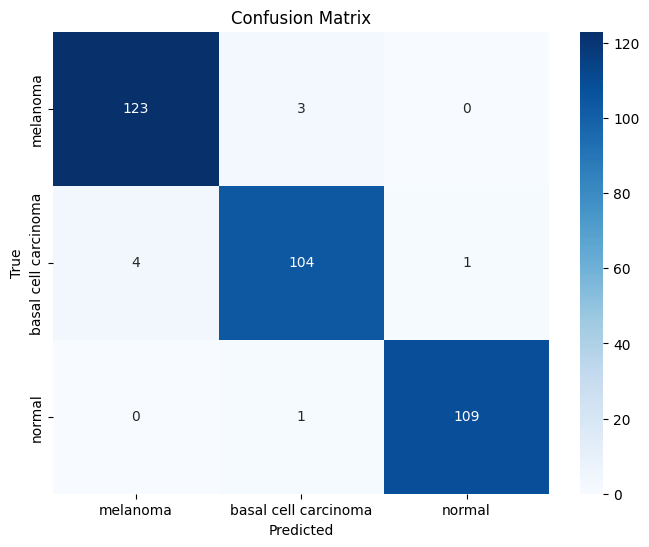

In [74]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_dnn_1)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [76]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

stacked_model_cnn_dnn_2 = fit_stacked_model(paired_models[1], X_test, y_test_1d)
y_pred_cnn_dnn_2 = stacked_prediction(paired_models[1], stacked_model_cnn_dnn_2, X_test)

# Hitung matriks kebingungan
conf_matrix_2 = confusion_matrix(y_test_1d, y_pred_cnn_dnn_2)
accuracy_2 = accuracy_score(y_test_1d, y_pred_cnn_dnn_2)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_2[0, 0]
false_positive = conf_matrix_2[0, 1]
false_negative = conf_matrix_2[1, 0]
true_positive = conf_matrix_2[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_2 = classification_report(y_test_1d, y_pred_cnn_dnn_2, output_dict=True)
precision = classification_report_2['weighted avg']['precision']
recall = classification_report_2['weighted avg']['recall']
f1 = classification_report_2['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_2}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_dnn_2))

Stacked Model Metrics:
Accuracy: 0.9652173913043478
Precision: 0.965193132610513
Recall: 0.9652173913043478
F1 Score: 0.9651675434265597
Sensitivity: 0.9626168224299065
Specificity: 0.976
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       126
           1       0.96      0.94      0.95       109
           2       0.97      0.98      0.98       110

    accuracy                           0.97       345
   macro avg       0.97      0.97      0.97       345
weighted avg       0.97      0.97      0.97       345



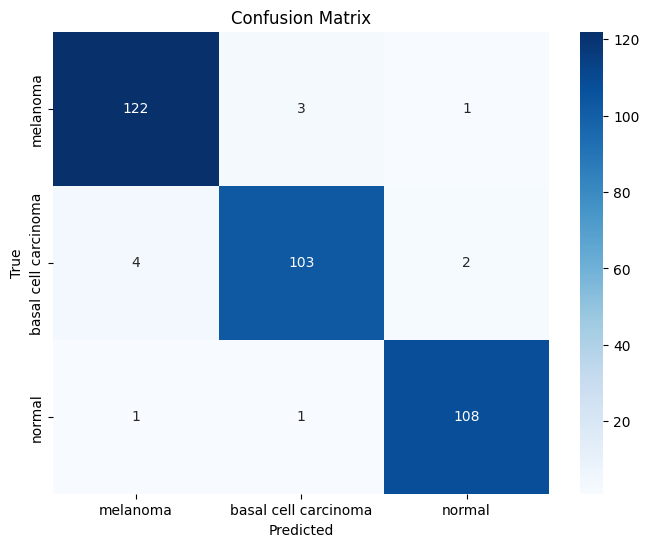

In [77]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_dnn_2)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [78]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

stacked_model_cnn_dnn_3 = fit_stacked_model(paired_models[2], X_test, y_test_1d)
y_pred_cnn_dnn_3 = stacked_prediction(paired_models[2], stacked_model_cnn_dnn_3, X_test)

# Hitung matriks kebingungan
conf_matrix_3 = confusion_matrix(y_test_1d, y_pred_cnn_dnn_3)
accuracy_3 = accuracy_score(y_test_1d, y_pred_cnn_dnn_3)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_3[0, 0]
false_positive = conf_matrix_3[0, 1]
false_negative = conf_matrix_3[1, 0]
true_positive = conf_matrix_3[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
precision = precision_score(y_test_1d, y_pred_cnn_dnn_3, average='weighted')
recall = recall_score(y_test_1d, y_pred_cnn_dnn_3, average='weighted')
f1 = f1_score(y_test_1d, y_pred_cnn_dnn_3, average='weighted')

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_3}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_dnn_3))

Stacked Model Metrics:
Accuracy: 0.9623188405797102
Precision: 0.9623407811010355
Recall: 0.9623188405797102
F1 Score: 0.9622432988692411
Sensitivity: 0.9532710280373832
Specificity: 0.976
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       126
           1       0.96      0.94      0.95       109
           2       0.97      0.98      0.98       110

    accuracy                           0.96       345
   macro avg       0.96      0.96      0.96       345
weighted avg       0.96      0.96      0.96       345



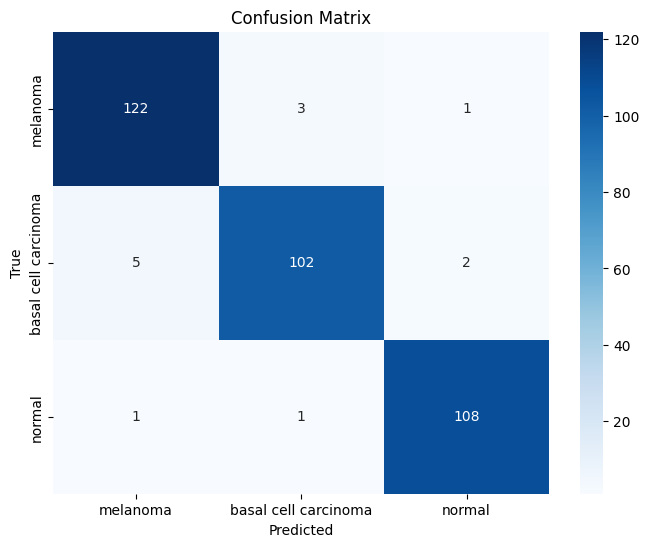

In [79]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_dnn_3)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [80]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

stacked_model_cnn_dnn_4 = fit_stacked_model(paired_models[3], X_test, y_test_1d)
y_pred_cnn_dnn_4 = stacked_prediction(paired_models[3], stacked_model_cnn_dnn_4, X_test)

# Hitung matriks kebingungan
conf_matrix_4 = confusion_matrix(y_test_1d, y_pred_cnn_dnn_4)
accuracy_4 = accuracy_score(y_test_1d, y_pred_cnn_dnn_4)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_4[0, 0]
false_positive = conf_matrix_4[0, 1]
false_negative = conf_matrix_4[1, 0]
true_positive = conf_matrix_4[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
precision = precision_score(y_test_1d, y_pred_cnn_dnn_4, average='weighted')
recall = recall_score(y_test_1d, y_pred_cnn_dnn_4, average='weighted')
f1 = f1_score(y_test_1d, y_pred_cnn_dnn_4, average='weighted')

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_4}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_dnn_4))

Stacked Model Metrics:
Accuracy: 0.9594202898550724
Precision: 0.9593646758770724
Recall: 0.9594202898550724
F1 Score: 0.9593550602668806
Sensitivity: 0.9532710280373832
Specificity: 0.968
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       126
           1       0.95      0.94      0.94       109
           2       0.97      0.98      0.98       110

    accuracy                           0.96       345
   macro avg       0.96      0.96      0.96       345
weighted avg       0.96      0.96      0.96       345



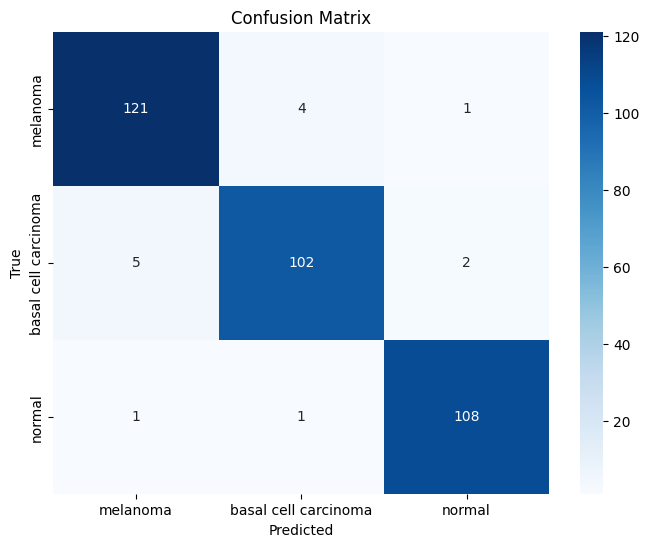

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_dnn_4)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [82]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

stacked_model_cnn_dnn_5 = fit_stacked_model(paired_models[4], X_test, y_test_1d)
y_pred_cnn_dnn_5 = stacked_prediction(paired_models[4], stacked_model_cnn_dnn_5, X_test)

# Hitung matriks kebingungan
conf_matrix_5 = confusion_matrix(y_test_1d, y_pred_cnn_dnn_5)
accuracy_5 = accuracy_score(y_test_1d, y_pred_cnn_dnn_5)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_5[0, 0]
false_positive = conf_matrix_5[0, 1]
false_negative = conf_matrix_5[1, 0]
true_positive = conf_matrix_5[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
precision = precision_score(y_test_1d, y_pred_cnn_dnn_5, average='weighted')
recall = recall_score(y_test_1d, y_pred_cnn_dnn_5, average='weighted')
f1 = f1_score(y_test_1d, y_pred_cnn_dnn_5, average='weighted')

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_5}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_dnn_5))

Stacked Model Metrics:
Accuracy: 0.9594202898550724
Precision: 0.9593646758770724
Recall: 0.9594202898550724
F1 Score: 0.9593550602668806
Sensitivity: 0.9532710280373832
Specificity: 0.968
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       126
           1       0.95      0.94      0.94       109
           2       0.97      0.98      0.98       110

    accuracy                           0.96       345
   macro avg       0.96      0.96      0.96       345
weighted avg       0.96      0.96      0.96       345



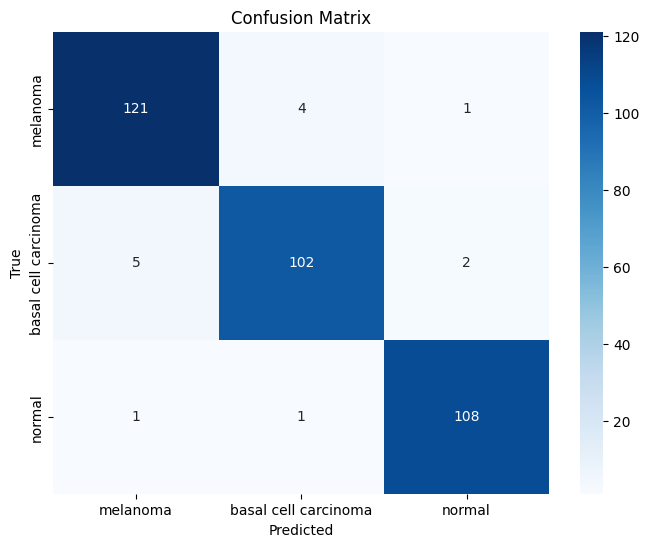

In [83]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_dnn_5)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# CNN LSTM Stacking Tuning

## Data Train

In [97]:
# Panggil fungsi untuk meload model CNN dan DNN 1 hingga 5
# Panggil fungsi untuk meload model CNN dan DNN 1 hingga 5
models_cnn_tuning_fold = [1, 2, 3, 4, 5]
members_cnn_tuning_fold = load_selected_models("models_cnn_tuning", "model_cnn_tuning")
print('Loaded %d CNN Tuning models' % len(members_cnn_tuning_fold))

models_lstm_tuning_fold = [1, 2, 3, 4, 5]
members_lstm_tuning_fold = load_selected_models("models_lstm_tuning", "model_lstm_tuning")
print('Loaded %d LSTM Tuning models' % len(members_lstm_tuning_fold))


# Membuat pasangan model CNN dan DNN untuk setiap fold
paired_cnn_lstm_tuning_models = []
for cnn_model, lstm_model in zip(members_cnn_tuning_fold, members_lstm_tuning_fold):
    paired_cnn_lstm_tuning_models.append((cnn_model, lstm_model))

# Misalnya untuk fold pertama
cnn_model_fold_1, lstm_model_fold_1 = paired_cnn_lstm_tuning_models[0]
cnn_model_fold_2, lstm_model_fold_2 = paired_cnn_lstm_tuning_models[1]
cnn_model_fold_3, lstm_model_fold_3 = paired_cnn_lstm_tuning_models[2]
cnn_model_fold_4, lstm_model_fold_4 = paired_cnn_lstm_tuning_models[3]
cnn_model_fold_5, lstm_model_fold_5 = paired_cnn_lstm_tuning_models[4]

> Loaded models_cnn_tuning\model_cnn_tuning_fold_1.h5 and models_cnn_tuning\model_cnn_tuning_fold_1.h5
> Loaded models_cnn_tuning\model_cnn_tuning_fold_2.h5 and models_cnn_tuning\model_cnn_tuning_fold_2.h5


> Loaded models_cnn_tuning\model_cnn_tuning_fold_3.h5 and models_cnn_tuning\model_cnn_tuning_fold_3.h5
> Loaded models_cnn_tuning\model_cnn_tuning_fold_4.h5 and models_cnn_tuning\model_cnn_tuning_fold_4.h5


> Loaded models_cnn_tuning\model_cnn_tuning_fold_5.h5 and models_cnn_tuning\model_cnn_tuning_fold_5.h5
Loaded 5 CNN Tuning models


> Loaded models_lstm_tuning\model_lstm_tuning_fold_1.h5 and models_lstm_tuning\model_lstm_tuning_fold_1.h5


> Loaded models_lstm_tuning\model_lstm_tuning_fold_2.h5 and models_lstm_tuning\model_lstm_tuning_fold_2.h5


> Loaded models_lstm_tuning\model_lstm_tuning_fold_3.h5 and models_lstm_tuning\model_lstm_tuning_fold_3.h5


> Loaded models_lstm_tuning\model_lstm_tuning_fold_4.h5 and models_lstm_tuning\model_lstm_tuning_fold_4.h5
> Loaded models_lstm_tuning\model_lstm_tuning_fold_5.h5 and models_lstm_tuning\model_lstm_tuning_fold_5.h5
Loaded 5 LSTM Tuning models


In [98]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_lstm_tuning_1 = fit_stacked_model(paired_cnn_lstm_tuning_models[0], X_train, y_train_1d)
y_pred_cnn_lstm_tuning_1 = stacked_prediction(paired_cnn_lstm_tuning_models[0], stacked_model_cnn_lstm_tuning_1, X_train)

# Hitung matriks kebingungan
conf_matrix_1 = confusion_matrix(y_train_1d, y_pred_cnn_lstm_tuning_1)
accuracy_1 = accuracy_score(y_train_1d, y_pred_cnn_lstm_tuning_1)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_1[0, 0]
false_positive = conf_matrix_1[0, 1]
false_negative = conf_matrix_1[1, 0]
true_positive = conf_matrix_1[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_1 = classification_report(y_train_1d, y_pred_cnn_lstm_tuning_1, output_dict=True)
precision = classification_report_1['weighted avg']['precision']
recall = classification_report_1['weighted avg']['recall']
f1 = classification_report_1['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_lstm_tuning_1))

Stacked Model Metrics:
Accuracy: 0.9608695652173913
Precision: 0.9608910794265485
Recall: 0.9608695652173913
F1 Score: 0.9608208858994107
Sensitivity: 0.9416846652267818
Specificity: 0.9596412556053812
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       449
           1       0.96      0.94      0.95       466
           2       0.99      0.99      0.99       465

    accuracy                           0.96      1380
   macro avg       0.96      0.96      0.96      1380
weighted avg       0.96      0.96      0.96      1380



In [99]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_lstm_tuning_2 = fit_stacked_model(paired_cnn_lstm_tuning_models[1], X_train, y_train_1d)
y_pred_cnn_lstm_tuning_2 = stacked_prediction(paired_cnn_lstm_tuning_models[1], stacked_model_cnn_lstm_tuning_2, X_train)

# Hitung matriks kebingungan
conf_matrix_2 = confusion_matrix(y_train_1d, y_pred_cnn_lstm_tuning_2)
accuracy_2 = accuracy_score(y_train_1d, y_pred_cnn_lstm_tuning_2)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_2[0, 0]
false_positive = conf_matrix_2[0, 1]
false_negative = conf_matrix_2[1, 0]
true_positive = conf_matrix_2[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_2 = classification_report(y_train_1d, y_pred_cnn_lstm_tuning_2, output_dict=True)
precision = classification_report_2['weighted avg']['precision']
recall = classification_report_2['weighted avg']['recall']
f1 = classification_report_2['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_2}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_lstm_tuning_2))

Stacked Model Metrics:
Accuracy: 0.9579710144927536
Precision: 0.9587721247070328
Recall: 0.9579710144927536
F1 Score: 0.9578774036610713
Sensitivity: 0.91792656587473
Specificity: 0.9753363228699552
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       449
           1       0.97      0.91      0.94       466
           2       0.99      0.99      0.99       465

    accuracy                           0.96      1380
   macro avg       0.96      0.96      0.96      1380
weighted avg       0.96      0.96      0.96      1380



In [100]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_lstm_tuning_3 = fit_stacked_model(paired_cnn_lstm_tuning_models[2], X_train, y_train_1d)
y_pred_cnn_lstm_tuning_3 = stacked_prediction(paired_cnn_lstm_tuning_models[2], stacked_model_cnn_lstm_tuning_3, X_train)

# Hitung matriks kebingungan
conf_matrix_3 = confusion_matrix(y_train_1d, y_pred_cnn_lstm_tuning_3)
accuracy_3 = accuracy_score(y_train_1d, y_pred_cnn_lstm_tuning_3)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_3[0, 0]
false_positive = conf_matrix_3[0, 1]
false_negative = conf_matrix_3[1, 0]
true_positive = conf_matrix_3[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_3 = classification_report(y_train_1d, y_pred_cnn_lstm_tuning_3, output_dict=True)
precision = classification_report_3['weighted avg']['precision']
recall = classification_report_3['weighted avg']['recall']
f1 = classification_report_3['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_3}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_lstm_tuning_3))

Stacked Model Metrics:
Accuracy: 0.9746376811594203
Precision: 0.9749947758421674
Recall: 0.9746376811594203
F1 Score: 0.9746553511283264
Sensitivity: 0.9526881720430107
Specificity: 0.9821428571428571
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       449
           1       0.98      0.95      0.97       466
           2       1.00      0.99      0.99       465

    accuracy                           0.97      1380
   macro avg       0.97      0.97      0.97      1380
weighted avg       0.97      0.97      0.97      1380



In [101]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_lstm_tuning_4 = fit_stacked_model(paired_cnn_lstm_tuning_models[3], X_train, y_train_1d)
y_pred_cnn_lstm_tuning_4 = stacked_prediction(paired_cnn_lstm_tuning_models[3], stacked_model_cnn_lstm_tuning_4, X_train)

# Hitung matriks kebingungan
conf_matrix_4 = confusion_matrix(y_train_1d, y_pred_cnn_lstm_tuning_4)
accuracy_4 = accuracy_score(y_train_1d, y_pred_cnn_lstm_tuning_4)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_4[0, 0]
false_positive = conf_matrix_4[0, 1]
false_negative = conf_matrix_4[1, 0]
true_positive = conf_matrix_4[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_4 = classification_report(y_train_1d, y_pred_cnn_lstm_tuning_4, output_dict=True)
precision = classification_report_4['weighted avg']['precision']
recall = classification_report_4['weighted avg']['recall']
f1 = classification_report_4['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_4}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_lstm_tuning_4))

Stacked Model Metrics:
Accuracy: 0.9601449275362319
Precision: 0.9614920559600838
Recall: 0.9601449275362319
F1 Score: 0.9601907425711923
Sensitivity: 0.9141630901287554
Specificity: 0.9754464285714286
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       449
           1       0.97      0.91      0.94       466
           2       1.00      0.99      1.00       465

    accuracy                           0.96      1380
   macro avg       0.96      0.96      0.96      1380
weighted avg       0.96      0.96      0.96      1380



In [102]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_lstm_tuning_5 = fit_stacked_model(paired_cnn_lstm_tuning_models[4], X_train, y_train_1d)
y_pred_cnn_lstm_tuning_5 = stacked_prediction(paired_cnn_lstm_tuning_models[4], stacked_model_cnn_lstm_tuning_5, X_train)

# Hitung matriks kebingungan
conf_matrix_5 = confusion_matrix(y_train_1d, y_pred_cnn_lstm_tuning_5)
accuracy_5 = accuracy_score(y_train_1d, y_pred_cnn_lstm_tuning_5)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_5[0, 0]
false_positive = conf_matrix_5[0, 1]
false_negative = conf_matrix_5[1, 0]
true_positive = conf_matrix_5[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_5 = classification_report(y_train_1d, y_pred_cnn_lstm_tuning_5, output_dict=True)
precision = classification_report_5['weighted avg']['precision']
recall = classification_report_5['weighted avg']['recall']
f1 = classification_report_5['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_5}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_lstm_tuning_5))

Stacked Model Metrics:
Accuracy: 0.9507246376811594
Precision: 0.951906113404103
Recall: 0.9507246376811594
F1 Score: 0.9507152024785774
Sensitivity: 0.9073275862068966
Specificity: 0.9730337078651685
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       449
           1       0.96      0.90      0.93       466
           2       0.99      0.98      0.99       465

    accuracy                           0.95      1380
   macro avg       0.95      0.95      0.95      1380
weighted avg       0.95      0.95      0.95      1380



## Data Test

In [115]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_lstm_tuning_1 = fit_stacked_model(paired_cnn_lstm_tuning_models[0], X_test, y_test_1d)
y_pred_cnn_lstm_tuning_1 = stacked_prediction(paired_cnn_lstm_tuning_models[0], stacked_model_cnn_lstm_tuning_1, X_test)

# Hitung matriks kebingungan
conf_matrix_1 = confusion_matrix(y_test_1d, y_pred_cnn_lstm_tuning_1)
accuracy_1 = accuracy_score(y_test_1d, y_pred_cnn_lstm_tuning_1)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_1[0, 0]
false_positive = conf_matrix_1[0, 1]
false_negative = conf_matrix_1[1, 0]
true_positive = conf_matrix_1[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_1 = classification_report(y_test_1d, y_pred_cnn_lstm_tuning_1, output_dict=True)
precision = classification_report_1['weighted avg']['precision']
recall = classification_report_1['weighted avg']['recall']
f1 = classification_report_1['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_lstm_tuning_1))

Stacked Model Metrics:
Accuracy: 0.9797101449275363
Precision: 0.979655742699221
Recall: 0.9797101449275363
F1 Score: 0.9796699519164662
Sensitivity: 0.9722222222222222
Specificity: 0.9761904761904762
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       126
           1       0.97      0.96      0.97       109
           2       0.99      1.00      1.00       110

    accuracy                           0.98       345
   macro avg       0.98      0.98      0.98       345
weighted avg       0.98      0.98      0.98       345



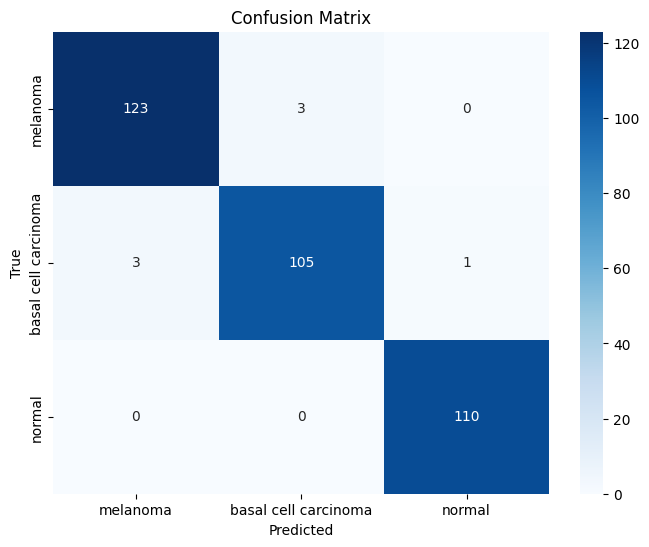

In [120]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_lstm_tuning_1)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [116]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_lstm_tuning_2 = fit_stacked_model(paired_cnn_lstm_tuning_models[1], X_test, y_test_1d)
y_pred_cnn_lstm_tuning_2 = stacked_prediction(paired_cnn_lstm_tuning_models[1], stacked_model_cnn_lstm_tuning_2, X_test)

# Hitung matriks kebingungan
conf_matrix_2 = confusion_matrix(y_test_1d, y_pred_cnn_lstm_tuning_2)
accuracy_2 = accuracy_score(y_test_1d, y_pred_cnn_lstm_tuning_2)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_2[0, 0]
false_positive = conf_matrix_2[0, 1]
false_negative = conf_matrix_2[1, 0]
true_positive = conf_matrix_2[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_2 = classification_report(y_test_1d, y_pred_cnn_lstm_tuning_2, output_dict=True)
precision = classification_report_2['weighted avg']['precision']
recall = classification_report_2['weighted avg']['recall']
f1 = classification_report_2['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_2}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_lstm_tuning_2))

Stacked Model Metrics:
Accuracy: 0.9710144927536232
Precision: 0.9711056383096106
Recall: 0.9710144927536232
F1 Score: 0.9708955923621226
Sensitivity: 0.9716981132075472
Specificity: 0.976
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       126
           1       0.97      0.94      0.96       109
           2       0.96      1.00      0.98       110

    accuracy                           0.97       345
   macro avg       0.97      0.97      0.97       345
weighted avg       0.97      0.97      0.97       345



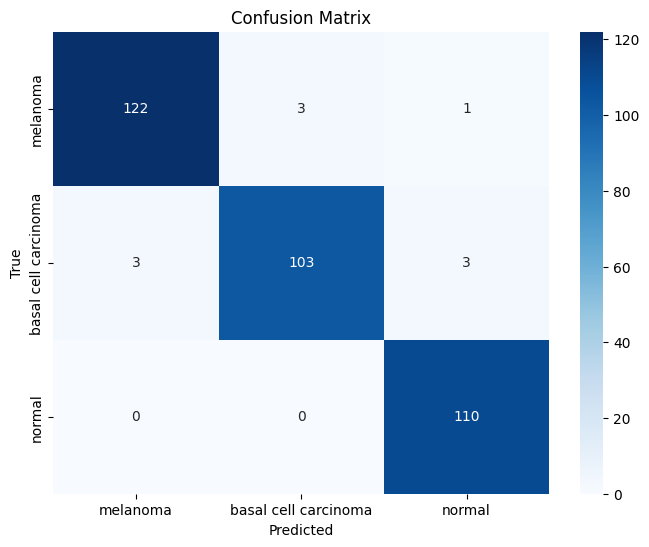

In [121]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_lstm_tuning_2)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [117]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_lstm_tuning_3 = fit_stacked_model(paired_cnn_lstm_tuning_models[2], X_test, y_test_1d)
y_pred_cnn_lstm_tuning_3 = stacked_prediction(paired_cnn_lstm_tuning_models[2], stacked_model_cnn_lstm_tuning_3, X_test)

# Hitung matriks kebingungan
conf_matrix_3 = confusion_matrix(y_test_1d, y_pred_cnn_lstm_tuning_3)
accuracy_3 = accuracy_score(y_test_1d, y_pred_cnn_lstm_tuning_3)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_3[0, 0]
false_positive = conf_matrix_3[0, 1]
false_negative = conf_matrix_3[1, 0]
true_positive = conf_matrix_3[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_3 = classification_report(y_test_1d, y_pred_cnn_lstm_tuning_3, output_dict=True)
precision = classification_report_3['weighted avg']['precision']
recall = classification_report_3['weighted avg']['recall']
f1 = classification_report_3['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_3}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_lstm_tuning_3))

Stacked Model Metrics:
Accuracy: 0.9739130434782609
Precision: 0.9738540275923453
Recall: 0.9739130434782609
F1 Score: 0.9738318028173101
Sensitivity: 0.9629629629629629
Specificity: 0.976
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       126
           1       0.97      0.95      0.96       109
           2       0.98      1.00      0.99       110

    accuracy                           0.97       345
   macro avg       0.97      0.97      0.97       345
weighted avg       0.97      0.97      0.97       345



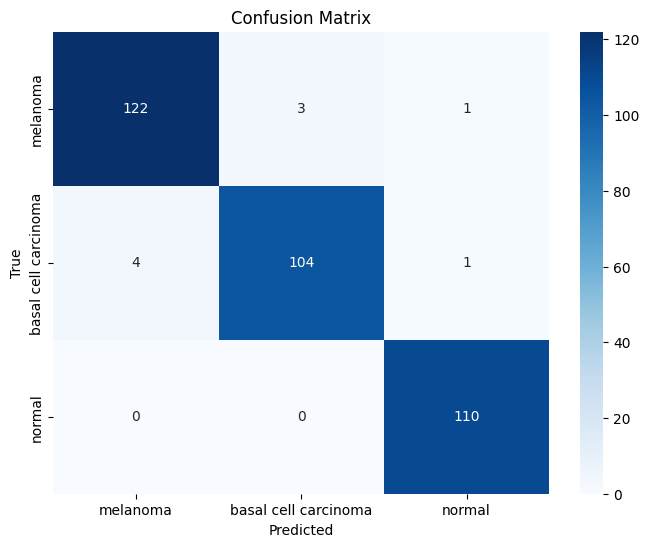

In [122]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_lstm_tuning_3)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [118]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_lstm_tuning_4 = fit_stacked_model(paired_cnn_lstm_tuning_models[3], X_test, y_test_1d)
y_pred_cnn_lstm_tuning_4 = stacked_prediction(paired_cnn_lstm_tuning_models[3], stacked_model_cnn_lstm_tuning_4, X_test)

# Hitung matriks kebingungan
conf_matrix_4 = confusion_matrix(y_test_1d, y_pred_cnn_lstm_tuning_4)
accuracy_4 = accuracy_score(y_test_1d, y_pred_cnn_lstm_tuning_4)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_4[0, 0]
false_positive = conf_matrix_4[0, 1]
false_negative = conf_matrix_4[1, 0]
true_positive = conf_matrix_4[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_4 = classification_report(y_test_1d, y_pred_cnn_lstm_tuning_4, output_dict=True)
precision = classification_report_4['weighted avg']['precision']
recall = classification_report_4['weighted avg']['recall']
f1 = classification_report_4['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_4}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_lstm_tuning_4))

Stacked Model Metrics:
Accuracy: 0.9623188405797102
Precision: 0.9627010670488931
Recall: 0.9623188405797102
F1 Score: 0.9623196871190574
Sensitivity: 0.9444444444444444
Specificity: 0.976
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       126
           1       0.97      0.94      0.95       109
           2       0.98      0.98      0.98       110

    accuracy                           0.96       345
   macro avg       0.96      0.96      0.96       345
weighted avg       0.96      0.96      0.96       345



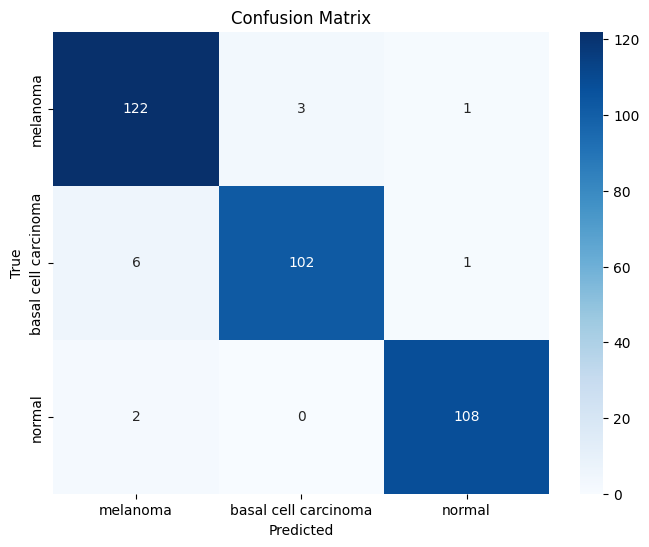

In [123]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_lstm_tuning_4)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [119]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_lstm_tuning_5 = fit_stacked_model(paired_cnn_lstm_tuning_models[4], X_test, y_test_1d)
y_pred_cnn_lstm_tuning_5 = stacked_prediction(paired_cnn_lstm_tuning_models[4], stacked_model_cnn_lstm_tuning_5, X_test)

# Hitung matriks kebingungan
conf_matrix_5 = confusion_matrix(y_test_1d, y_pred_cnn_lstm_tuning_5)
accuracy_5 = accuracy_score(y_test_1d, y_pred_cnn_lstm_tuning_5)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_5[0, 0]
false_positive = conf_matrix_5[0, 1]
false_negative = conf_matrix_5[1, 0]
true_positive = conf_matrix_5[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_5 = classification_report(y_test_1d, y_pred_cnn_lstm_tuning_5, output_dict=True)
precision = classification_report_5['weighted avg']['precision']
recall = classification_report_5['weighted avg']['recall']
f1 = classification_report_5['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_5}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_lstm_tuning_5))

Stacked Model Metrics:
Accuracy: 0.9710144927536232
Precision: 0.9711930932508557
Recall: 0.9710144927536232
F1 Score: 0.9708580916880363
Sensitivity: 0.9532710280373832
Specificity: 0.984
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       126
           1       0.98      0.94      0.96       109
           2       0.97      1.00      0.99       110

    accuracy                           0.97       345
   macro avg       0.97      0.97      0.97       345
weighted avg       0.97      0.97      0.97       345



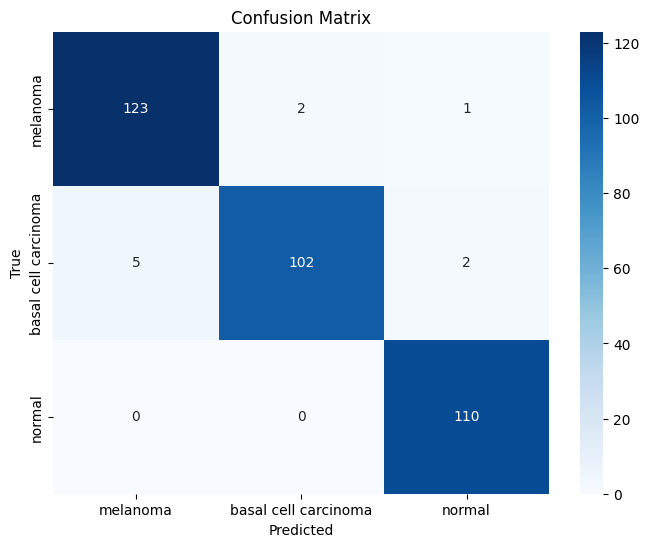

In [124]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_lstm_tuning_5)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# CNN RNN Stacking Tuning

## Data Training

In [84]:
# Panggil fungsi untuk meload model CNN dan DNN 1 hingga 5
# Panggil fungsi untuk meload model CNN dan DNN 1 hingga 5
models_cnn_tuning_fold = [1, 2, 3, 4, 5]
members_cnn_tuning_fold = load_selected_models("models_cnn_tuning", "model_cnn_tuning")
print('Loaded %d CNN Tuning models' % len(members_cnn_tuning_fold))

models_rnn_tuning_fold = [1, 2, 3, 4, 5]
members_rnn_tuning_fold = load_selected_models("models_rnn_tuning", "model_rnn_tuning")
print('Loaded %d RNN Tuning models' % len(members_rnn_tuning_fold))


# Membuat pasangan model CNN dan DNN untuk setiap fold
paired_cnn_rnn_tuning_models = []
for cnn_model, rnn_model in zip(members_cnn_tuning_fold, members_rnn_tuning_fold):
    paired_cnn_rnn_tuning_models.append((cnn_model, rnn_model))

# Misalnya untuk fold pertama
cnn_model_fold_1, rnn_model_fold_1 = paired_cnn_rnn_tuning_models[0]
cnn_model_fold_2, rnn_model_fold_2 = paired_cnn_rnn_tuning_models[1]
cnn_model_fold_3, rnn_model_fold_3 = paired_cnn_rnn_tuning_models[2]
cnn_model_fold_4, rnn_model_fold_4 = paired_cnn_rnn_tuning_models[3]
cnn_model_fold_5, rnn_model_fold_5 = paired_cnn_rnn_tuning_models[4]


> Loaded models_cnn_tuning\model_cnn_tuning_fold_1.h5 and models_cnn_tuning\model_cnn_tuning_fold_1.h5
> Loaded models_cnn_tuning\model_cnn_tuning_fold_2.h5 and models_cnn_tuning\model_cnn_tuning_fold_2.h5


> Loaded models_cnn_tuning\model_cnn_tuning_fold_3.h5 and models_cnn_tuning\model_cnn_tuning_fold_3.h5
> Loaded models_cnn_tuning\model_cnn_tuning_fold_4.h5 and models_cnn_tuning\model_cnn_tuning_fold_4.h5


> Loaded models_cnn_tuning\model_cnn_tuning_fold_5.h5 and models_cnn_tuning\model_cnn_tuning_fold_5.h5
Loaded 5 CNN Tuning models
> Loaded models_rnn_tuning\model_rnn_tuning_fold_1.h5 and models_rnn_tuning\model_rnn_tuning_fold_1.h5


> Loaded models_rnn_tuning\model_rnn_tuning_fold_2.h5 and models_rnn_tuning\model_rnn_tuning_fold_2.h5
> Loaded models_rnn_tuning\model_rnn_tuning_fold_3.h5 and models_rnn_tuning\model_rnn_tuning_fold_3.h5


> Loaded models_rnn_tuning\model_rnn_tuning_fold_4.h5 and models_rnn_tuning\model_rnn_tuning_fold_4.h5
> Loaded models_rnn_tuning\model_rnn_tuning_fold_5.h5 and models_rnn_tuning\model_rnn_tuning_fold_5.h5
Loaded 5 RNN Tuning models


In [104]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_rnn_tuning_1 = fit_stacked_model(paired_cnn_rnn_tuning_models[0], X_train, y_train_1d)
y_pred_cnn_rnn_tuning_1 = stacked_prediction(paired_cnn_rnn_tuning_models[0], stacked_model_cnn_rnn_tuning_1, X_train)

# Hitung matriks kebingungan
conf_matrix_1 = confusion_matrix(y_train_1d, y_pred_cnn_rnn_tuning_1)
accuracy_1 = accuracy_score(y_train_1d, y_pred_cnn_rnn_tuning_1)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_1[0, 0]
false_positive = conf_matrix_1[0, 1]
false_negative = conf_matrix_1[1, 0]
true_positive = conf_matrix_1[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_1 = classification_report(y_train_1d, y_pred_cnn_rnn_tuning_1, output_dict=True)
precision = classification_report_1['weighted avg']['precision']
recall = classification_report_1['weighted avg']['recall']
f1 = classification_report_1['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_rnn_tuning_1))

Stacked Model Metrics:
Accuracy: 0.9615942028985507
Precision: 0.9622388481816024
Recall: 0.9615942028985507
F1 Score: 0.9614939151160955
Sensitivity: 0.928416485900217
Specificity: 0.9754464285714286
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       449
           1       0.97      0.92      0.94       466
           2       0.99      0.99      0.99       465

    accuracy                           0.96      1380
   macro avg       0.96      0.96      0.96      1380
weighted avg       0.96      0.96      0.96      1380



In [105]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_rnn_tuning_2 = fit_stacked_model(paired_cnn_rnn_tuning_models[1], X_train, y_train_1d)
y_pred_cnn_rnn_tuning_2 = stacked_prediction(paired_cnn_rnn_tuning_models[1], stacked_model_cnn_rnn_tuning_2, X_train)

# Hitung matriks kebingungan
conf_matrix_2 = confusion_matrix(y_train_1d, y_pred_cnn_rnn_tuning_2)
accuracy_2 = accuracy_score(y_train_1d, y_pred_cnn_rnn_tuning_2)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_2[0, 0]
false_positive = conf_matrix_2[0, 1]
false_negative = conf_matrix_2[1, 0]
true_positive = conf_matrix_2[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_2 = classification_report(y_train_1d, y_pred_cnn_rnn_tuning_2, output_dict=True)
precision = classification_report_2['weighted avg']['precision']
recall = classification_report_2['weighted avg']['recall']
f1 = classification_report_2['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_2}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_rnn_tuning_2))

Stacked Model Metrics:
Accuracy: 0.9601449275362319
Precision: 0.9605773121640523
Recall: 0.9601449275362319
F1 Score: 0.9601449275362319
Sensitivity: 0.9310344827586207
Specificity: 0.9664429530201343
              precision    recall  f1-score   support

           0       0.93      0.96      0.94       449
           1       0.96      0.93      0.94       466
           2       0.99      0.99      0.99       465

    accuracy                           0.96      1380
   macro avg       0.96      0.96      0.96      1380
weighted avg       0.96      0.96      0.96      1380



In [106]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_rnn_tuning_3 = fit_stacked_model(paired_cnn_rnn_tuning_models[2], X_train, y_train_1d)
y_pred_cnn_rnn_tuning_3 = stacked_prediction(paired_cnn_rnn_tuning_models[2], stacked_model_cnn_rnn_tuning_3, X_train)

# Hitung matriks kebingungan
conf_matrix_3 = confusion_matrix(y_train_1d, y_pred_cnn_rnn_tuning_3)
accuracy_3 = accuracy_score(y_train_1d, y_pred_cnn_rnn_tuning_3)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_3[0, 0]
false_positive = conf_matrix_3[0, 1]
false_negative = conf_matrix_3[1, 0]
true_positive = conf_matrix_3[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_3 = classification_report(y_train_1d, y_pred_cnn_rnn_tuning_3, output_dict=True)
precision = classification_report_3['weighted avg']['precision']
recall = classification_report_3['weighted avg']['recall']
f1 = classification_report_3['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_3}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_rnn_tuning_3))

Stacked Model Metrics:
Accuracy: 0.9753623188405797
Precision: 0.9755393438410631
Recall: 0.9753623188405797
F1 Score: 0.9753489553545955
Sensitivity: 0.9568965517241379
Specificity: 0.9799107142857143
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       449
           1       0.98      0.95      0.97       466
           2       0.99      1.00      0.99       465

    accuracy                           0.98      1380
   macro avg       0.98      0.98      0.98      1380
weighted avg       0.98      0.98      0.98      1380



In [107]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_rnn_tuning_4 = fit_stacked_model(paired_cnn_rnn_tuning_models[3], X_train, y_train_1d)
y_pred_cnn_rnn_tuning_4 = stacked_prediction(paired_cnn_rnn_tuning_models[3], stacked_model_cnn_rnn_tuning_4, X_train)

# Hitung matriks kebingungan
conf_matrix_4 = confusion_matrix(y_train_1d, y_pred_cnn_rnn_tuning_4)
accuracy_4 = accuracy_score(y_train_1d, y_pred_cnn_rnn_tuning_4)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_4[0, 0]
false_positive = conf_matrix_4[0, 1]
false_negative = conf_matrix_4[1, 0]
true_positive = conf_matrix_4[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_4 = classification_report(y_train_1d, y_pred_cnn_rnn_tuning_4, output_dict=True)
precision = classification_report_4['weighted avg']['precision']
recall = classification_report_4['weighted avg']['recall']
f1 = classification_report_4['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_4}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_rnn_tuning_4))

Stacked Model Metrics:
Accuracy: 0.9557971014492753
Precision: 0.9571849491920706
Recall: 0.9557971014492753
F1 Score: 0.9557756851220555
Sensitivity: 0.9094827586206896
Specificity: 0.9753914988814317
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       449
           1       0.97      0.91      0.94       466
           2       0.99      0.99      0.99       465

    accuracy                           0.96      1380
   macro avg       0.96      0.96      0.96      1380
weighted avg       0.96      0.96      0.96      1380



In [108]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_rnn_tuning_5 = fit_stacked_model(paired_cnn_rnn_tuning_models[4], X_train, y_train_1d)
y_pred_cnn_rnn_tuning_5 = stacked_prediction(paired_cnn_rnn_tuning_models[4], stacked_model_cnn_rnn_tuning_5, X_train)

# Hitung matriks kebingungan
conf_matrix_5 = confusion_matrix(y_train_1d, y_pred_cnn_rnn_tuning_5)
accuracy_5 = accuracy_score(y_train_1d, y_pred_cnn_rnn_tuning_5)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_5[0, 0]
false_positive = conf_matrix_5[0, 1]
false_negative = conf_matrix_5[1, 0]
true_positive = conf_matrix_5[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_5 = classification_report(y_train_1d, y_pred_cnn_rnn_tuning_5, output_dict=True)
precision = classification_report_5['weighted avg']['precision']
recall = classification_report_5['weighted avg']['recall']
f1 = classification_report_5['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_5}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_rnn_tuning_5))

Stacked Model Metrics:
Accuracy: 0.9623188405797102
Precision: 0.9637663247761424
Recall: 0.9623188405797102
F1 Score: 0.9622731286686406
Sensitivity: 0.915948275862069
Specificity: 0.984375
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       449
           1       0.98      0.91      0.94       466
           2       0.99      0.99      0.99       465

    accuracy                           0.96      1380
   macro avg       0.96      0.96      0.96      1380
weighted avg       0.96      0.96      0.96      1380



## Data Test

In [85]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_rnn_tuning_1 = fit_stacked_model(paired_cnn_rnn_tuning_models[0], X_test, y_test_1d)
y_pred_cnn_rnn_tuning_1 = stacked_prediction(paired_cnn_rnn_tuning_models[0], stacked_model_cnn_rnn_tuning_1, X_test)

# Hitung matriks kebingungan
conf_matrix_1 = confusion_matrix(y_test_1d, y_pred_cnn_rnn_tuning_1)
accuracy_1 = accuracy_score(y_test_1d, y_pred_cnn_rnn_tuning_1)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_1[0, 0]
false_positive = conf_matrix_1[0, 1]
false_negative = conf_matrix_1[1, 0]
true_positive = conf_matrix_1[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_1 = classification_report(y_test_1d, y_pred_cnn_rnn_tuning_1, output_dict=True)
precision = classification_report_1['weighted avg']['precision']
recall = classification_report_1['weighted avg']['recall']
f1 = classification_report_1['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_rnn_tuning_1))

Stacked Model Metrics:
Accuracy: 0.9739130434782609
Precision: 0.9738540275923453
Recall: 0.9739130434782609
F1 Score: 0.9738318028173101
Sensitivity: 0.9629629629629629
Specificity: 0.976
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       126
           1       0.97      0.95      0.96       109
           2       0.98      1.00      0.99       110

    accuracy                           0.97       345
   macro avg       0.97      0.97      0.97       345
weighted avg       0.97      0.97      0.97       345



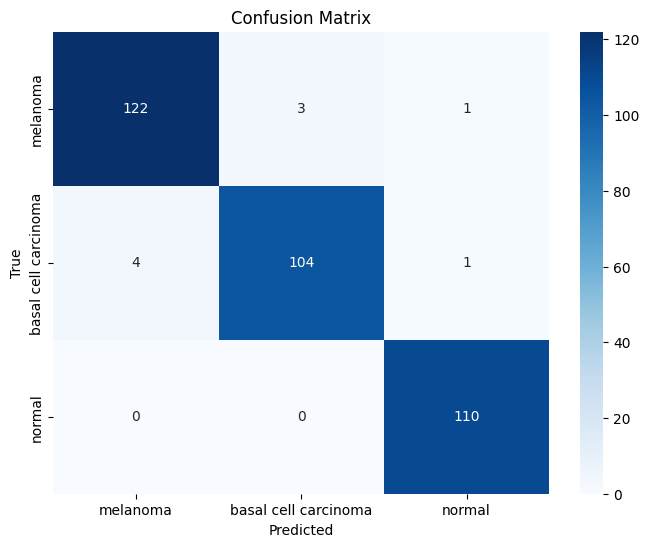

In [86]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_rnn_tuning_1)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [87]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_rnn_tuning_2 = fit_stacked_model(paired_cnn_rnn_tuning_models[1], X_test, y_test_1d)
y_pred_cnn_rnn_tuning_2 = stacked_prediction(paired_cnn_rnn_tuning_models[1], stacked_model_cnn_rnn_tuning_2, X_test)

# Hitung matriks kebingungan
conf_matrix_2 = confusion_matrix(y_test_1d, y_pred_cnn_rnn_tuning_2)
accuracy_2 = accuracy_score(y_test_1d, y_pred_cnn_rnn_tuning_2)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_2[0, 0]
false_positive = conf_matrix_2[0, 1]
false_negative = conf_matrix_2[1, 0]
true_positive = conf_matrix_2[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_2 = classification_report(y_test_1d, y_pred_cnn_rnn_tuning_2, output_dict=True)
precision = classification_report_2['weighted avg']['precision']
recall = classification_report_2['weighted avg']['recall']
f1 = classification_report_2['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_2}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_rnn_tuning_2))

Stacked Model Metrics:
Accuracy: 0.9623188405797102
Precision: 0.9622985134582482
Recall: 0.9623188405797102
F1 Score: 0.9621938785534754
Sensitivity: 0.9532710280373832
Specificity: 0.9758064516129032
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       126
           1       0.96      0.94      0.95       109
           2       0.96      0.99      0.98       110

    accuracy                           0.96       345
   macro avg       0.96      0.96      0.96       345
weighted avg       0.96      0.96      0.96       345



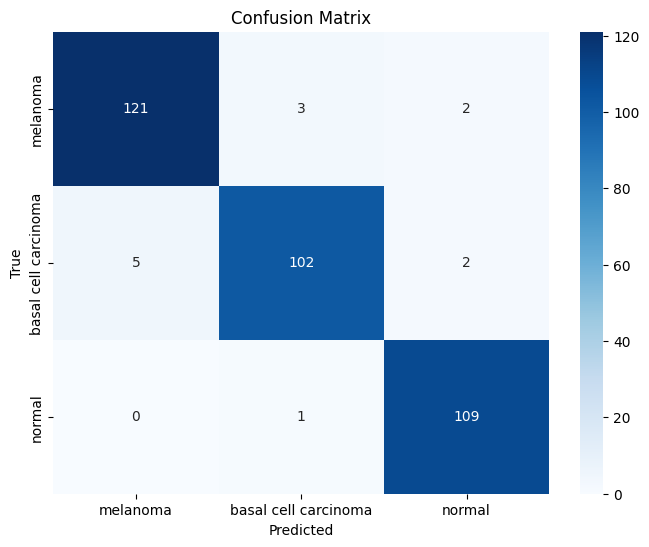

In [88]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_rnn_tuning_2)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [89]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_rnn_tuning_3 = fit_stacked_model(paired_cnn_rnn_tuning_models[2], X_test, y_test_1d)
y_pred_cnn_rnn_tuning_3 = stacked_prediction(paired_cnn_rnn_tuning_models[2], stacked_model_cnn_rnn_tuning_3, X_test)

# Hitung matriks kebingungan
conf_matrix_3 = confusion_matrix(y_test_1d, y_pred_cnn_rnn_tuning_3)
accuracy_3 = accuracy_score(y_test_1d, y_pred_cnn_rnn_tuning_3)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_3[0, 0]
false_positive = conf_matrix_3[0, 1]
false_negative = conf_matrix_3[1, 0]
true_positive = conf_matrix_3[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_3 = classification_report(y_test_1d, y_pred_cnn_rnn_tuning_3, output_dict=True)
precision = classification_report_3['weighted avg']['precision']
recall = classification_report_3['weighted avg']['recall']
f1 = classification_report_3['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_3}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_rnn_tuning_3))

Stacked Model Metrics:
Accuracy: 0.9681159420289855
Precision: 0.9684453337746561
Recall: 0.9681159420289855
F1 Score: 0.9680547907418848
Sensitivity: 0.9814814814814815
Specificity: 0.967479674796748
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       126
           1       0.95      0.97      0.96       109
           2       0.96      0.99      0.98       110

    accuracy                           0.97       345
   macro avg       0.97      0.97      0.97       345
weighted avg       0.97      0.97      0.97       345



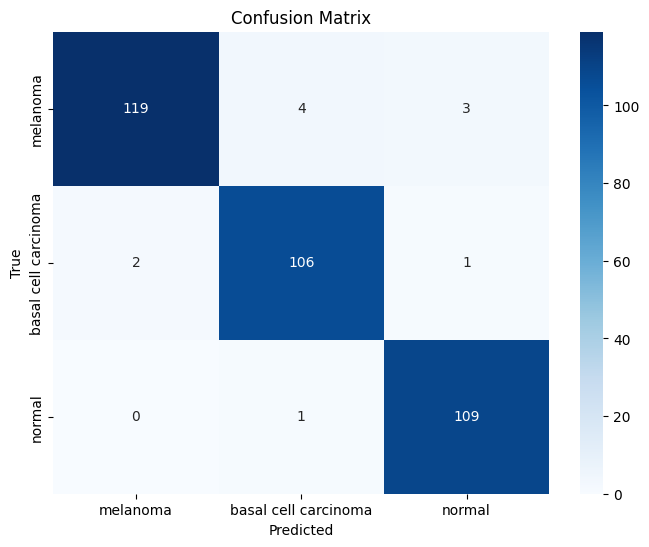

In [90]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_rnn_tuning_3)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [91]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_rnn_tuning_4 = fit_stacked_model(paired_cnn_rnn_tuning_models[3], X_test, y_test_1d)
y_pred_cnn_rnn_tuning_4 = stacked_prediction(paired_cnn_rnn_tuning_models[3], stacked_model_cnn_rnn_tuning_4, X_test)

# Hitung matriks kebingungan
conf_matrix_4 = confusion_matrix(y_test_1d, y_pred_cnn_rnn_tuning_4)
accuracy_4 = accuracy_score(y_test_1d, y_pred_cnn_rnn_tuning_4)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_4[0, 0]
false_positive = conf_matrix_4[0, 1]
false_negative = conf_matrix_4[1, 0]
true_positive = conf_matrix_4[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_4 = classification_report(y_test_1d, y_pred_cnn_rnn_tuning_4, output_dict=True)
precision = classification_report_4['weighted avg']['precision']
recall = classification_report_4['weighted avg']['recall']
f1 = classification_report_4['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_4}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_rnn_tuning_4))

Stacked Model Metrics:
Accuracy: 0.9681159420289855
Precision: 0.9681938039351903
Recall: 0.9681159420289855
F1 Score: 0.9680677295982101
Sensitivity: 0.9537037037037037
Specificity: 0.976
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       126
           1       0.97      0.94      0.96       109
           2       0.98      0.99      0.99       110

    accuracy                           0.97       345
   macro avg       0.97      0.97      0.97       345
weighted avg       0.97      0.97      0.97       345



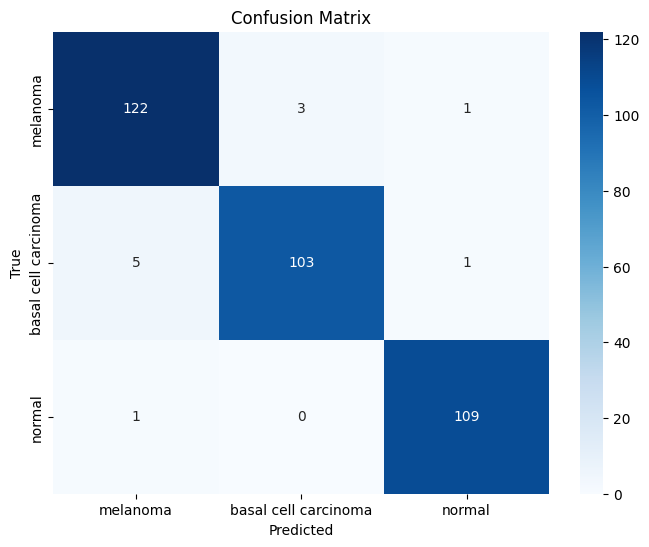

In [92]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_rnn_tuning_4)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [93]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_rnn_tuning_5 = fit_stacked_model(paired_cnn_rnn_tuning_models[4], X_test, y_test_1d)
y_pred_cnn_rnn_tuning_5 = stacked_prediction(paired_cnn_rnn_tuning_models[4], stacked_model_cnn_rnn_tuning_5, X_test)

# Hitung matriks kebingungan
conf_matrix_5 = confusion_matrix(y_test_1d, y_pred_cnn_rnn_tuning_5)
accuracy_5 = accuracy_score(y_test_1d, y_pred_cnn_rnn_tuning_5)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_5[0, 0]
false_positive = conf_matrix_5[0, 1]
false_negative = conf_matrix_5[1, 0]
true_positive = conf_matrix_5[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_5 = classification_report(y_test_1d, y_pred_cnn_rnn_tuning_5, output_dict=True)
precision = classification_report_5['weighted avg']['precision']
recall = classification_report_5['weighted avg']['recall']
f1 = classification_report_5['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_5}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_rnn_tuning_5))

Stacked Model Metrics:
Accuracy: 0.9739130434782609
Precision: 0.9739182424660686
Recall: 0.9739130434782609
F1 Score: 0.9738781007613112
Sensitivity: 0.9722222222222222
Specificity: 0.9838709677419355
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       126
           1       0.97      0.96      0.97       109
           2       0.97      0.99      0.98       110

    accuracy                           0.97       345
   macro avg       0.97      0.97      0.97       345
weighted avg       0.97      0.97      0.97       345



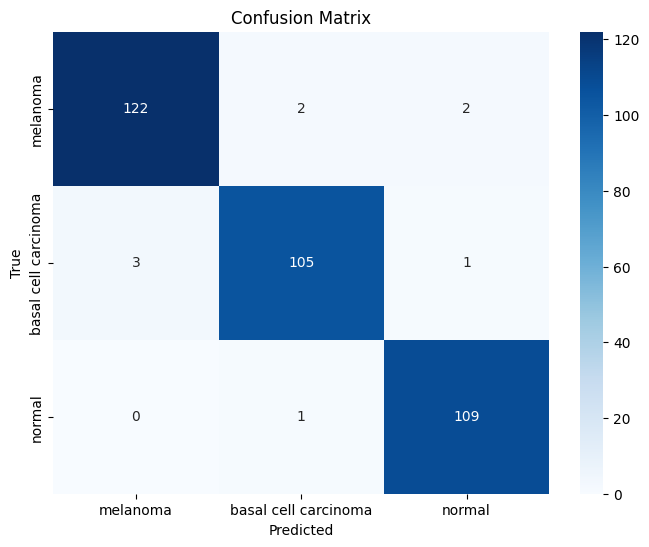

In [94]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_rnn_tuning_5)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# CNN DNN Stacking Tuning

In [95]:
import os
from keras.models import load_model
from numpy import dstack
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Fungsi dependencies
def accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

dependencies = {
    'accuracy': accuracy  
}


# Fungsi load model terpilih
def load_selected_models(folder_path, model_prefix):
    all_models = []
    for i in range(1, 6):  # 5 model dari fold 1 hingga 5
        # Definisikan nama file untuk model CNN dan DNN
        cnn_filename = os.path.join(folder_path, f'{model_prefix}_fold_{i}.h5')
        dnn_filename = os.path.join(folder_path, f'{model_prefix}_fold_{i}.h5')
        # Memuat model CNN dan DNN
        cnn_model = load_model(cnn_filename, custom_objects=dependencies)
        dnn_model = load_model(dnn_filename, custom_objects=dependencies)
        # Menambahkan model CNN dan DNN ke daftar members
        all_models.append((cnn_model, dnn_model))
        print(f'> Loaded {cnn_filename} and {dnn_filename}')
    return all_models

# Fungsi dataset input model gabungan
def stacked_dataset(members, inputX):
    stackX = None
    for cnn_model, dnn_model in members:
        # Melakukan prediksi dengan model CNN
        cnn_prediction = cnn_model.predict(inputX, verbose=0)
        # Melakukan prediksi dengan model DNN
        dnn_prediction = dnn_model.predict(inputX, verbose=0)
        # Menggabungkan prediksi CNN dan DNN
        stacked_prediction = dstack((cnn_prediction, dnn_prediction))
        # Membuat stack prediksi menjadi [baris, anggota, probabilitas]
        if stackX is None:
            stackX = stacked_prediction
        else:
            stackX = dstack((stackX, stacked_prediction))
    # Meratakan prediksi menjadi [baris, anggota x probabilitas]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

# Fungsi memasangkan model berdasarkan output dari anggota ensemble
def fit_stacked_model(members, inputX, inputy):
    # Membuat dataset menggunakan ensemble
    stackedX = stacked_dataset(members, inputX)
    # Melatih model mandiri
    model = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=10, min_samples_split=4, min_samples_leaf=2, random_state=42) #meta learner
    model.fit(stackedX, inputy)
    return model

# Function to make a prediction with the stacked model
def stacked_prediction(members, model, inputX):
    # Create dataset using ensemble
    stackedX = stacked_dataset(members, inputX)
    # Make a prediction
    yhat = model.predict(stackedX)
    return yhat


# Memuat dan memasangkan model
cnn_models = load_selected_models("models_cnn_tuning", "model_cnn_tuning")
dnn_models = load_selected_models("models_dnn_tuning", "model_dnn_tuning")
# Membuat pasangan model CNN dan DNN
paired_models = list(zip(cnn_models, dnn_models))

stacked_model_pair = paired_models

> Loaded models_cnn_tuning\model_cnn_tuning_fold_1.h5 and models_cnn_tuning\model_cnn_tuning_fold_1.h5
> Loaded models_cnn_tuning\model_cnn_tuning_fold_2.h5 and models_cnn_tuning\model_cnn_tuning_fold_2.h5


> Loaded models_cnn_tuning\model_cnn_tuning_fold_3.h5 and models_cnn_tuning\model_cnn_tuning_fold_3.h5
> Loaded models_cnn_tuning\model_cnn_tuning_fold_4.h5 and models_cnn_tuning\model_cnn_tuning_fold_4.h5


> Loaded models_cnn_tuning\model_cnn_tuning_fold_5.h5 and models_cnn_tuning\model_cnn_tuning_fold_5.h5
> Loaded models_dnn_tuning\model_dnn_tuning_fold_1.h5 and models_dnn_tuning\model_dnn_tuning_fold_1.h5


> Loaded models_dnn_tuning\model_dnn_tuning_fold_2.h5 and models_dnn_tuning\model_dnn_tuning_fold_2.h5
> Loaded models_dnn_tuning\model_dnn_tuning_fold_3.h5 and models_dnn_tuning\model_dnn_tuning_fold_3.h5


> Loaded models_dnn_tuning\model_dnn_tuning_fold_4.h5 and models_dnn_tuning\model_dnn_tuning_fold_4.h5
> Loaded models_dnn_tuning\model_dnn_tuning_fold_5.h5 and models_dnn_tuning\model_dnn_tuning_fold_5.h5


## Data Training

In [96]:
y_train_1d = np.argmax(y_train, axis=1)
y_test_1d = np.argmax(y_test, axis=1)

In [97]:
# Panggil fungsi untuk meload model CNN dan DNN 1 hingga 5
# Panggil fungsi untuk meload model CNN dan DNN 1 hingga 5
models_cnn_tuning_fold = [1, 2, 3, 4, 5]
members_cnn_tuning_fold = load_selected_models("models_cnn_tuning", "model_cnn_tuning")
print('Loaded %d CNN Tuning models' % len(members_cnn_tuning_fold))

models_dnn_tuning_fold = [1, 2, 3, 4, 5]
members_dnn_tuning_fold = load_selected_models("models_dnn_tuning", "model_dnn_tuning")
print('Loaded %d DNN Tuning models' % len(members_dnn_tuning_fold))


# Membuat pasangan model CNN dan DNN untuk setiap fold
paired_cnn_dnn_tuning_models = []
for cnn_model, dnn_model in zip(members_cnn_tuning_fold, members_dnn_tuning_fold):
    paired_cnn_dnn_tuning_models.append((cnn_model, dnn_model))

# Misalnya untuk fold pertama
cnn_model_fold_1, dnn_model_fold_1 = paired_cnn_dnn_tuning_models[0]
cnn_model_fold_2, dnn_model_fold_2 = paired_cnn_dnn_tuning_models[1]
cnn_model_fold_3, dnn_model_fold_3 = paired_cnn_dnn_tuning_models[2]
cnn_model_fold_4, dnn_model_fold_4 = paired_cnn_dnn_tuning_models[3]
cnn_model_fold_5, dnn_model_fold_5 = paired_cnn_dnn_tuning_models[4]


> Loaded models_cnn_tuning\model_cnn_tuning_fold_1.h5 and models_cnn_tuning\model_cnn_tuning_fold_1.h5
> Loaded models_cnn_tuning\model_cnn_tuning_fold_2.h5 and models_cnn_tuning\model_cnn_tuning_fold_2.h5


> Loaded models_cnn_tuning\model_cnn_tuning_fold_3.h5 and models_cnn_tuning\model_cnn_tuning_fold_3.h5
> Loaded models_cnn_tuning\model_cnn_tuning_fold_4.h5 and models_cnn_tuning\model_cnn_tuning_fold_4.h5


> Loaded models_cnn_tuning\model_cnn_tuning_fold_5.h5 and models_cnn_tuning\model_cnn_tuning_fold_5.h5
Loaded 5 CNN Tuning models


> Loaded models_dnn_tuning\model_dnn_tuning_fold_1.h5 and models_dnn_tuning\model_dnn_tuning_fold_1.h5
> Loaded models_dnn_tuning\model_dnn_tuning_fold_2.h5 and models_dnn_tuning\model_dnn_tuning_fold_2.h5


> Loaded models_dnn_tuning\model_dnn_tuning_fold_3.h5 and models_dnn_tuning\model_dnn_tuning_fold_3.h5
> Loaded models_dnn_tuning\model_dnn_tuning_fold_4.h5 and models_dnn_tuning\model_dnn_tuning_fold_4.h5


> Loaded models_dnn_tuning\model_dnn_tuning_fold_5.h5 and models_dnn_tuning\model_dnn_tuning_fold_5.h5
Loaded 5 DNN Tuning models


In [87]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_dnn_tuning_1 = fit_stacked_model(paired_cnn_dnn_tuning_models[0], X_train, y_train_1d)
y_pred_cnn_dnn_tuning_1 = stacked_prediction(paired_cnn_dnn_tuning_models[0], stacked_model_cnn_dnn_tuning_1, X_train)

# Hitung matriks kebingungan
conf_matrix_1 = confusion_matrix(y_train_1d, y_pred_cnn_dnn_tuning_1)
accuracy_1 = accuracy_score(y_train_1d, y_pred_cnn_dnn_tuning_1)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_1[0, 0]
false_positive = conf_matrix_1[0, 1]
false_negative = conf_matrix_1[1, 0]
true_positive = conf_matrix_1[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_1 = classification_report(y_train_1d, y_pred_cnn_dnn_tuning_1, output_dict=True)
precision = classification_report_1['weighted avg']['precision']
recall = classification_report_1['weighted avg']['recall']
f1 = classification_report_1['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_dnn_tuning_1))

Stacked Model Metrics:
Accuracy: 0.9637681159420289
Precision: 0.9638498980648117
Recall: 0.9637681159420289
F1 Score: 0.9636908755782523
Sensitivity: 0.9415584415584416
Specificity: 0.9664429530201343
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       449
           1       0.96      0.93      0.95       466
           2       0.99      1.00      0.99       465

    accuracy                           0.96      1380
   macro avg       0.96      0.96      0.96      1380
weighted avg       0.96      0.96      0.96      1380



In [92]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_dnn_tuning_2 = fit_stacked_model(paired_cnn_dnn_tuning_models[1], X_train, y_train_1d)
y_pred_cnn_dnn_tuning_2 = stacked_prediction(paired_cnn_dnn_tuning_models[1], stacked_model_cnn_dnn_tuning_2, X_train)

# Hitung matriks kebingungan
conf_matrix_2 = confusion_matrix(y_train_1d, y_pred_cnn_dnn_tuning_2)
accuracy_2 = accuracy_score(y_train_1d, y_pred_cnn_dnn_tuning_2)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_2[0, 0]
false_positive = conf_matrix_2[0, 1]
false_negative = conf_matrix_2[1, 0]
true_positive = conf_matrix_2[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_2 = classification_report(y_train_1d, y_pred_cnn_dnn_tuning_2, output_dict=True)
precision = classification_report_2['weighted avg']['precision']
recall = classification_report_2['weighted avg']['recall']
f1 = classification_report_2['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_2}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_dnn_tuning_2))

Stacked Model Metrics:
Accuracy: 0.9652173913043478
Precision: 0.9655641393195323
Recall: 0.9652173913043478
F1 Score: 0.9651843591341428
Sensitivity: 0.9375
Specificity: 0.9775784753363229
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       449
           1       0.97      0.93      0.95       466
           2       0.99      0.99      0.99       465

    accuracy                           0.97      1380
   macro avg       0.97      0.97      0.97      1380
weighted avg       0.97      0.97      0.97      1380



In [93]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_dnn_tuning_3 = fit_stacked_model(paired_cnn_dnn_tuning_models[2], X_train, y_train_1d)
y_pred_cnn_dnn_tuning_3 = stacked_prediction(paired_cnn_dnn_tuning_models[2], stacked_model_cnn_dnn_tuning_3, X_train)

# Hitung matriks kebingungan
conf_matrix_3 = confusion_matrix(y_train_1d, y_pred_cnn_dnn_tuning_3)
accuracy_3 = accuracy_score(y_train_1d, y_pred_cnn_dnn_tuning_3)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_3[0, 0]
false_positive = conf_matrix_3[0, 1]
false_negative = conf_matrix_3[1, 0]
true_positive = conf_matrix_3[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_3 = classification_report(y_train_1d, y_pred_cnn_dnn_tuning_3, output_dict=True)
precision = classification_report_3['weighted avg']['precision']
recall = classification_report_3['weighted avg']['recall']
f1 = classification_report_3['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_3}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_dnn_tuning_3))

Stacked Model Metrics:
Accuracy: 0.9782608695652174
Precision: 0.9784699777366662
Recall: 0.9782608695652174
F1 Score: 0.9782703762582606
Sensitivity: 0.9612903225806452
Specificity: 0.9866071428571429
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       449
           1       0.98      0.96      0.97       466
           2       1.00      0.99      0.99       465

    accuracy                           0.98      1380
   macro avg       0.98      0.98      0.98      1380
weighted avg       0.98      0.98      0.98      1380



In [94]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_dnn_tuning_4 = fit_stacked_model(paired_cnn_dnn_tuning_models[3], X_train, y_train_1d)
y_pred_cnn_dnn_tuning_4 = stacked_prediction(paired_cnn_dnn_tuning_models[3], stacked_model_cnn_dnn_tuning_4, X_train)

# Hitung matriks kebingungan
conf_matrix_4 = confusion_matrix(y_train_1d, y_pred_cnn_dnn_tuning_4)
accuracy_4 = accuracy_score(y_train_1d, y_pred_cnn_dnn_tuning_4)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_4[0, 0]
false_positive = conf_matrix_4[0, 1]
false_negative = conf_matrix_4[1, 0]
true_positive = conf_matrix_4[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_4 = classification_report(y_train_1d, y_pred_cnn_dnn_tuning_4, output_dict=True)
precision = classification_report_4['weighted avg']['precision']
recall = classification_report_4['weighted avg']['recall']
f1 = classification_report_4['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_4}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_dnn_tuning_4))

Stacked Model Metrics:
Accuracy: 0.9594202898550724
Precision: 0.9602353859512834
Recall: 0.9594202898550724
F1 Score: 0.9594322943128473
Sensitivity: 0.9225806451612903
Specificity: 0.9730941704035875
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       449
           1       0.97      0.92      0.94       466
           2       0.99      0.99      0.99       465

    accuracy                           0.96      1380
   macro avg       0.96      0.96      0.96      1380
weighted avg       0.96      0.96      0.96      1380



In [95]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_dnn_tuning_5 = fit_stacked_model(paired_cnn_dnn_tuning_models[4], X_train, y_train_1d)
y_pred_cnn_dnn_tuning_5 = stacked_prediction(paired_cnn_dnn_tuning_models[4], stacked_model_cnn_dnn_tuning_5, X_train)

# Hitung matriks kebingungan
conf_matrix_5 = confusion_matrix(y_train_1d, y_pred_cnn_dnn_tuning_5)
accuracy_5 = accuracy_score(y_train_1d, y_pred_cnn_dnn_tuning_5)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_5[0, 0]
false_positive = conf_matrix_5[0, 1]
false_negative = conf_matrix_5[1, 0]
true_positive = conf_matrix_5[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_5 = classification_report(y_train_1d, y_pred_cnn_dnn_tuning_5, output_dict=True)
precision = classification_report_5['weighted avg']['precision']
recall = classification_report_5['weighted avg']['recall']
f1 = classification_report_5['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_5}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_train_1d, y_pred_cnn_dnn_tuning_5))

Stacked Model Metrics:
Accuracy: 0.9586956521739131
Precision: 0.9599731089307417
Recall: 0.9586956521739131
F1 Score: 0.9586845081698995
Sensitivity: 0.915948275862069
Specificity: 0.9798657718120806
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       449
           1       0.97      0.91      0.94       466
           2       0.99      0.99      0.99       465

    accuracy                           0.96      1380
   macro avg       0.96      0.96      0.96      1380
weighted avg       0.96      0.96      0.96      1380



## Data Test

In [105]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_dnn_tuning_1 = fit_stacked_model(paired_cnn_dnn_tuning_models[0], X_test, y_test_1d)
y_pred_cnn_dnn_tuning_1 = stacked_prediction(paired_cnn_dnn_tuning_models[0], stacked_model_cnn_dnn_tuning_1, X_test)

# Hitung matriks kebingungan
conf_matrix_1 = confusion_matrix(y_test_1d, y_pred_cnn_dnn_tuning_1)
accuracy_1 = accuracy_score(y_test_1d, y_pred_cnn_dnn_tuning_1)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_1[0, 0]
false_positive = conf_matrix_1[0, 1]
false_negative = conf_matrix_1[1, 0]
true_positive = conf_matrix_1[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_1 = classification_report(y_test_1d, y_pred_cnn_dnn_tuning_1, output_dict=True)
precision = classification_report_1['weighted avg']['precision']
recall = classification_report_1['weighted avg']['recall']
f1 = classification_report_1['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_dnn_tuning_1))

Stacked Model Metrics:
Accuracy: 0.9652173913043478
Precision: 0.9651354252803527
Recall: 0.9652173913043478
F1 Score: 0.965163599154194
Sensitivity: 0.9537037037037037
Specificity: 0.968
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       126
           1       0.95      0.94      0.95       109
           2       0.98      0.99      0.99       110

    accuracy                           0.97       345
   macro avg       0.97      0.97      0.97       345
weighted avg       0.97      0.97      0.97       345



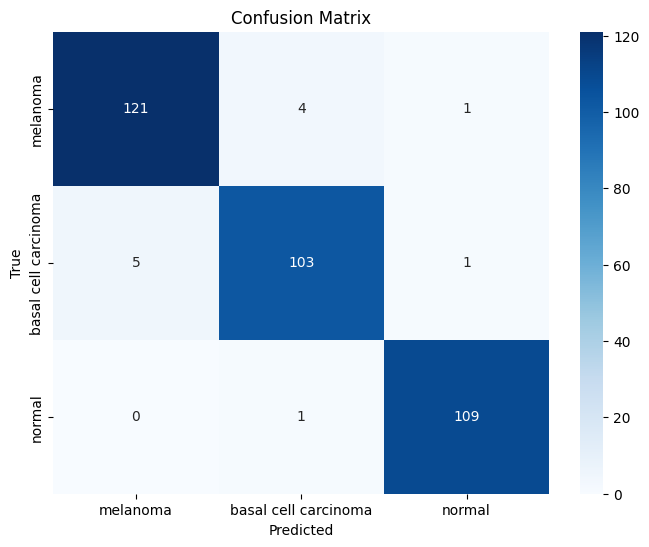

In [106]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_dnn_tuning_1)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [107]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_dnn_tuning_2 = fit_stacked_model(paired_cnn_dnn_tuning_models[1], X_test, y_test_1d)
y_pred_cnn_dnn_tuning_2 = stacked_prediction(paired_cnn_dnn_tuning_models[1], stacked_model_cnn_dnn_tuning_2, X_test)

# Hitung matriks kebingungan
conf_matrix_2 = confusion_matrix(y_test_1d, y_pred_cnn_dnn_tuning_2)
accuracy_2 = accuracy_score(y_test_1d, y_pred_cnn_dnn_tuning_2)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_2[0, 0]
false_positive = conf_matrix_2[0, 1]
false_negative = conf_matrix_2[1, 0]
true_positive = conf_matrix_2[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_2 = classification_report(y_test_1d, y_pred_cnn_dnn_tuning_2, output_dict=True)
precision = classification_report_2['weighted avg']['precision']
recall = classification_report_2['weighted avg']['recall']
f1 = classification_report_2['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_2}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_dnn_tuning_2))

Stacked Model Metrics:
Accuracy: 0.9768115942028985
Precision: 0.9767650333563377
Recall: 0.9768115942028985
F1 Score: 0.9767505384163576
Sensitivity: 0.9722222222222222
Specificity: 0.976
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       126
           1       0.97      0.96      0.97       109
           2       0.98      1.00      0.99       110

    accuracy                           0.98       345
   macro avg       0.98      0.98      0.98       345
weighted avg       0.98      0.98      0.98       345



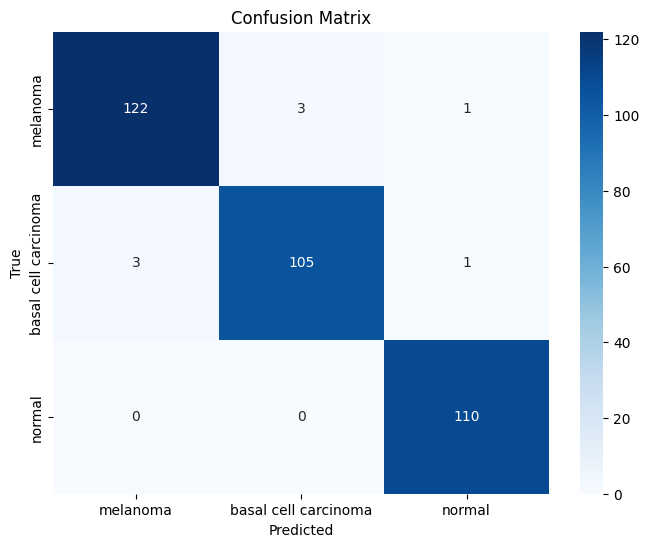

In [108]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_dnn_tuning_2)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [109]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_dnn_tuning_3 = fit_stacked_model(paired_cnn_dnn_tuning_models[2], X_test, y_test_1d)
y_pred_cnn_dnn_tuning_3 = stacked_prediction(paired_cnn_dnn_tuning_models[2], stacked_model_cnn_dnn_tuning_3, X_test)

# Hitung matriks kebingungan
conf_matrix_3 = confusion_matrix(y_test_1d, y_pred_cnn_dnn_tuning_3)
accuracy_3 = accuracy_score(y_test_1d, y_pred_cnn_dnn_tuning_3)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_3[0, 0]
false_positive = conf_matrix_3[0, 1]
false_negative = conf_matrix_3[1, 0]
true_positive = conf_matrix_3[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_3 = classification_report(y_test_1d, y_pred_cnn_dnn_tuning_3, output_dict=True)
precision = classification_report_3['weighted avg']['precision']
recall = classification_report_3['weighted avg']['recall']
f1 = classification_report_3['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_3}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_dnn_tuning_3))

Stacked Model Metrics:
Accuracy: 0.9681159420289855
Precision: 0.9680958660360691
Recall: 0.9681159420289855
F1 Score: 0.9680940317076667
Sensitivity: 0.9537037037037037
Specificity: 0.9682539682539683
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       126
           1       0.95      0.94      0.95       109
           2       0.99      0.99      0.99       110

    accuracy                           0.97       345
   macro avg       0.97      0.97      0.97       345
weighted avg       0.97      0.97      0.97       345



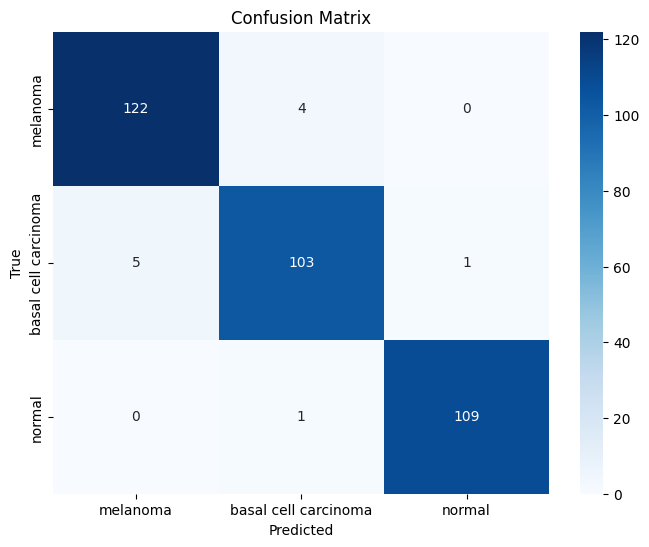

In [111]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_dnn_tuning_3)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [112]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_dnn_tuning_4 = fit_stacked_model(paired_cnn_dnn_tuning_models[3], X_test, y_test_1d)
y_pred_cnn_dnn_tuning_4 = stacked_prediction(paired_cnn_dnn_tuning_models[3], stacked_model_cnn_dnn_tuning_4, X_test)

# Hitung matriks kebingungan
conf_matrix_4 = confusion_matrix(y_test_1d, y_pred_cnn_dnn_tuning_4)
accuracy_4 = accuracy_score(y_test_1d, y_pred_cnn_dnn_tuning_4)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_4[0, 0]
false_positive = conf_matrix_4[0, 1]
false_negative = conf_matrix_4[1, 0]
true_positive = conf_matrix_4[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_4 = classification_report(y_test_1d, y_pred_cnn_dnn_tuning_4, output_dict=True)
precision = classification_report_4['weighted avg']['precision']
recall = classification_report_4['weighted avg']['recall']
f1 = classification_report_4['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_4}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_dnn_tuning_4))

Stacked Model Metrics:
Accuracy: 0.9739130434782609
Precision: 0.973884754319537
Recall: 0.9739130434782609
F1 Score: 0.9738859660813295
Sensitivity: 0.9722222222222222
Specificity: 0.976
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       126
           1       0.97      0.96      0.97       109
           2       0.98      0.99      0.99       110

    accuracy                           0.97       345
   macro avg       0.97      0.97      0.97       345
weighted avg       0.97      0.97      0.97       345



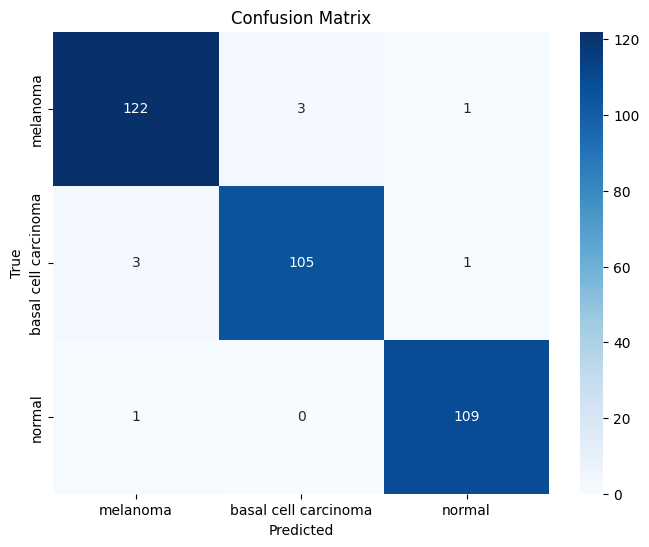

In [113]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_dnn_tuning_4)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [114]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

stacked_model_cnn_dnn_tuning_5 = fit_stacked_model(paired_cnn_dnn_tuning_models[4], X_test, y_test_1d)
y_pred_cnn_dnn_tuning_5 = stacked_prediction(paired_cnn_dnn_tuning_models[4], stacked_model_cnn_dnn_tuning_5, X_test)

# Hitung matriks kebingungan
conf_matrix_5 = confusion_matrix(y_test_1d, y_pred_cnn_dnn_tuning_5)
accuracy_5 = accuracy_score(y_test_1d, y_pred_cnn_dnn_tuning_5)

# Hitung sensitivitas dan spesifisitas
true_negative = conf_matrix_5[0, 0]
false_positive = conf_matrix_5[0, 1]
false_negative = conf_matrix_5[1, 0]
true_positive = conf_matrix_5[1, 1]

sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)

# Hitung metrik lain
classification_report_5 = classification_report(y_test_1d, y_pred_cnn_dnn_tuning_5, output_dict=True)
precision = classification_report_5['weighted avg']['precision']
recall = classification_report_5['weighted avg']['recall']
f1 = classification_report_5['weighted avg']['f1-score']

# Tampilkan hasilnya
print(f'Stacked Model Metrics:')
print(f'Accuracy: {accuracy_5}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Sensitivity: {sensitivity}')
print(f'Specificity: {specificity}')

print(classification_report(y_test_1d, y_pred_cnn_dnn_tuning_5))

Stacked Model Metrics:
Accuracy: 0.9710144927536232
Precision: 0.9710072367020762
Recall: 0.9710144927536232
F1 Score: 0.9709593651622637
Sensitivity: 0.9629629629629629
Specificity: 0.9838709677419355
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       126
           1       0.97      0.95      0.96       109
           2       0.97      0.99      0.98       110

    accuracy                           0.97       345
   macro avg       0.97      0.97      0.97       345
weighted avg       0.97      0.97      0.97       345



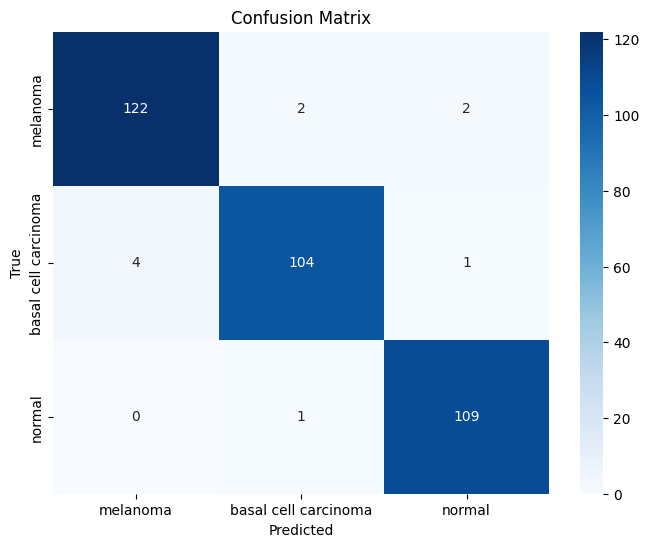

In [115]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Hitung confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_cnn_dnn_tuning_5)

# Definisikan label kelas
class_labels = ['melanoma', 'basal cell carcinoma', 'normal']

# Tampilkan confusion matrix dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()